# Library imports

In [ ]:
import pandas as pd
from statsmodels.tsa.api import VAR
import numpy as np
from gk_replication_final import GKReplicationFinal
import re
import matplotlib.pyplot as plt

# Extension

### 2.2. Monetary surprises data

In [ ]:

fomc = pd.read_excel(
    "monetary-policy-surprises-data.xlsx",
    sheet_name="FOMC (update 2023)"
)

fomc["year"] = fomc["Date"].dt.year.astype(int)
fomc["month"] = fomc["Date"].dt.month.astype(int)

shock_col = "MPS_ORTH" #MPS_ORTH is the orthogonalized monetary policy surprise measure

sched = (
    fomc[fomc["Unscheduled"] == 0]
    .groupby(["year", "month"])[shock_col]
    .sum()
    .rename("shock_scheduled")
)

unsched = (
    fomc[fomc["Unscheduled"] == 1]
    .groupby(["year", "month"])[shock_col]
    .sum()
    .rename("shock_unscheduled")
)

all_fomc = (
    fomc
    .groupby(["year", "month"])[shock_col]
    .sum()
    .rename("shock_all")
)

fomc_monthly = (
    pd.concat([sched, unsched, all_fomc], axis=1)
    .reset_index()
    .fillna(0.0)
)

var_ext = pd.read_csv("VAR_data_ext.csv")

var_ext["year"] = var_ext["year"].astype(int)
var_ext["month"] = var_ext["month"].astype(int)

data_merged = pd.merge(
    var_ext,
    fomc_monthly[["year", "month", "shock_scheduled", "shock_unscheduled", "shock_all"]],
    on=["year", "month"],
    how="left"
)

for col in ["shock_scheduled", "shock_unscheduled", "shock_all"]:
    data_merged[col] = data_merged[col].fillna(0.0)

data_merged["date"] = pd.to_datetime(
    data_merged["year"].astype(str) + "-" +
    data_merged["month"].astype(str) + "-01"
)
data_merged = data_merged.set_index("date").sort_index()
var_cols   = ["logip", "logcpi", "gs1", "ebp"]
shock_cols = ["shock_scheduled", "shock_unscheduled", "shock_all"]

data_merged = data_merged[var_cols + shock_cols]

print(data_merged.head())
print(data_merged.tail())




                 logip      logcpi  gs1  ebp  shock_scheduled  \
date                                                            
1950-01-01  264.114087  315.700042  0.0  0.0              0.0   
1950-02-01  264.497550  315.700042  0.0  0.0              0.0   
1950-03-01  267.696537  316.124671  0.0  0.0              0.0   
1950-04-01  270.974876  316.124671  0.0  0.0              0.0   
1950-05-01  273.278184  316.547505  0.0  0.0              0.0   

            shock_unscheduled  shock_all  
date                                      
1950-01-01                0.0        0.0  
1950-02-01                0.0        0.0  
1950-03-01                0.0        0.0  
1950-04-01                0.0        0.0  
1950-05-01                0.0        0.0  
                 logip      logcpi   gs1       ebp  shock_scheduled  \
date                                                                  
2025-04-01  461.750184  577.080229  3.95 -0.084088              0.0   
2025-05-01  461.646318  577.28

In [ ]:
data_merged[data_merged['shock_scheduled'] != 0]


logip      logcpi   gs1       ebp  shock_scheduled  \
date                                                                  
1988-02-01  410.594864  475.359019  6.64  0.165044        -0.000085   
1988-03-01  410.841346  475.789127  6.71 -0.094713        -0.042128   
1988-05-01  411.217957  476.643833  7.40  0.050947         0.053866   
1988-07-01  411.522341  477.491296  7.75 -0.130395        -0.009617   
1988-08-01  412.022509  477.912349  8.17  0.034311         0.008749   
...                ...         ...   ...       ...              ...   
2023-06-01  460.636547  572.066909  5.24  0.181677         0.080558   
2023-07-01  461.419633  572.257479  5.37  0.023272         0.001280   
2023-09-01  461.532941  572.941448  5.44 -0.003385         0.086754   
2023-11-01  461.377208  572.701386  5.28 -0.077347         0.006847   
2023-12-01  461.118307  572.602004  4.96 -0.223414        -0.056922   

            shock_unscheduled  shock_all  
date                                      
1988-02-01          -0.036131  -0.036216  
1988-03-01           0.000000  -0.042128  
1988-05-01           0.065009   0.118875  
1988-07-01          -0.027225  -0.036842  
1988-08-01           0.088118   0.096867  
...                       ...        ...  
2023-06-01           0.000000   0.080558  
2023-07-01           0.000000   0.001280  
2023-09-01           0.000000   0.086754  
2023-11-01           0.000000   0.006847  
2023-12-01           0.000000  -0.056922  

[281 rows x 7 columns]

In [ ]:
var_cols   = ["logip", "logcpi", "gs1", "ebp"]
shock_cols = ["shock_scheduled", "shock_unscheduled", "shock_all"]


In [ ]:
df = data_merged

Doing VAR(12) for 4 equations:

In [ ]:


y = df[var_cols].dropna()

p = 12

model = VAR(y)
var_res = model.fit(p)

print(var_res.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Dec, 2025
Time:                     19:56:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -6.96069
Nobs:                     896.000    HQIC:                  -7.60922
Log likelihood:          -1300.89    FPE:                0.000332191
AIC:                     -8.01024    Det(Omega_mle):     0.000268468
--------------------------------------------------------------------
Results for equation logip
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.735356         0.306815            2.397           0.017
L1.logip           1.255419         0.034396           36.499           0.000
L1.logcpi          0.079977         0.116490            0.687           

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:


def proxy_svar_identification(var_res, shock_series, common_start="1991-01-01"):
    """
    var_res     - результат VAR (var_res из statsmodels)
    shock_series - ряд шока (одна из колонок: shock_scheduled / shock_unscheduled / shock_all)
    """
    u = var_res.resid
    u_common = u.loc[common_start:]
    z_common = shock_series.loc[common_start:]

    common_idx = u_common.index.intersection(z_common.index)
    u_common = u_common.loc[common_idx]
    z_common = z_common.loc[common_idx]

    U = u_common.values
    Z = z_common.values

    pi, _, _, _ = np.linalg.lstsq(U, Z, rcond=None)

    b_raw = pi
    b = b_raw / b_raw[2]

    return b


In [ ]:
rep = GKReplicationFinal()

var_cols = rep.selected_vars

y_ext = df[var_cols].dropna()
var_res_ext = rep.estimate_var(y_ext)



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SVAR:



================ IRFs – Scheduled FOMC =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2844

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4266
  logcpi  : +0.9979
  gs1     : +1.0000
  ebp     : -2.8673

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2001

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0723
  logcpi  : +1.8374
  gs1     : +1.0000
  ebp     : -3.8835

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3764

Impact vector (normalised so gs1 impact = 1):
  log

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1849

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3115
  logcpi  : +1.9996
  gs1     : +1.0000
  ebp     : -4.7754

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3417

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8191
  logcpi  : +1.1785
  gs1     : +1.0000
  ebp     : -2.3705


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2396

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4498
  logcpi  : +1.3313
  gs1     : +1.0000
  ebp     : -3.7964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2861

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9047
  logcpi  : +1.1998
  gs1     : +1.0000
  ebp     : -3.3667

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2740

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4923
  logcpi  : +0.9740
  gs1     : +1.0000
  ebp     : -2.7313


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0895

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2433
  logcpi  : +3.4632
  gs1     : +1.0000
  ebp     : -8.0054

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2109

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6229
  logcpi  : +0.9134
  gs1     : +1.0000
  ebp     : -3.6632

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2362

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7519
  logcpi  : +1.0828
  gs1     : +1.0000
  ebp     : -2.7234


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.29
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4457

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4123
  logcpi  : +0.5382
  gs1     : +1.0000
  ebp     : -1.7231

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2519

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1941
  logcpi  : +1.2003
  gs1     : +1.0000
  ebp     : -2.9865

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2669

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6174
  logcpi  : +0.8086
  gs1     : +1.0000
  ebp     : -2.8953


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2624

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1468
  logcpi  : +1.4009
  gs1     : +1.0000
  ebp     : -3.3136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2386

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1695
  logcpi  : +1.0571
  gs1     : +1.0000
  ebp     : -2.9520

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2928

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5652
  logcpi  : +1.1901
  gs1     : +1.0000
  ebp     : -2.7043


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3720

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1358
  logcpi  : +0.8286
  gs1     : +1.0000
  ebp     : -2.1796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4058

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2214
  logcpi  : +0.8987
  gs1     : +1.0000
  ebp     : -1.9377

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2221

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9940
  logcpi  : +1.3342
  gs1     : +1.0000
  ebp     : -3.5968


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2804

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1660
  logcpi  : +1.1071
  gs1     : +1.0000
  ebp     : -2.5480

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1791

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7824
  logcpi  : +1.9225
  gs1     : +1.0000
  ebp     : -4.6441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2857

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4094
  logcpi  : +0.6468
  gs1     : +1.0000
  ebp     : -2.8002


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2741

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6988
  logcpi  : +0.7822
  gs1     : +1.0000
  ebp     : -2.6099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1453

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7654
  logcpi  : +1.3791
  gs1     : +1.0000
  ebp     : -4.9932

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2837

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9891
  logcpi  : +0.6831
  gs1     : +1.0000
  ebp     : -2.9905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1766

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0918
  logcpi  : +1.7419
  gs1     : +1.0000
  ebp     : -4.4565

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2063

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3647
  logcpi  : +0.8859
  gs1     : +1.0000
  ebp     : -4.0202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4020

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0267
  logcpi  : +0.5990
  gs1     : +1.0000
  ebp     : -2.0201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4319

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7274
  logcpi  : +0.5943
  gs1     : +1.0000
  ebp     : -1.9396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1419

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6102
  logcpi  : +1.3603
  gs1     : +1.0000
  ebp     : -5.4455

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.3906

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3836
  logcpi  : +0.6071
  gs1     : +1.0000
  ebp     : -1.9984


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3155

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6311
  logcpi  : +0.8872
  gs1     : +1.0000
  ebp     : -2.8329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1601

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5497
  logcpi  : +1.9428
  gs1     : +1.0000
  ebp     : -5.2652


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3678

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0948
  logcpi  : +0.8572
  gs1     : +1.0000
  ebp     : -1.8741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3424

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2562
  logcpi  : +1.1479
  gs1     : +1.0000
  ebp     : -2.5106


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2519

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0304
  logcpi  : +1.1603
  gs1     : +1.0000
  ebp     : -2.9496

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3328

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7391
  logcpi  : +0.8495
  gs1     : +1.0000
  ebp     : -2.0891


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2630

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9133
  logcpi  : +1.5322
  gs1     : +1.0000
  ebp     : -3.1699

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2834

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7605
  logcpi  : +0.6124
  gs1     : +1.0000
  ebp     : -2.5757


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3617

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1807
  logcpi  : +0.8856
  gs1     : +1.0000
  ebp     : -1.7064

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1984

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4723
  logcpi  : +1.0649
  gs1     : +1.0000
  ebp     : -3.7683


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2381

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8847
  logcpi  : +1.6619
  gs1     : +1.0000
  ebp     : -3.2028

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3235

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3812
  logcpi  : +0.5933
  gs1     : +1.0000
  ebp     : -2.2086


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2525

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2616
  logcpi  : +1.7418
  gs1     : +1.0000
  ebp     : -3.2796

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.83
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.5310

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5927
  logcpi  : +0.4092
  gs1     : +1.0000
  ebp     : -1.3792

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3532

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6623
  logcpi  : +0.5219
  gs1     : +1.0000
  ebp     : -2.1853


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.34
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4403

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3228
  logcpi  : +0.8382
  gs1     : +1.0000
  ebp     : -1.7628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2085

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7551
  logcpi  : +1.0753
  gs1     : +1.0000
  ebp     : -3.5166


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3447

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6894
  logcpi  : +0.5785
  gs1     : +1.0000
  ebp     : -2.2442

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2648

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0302
  logcpi  : +0.6525
  gs1     : +1.0000
  ebp     : -2.5585

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3642

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7651
  logcpi  : +0.6930
  gs1     : +1.0000
  ebp     : -2.3210


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3168

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3305
  logcpi  : +0.7335
  gs1     : +1.0000
  ebp     : -2.4395

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1777

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.8935
  logcpi  : +1.0845
  gs1     : +1.0000
  ebp     : -4.2017

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.10
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3039
  logcpi  : +0.8239
  gs1     : +1.0000
  ebp     : -1.8518


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1898

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5813
  logcpi  : +1.2389
  gs1     : +1.0000
  ebp     : -4.2094


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1995

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8176
  logcpi  : +1.2791
  gs1     : +1.0000
  ebp     : -3.8789


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.26
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4390

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0539
  logcpi  : +0.9375
  gs1     : +1.0000
  ebp     : -2.1774


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0906

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9294
  logcpi  : +2.8528
  gs1     : +1.0000
  ebp     : -7.5343


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1380

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7297
  logcpi  : +1.6145
  gs1     : +1.0000
  ebp     : -5.9047


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.08
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): -0.5482

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8872
  logcpi  : +0.4632
  gs1     : +1.0000
  ebp     : -1.3829


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3005

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4572
  logcpi  : +1.4397
  gs1     : +1.0000
  ebp     : -2.9290


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2583

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4403
  logcpi  : +1.7851
  gs1     : +1.0000
  ebp     : -3.4324


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1019

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0587
  logcpi  : +3.4869
  gs1     : +1.0000
  ebp     : -7.6805


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.38
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4652

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3583
  logcpi  : +0.7349
  gs1     : +1.0000
  ebp     : -1.7794


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3972

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3853
  logcpi  : +0.7695
  gs1     : +1.0000
  ebp     : -2.1737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1801

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0561
  logcpi  : +1.4581
  gs1     : +1.0000
  ebp     : -4.2189


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3187

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4030
  logcpi  : +0.9717
  gs1     : +1.0000
  ebp     : -2.6493

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2632

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8334
  logcpi  : +1.0444
  gs1     : +1.0000
  ebp     : -2.8655


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3598

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0889
  logcpi  : +1.0022
  gs1     : +1.0000
  ebp     : -2.2393

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3656

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4619
  logcpi  : +0.9207
  gs1     : +1.0000
  ebp     : -2.3516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4191

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7781
  logcpi  : +0.5518
  gs1     : +1.0000
  ebp     : -2.0975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4182

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9224
  logcpi  : +0.4598
  gs1     : +1.0000
  ebp     : -1.8044


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2877

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1709
  logcpi  : +0.6973
  gs1     : +1.0000
  ebp     : -2.3920


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1952

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6206
  logcpi  : +0.9216
  gs1     : +1.0000
  ebp     : -4.1932

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2140

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7665
  logcpi  : +1.2438
  gs1     : +1.0000
  ebp     : -3.0558


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2169

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4454
  logcpi  : +1.0907
  gs1     : +1.0000
  ebp     : -3.0987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2330

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0622
  logcpi  : +0.7955
  gs1     : +1.0000
  ebp     : -2.6511


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3907

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4474
  logcpi  : +0.6742
  gs1     : +1.0000
  ebp     : -2.1110

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2258

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1087
  logcpi  : +0.9593
  gs1     : +1.0000
  ebp     : -3.2083


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3185

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8264
  logcpi  : +0.7925
  gs1     : +1.0000
  ebp     : -2.2437

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3041

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8903
  logcpi  : +0.8094
  gs1     : +1.0000
  ebp     : -2.4839


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4620

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1774
  logcpi  : +0.6851
  gs1     : +1.0000
  ebp     : -1.7809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2776

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3536
  logcpi  : +0.8489
  gs1     : +1.0000
  ebp     : -2.6603


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3565

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3502
  logcpi  : +0.7802
  gs1     : +1.0000
  ebp     : -2.2221

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1131

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9735
  logcpi  : +3.5777
  gs1     : +1.0000
  ebp     : -6.8767


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.59
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4930

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8278
  logcpi  : +0.7776
  gs1     : +1.0000
  ebp     : -1.5821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4057

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5425
  logcpi  : +0.7336
  gs1     : +1.0000
  ebp     : -1.8212

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2951

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9001
  logcpi  : +1.0128
  gs1     : +1.0000
  ebp     : -2.7630


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3821

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0935
  logcpi  : +0.6582
  gs1     : +1.0000
  ebp     : -1.8563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1266

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7205
  logcpi  : +1.2857
  gs1     : +1.0000
  ebp     : -5.8278

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2322

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3159
  logcpi  : +0.8807
  gs1     : +1.0000
  ebp     : -3.3687


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2467

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5228
  logcpi  : +0.8169
  gs1     : +1.0000
  ebp     : -2.9021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0318

Impact vector (normalised so gs1 impact = 1):
  logip   : -23.3798
  logcpi  : -8.7433
  gs1     : +1.0000
  ebp     : +23.4688

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3510

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1780
  logcpi  : +0.7910
  gs1     : +1.0000
  ebp     : -2.1764


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3517

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8834
  logcpi  : +0.5955
  gs1     : +1.0000
  ebp     : -2.5666

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3090

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0305
  logcpi  : +0.7658
  gs1     : +1.0000
  ebp     : -2.5551

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3973

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3280
  logcpi  : +0.8902
  gs1     : +1.0000
  ebp     : -2.1448


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2476

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5823
  logcpi  : +1.8204
  gs1     : +1.0000
  ebp     : -3.1302

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2735

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6166
  logcpi  : +0.9042
  gs1     : +1.0000
  ebp     : -3.0617

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2924

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1034
  logcpi  : +0.7253
  gs1     : +1.0000
  ebp     : -2.6964


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3392

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2819
  logcpi  : +0.7843
  gs1     : +1.0000
  ebp     : -2.2447

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3384

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3588
  logcpi  : +0.7450
  gs1     : +1.0000
  ebp     : -2.3865

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1923

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9076
  logcpi  : +1.4601
  gs1     : +1.0000
  ebp     : -3.7327


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2090

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1219
  logcpi  : +1.3364
  gs1     : +1.0000
  ebp     : -3.7189

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4263

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6230
  logcpi  : +0.5972
  gs1     : +1.0000
  ebp     : -1.6322

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2427

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6560
  logcpi  : +1.3730
  gs1     : +1.0000
  ebp     : -3.1491


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2669

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7051
  logcpi  : +0.5257
  gs1     : +1.0000
  ebp     : -3.1536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3532

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4587
  logcpi  : +0.6548
  gs1     : +1.0000
  ebp     : -2.2885

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3766

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6381
  logcpi  : +0.9428
  gs1     : +1.0000
  ebp     : -2.0077


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3426

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8100
  logcpi  : +0.6821
  gs1     : +1.0000
  ebp     : -2.3943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0984

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.8683
  logcpi  : +2.6697
  gs1     : +1.0000
  ebp     : -7.8691

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1431

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2804
  logcpi  : +2.6337
  gs1     : +1.0000
  ebp     : -5.0335

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2724

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1640
  logcpi  : +1.3231
  gs1     : +1.0000
  ebp     : -2.6294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2703

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4960
  logcpi  : +1.5458
  gs1     : +1.0000
  ebp     : -3.2516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2699

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7027
  logcpi  : +1.1386
  gs1     : +1.0000
  ebp     : -3.0287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1709

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2478
  logcpi  : +1.9157
  gs1     : +1.0000
  ebp     : -4.4128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2061

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2092
  logcpi  : +1.8509
  gs1     : +1.0000
  ebp     : -3.3762


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.51
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4753

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5000
  logcpi  : +0.4448
  gs1     : +1.0000
  ebp     : -1.7220

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2295

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0703
  logcpi  : +0.5728
  gs1     : +1.0000
  ebp     : -3.3700

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.48
  R^2: 0.17%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4752

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6900
  logcpi  : +0.6049
  gs1     : +1.0000
  ebp     : -1.5957


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2495

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8624
  logcpi  : +1.6843
  gs1     : +1.0000
  ebp     : -3.1466

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2473

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6691
  logcpi  : +1.4495
  gs1     : +1.0000
  ebp     : -3.3304

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3018

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2125
  logcpi  : +1.2102
  gs1     : +1.0000
  ebp     : -2.5141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2775

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6913
  logcpi  : +1.2333
  gs1     : +1.0000
  ebp     : -2.6586

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.62
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4959

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4387
  logcpi  : +0.2267
  gs1     : +1.0000
  ebp     : -1.8299

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2000

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.3607
  logcpi  : +0.9432
  gs1     : +1.0000
  ebp     : -4.1950


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2229

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6148
  logcpi  : +1.4753
  gs1     : +1.0000
  ebp     : -3.7063

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2588

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0185
  logcpi  : +1.2519
  gs1     : +1.0000
  ebp     : -3.3773

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3441

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2191
  logcpi  : +1.2385
  gs1     : +1.0000
  ebp     : -2.4267


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7199
  logcpi  : +1.7906
  gs1     : +1.0000
  ebp     : -3.7400

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2614

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9200
  logcpi  : +0.8458
  gs1     : +1.0000
  ebp     : -2.8495

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2101

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7384
  logcpi  : +1.5328
  gs1     : +1.0000
  ebp     : -3.3901


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2705

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9519
  logcpi  : +1.2858
  gs1     : +1.0000
  ebp     : -2.9310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1216

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8151
  logcpi  : +3.3123
  gs1     : +1.0000
  ebp     : -6.4768

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2699

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0283
  logcpi  : +0.8881
  gs1     : +1.0000
  ebp     : -2.9160


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2575

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6816
  logcpi  : +0.9138
  gs1     : +1.0000
  ebp     : -3.0926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1317

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.0151
  logcpi  : +2.5916
  gs1     : +1.0000
  ebp     : -6.5118

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2238

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6055
  logcpi  : +1.4670
  gs1     : +1.0000
  ebp     : -3.5943


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2049

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4167
  logcpi  : +0.8866
  gs1     : +1.0000
  ebp     : -3.4929

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3284

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0115
  logcpi  : +0.9619
  gs1     : +1.0000
  ebp     : -2.3836

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3222

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2434
  logcpi  : +0.8105
  gs1     : +1.0000
  ebp     : -2.2501


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2011

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4918
  logcpi  : +1.3935
  gs1     : +1.0000
  ebp     : -4.0394

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1862

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1700
  logcpi  : +0.5168
  gs1     : +1.0000
  ebp     : -3.8513

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3882

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3048
  logcpi  : +0.5449
  gs1     : +1.0000
  ebp     : -1.8653


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1686

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7542
  logcpi  : +1.7064
  gs1     : +1.0000
  ebp     : -4.8139

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1926

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6174
  logcpi  : +1.6877
  gs1     : +1.0000
  ebp     : -4.0539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1114

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5223
  logcpi  : +2.3004
  gs1     : +1.0000
  ebp     : -6.9155

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1768

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9481
  logcpi  : +2.3751
  gs1     : +1.0000
  ebp     : -4.5682

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1763

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4533
  logcpi  : +1.5607
  gs1     : +1.0000
  ebp     : -4.2003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1006

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.0906
  logcpi  : +2.1407
  gs1     : +1.0000
  ebp     : -7.1562


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4062

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5892
  logcpi  : +0.5806
  gs1     : +1.0000
  ebp     : -2.2253

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7300
  logcpi  : +1.2722
  gs1     : +1.0000
  ebp     : -2.9552


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3950

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4357
  logcpi  : +0.7010
  gs1     : +1.0000
  ebp     : -1.9958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3006

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1068
  logcpi  : +0.5706
  gs1     : +1.0000
  ebp     : -2.6957


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3855

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2218
  logcpi  : +0.6948
  gs1     : +1.0000
  ebp     : -2.0421


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2747

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9153
  logcpi  : +1.6762
  gs1     : +1.0000
  ebp     : -3.0883


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3389

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3334
  logcpi  : +0.8131
  gs1     : +1.0000
  ebp     : -2.5239


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2955

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4041
  logcpi  : +1.0459
  gs1     : +1.0000
  ebp     : -2.6664

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3551

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0191
  logcpi  : -0.0138
  gs1     : +1.0000
  ebp     : -1.8179


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0620

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.3289
  logcpi  : +5.0919
  gs1     : +1.0000
  ebp     : -12.7047

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1061

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6976
  logcpi  : +2.5201
  gs1     : +1.0000
  ebp     : -6.5526


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3580

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7028
  logcpi  : +0.4800
  gs1     : +1.0000
  ebp     : -2.0837

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3418

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6175
  logcpi  : +0.9175
  gs1     : +1.0000
  ebp     : -2.2794


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.3961

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1037
  logcpi  : +0.5641
  gs1     : +1.0000
  ebp     : -2.0420

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0560

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.7673
  logcpi  : +3.1579
  gs1     : +1.0000
  ebp     : -13.4012


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2366

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9269
  logcpi  : +1.2154
  gs1     : +1.0000
  ebp     : -3.5048

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3569

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8410
  logcpi  : +0.8453
  gs1     : +1.0000
  ebp     : -2.1988


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2004

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1338
  logcpi  : +1.5911
  gs1     : +1.0000
  ebp     : -4.2468

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2708

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8212
  logcpi  : +1.1714
  gs1     : +1.0000
  ebp     : -2.4797

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3584

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7088
  logcpi  : +0.4285
  gs1     : +1.0000
  ebp     : -2.0242


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3313

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6643
  logcpi  : +1.3612
  gs1     : +1.0000
  ebp     : -2.7884

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1641

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9876
  logcpi  : +0.7718
  gs1     : +1.0000
  ebp     : -4.1935

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2182

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5788
  logcpi  : +1.3362
  gs1     : +1.0000
  ebp     : -3.5515

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0144

Impact vector (normalised so gs1 impact = 1):
  logip   : +38.5630
  logcpi  : +19.2868
  gs1     : +1.0000
  ebp     : -49.6972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3258

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3523
  logcpi  : +0.9893
  gs1     : +1.0000
  ebp     : -2.7862


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2269

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0073
  logcpi  : +1.7391
  gs1     : +1.0000
  ebp     : -3.2442

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2463

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8473
  logcpi  : +0.7788
  gs1     : +1.0000
  ebp     : -3.2690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3014

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7884
  logcpi  : +1.0382
  gs1     : +1.0000
  ebp     : -2.9440


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3900

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6127
  logcpi  : +0.6903
  gs1     : +1.0000
  ebp     : -2.2994

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0578

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.6846
  logcpi  : +5.3046
  gs1     : +1.0000
  ebp     : -14.7225

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1523

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.2671
  logcpi  : +1.2259
  gs1     : +1.0000
  ebp     : -5.3399


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2839

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0136
  logcpi  : +0.9118
  gs1     : +1.0000
  ebp     : -2.8347

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4431

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7042
  logcpi  : +0.6427
  gs1     : +1.0000
  ebp     : -1.8569

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3101

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8308
  logcpi  : +0.8237
  gs1     : +1.0000
  ebp     : -2.5924


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2894

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0373
  logcpi  : +1.0517
  gs1     : +1.0000
  ebp     : -2.1904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4101

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2445
  logcpi  : +0.8618
  gs1     : +1.0000
  ebp     : -1.7505

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2173

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8550
  logcpi  : +1.1167
  gs1     : +1.0000
  ebp     : -3.8520


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2530

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0942
  logcpi  : +1.6333
  gs1     : +1.0000
  ebp     : -3.1471

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3612

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7448
  logcpi  : +0.6929
  gs1     : +1.0000
  ebp     : -2.1064

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2080

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7266
  logcpi  : +1.7231
  gs1     : +1.0000
  ebp     : -3.9305


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3688

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1953
  logcpi  : +0.5026
  gs1     : +1.0000
  ebp     : -2.2333

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.74
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7943
  logcpi  : +0.7389
  gs1     : +1.0000
  ebp     : -1.4688

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3568

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8734
  logcpi  : +1.0589
  gs1     : +1.0000
  ebp     : -2.3145


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7234
  logcpi  : +1.0233
  gs1     : +1.0000
  ebp     : -2.1573

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2257

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3468
  logcpi  : +1.4795
  gs1     : +1.0000
  ebp     : -2.7642


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2965

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8704
  logcpi  : +1.1775
  gs1     : +1.0000
  ebp     : -2.6012

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6647
  logcpi  : +0.8934
  gs1     : +1.0000
  ebp     : -2.6513

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.14
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4087

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4676
  logcpi  : +1.4198
  gs1     : +1.0000
  ebp     : -2.2319


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0970

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2382
  logcpi  : +1.9525
  gs1     : +1.0000
  ebp     : -7.2997

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2924

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0203
  logcpi  : +0.9199
  gs1     : +1.0000
  ebp     : -2.7545

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2006

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5165
  logcpi  : +1.6947
  gs1     : +1.0000
  ebp     : -3.9059


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1530

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4393
  logcpi  : +1.2878
  gs1     : +1.0000
  ebp     : -4.8610

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3667

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8236
  logcpi  : +1.3288
  gs1     : +1.0000
  ebp     : -2.1515


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3021

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8847
  logcpi  : +1.5726
  gs1     : +1.0000
  ebp     : -2.7255

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0621

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9384
  logcpi  : +3.5843
  gs1     : +1.0000
  ebp     : -12.7690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.06
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): -0.5349

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9513
  logcpi  : +0.9585
  gs1     : +1.0000
  ebp     : -1.4254


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3617

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0053
  logcpi  : +0.5413
  gs1     : +1.0000
  ebp     : -2.2904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2392

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4456
  logcpi  : +1.1408
  gs1     : +1.0000
  ebp     : -3.3125

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3886

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0231
  logcpi  : +0.6352
  gs1     : +1.0000
  ebp     : -1.9109


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1896

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9870
  logcpi  : +1.8090
  gs1     : +1.0000
  ebp     : -4.0207

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1022

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.5548
  logcpi  : +2.4272
  gs1     : +1.0000
  ebp     : -7.7381

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2879

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2182
  logcpi  : +1.5343
  gs1     : +1.0000
  ebp     : -2.7744


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1084

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3844
  logcpi  : +1.7587
  gs1     : +1.0000
  ebp     : -6.7676

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3702

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1090
  logcpi  : +0.3354
  gs1     : +1.0000
  ebp     : -2.1452

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2653

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6458
  logcpi  : +0.6454
  gs1     : +1.0000
  ebp     : -2.9583


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0788
  logcpi  : +0.6374
  gs1     : +1.0000
  ebp     : -2.4748

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2983

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2713
  logcpi  : +0.9963
  gs1     : +1.0000
  ebp     : -2.4857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1219

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1258
  logcpi  : +2.4759
  gs1     : +1.0000
  ebp     : -6.3823

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9863
  logcpi  : +1.4557
  gs1     : +1.0000
  ebp     : -2.6100

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2782

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5888
  logcpi  : +1.5637
  gs1     : +1.0000
  ebp     : -2.7138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3415

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1106
  logcpi  : +0.7599
  gs1     : +1.0000
  ebp     : -2.2857


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1596

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3388
  logcpi  : +1.9460
  gs1     : +1.0000
  ebp     : -4.4470

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2273

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8831
  logcpi  : +1.5605
  gs1     : +1.0000
  ebp     : -3.2707

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2339

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0945
  logcpi  : +1.1328
  gs1     : +1.0000
  ebp     : -3.4947


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3228

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3317
  logcpi  : +0.3890
  gs1     : +1.0000
  ebp     : -2.1758

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3094

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3860
  logcpi  : +0.9762
  gs1     : +1.0000
  ebp     : -2.2467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1159

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.5635
  logcpi  : +2.8884
  gs1     : +1.0000
  ebp     : -7.2225


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2087

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7672
  logcpi  : +1.0879
  gs1     : +1.0000
  ebp     : -3.5123

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2498

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8796
  logcpi  : +1.6062
  gs1     : +1.0000
  ebp     : -3.2981

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2764

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5229
  logcpi  : +0.8436
  gs1     : +1.0000
  ebp     : -3.0904


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2146

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1231
  logcpi  : +1.3006
  gs1     : +1.0000
  ebp     : -3.9917

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3704

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0027
  logcpi  : +0.6197
  gs1     : +1.0000
  ebp     : -2.3729

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3018

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8065
  logcpi  : +0.6773
  gs1     : +1.0000
  ebp     : -2.3821


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.64
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4991

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5689
  logcpi  : +0.3645
  gs1     : +1.0000
  ebp     : -1.3671

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1783

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9874
  logcpi  : +1.2752
  gs1     : +1.0000
  ebp     : -4.7926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3752

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5453
  logcpi  : +0.7154
  gs1     : +1.0000
  ebp     : -2.1241


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.53
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4789

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9285
  logcpi  : +0.6090
  gs1     : +1.0000
  ebp     : -1.6933

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.41
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4580

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5800
  logcpi  : +0.4852
  gs1     : +1.0000
  ebp     : -1.9327

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1104

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4906
  logcpi  : +1.6360
  gs1     : +1.0000
  ebp     : -7.6154


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2085

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7063
  logcpi  : +1.8152
  gs1     : +1.0000
  ebp     : -3.7703

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3187

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2054
  logcpi  : +0.7957
  gs1     : +1.0000
  ebp     : -2.4113

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0222

Impact vector (normalised so gs1 impact = 1):
  logip   : -19.6463
  logcpi  : -14.1327
  gs1     : +1.0000
  ebp     : +34.5435


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4022

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4537
  logcpi  : +0.5541
  gs1     : +1.0000
  ebp     : -1.8156

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.96
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.5410

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6332
  logcpi  : +0.5143
  gs1     : +1.0000
  ebp     : -1.4927

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3622

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5332
  logcpi  : +1.0222
  gs1     : +1.0000
  ebp     : -2.2291


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2996

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6021
  logcpi  : +0.7978
  gs1     : +1.0000
  ebp     : -2.4715

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3335

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4498
  logcpi  : +0.5257
  gs1     : +1.0000
  ebp     : -2.3949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2870

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8991
  logcpi  : +1.3703
  gs1     : +1.0000
  ebp     : -2.8024


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1748

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2378
  logcpi  : +1.4125
  gs1     : +1.0000
  ebp     : -4.3339

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3631

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7470
  logcpi  : +0.9491
  gs1     : +1.0000
  ebp     : -2.3058

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2751

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2070
  logcpi  : +0.5063
  gs1     : +1.0000
  ebp     : -2.9793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2950

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6614
  logcpi  : +0.8635
  gs1     : +1.0000
  ebp     : -2.4378

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3202

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8025
  logcpi  : +0.9701
  gs1     : +1.0000
  ebp     : -2.5571

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1246

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1167
  logcpi  : +1.7641
  gs1     : +1.0000
  ebp     : -6.2470


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2696

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6234
  logcpi  : +1.3406
  gs1     : +1.0000
  ebp     : -2.7757

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2754

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3898
  logcpi  : +0.8365
  gs1     : +1.0000
  ebp     : -3.0304

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2448

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0963
  logcpi  : +0.6031
  gs1     : +1.0000
  ebp     : -3.0760


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4280

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2367
  logcpi  : +0.6854
  gs1     : +1.0000
  ebp     : -1.8219

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.99
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.5454

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5139
  logcpi  : +0.5911
  gs1     : +1.0000
  ebp     : -1.5649

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3454

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3279
  logcpi  : +0.6305
  gs1     : +1.0000
  ebp     : -2.2366


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4362

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6911
  logcpi  : +0.3121
  gs1     : +1.0000
  ebp     : -1.6997

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.86
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.5202

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1136
  logcpi  : +0.5650
  gs1     : +1.0000
  ebp     : -1.3956

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1702

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5739
  logcpi  : +1.9721
  gs1     : +1.0000
  ebp     : -4.8205


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1767

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5210
  logcpi  : +1.4355
  gs1     : +1.0000
  ebp     : -4.0728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3380

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6810
  logcpi  : +0.9896
  gs1     : +1.0000
  ebp     : -2.2853

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2940

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9345
  logcpi  : +0.4873
  gs1     : +1.0000
  ebp     : -2.6445


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2990

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4552
  logcpi  : +0.7133
  gs1     : +1.0000
  ebp     : -2.9937

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.67
  R^2: 0.19%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.5024

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5424
  logcpi  : +0.4207
  gs1     : +1.0000
  ebp     : -1.6635

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2384

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5818
  logcpi  : +1.2074
  gs1     : +1.0000
  ebp     : -3.6647


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0523

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.9827
  logcpi  : -4.9145
  gs1     : +1.0000
  ebp     : +14.1755

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3621

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0940
  logcpi  : +1.4185
  gs1     : +1.0000
  ebp     : -2.6870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2602

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8479
  logcpi  : +0.3714
  gs1     : +1.0000
  ebp     : -2.7119


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4003

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1289
  logcpi  : +0.9683
  gs1     : +1.0000
  ebp     : -2.0734

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2245

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1517
  logcpi  : +1.4575
  gs1     : +1.0000
  ebp     : -3.4686

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1959

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0560
  logcpi  : +1.2910
  gs1     : +1.0000
  ebp     : -3.8789


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1992

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6955
  logcpi  : +1.6484
  gs1     : +1.0000
  ebp     : -4.1268

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3571

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1750
  logcpi  : +0.7958
  gs1     : +1.0000
  ebp     : -2.0209


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3839

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2632
  logcpi  : +0.4927
  gs1     : +1.0000
  ebp     : -1.8625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3551

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6687
  logcpi  : +0.5857
  gs1     : +1.0000
  ebp     : -2.2460


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3088

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8836
  logcpi  : +0.8817
  gs1     : +1.0000
  ebp     : -2.2958


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2609

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9869
  logcpi  : +1.1367
  gs1     : +1.0000
  ebp     : -3.1114


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3089

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5618
  logcpi  : +0.3802
  gs1     : +1.0000
  ebp     : -2.2221


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0852

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.9306
  logcpi  : +2.4764
  gs1     : +1.0000
  ebp     : -9.5184

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2962

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5611
  logcpi  : +0.9198
  gs1     : +1.0000
  ebp     : -2.6725


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2760

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2224
  logcpi  : +0.5682
  gs1     : +1.0000
  ebp     : -2.6502

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1261

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6766
  logcpi  : +2.0065
  gs1     : +1.0000
  ebp     : -6.2113


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3449

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7961
  logcpi  : +0.8410
  gs1     : +1.0000
  ebp     : -2.2971

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1601

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.2853
  logcpi  : +1.9660
  gs1     : +1.0000
  ebp     : -4.8275


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3088

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8583
  logcpi  : +0.9347
  gs1     : +1.0000
  ebp     : -2.4256

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1368

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.1690
  logcpi  : +2.3560
  gs1     : +1.0000
  ebp     : -5.4110


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3179

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8412
  logcpi  : +1.1129
  gs1     : +1.0000
  ebp     : -2.6155


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2266

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1521
  logcpi  : +1.1644
  gs1     : +1.0000
  ebp     : -3.8670

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.87
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.5299

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5786
  logcpi  : +0.6027
  gs1     : +1.0000
  ebp     : -1.5951

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4211

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9227
  logcpi  : +0.4604
  gs1     : +1.0000
  ebp     : -1.7809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0883

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.0077
  logcpi  : +1.2435
  gs1     : +1.0000
  ebp     : -7.9570

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2249

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8478
  logcpi  : +0.9074
  gs1     : +1.0000
  ebp     : -3.4139

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2245

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4072
  logcpi  : +1.4081
  gs1     : +1.0000
  ebp     : -3.6071


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.31
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4456

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8366
  logcpi  : +0.5287
  gs1     : +1.0000
  ebp     : -1.6538

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3864

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8038
  logcpi  : +0.4503
  gs1     : +1.0000
  ebp     : -2.1466

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2795

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0597
  logcpi  : +1.0595
  gs1     : +1.0000
  ebp     : -2.9908


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3419

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5543
  logcpi  : +0.8920
  gs1     : +1.0000
  ebp     : -2.2893

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3927

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7534
  logcpi  : +0.8947
  gs1     : +1.0000
  ebp     : -1.8953


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1132

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3637
  logcpi  : +0.9064
  gs1     : +1.0000
  ebp     : -5.7476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3105

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8509
  logcpi  : +1.2114
  gs1     : +1.0000
  ebp     : -2.5987

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3177

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8188
  logcpi  : +0.9902
  gs1     : +1.0000
  ebp     : -2.4370


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1835

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2818
  logcpi  : +2.0314
  gs1     : +1.0000
  ebp     : -4.6462

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3364

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7956
  logcpi  : +1.2051
  gs1     : +1.0000
  ebp     : -2.3037

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2596

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1670
  logcpi  : +1.5176
  gs1     : +1.0000
  ebp     : -2.8125


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1873

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4552
  logcpi  : +1.1531
  gs1     : +1.0000
  ebp     : -4.3731

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2771

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8878
  logcpi  : +0.8094
  gs1     : +1.0000
  ebp     : -2.6459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2627

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7989
  logcpi  : +0.6503
  gs1     : +1.0000
  ebp     : -2.9175


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3093

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6909
  logcpi  : +1.2497
  gs1     : +1.0000
  ebp     : -3.0422

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2939

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6479
  logcpi  : +1.0219
  gs1     : +1.0000
  ebp     : -2.8406

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2831

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7967
  logcpi  : +0.9364
  gs1     : +1.0000
  ebp     : -2.7002


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3013

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2446
  logcpi  : +0.4155
  gs1     : +1.0000
  ebp     : -2.7235

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1888

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7517
  logcpi  : +1.0033
  gs1     : +1.0000
  ebp     : -4.1160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3632

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5613
  logcpi  : +0.8257
  gs1     : +1.0000
  ebp     : -1.6899


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2648

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1499
  logcpi  : +0.4799
  gs1     : +1.0000
  ebp     : -2.7477

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2586

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8408
  logcpi  : +1.0640
  gs1     : +1.0000
  ebp     : -2.7796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4367

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1606
  logcpi  : +0.6080
  gs1     : +1.0000
  ebp     : -1.7826


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4380
  logcpi  : +1.3273
  gs1     : +1.0000
  ebp     : -2.8359

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2489

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2258
  logcpi  : +1.0609
  gs1     : +1.0000
  ebp     : -3.1605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2129

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2603
  logcpi  : +1.4343
  gs1     : +1.0000
  ebp     : -3.4796


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3913

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8137
  logcpi  : +0.8813
  gs1     : +1.0000
  ebp     : -1.9735

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.71
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5013

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8743
  logcpi  : +0.4628
  gs1     : +1.0000
  ebp     : -1.6251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1591

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6582
  logcpi  : +1.7922
  gs1     : +1.0000
  ebp     : -4.6185


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3211

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5626
  logcpi  : +0.6100
  gs1     : +1.0000
  ebp     : -2.0901

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3575

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5240
  logcpi  : +0.8014
  gs1     : +1.0000
  ebp     : -2.1674

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0624

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4021
  logcpi  : +6.2329
  gs1     : +1.0000
  ebp     : -12.1170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3681

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1524
  logcpi  : +0.6346
  gs1     : +1.0000
  ebp     : -2.0657

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3641

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3210
  logcpi  : +0.9537
  gs1     : +1.0000
  ebp     : -2.0173

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3242

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3577
  logcpi  : +0.8984
  gs1     : +1.0000
  ebp     : -2.2873


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4474

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2846
  logcpi  : +0.5152
  gs1     : +1.0000
  ebp     : -1.6604

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4231

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3366
  logcpi  : +0.5386
  gs1     : +1.0000
  ebp     : -1.8310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3180

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0224
  logcpi  : +0.5271
  gs1     : +1.0000
  ebp     : -2.6584


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4344

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5875
  logcpi  : +0.6788
  gs1     : +1.0000
  ebp     : -1.8337

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1509

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9636
  logcpi  : +1.5185
  gs1     : +1.0000
  ebp     : -5.6248

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3541

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4148
  logcpi  : +0.4056
  gs1     : +1.0000
  ebp     : -2.4957

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2549

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5553
  logcpi  : +1.5975
  gs1     : +1.0000
  ebp     : -2.4400

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1011

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5462
  logcpi  : +1.4278
  gs1     : +1.0000
  ebp     : -8.3388


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4241

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9028
  logcpi  : +0.6599
  gs1     : +1.0000
  ebp     : -1.8388

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2465

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8777
  logcpi  : +1.1004
  gs1     : +1.0000
  ebp     : -3.1527

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0666

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2192
  logcpi  : +4.3877
  gs1     : +1.0000
  ebp     : -11.1360


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1973

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.3020
  logcpi  : +1.6956
  gs1     : +1.0000
  ebp     : -3.9642

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1298

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1282
  logcpi  : +2.3020
  gs1     : +1.0000
  ebp     : -5.7569

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3260

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5691
  logcpi  : +0.8599
  gs1     : +1.0000
  ebp     : -2.3778


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1225

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9673
  logcpi  : +3.1631
  gs1     : +1.0000
  ebp     : -5.8813

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3454

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7386
  logcpi  : +0.9106
  gs1     : +1.0000
  ebp     : -2.3394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3504

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4548
  logcpi  : +0.7828
  gs1     : +1.0000
  ebp     : -2.4909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2373

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0801
  logcpi  : +1.2748
  gs1     : +1.0000
  ebp     : -3.8795

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3384

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0221
  logcpi  : +1.1181
  gs1     : +1.0000
  ebp     : -2.1981


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2160

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7916
  logcpi  : +1.1594
  gs1     : +1.0000
  ebp     : -3.7041

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4382

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9415
  logcpi  : +0.6730
  gs1     : +1.0000
  ebp     : -1.8440

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2905

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9873
  logcpi  : +0.7908
  gs1     : +1.0000
  ebp     : -2.3230


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3078

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9164
  logcpi  : +0.3760
  gs1     : +1.0000
  ebp     : -2.5013

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3932

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8300
  logcpi  : +0.8508
  gs1     : +1.0000
  ebp     : -2.0486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2735

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1588
  logcpi  : +1.0678
  gs1     : +1.0000
  ebp     : -2.7829

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2286

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1909
  logcpi  : +0.9494
  gs1     : +1.0000
  ebp     : -3.2073

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3470

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8183
  logcpi  : +0.9119
  gs1     : +1.0000
  ebp     : -2.5722

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.62
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4900

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9212
  logcpi  : +0.7050
  gs1     : +1.0000
  ebp     : -1.5934

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2888

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6884
  logcpi  : +1.5172
  gs1     : +1.0000
  ebp     : -2.2516

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3288

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7010
  logcpi  : +0.8452
  gs1     : +1.0000
  ebp     : -2.6037


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2265

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7215
  logcpi  : +1.5993
  gs1     : +1.0000
  ebp     : -3.4229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3581

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3336
  logcpi  : +0.5765
  gs1     : +1.0000
  ebp     : -2.1033


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2414

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9937
  logcpi  : +0.9136
  gs1     : +1.0000
  ebp     : -3.2360

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4418

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5164
  logcpi  : +0.8449
  gs1     : +1.0000
  ebp     : -1.8862

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0513

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.4426
  logcpi  : +5.4002
  gs1     : +1.0000
  ebp     : -14.5419


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3184

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5514
  logcpi  : +1.1114
  gs1     : +1.0000
  ebp     : -2.4685

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1906

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5266
  logcpi  : +1.2234
  gs1     : +1.0000
  ebp     : -3.8070

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.75
  R^2: 0.20%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5154

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3284
  logcpi  : +0.7422
  gs1     : +1.0000
  ebp     : -1.3716


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3401

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8889
  logcpi  : +0.7813
  gs1     : +1.0000
  ebp     : -2.2616

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1481

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6764
  logcpi  : +1.4871
  gs1     : +1.0000
  ebp     : -5.5141

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3289

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8877
  logcpi  : +0.8104
  gs1     : +1.0000
  ebp     : -2.2219


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1094

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0896
  logcpi  : +1.8237
  gs1     : +1.0000
  ebp     : -6.9234

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1339

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9802
  logcpi  : +1.7886
  gs1     : +1.0000
  ebp     : -6.2250

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -26.5853
  logcpi  : -16.8398
  gs1     : +1.0000
  ebp     : +80.7435


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.44
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4655

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5555
  logcpi  : +0.5771
  gs1     : +1.0000
  ebp     : -1.6581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.3965

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4320
  logcpi  : +0.5110
  gs1     : +1.0000
  ebp     : -2.0756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2601

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7557
  logcpi  : +0.9787
  gs1     : +1.0000
  ebp     : -3.2265


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2601

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3866
  logcpi  : +1.4667
  gs1     : +1.0000
  ebp     : -3.0081

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3766

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5095
  logcpi  : +0.8368
  gs1     : +1.0000
  ebp     : -2.1109

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3116

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1110
  logcpi  : +1.0435
  gs1     : +1.0000
  ebp     : -2.6849

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2715

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5556
  logcpi  : +0.5472
  gs1     : +1.0000
  ebp     : -2.4659

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2899

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8645
  logcpi  : +1.2323
  gs1     : +1.0000
  ebp     : -3.1196


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3626

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4749
  logcpi  : +0.8160
  gs1     : +1.0000
  ebp     : -2.1313

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1774

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9254
  logcpi  : +1.5339
  gs1     : +1.0000
  ebp     : -4.4581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1899

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5067
  logcpi  : +1.5986
  gs1     : +1.0000
  ebp     : -4.6229


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1667

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2657
  logcpi  : +1.8155
  gs1     : +1.0000
  ebp     : -5.1071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4275

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3896
  logcpi  : +0.6568
  gs1     : +1.0000
  ebp     : -2.0635


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3364

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1796
  logcpi  : +0.9259
  gs1     : +1.0000
  ebp     : -2.5103

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3009

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9365
  logcpi  : +0.9423
  gs1     : +1.0000
  ebp     : -2.5327


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0997

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9193
  logcpi  : +2.8800
  gs1     : +1.0000
  ebp     : -8.0460

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3274

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1742
  logcpi  : +1.2177
  gs1     : +1.0000
  ebp     : -2.2175

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3132

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5333
  logcpi  : +0.7032
  gs1     : +1.0000
  ebp     : -2.3691


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4188

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4524
  logcpi  : +0.1913
  gs1     : +1.0000
  ebp     : -1.8358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3126

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9880
  logcpi  : +0.9238
  gs1     : +1.0000
  ebp     : -2.3129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2477

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7491
  logcpi  : +1.5661
  gs1     : +1.0000
  ebp     : -3.2272

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4168

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2854
  logcpi  : +1.0788
  gs1     : +1.0000
  ebp     : -2.1401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3286

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0839
  logcpi  : +1.1131
  gs1     : +1.0000
  ebp     : -2.5032


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2772

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5571
  logcpi  : +1.2545
  gs1     : +1.0000
  ebp     : -2.9358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2614

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7180
  logcpi  : +0.8324
  gs1     : +1.0000
  ebp     : -3.3583


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.4012

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3395
  logcpi  : +0.9464
  gs1     : +1.0000
  ebp     : -2.0662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3448

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2367
  logcpi  : +0.9903
  gs1     : +1.0000
  ebp     : -1.9629


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2954

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1378
  logcpi  : +1.0043
  gs1     : +1.0000
  ebp     : -2.3819


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3452

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0599
  logcpi  : +1.1649
  gs1     : +1.0000
  ebp     : -2.5201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3627

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9609
  logcpi  : +0.5152
  gs1     : +1.0000
  ebp     : -2.1282


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2497

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2660
  logcpi  : +0.9043
  gs1     : +1.0000
  ebp     : -3.2467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3074

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6650
  logcpi  : +0.9582
  gs1     : +1.0000
  ebp     : -2.7451


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3282

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0731
  logcpi  : +0.9347
  gs1     : +1.0000
  ebp     : -2.5724


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3783

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2817
  logcpi  : +0.9530
  gs1     : +1.0000
  ebp     : -2.0605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3473

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3699
  logcpi  : +1.2127
  gs1     : +1.0000
  ebp     : -2.2454


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1717

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3496
  logcpi  : +0.9312
  gs1     : +1.0000
  ebp     : -4.5832

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3773

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8518
  logcpi  : +1.0615
  gs1     : +1.0000
  ebp     : -2.3408


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3132

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7967
  logcpi  : +0.8432
  gs1     : +1.0000
  ebp     : -2.7585

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3173

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0832
  logcpi  : +1.3245
  gs1     : +1.0000
  ebp     : -2.4369


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2779

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6622
  logcpi  : +0.9769
  gs1     : +1.0000
  ebp     : -2.9770

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2362

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8423
  logcpi  : +0.5162
  gs1     : +1.0000
  ebp     : -3.3626


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3472

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2420
  logcpi  : +0.5232
  gs1     : +1.0000
  ebp     : -2.3010

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1284

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5297
  logcpi  : +2.9187
  gs1     : +1.0000
  ebp     : -5.6509


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3709

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1334
  logcpi  : +1.0623
  gs1     : +1.0000
  ebp     : -1.8941

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2151

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0489
  logcpi  : +1.1108
  gs1     : +1.0000
  ebp     : -4.0521

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3167

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4976
  logcpi  : +0.5264
  gs1     : +1.0000
  ebp     : -2.5820


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2675

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8579
  logcpi  : +1.2120
  gs1     : +1.0000
  ebp     : -2.9432

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2027

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4433
  logcpi  : +2.1236
  gs1     : +1.0000
  ebp     : -3.7763

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3880

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2063
  logcpi  : +0.7710
  gs1     : +1.0000
  ebp     : -1.8706


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1525

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.4852
  logcpi  : +1.2322
  gs1     : +1.0000
  ebp     : -4.9409

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1648

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.0828
  logcpi  : +2.5409
  gs1     : +1.0000
  ebp     : -4.4429

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2473

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9264
  logcpi  : +1.4251
  gs1     : +1.0000
  ebp     : -3.0416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1519

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4282
  logcpi  : +1.5682
  gs1     : +1.0000
  ebp     : -5.5452

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3199

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7059
  logcpi  : +0.9581
  gs1     : +1.0000
  ebp     : -2.4111

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1699

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9022
  logcpi  : +1.2613
  gs1     : +1.0000
  ebp     : -4.2526

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3702

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9945
  logcpi  : +0.7737
  gs1     : +1.0000
  ebp     : -2.1785

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3238

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8671
  logcpi  : +1.1094
  gs1     : +1.0000
  ebp     : -2.7229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 obser

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1949

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4208
  logcpi  : +1.4156
  gs1     : +1.0000
  ebp     : -3.5342

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2967

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6328
  logcpi  : +0.5132
  gs1     : +1.0000
  ebp     : -2.1639

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1893

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5124
  logcpi  : +1.8473
  gs1     : +1.0000
  ebp     : -4.1907


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0220

Impact vector (normalised so gs1 impact = 1):
  logip   : +44.4642
  logcpi  : +9.1777
  gs1     : +1.0000
  ebp     : -38.6734

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3154

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9910
  logcpi  : +1.5821
  gs1     : +1.0000
  ebp     : -2.1716

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1308

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7776
  logcpi  : +2.6330
  gs1     : +1.0000
  ebp     : -6.2215


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2142

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5546
  logcpi  : +0.8399
  gs1     : +1.0000
  ebp     : -3.9014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3465

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0881
  logcpi  : +0.8160
  gs1     : +1.0000
  ebp     : -2.1890

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2095

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9293
  logcpi  : +1.7279
  gs1     : +1.0000
  ebp     : -3.9445


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2564

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9027
  logcpi  : +1.1438
  gs1     : +1.0000
  ebp     : -2.7529

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2987

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0173
  logcpi  : +0.5621
  gs1     : +1.0000
  ebp     : -3.0596

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9654
  logcpi  : +0.8687
  gs1     : +1.0000
  ebp     : -2.5114


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2700

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0843
  logcpi  : +1.0011
  gs1     : +1.0000
  ebp     : -2.9342

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3889

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8628
  logcpi  : +0.7272
  gs1     : +1.0000
  ebp     : -1.9712

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3633

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8292
  logcpi  : +0.6728
  gs1     : +1.0000
  ebp     : -2.0299


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2653

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6348
  logcpi  : +1.1644
  gs1     : +1.0000
  ebp     : -2.4008

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2090

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6230
  logcpi  : +0.6899
  gs1     : +1.0000
  ebp     : -3.8722


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3278

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9817
  logcpi  : +0.4905
  gs1     : +1.0000
  ebp     : -2.5969

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4214

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4508
  logcpi  : +0.9295
  gs1     : +1.0000
  ebp     : -1.7242

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2967

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6820
  logcpi  : +0.8544
  gs1     : +1.0000
  ebp     : -2.1458


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0941

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2861
  logcpi  : +3.5738
  gs1     : +1.0000
  ebp     : -9.1586

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3678

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1206
  logcpi  : +1.0491
  gs1     : +1.0000
  ebp     : -2.1997

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1806

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8008
  logcpi  : +2.3820
  gs1     : +1.0000
  ebp     : -4.2981


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2405

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9225
  logcpi  : +0.4676
  gs1     : +1.0000
  ebp     : -3.4316

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2921

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0406
  logcpi  : +0.3650
  gs1     : +1.0000
  ebp     : -2.1900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2115

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9595
  logcpi  : +1.3587
  gs1     : +1.0000
  ebp     : -3.8231


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1014

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9976
  logcpi  : +2.5685
  gs1     : +1.0000
  ebp     : -7.1770

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3794

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4356
  logcpi  : +1.1576
  gs1     : +1.0000
  ebp     : -2.0552


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1463

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8888
  logcpi  : +1.1393
  gs1     : +1.0000
  ebp     : -5.3096

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1143

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7469
  logcpi  : +1.2986
  gs1     : +1.0000
  ebp     : -7.3737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2107

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5335
  logcpi  : +0.9446
  gs1     : +1.0000
  ebp     : -3.7950


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2239

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1733
  logcpi  : +1.2875
  gs1     : +1.0000
  ebp     : -3.2680

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4376

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1439
  logcpi  : +0.2798
  gs1     : +1.0000
  ebp     : -1.6580

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2885

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3254
  logcpi  : +1.3176
  gs1     : +1.0000
  ebp     : -2.4651


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.2985

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6203
  logcpi  : +0.9531
  gs1     : +1.0000
  ebp     : -2.6742

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2995

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1194
  logcpi  : +0.6223
  gs1     : +1.0000
  ebp     : -2.6064

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3020

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3319
  logcpi  : +0.7864
  gs1     : +1.0000
  ebp     : -2.6745


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.32
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4506

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4068
  logcpi  : +0.2423
  gs1     : +1.0000
  ebp     : -1.7326

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3117

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9560
  logcpi  : +1.1661
  gs1     : +1.0000
  ebp     : -2.8232

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3465

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2495
  logcpi  : +0.6926
  gs1     : +1.0000
  ebp     : -2.1743

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2243

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1245
  logcpi  : +1.4159
  gs1     : +1.0000
  ebp     : -3.1749

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3713

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1355
  logcpi  : +0.4866
  gs1     : +1.0000
  ebp     : -2.3123


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2429

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1603
  logcpi  : +1.2282
  gs1     : +1.0000
  ebp     : -3.5922

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1848

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6949
  logcpi  : +2.5175
  gs1     : +1.0000
  ebp     : -4.2125

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3912

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3431
  logcpi  : +0.8985
  gs1     : +1.0000
  ebp     : -2.2211


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1395

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7465
  logcpi  : +1.6421
  gs1     : +1.0000
  ebp     : -5.8967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2921

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8281
  logcpi  : +0.9183
  gs1     : +1.0000
  ebp     : -2.4931

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2796

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8710
  logcpi  : +1.3068
  gs1     : +1.0000
  ebp     : -2.9060


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.44
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4647

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2739
  logcpi  : +0.6266
  gs1     : +1.0000
  ebp     : -1.3941

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3317

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8784
  logcpi  : +0.6811
  gs1     : +1.0000
  ebp     : -2.2911

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2857

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4592
  logcpi  : +1.0345
  gs1     : +1.0000
  ebp     : -2.8025


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4007

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8751
  logcpi  : +0.7788
  gs1     : +1.0000
  ebp     : -2.0356

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3206

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8205
  logcpi  : +0.6707
  gs1     : +1.0000
  ebp     : -2.6066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2398

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5364
  logcpi  : +0.4832
  gs1     : +1.0000
  ebp     : -3.4423


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2322

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7644
  logcpi  : +1.3925
  gs1     : +1.0000
  ebp     : -3.0576

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3159

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4438
  logcpi  : +1.0145
  gs1     : +1.0000
  ebp     : -2.5773

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2916

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0880
  logcpi  : +0.8088
  gs1     : +1.0000
  ebp     : -2.6007


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2889

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1249
  logcpi  : +0.6119
  gs1     : +1.0000
  ebp     : -2.4950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2155

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3326
  logcpi  : +0.7753
  gs1     : +1.0000
  ebp     : -3.3124

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4226

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6584
  logcpi  : +0.7928
  gs1     : +1.0000
  ebp     : -1.8608


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3052

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4011
  logcpi  : +0.6155
  gs1     : +1.0000
  ebp     : -2.2152

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3386

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5788
  logcpi  : +0.6350
  gs1     : +1.0000
  ebp     : -2.1657

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2374

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6214
  logcpi  : +0.9871
  gs1     : +1.0000
  ebp     : -3.5284


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3518

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9575
  logcpi  : +0.6378
  gs1     : +1.0000
  ebp     : -2.1742

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3730

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0144
  logcpi  : +0.3945
  gs1     : +1.0000
  ebp     : -2.0021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3478

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3512
  logcpi  : +0.4956
  gs1     : +1.0000
  ebp     : -2.2403


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3293

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4094
  logcpi  : +1.1547
  gs1     : +1.0000
  ebp     : -2.5678

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1984

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7697
  logcpi  : +1.9118
  gs1     : +1.0000
  ebp     : -4.0971

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.35
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4476

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0407
  logcpi  : +0.7294
  gs1     : +1.0000
  ebp     : -1.7822


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2494

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6084
  logcpi  : +1.2017
  gs1     : +1.0000
  ebp     : -3.4403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2882

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7685
  logcpi  : +0.0112
  gs1     : +1.0000
  ebp     : -2.8654

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3214

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8321
  logcpi  : +1.3008
  gs1     : +1.0000
  ebp     : -2.2595


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4238

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1444
  logcpi  : +0.6720
  gs1     : +1.0000
  ebp     : -2.0973

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2055

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6858
  logcpi  : +1.6583
  gs1     : +1.0000
  ebp     : -3.6416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2602

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6358
  logcpi  : +1.1662
  gs1     : +1.0000
  ebp     : -2.8921


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4239

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2075
  logcpi  : +0.4799
  gs1     : +1.0000
  ebp     : -1.7917

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2785

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0307
  logcpi  : +1.5879
  gs1     : +1.0000
  ebp     : -3.0931

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2271

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3983
  logcpi  : +1.2806
  gs1     : +1.0000
  ebp     : -2.8196


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3652

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8779
  logcpi  : +0.8428
  gs1     : +1.0000
  ebp     : -2.1895

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1024

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4554
  logcpi  : +2.6109
  gs1     : +1.0000
  ebp     : -8.6233


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0925

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6769
  logcpi  : +3.7019
  gs1     : +1.0000
  ebp     : -8.3278

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2202

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0911
  logcpi  : +0.9527
  gs1     : +1.0000
  ebp     : -3.5031


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1196

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2640
  logcpi  : +2.0243
  gs1     : +1.0000
  ebp     : -5.1204

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3817

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0884
  logcpi  : +0.6529
  gs1     : +1.0000
  ebp     : -2.3555


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2611

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3572
  logcpi  : +1.3807
  gs1     : +1.0000
  ebp     : -2.9361

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2852

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2264
  logcpi  : +1.0435
  gs1     : +1.0000
  ebp     : -2.2355

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.71
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5107

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6993
  logcpi  : +0.2291
  gs1     : +1.0000
  ebp     : -1.7093


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.33
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4515

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2478
  logcpi  : +0.5980
  gs1     : +1.0000
  ebp     : -1.8416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3825

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6216
  logcpi  : +0.8487
  gs1     : +1.0000
  ebp     : -1.9329


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1967

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7276
  logcpi  : +1.1620
  gs1     : +1.0000
  ebp     : -4.1230


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2959

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9889
  logcpi  : +1.3233
  gs1     : +1.0000
  ebp     : -2.8239


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3518

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9094
  logcpi  : +0.6816
  gs1     : +1.0000
  ebp     : -2.0731


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1569

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2651
  logcpi  : +1.6798
  gs1     : +1.0000
  ebp     : -5.2966


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3066

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7908
  logcpi  : +1.1699
  gs1     : +1.0000
  ebp     : -2.7015


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.58
  R^2: 0.18%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4866

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9541
  logcpi  : +0.6420
  gs1     : +1.0000
  ebp     : -1.4272


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3254

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5065
  logcpi  : +1.0992
  gs1     : +1.0000
  ebp     : -2.2059

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3797

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1615
  logcpi  : +1.0623
  gs1     : +1.0000
  ebp     : -1.9173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2048

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1462
  logcpi  : +1.2550
  gs1     : +1.0000
  ebp     : -4.1615

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2018

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8619
  logcpi  : +1.2800
  gs1     : +1.0000
  ebp     : -3.4545


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2510

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0675
  logcpi  : +1.2623
  gs1     : +1.0000
  ebp     : -3.0169

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.43
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4605

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5245
  logcpi  : +0.7344
  gs1     : +1.0000
  ebp     : -1.7003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3773

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5631
  logcpi  : +1.2169
  gs1     : +1.0000
  ebp     : -2.6228

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.74
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5039

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5748
  logcpi  : +0.5678
  gs1     : +1.0000
  ebp     : -1.6843

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3611

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3863
  logcpi  : +0.8474
  gs1     : +1.0000
  ebp     : -2.0532

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0700

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9673
  logcpi  : +2.7007
  gs1     : +1.0000
  ebp     : -12.0128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2088

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4968
  logcpi  : +1.1279
  gs1     : +1.0000
  ebp     : -3.5825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3130

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3063
  logcpi  : +0.8028
  gs1     : +1.0000
  ebp     : -2.6204


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4743

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3900
  logcpi  : +0.6719
  gs1     : +1.0000
  ebp     : -1.4155

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3110

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2700
  logcpi  : +0.7565
  gs1     : +1.0000
  ebp     : -2.4547

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3730

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5056
  logcpi  : +0.5454
  gs1     : +1.0000
  ebp     : -1.9663


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2344

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4232
  logcpi  : +1.6330
  gs1     : +1.0000
  ebp     : -3.5164

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2525

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8772
  logcpi  : +0.9976
  gs1     : +1.0000
  ebp     : -2.9476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2270

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0460
  logcpi  : +1.4034
  gs1     : +1.0000
  ebp     : -3.4612


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4184

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7114
  logcpi  : +0.7520
  gs1     : +1.0000
  ebp     : -2.1386

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3106

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4159
  logcpi  : +0.8868
  gs1     : +1.0000
  ebp     : -2.5656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2461

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0427
  logcpi  : +1.1443
  gs1     : +1.0000
  ebp     : -3.0442


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2238

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6864
  logcpi  : +1.6685
  gs1     : +1.0000
  ebp     : -3.6252

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1152

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3157
  logcpi  : +3.5445
  gs1     : +1.0000
  ebp     : -7.2879

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4235

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4048
  logcpi  : +1.0448
  gs1     : +1.0000
  ebp     : -1.6091


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1001

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.6254
  logcpi  : +2.0315
  gs1     : +1.0000
  ebp     : -8.8256

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2201

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2754
  logcpi  : +1.1243
  gs1     : +1.0000
  ebp     : -3.5622


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2719

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8058
  logcpi  : +0.9987
  gs1     : +1.0000
  ebp     : -2.8173

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2558

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7849
  logcpi  : +0.9603
  gs1     : +1.0000
  ebp     : -3.0563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.3989

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9578
  logcpi  : +0.6309
  gs1     : +1.0000
  ebp     : -1.9945


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3455

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5194
  logcpi  : +0.5687
  gs1     : +1.0000
  ebp     : -2.4069

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.29
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4435

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8450
  logcpi  : +0.5627
  gs1     : +1.0000
  ebp     : -1.7935

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2450

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6961
  logcpi  : +1.6796
  gs1     : +1.0000
  ebp     : -3.0118


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3684

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4293
  logcpi  : +0.6406
  gs1     : +1.0000
  ebp     : -1.9507

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.59
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4946

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4314
  logcpi  : +0.6942
  gs1     : +1.0000
  ebp     : -1.5352

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1696

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7978
  logcpi  : +2.0065
  gs1     : +1.0000
  ebp     : -4.3675


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2376

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2112
  logcpi  : +1.1005
  gs1     : +1.0000
  ebp     : -3.7205

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2064

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4545
  logcpi  : +0.2507
  gs1     : +1.0000
  ebp     : -4.1419


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3832

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5242
  logcpi  : +0.8368
  gs1     : +1.0000
  ebp     : -2.1463

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4278

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6495
  logcpi  : +0.7938
  gs1     : +1.0000
  ebp     : -1.9160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2332

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6072
  logcpi  : +0.8002
  gs1     : +1.0000
  ebp     : -2.8591


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2832

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5433
  logcpi  : +1.2310
  gs1     : +1.0000
  ebp     : -2.6935

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1095

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.3220
  logcpi  : +3.2583
  gs1     : +1.0000
  ebp     : -7.2264

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2769

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7778
  logcpi  : +1.3472
  gs1     : +1.0000
  ebp     : -2.9233


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3504

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5058
  logcpi  : +0.1910
  gs1     : +1.0000
  ebp     : -2.3059

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2565

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2024
  logcpi  : +1.6332
  gs1     : +1.0000
  ebp     : -2.7828

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4307

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4560
  logcpi  : +0.2944
  gs1     : +1.0000
  ebp     : -1.8622


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2764

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1675
  logcpi  : +1.1285
  gs1     : +1.0000
  ebp     : -2.9389

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1392

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6194
  logcpi  : +2.3096
  gs1     : +1.0000
  ebp     : -4.9230

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0968

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.2021
  logcpi  : +3.0150
  gs1     : +1.0000
  ebp     : -7.4281


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4107

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9301
  logcpi  : +0.4900
  gs1     : +1.0000
  ebp     : -2.0728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1178

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9573
  logcpi  : +3.1753
  gs1     : +1.0000
  ebp     : -7.7185

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1344

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9058
  logcpi  : +2.3742
  gs1     : +1.0000
  ebp     : -5.8713

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.49
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4743

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1522
  logcpi  : +1.0046
  gs1     : +1.0000
  ebp     : -1.8415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.76
  R^2: 0.20%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5135

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7095
  logcpi  : +0.6492
  gs1     : +1.0000
  ebp     : -1.5099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1780

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1240
  logcpi  : +1.5585
  gs1     : +1.0000
  ebp     : -3.5410


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3185

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2323
  logcpi  : +0.6633
  gs1     : +1.0000
  ebp     : -2.4725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2162

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2428
  logcpi  : +0.9156
  gs1     : +1.0000
  ebp     : -3.3980

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2526

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7144
  logcpi  : +1.4179
  gs1     : +1.0000
  ebp     : -3.0252


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2558

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8122
  logcpi  : +1.3138
  gs1     : +1.0000
  ebp     : -3.1306

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2727

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2835
  logcpi  : +1.4437
  gs1     : +1.0000
  ebp     : -2.4808

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3201

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3453
  logcpi  : +0.8841
  gs1     : +1.0000
  ebp     : -2.7608


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4556

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3377
  logcpi  : +0.6031
  gs1     : +1.0000
  ebp     : -1.5506

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3411

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9600
  logcpi  : +1.2334
  gs1     : +1.0000
  ebp     : -2.4834

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2081

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1714
  logcpi  : +1.1821
  gs1     : +1.0000
  ebp     : -4.5082


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3347

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6913
  logcpi  : +0.9198
  gs1     : +1.0000
  ebp     : -2.0885

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0979

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5255
  logcpi  : +1.1158
  gs1     : +1.0000
  ebp     : -7.8423

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1652

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1368
  logcpi  : +2.6503
  gs1     : +1.0000
  ebp     : -5.1776


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1473

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6671
  logcpi  : +1.4734
  gs1     : +1.0000
  ebp     : -5.0962

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3429

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5185
  logcpi  : +1.2055
  gs1     : +1.0000
  ebp     : -2.3549


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1763

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1058
  logcpi  : +1.4556
  gs1     : +1.0000
  ebp     : -4.6273

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1154

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4480
  logcpi  : +1.7291
  gs1     : +1.0000
  ebp     : -5.8149

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2903

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3326
  logcpi  : +1.2807
  gs1     : +1.0000
  ebp     : -2.6326


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3375

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7052
  logcpi  : +0.9410
  gs1     : +1.0000
  ebp     : -2.5899

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1797

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9373
  logcpi  : +0.6375
  gs1     : +1.0000
  ebp     : -3.9129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2181

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1572
  logcpi  : +0.6551
  gs1     : +1.0000
  ebp     : -3.8026


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0629

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.1588
  logcpi  : +5.3031
  gs1     : +1.0000
  ebp     : -13.2910

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2749

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8376
  logcpi  : +0.7398
  gs1     : +1.0000
  ebp     : -2.8692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2202

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3364
  logcpi  : +1.0757
  gs1     : +1.0000
  ebp     : -3.5838


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2412

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1462
  logcpi  : +1.1077
  gs1     : +1.0000
  ebp     : -3.2318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3833

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6238
  logcpi  : +0.4838
  gs1     : +1.0000
  ebp     : -1.9949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4750

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2814
  logcpi  : +0.7703
  gs1     : +1.0000
  ebp     : -1.5179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3509

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2939
  logcpi  : +0.5631
  gs1     : +1.0000
  ebp     : -2.0278

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3646

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8270
  logcpi  : +0.3527
  gs1     : +1.0000
  ebp     : -2.4408


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3124

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9767
  logcpi  : +0.8680
  gs1     : +1.0000
  ebp     : -2.5929

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3408

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0090
  logcpi  : +0.6263
  gs1     : +1.0000
  ebp     : -1.8608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3026

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2717
  logcpi  : +0.9535
  gs1     : +1.0000
  ebp     : -2.8521


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2136

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6406
  logcpi  : +1.5203
  gs1     : +1.0000
  ebp     : -3.5658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3311

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1338
  logcpi  : +1.1800
  gs1     : +1.0000
  ebp     : -2.3445

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.14
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4145

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6773
  logcpi  : +0.4686
  gs1     : +1.0000
  ebp     : -1.7973


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1798

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1341
  logcpi  : +0.8452
  gs1     : +1.0000
  ebp     : -4.2122

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2586

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8660
  logcpi  : +0.9355
  gs1     : +1.0000
  ebp     : -2.7493

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3309

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5385
  logcpi  : +0.9530
  gs1     : +1.0000
  ebp     : -2.4129


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2337

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2667
  logcpi  : +1.4503
  gs1     : +1.0000
  ebp     : -3.1377

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3790

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6378
  logcpi  : +0.9231
  gs1     : +1.0000
  ebp     : -1.9290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3143

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9029
  logcpi  : +0.5985
  gs1     : +1.0000
  ebp     : -2.3618


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1873

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6758
  logcpi  : +1.5714
  gs1     : +1.0000
  ebp     : -4.1513

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.58
  R^2: 0.18%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4853

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5044
  logcpi  : +0.7509
  gs1     : +1.0000
  ebp     : -1.7494

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2521

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1749
  logcpi  : +1.5728
  gs1     : +1.0000
  ebp     : -2.9385

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3401

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5700
  logcpi  : +0.8457
  gs1     : +1.0000
  ebp     : -2.1657

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2512

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.2085
  logcpi  : +1.6074
  gs1     : +1.0000
  ebp     : -3.6999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3097

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2437
  logcpi  : +0.7166
  gs1     : +1.0000
  ebp     : -2.5525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2097

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2624
  logcpi  : +1.0813
  gs1     : +1.0000
  ebp     : -3.4523

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.14
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4181

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8807
  logcpi  : +0.9732
  gs1     : +1.0000
  ebp     : -2.0401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2711

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0904
  logcpi  : +1.0317
  gs1     : +1.0000
  ebp     : -2.7026


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2724

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2506
  logcpi  : +1.4237
  gs1     : +1.0000
  ebp     : -2.9892

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0793

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9221
  logcpi  : +2.5782
  gs1     : +1.0000
  ebp     : -8.9585

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1582

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0910
  logcpi  : +1.9370
  gs1     : +1.0000
  ebp     : -5.7310


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2984

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1507
  logcpi  : +0.8138
  gs1     : +1.0000
  ebp     : -2.3762

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6746
  logcpi  : +0.7363
  gs1     : +1.0000
  ebp     : -2.1426


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1454

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4430
  logcpi  : +1.9189
  gs1     : +1.0000
  ebp     : -6.0408

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1581

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4220
  logcpi  : +1.9916
  gs1     : +1.0000
  ebp     : -5.2877


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1814

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1715
  logcpi  : +1.2112
  gs1     : +1.0000
  ebp     : -3.9012

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.81
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): -0.6531

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1660
  logcpi  : +0.5797
  gs1     : +1.0000
  ebp     : -1.0220


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2572

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2321
  logcpi  : +1.3295
  gs1     : +1.0000
  ebp     : -3.1345

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2539

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4130
  logcpi  : +1.1812
  gs1     : +1.0000
  ebp     : -3.3053


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2467

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5828
  logcpi  : +1.3192
  gs1     : +1.0000
  ebp     : -3.0269


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1869

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9849
  logcpi  : +1.0875
  gs1     : +1.0000
  ebp     : -4.0185

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.34
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4479

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1207
  logcpi  : +0.5719
  gs1     : +1.0000
  ebp     : -1.6306


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3038

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3972
  logcpi  : +0.7924
  gs1     : +1.0000
  ebp     : -2.6238

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3395

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6078
  logcpi  : +1.0405
  gs1     : +1.0000
  ebp     : -2.2674

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2619

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1204
  logcpi  : +0.8166
  gs1     : +1.0000
  ebp     : -2.8905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3893

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5441
  logcpi  : +0.9299
  gs1     : +1.0000
  ebp     : -2.1018

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2356

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5900
  logcpi  : +1.7124
  gs1     : +1.0000
  ebp     : -3.1890


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3399

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3965
  logcpi  : +1.3382
  gs1     : +1.0000
  ebp     : -2.0747

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2000

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1575
  logcpi  : +1.8438
  gs1     : +1.0000
  ebp     : -3.9877


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1679

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5396
  logcpi  : +1.9932
  gs1     : +1.0000
  ebp     : -3.6394

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1188

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4099
  logcpi  : +1.7540
  gs1     : +1.0000
  ebp     : -5.0221

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0758

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.5857
  logcpi  : +3.8671
  gs1     : +1.0000
  ebp     : -9.3404


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2654

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3312
  logcpi  : +0.9593
  gs1     : +1.0000
  ebp     : -2.5467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3166

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8699
  logcpi  : +1.0800
  gs1     : +1.0000
  ebp     : -2.4191

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0652

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.4554
  logcpi  : +4.1535
  gs1     : +1.0000
  ebp     : -11.9992


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3160

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4741
  logcpi  : +0.8964
  gs1     : +1.0000
  ebp     : -2.5940

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2063

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2867
  logcpi  : +1.6372
  gs1     : +1.0000
  ebp     : -3.8894

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4330

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0045
  logcpi  : +0.9703
  gs1     : +1.0000
  ebp     : -1.7724


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3162

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8244
  logcpi  : +1.0535
  gs1     : +1.0000
  ebp     : -2.7515

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2684
  logcpi  : +0.6799
  gs1     : +1.0000
  ebp     : -2.2846

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3187

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0601
  logcpi  : +1.1708
  gs1     : +1.0000
  ebp     : -2.5245


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1343

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5948
  logcpi  : +1.5915
  gs1     : +1.0000
  ebp     : -6.3848

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1863

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5394
  logcpi  : +1.6324
  gs1     : +1.0000
  ebp     : -4.6358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2518

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5862
  logcpi  : +0.6028
  gs1     : +1.0000
  ebp     : -3.2194


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2581

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1388
  logcpi  : +0.9084
  gs1     : +1.0000
  ebp     : -2.9796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3736

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8532
  logcpi  : +0.3790
  gs1     : +1.0000
  ebp     : -1.9068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1265

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9909
  logcpi  : +3.8501
  gs1     : +1.0000
  ebp     : -5.7248


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1757

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4683
  logcpi  : +1.6097
  gs1     : +1.0000
  ebp     : -4.6456

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.28
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4411

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4449
  logcpi  : +0.5970
  gs1     : +1.0000
  ebp     : -1.7260

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3714

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2253
  logcpi  : +0.7366
  gs1     : +1.0000
  ebp     : -1.7992


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2769

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3399
  logcpi  : +1.3629
  gs1     : +1.0000
  ebp     : -3.0943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3733

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1111
  logcpi  : +1.0750
  gs1     : +1.0000
  ebp     : -1.8837

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0931

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.9540
  logcpi  : +1.7249
  gs1     : +1.0000
  ebp     : -8.3471


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3267

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7529
  logcpi  : +1.0653
  gs1     : +1.0000
  ebp     : -2.5427

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2364

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2208
  logcpi  : +1.3799
  gs1     : +1.0000
  ebp     : -3.6781

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3425

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1927
  logcpi  : +0.6031
  gs1     : +1.0000
  ebp     : -2.1148


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2396

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0987
  logcpi  : +1.0125
  gs1     : +1.0000
  ebp     : -3.0482

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3042

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6702
  logcpi  : +1.4218
  gs1     : +1.0000
  ebp     : -2.6207

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2263

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3711
  logcpi  : +1.4704
  gs1     : +1.0000
  ebp     : -3.4222


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2916

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1270
  logcpi  : +1.0125
  gs1     : +1.0000
  ebp     : -2.6249

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2295

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8563
  logcpi  : +1.2634
  gs1     : +1.0000
  ebp     : -3.5160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3753

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5515
  logcpi  : +0.8811
  gs1     : +1.0000
  ebp     : -2.0453


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2432

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6455
  logcpi  : +1.2488
  gs1     : +1.0000
  ebp     : -3.3370

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3438

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5087
  logcpi  : +0.5956
  gs1     : +1.0000
  ebp     : -2.1488

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3564

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4695
  logcpi  : +0.8991
  gs1     : +1.0000
  ebp     : -2.2853


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3569

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8627
  logcpi  : +0.7231
  gs1     : +1.0000
  ebp     : -2.2570

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2833

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1566
  logcpi  : +0.5381
  gs1     : +1.0000
  ebp     : -2.8640

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2750

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3290
  logcpi  : +0.9464
  gs1     : +1.0000
  ebp     : -2.6582

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2829

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5173
  logcpi  : +1.5364
  gs1     : +1.0000
  ebp     : -2.7722

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2888

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2330
  logcpi  : +1.2724
  gs1     : +1.0000
  ebp     : -2.8170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4268

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1693
  logcpi  : +0.6648
  gs1     : +1.0000
  ebp     : -1.7405

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3700

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7427
  logcpi  : +0.4058
  gs1     : +1.0000
  ebp     : -2.2341

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0873

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1029
  logcpi  : +4.8308
  gs1     : +1.0000
  ebp     : -8.8323


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1307

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4640
  logcpi  : +2.2464
  gs1     : +1.0000
  ebp     : -5.9951

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1578

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3985
  logcpi  : +1.4845
  gs1     : +1.0000
  ebp     : -4.7426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2174

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0171
  logcpi  : +1.7072
  gs1     : +1.0000
  ebp     : -3.8444


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1576

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5863
  logcpi  : +1.7786
  gs1     : +1.0000
  ebp     : -4.3252

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3884

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1723
  logcpi  : +0.8310
  gs1     : +1.0000
  ebp     : -2.0811

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0340

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.9580
  logcpi  : +11.0755
  gs1     : +1.0000
  ebp     : -23.3902


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3138

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9546
  logcpi  : +1.1272
  gs1     : +1.0000
  ebp     : -2.3438

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2817

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9376
  logcpi  : +1.7195
  gs1     : +1.0000
  ebp     : -2.2839

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1874

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9674
  logcpi  : +1.8241
  gs1     : +1.0000
  ebp     : -4.5282


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1508

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3865
  logcpi  : +1.4144
  gs1     : +1.0000
  ebp     : -5.8497

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2352

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0187
  logcpi  : +1.0489
  gs1     : +1.0000
  ebp     : -3.2972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2339

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6494
  logcpi  : +0.4846
  gs1     : +1.0000
  ebp     : -2.8673


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3493

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9619
  logcpi  : +0.7288
  gs1     : +1.0000
  ebp     : -2.4704

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0398

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4884
  logcpi  : +10.6530
  gs1     : +1.0000
  ebp     : -18.2725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2404

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5050
  logcpi  : +1.3717
  gs1     : +1.0000
  ebp     : -3.5568


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1937

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0985
  logcpi  : +1.5895
  gs1     : +1.0000
  ebp     : -3.3109

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1789

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5936
  logcpi  : +1.2337
  gs1     : +1.0000
  ebp     : -4.2916


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2478

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1637
  logcpi  : +1.1345
  gs1     : +1.0000
  ebp     : -3.5009

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2380

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5504
  logcpi  : +1.1049
  gs1     : +1.0000
  ebp     : -3.1757

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2247

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1558
  logcpi  : +0.7269
  gs1     : +1.0000
  ebp     : -3.3955


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2960

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1293
  logcpi  : +1.0999
  gs1     : +1.0000
  ebp     : -2.7964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.3964

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1422
  logcpi  : +0.6935
  gs1     : +1.0000
  ebp     : -1.8586

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2906

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7296
  logcpi  : +0.6568
  gs1     : +1.0000
  ebp     : -3.0880


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1967

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6492
  logcpi  : +0.9577
  gs1     : +1.0000
  ebp     : -4.1279

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1195

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3238
  logcpi  : +2.3303
  gs1     : +1.0000
  ebp     : -6.7984

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2496

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2006
  logcpi  : +1.4679
  gs1     : +1.0000
  ebp     : -3.1653


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3561

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8460
  logcpi  : +0.7378
  gs1     : +1.0000
  ebp     : -2.1875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1893

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0801
  logcpi  : +1.1454
  gs1     : +1.0000
  ebp     : -4.4000

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2052

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1610
  logcpi  : +1.3275
  gs1     : +1.0000
  ebp     : -3.7443


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2562

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8529
  logcpi  : +0.5223
  gs1     : +1.0000
  ebp     : -2.3163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1978

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8512
  logcpi  : +1.5643
  gs1     : +1.0000
  ebp     : -4.3082

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.87
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.5311

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8243
  logcpi  : +0.5179
  gs1     : +1.0000
  ebp     : -1.3911


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3391

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0933
  logcpi  : +1.0908
  gs1     : +1.0000
  ebp     : -2.6119

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.2937

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0030
  logcpi  : +0.8833
  gs1     : +1.0000
  ebp     : -2.4807

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2085

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2712
  logcpi  : +1.3203
  gs1     : +1.0000
  ebp     : -3.3065


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2554

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1586
  logcpi  : +1.2927
  gs1     : +1.0000
  ebp     : -2.8684

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1218

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4773
  logcpi  : +3.0209
  gs1     : +1.0000
  ebp     : -6.6125

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.73
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): -0.6453

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3681
  logcpi  : +0.3017
  gs1     : +1.0000
  ebp     : -1.1199


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2017

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1875
  logcpi  : +1.0178
  gs1     : +1.0000
  ebp     : -3.4724

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1869

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1378
  logcpi  : +1.4986
  gs1     : +1.0000
  ebp     : -4.5508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.46
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4768

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3935
  logcpi  : +0.5534
  gs1     : +1.0000
  ebp     : -1.6372


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2335

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0951
  logcpi  : +1.4463
  gs1     : +1.0000
  ebp     : -3.8288

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1788

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9526
  logcpi  : +1.6072
  gs1     : +1.0000
  ebp     : -4.5026

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2524

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4722
  logcpi  : +1.2029
  gs1     : +1.0000
  ebp     : -3.2550


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2255

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5428
  logcpi  : +1.5024
  gs1     : +1.0000
  ebp     : -3.7105

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2862

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7523
  logcpi  : +1.2953
  gs1     : +1.0000
  ebp     : -2.5430

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2088

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2935
  logcpi  : +1.2693
  gs1     : +1.0000
  ebp     : -4.2823


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3909

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6868
  logcpi  : +0.3459
  gs1     : +1.0000
  ebp     : -2.0209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4022

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0584
  logcpi  : +0.7251
  gs1     : +1.0000
  ebp     : -1.8953

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2536

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9949
  logcpi  : +1.0819
  gs1     : +1.0000
  ebp     : -3.3732


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2246

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0136
  logcpi  : +1.4431
  gs1     : +1.0000
  ebp     : -3.5920

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3219

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3828
  logcpi  : +0.8485
  gs1     : +1.0000
  ebp     : -2.2223

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1902

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0920
  logcpi  : +1.7858
  gs1     : +1.0000
  ebp     : -4.5193


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2594

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8298
  logcpi  : +1.2174
  gs1     : +1.0000
  ebp     : -3.1665

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3675

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2596
  logcpi  : +0.6934
  gs1     : +1.0000
  ebp     : -2.3591

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3487

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5220
  logcpi  : +0.3718
  gs1     : +1.0000
  ebp     : -2.3210


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3428

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0981
  logcpi  : +0.6174
  gs1     : +1.0000
  ebp     : -2.3501

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1003

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0977
  logcpi  : +2.7605
  gs1     : +1.0000
  ebp     : -7.8816

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1525

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1605
  logcpi  : +2.3810
  gs1     : +1.0000
  ebp     : -5.2581


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3593

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5663
  logcpi  : +0.6130
  gs1     : +1.0000
  ebp     : -2.2134

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2890

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2304
  logcpi  : +0.6797
  gs1     : +1.0000
  ebp     : -2.4478

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2398

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4001
  logcpi  : +1.5175
  gs1     : +1.0000
  ebp     : -3.1788


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4469

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5293
  logcpi  : +0.4673
  gs1     : +1.0000
  ebp     : -1.7474

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2927

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4615
  logcpi  : +1.2009
  gs1     : +1.0000
  ebp     : -2.8670

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -55.7463
  logcpi  : -72.6108
  gs1     : +1.0000
  ebp     : +187.8183


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4300

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2259
  logcpi  : +1.0046
  gs1     : +1.0000
  ebp     : -1.8280

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3896

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8298
  logcpi  : +0.6291
  gs1     : +1.0000
  ebp     : -2.1082

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0846

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7197
  logcpi  : +2.0340
  gs1     : +1.0000
  ebp     : -9.0719


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4191

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6149
  logcpi  : +0.7707
  gs1     : +1.0000
  ebp     : -1.9408

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2503

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4728
  logcpi  : +1.5348
  gs1     : +1.0000
  ebp     : -2.7491


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2455

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0588
  logcpi  : +0.9745
  gs1     : +1.0000
  ebp     : -2.8514

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3557

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6089
  logcpi  : +0.9003
  gs1     : +1.0000
  ebp     : -2.1636


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2499

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9832
  logcpi  : +1.2112
  gs1     : +1.0000
  ebp     : -3.4114


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2938

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9768
  logcpi  : +1.2181
  gs1     : +1.0000
  ebp     : -2.6887


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2376

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3784
  logcpi  : +1.5105
  gs1     : +1.0000
  ebp     : -3.0643

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3420

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3791
  logcpi  : +0.9113
  gs1     : +1.0000
  ebp     : -2.1841

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3048

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2192
  logcpi  : +0.2383
  gs1     : +1.0000
  ebp     : -3.0548


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1647

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3201
  logcpi  : +1.3959
  gs1     : +1.0000
  ebp     : -4.2181


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9232
  logcpi  : +0.5096
  gs1     : +1.0000
  ebp     : -1.6808

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2150

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6388
  logcpi  : +1.3440
  gs1     : +1.0000
  ebp     : -3.8316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3106

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4717
  logcpi  : +0.3054
  gs1     : +1.0000
  ebp     : -2.7106


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1650

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7041
  logcpi  : +1.3981
  gs1     : +1.0000
  ebp     : -5.0507

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2500

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9706
  logcpi  : +1.0351
  gs1     : +1.0000
  ebp     : -3.2934


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2504

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9822
  logcpi  : +1.0761
  gs1     : +1.0000
  ebp     : -3.3889

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1843

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0536
  logcpi  : +1.1680
  gs1     : +1.0000
  ebp     : -4.2062

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3789

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7152
  logcpi  : +0.7485
  gs1     : +1.0000
  ebp     : -2.1227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.36
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4597

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7552
  logcpi  : +0.7987
  gs1     : +1.0000
  ebp     : -1.7630

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1714

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4327
  logcpi  : +1.5618
  gs1     : +1.0000
  ebp     : -5.0848

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3763

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1312
  logcpi  : +0.6379
  gs1     : +1.0000
  ebp     : -1.8020

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1352

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.0331
  logcpi  : +2.3868
  gs1     : +1.0000
  ebp     : -5.7985

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2674

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3271
  logcpi  : +1.1541
  gs1     : +1.0000
  ebp     : -3.1793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1533

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1993
  logcpi  : +1.6368
  gs1     : +1.0000
  ebp     : -5.3211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2342

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5741
  logcpi  : +1.3835
  gs1     : +1.0000
  ebp     : -3.6279

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2065

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5269
  logcpi  : +1.1823
  gs1     : +1.0000
  ebp     : -3.6906


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2724

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2379
  logcpi  : +1.0804
  gs1     : +1.0000
  ebp     : -2.7443

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2350

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2697
  logcpi  : +1.4036
  gs1     : +1.0000
  ebp     : -3.2135

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3792

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6573
  logcpi  : +0.7653
  gs1     : +1.0000
  ebp     : -1.9279


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2700

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8110
  logcpi  : +1.0153
  gs1     : +1.0000
  ebp     : -2.4313

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1598

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3002
  logcpi  : +2.3419
  gs1     : +1.0000
  ebp     : -4.9513

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2047

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1037
  logcpi  : +1.1660
  gs1     : +1.0000
  ebp     : -3.6458


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3783

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5694
  logcpi  : +0.5255
  gs1     : +1.0000
  ebp     : -1.9777

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4055

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3183
  logcpi  : +0.6148
  gs1     : +1.0000
  ebp     : -1.8623

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4362

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9892
  logcpi  : +0.3445
  gs1     : +1.0000
  ebp     : -1.9018


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1780

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3811
  logcpi  : +1.1704
  gs1     : +1.0000
  ebp     : -4.5056

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1807

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8033
  logcpi  : +1.1349
  gs1     : +1.0000
  ebp     : -3.3823

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2771

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4780
  logcpi  : +0.9072
  gs1     : +1.0000
  ebp     : -2.5923


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2964

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7785
  logcpi  : +0.6379
  gs1     : +1.0000
  ebp     : -2.2314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2486

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4266
  logcpi  : +0.7114
  gs1     : +1.0000
  ebp     : -3.2916

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1435

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5480
  logcpi  : +1.5352
  gs1     : +1.0000
  ebp     : -5.1815


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3148

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2743
  logcpi  : +0.8191
  gs1     : +1.0000
  ebp     : -2.1327

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2684

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3827
  logcpi  : +0.8187
  gs1     : +1.0000
  ebp     : -2.5928

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2809

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0696
  logcpi  : +0.9328
  gs1     : +1.0000
  ebp     : -2.4202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3357

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6312
  logcpi  : +1.0981
  gs1     : +1.0000
  ebp     : -2.1570

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2521

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7340
  logcpi  : +1.4010
  gs1     : +1.0000
  ebp     : -3.2496


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1253

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0206
  logcpi  : +2.4993
  gs1     : +1.0000
  ebp     : -6.4655

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4575

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1099
  logcpi  : +0.7763
  gs1     : +1.0000
  ebp     : -1.7601

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1936

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2236
  logcpi  : +1.5654
  gs1     : +1.0000
  ebp     : -4.2226


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3278

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1007
  logcpi  : +0.5387
  gs1     : +1.0000
  ebp     : -2.0623

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2901

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4193
  logcpi  : +0.5353
  gs1     : +1.0000
  ebp     : -2.5954

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1509

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7715
  logcpi  : +2.1955
  gs1     : +1.0000
  ebp     : -5.2481


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3057

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6540
  logcpi  : +0.6477
  gs1     : +1.0000
  ebp     : -2.3159

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3308

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3747
  logcpi  : +1.0100
  gs1     : +1.0000
  ebp     : -2.4363


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3026

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2082
  logcpi  : +0.7845
  gs1     : +1.0000
  ebp     : -2.7233

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1494

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4464
  logcpi  : +1.4413
  gs1     : +1.0000
  ebp     : -5.1987

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2971

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2602
  logcpi  : +1.3839
  gs1     : +1.0000
  ebp     : -2.8955


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2581

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0082
  logcpi  : +1.4622
  gs1     : +1.0000
  ebp     : -3.2723

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3137

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2900
  logcpi  : +1.1462
  gs1     : +1.0000
  ebp     : -2.8345

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3467

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7643
  logcpi  : +0.6442
  gs1     : +1.0000
  ebp     : -1.8901


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1535

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2655
  logcpi  : +1.8305
  gs1     : +1.0000
  ebp     : -5.0227

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1776

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5446
  logcpi  : +1.1241
  gs1     : +1.0000
  ebp     : -4.3394

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4028

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1634
  logcpi  : +0.5777
  gs1     : +1.0000
  ebp     : -1.9331


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4300

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9514
  logcpi  : +0.8153
  gs1     : +1.0000
  ebp     : -1.8213

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2850

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4166
  logcpi  : +0.6755
  gs1     : +1.0000
  ebp     : -2.6762

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2008

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9861
  logcpi  : +0.8497
  gs1     : +1.0000
  ebp     : -3.5291


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1685

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8943
  logcpi  : +1.7194
  gs1     : +1.0000
  ebp     : -4.4219

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1915

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8077
  logcpi  : +1.2856
  gs1     : +1.0000
  ebp     : -3.6905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1985

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7351
  logcpi  : +1.7755
  gs1     : +1.0000
  ebp     : -4.0700

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2323

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8889
  logcpi  : +1.6907
  gs1     : +1.0000
  ebp     : -3.2700

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1314

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3671
  logcpi  : +2.3060
  gs1     : +1.0000
  ebp     : -5.7565


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1410

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5285
  logcpi  : +2.6721
  gs1     : +1.0000
  ebp     : -5.3961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.49
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4730

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5787
  logcpi  : +0.6220
  gs1     : +1.0000
  ebp     : -1.7415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3121

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8978
  logcpi  : +0.9314
  gs1     : +1.0000
  ebp     : -2.5268


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3494

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8786
  logcpi  : +0.4492
  gs1     : +1.0000
  ebp     : -2.1388

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.26
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4329

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7304
  logcpi  : +0.6167
  gs1     : +1.0000
  ebp     : -1.8126

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4152

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0234
  logcpi  : +1.0091
  gs1     : +1.0000
  ebp     : -1.9860


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2201

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4226
  logcpi  : +1.1100
  gs1     : +1.0000
  ebp     : -3.7244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2060

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5780
  logcpi  : +1.7609
  gs1     : +1.0000
  ebp     : -3.8530

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2159

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1662
  logcpi  : +1.0552
  gs1     : +1.0000
  ebp     : -3.5183


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.59
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4874

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2679
  logcpi  : +0.5220
  gs1     : +1.0000
  ebp     : -1.5139

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1389
  logcpi  : +0.4528
  gs1     : +1.0000
  ebp     : -3.2446

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3403

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3425
  logcpi  : +0.6276
  gs1     : +1.0000
  ebp     : -2.2243


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2661

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0634
  logcpi  : +0.9814
  gs1     : +1.0000
  ebp     : -2.9459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4053

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2572
  logcpi  : +0.5213
  gs1     : +1.0000
  ebp     : -2.0607

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3010

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6767
  logcpi  : +0.6251
  gs1     : +1.0000
  ebp     : -2.5101


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1699

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0154
  logcpi  : +1.9333
  gs1     : +1.0000
  ebp     : -4.5128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.1987

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5726
  logcpi  : +1.8715
  gs1     : +1.0000
  ebp     : -3.6682

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4772

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6971
  logcpi  : +0.7677
  gs1     : +1.0000
  ebp     : -1.6293


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3257

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4992
  logcpi  : +0.6133
  gs1     : +1.0000
  ebp     : -2.5011

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1247

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0985
  logcpi  : +2.4136
  gs1     : +1.0000
  ebp     : -6.6273

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2676

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7257
  logcpi  : +1.2149
  gs1     : +1.0000
  ebp     : -2.8819


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1583

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6131
  logcpi  : +2.4643
  gs1     : +1.0000
  ebp     : -5.6632

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1222

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6957
  logcpi  : +2.2898
  gs1     : +1.0000
  ebp     : -5.7130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3452

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9732
  logcpi  : +0.7366
  gs1     : +1.0000
  ebp     : -2.4426

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4212

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4419
  logcpi  : +0.9835
  gs1     : +1.0000
  ebp     : -2.0784

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3436

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9758
  logcpi  : +0.7631
  gs1     : +1.0000
  ebp     : -2.1189

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3507

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5756
  logcpi  : +1.0951
  gs1     : +1.0000
  ebp     : -2.0770


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4358

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9952
  logcpi  : +0.5219
  gs1     : +1.0000
  ebp     : -1.5866

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1818

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4788
  logcpi  : +0.6459
  gs1     : +1.0000
  ebp     : -4.0508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1567

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1302
  logcpi  : +1.5734
  gs1     : +1.0000
  ebp     : -5.0644


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2827

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7377
  logcpi  : +1.0229
  gs1     : +1.0000
  ebp     : -2.3301

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.93
  R^2: 0.22%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.5381

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6982
  logcpi  : +0.3386
  gs1     : +1.0000
  ebp     : -1.4382


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2089

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1206
  logcpi  : +1.1547
  gs1     : +1.0000
  ebp     : -3.5883

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.73
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.5121

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6991
  logcpi  : +1.0980
  gs1     : +1.0000
  ebp     : -1.7435

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.61
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.4961

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3159
  logcpi  : +0.7104
  gs1     : +1.0000
  ebp     : -1.4488


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2899

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0144
  logcpi  : +0.9404
  gs1     : +1.0000
  ebp     : -2.7989

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2617

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4726
  logcpi  : +0.9254
  gs1     : +1.0000
  ebp     : -2.8816

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3654

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7157
  logcpi  : +0.5523
  gs1     : +1.0000
  ebp     : -2.2409

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2928

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6859
  logcpi  : +1.5121
  gs1     : +1.0000
  ebp     : -2.6709


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2077

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4806
  logcpi  : +0.9031
  gs1     : +1.0000
  ebp     : -3.3949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2296

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4602
  logcpi  : +1.2336
  gs1     : +1.0000
  ebp     : -3.3953

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3173

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7142
  logcpi  : +0.1785
  gs1     : +1.0000
  ebp     : -2.5430

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4150

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5057
  logcpi  : +0.4143
  gs1     : +1.0000
  ebp     : -1.8211


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3097

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4353
  logcpi  : +1.0409
  gs1     : +1.0000
  ebp     : -2.8393


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3143

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9475
  logcpi  : +0.8409
  gs1     : +1.0000
  ebp     : -2.6664


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2082

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0239
  logcpi  : +1.4322
  gs1     : +1.0000
  ebp     : -3.5696


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.3010

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1277
  logcpi  : +1.1847
  gs1     : +1.0000
  ebp     : -2.6576

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2722

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2377
  logcpi  : +0.5934
  gs1     : +1.0000
  ebp     : -2.7799


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.30
  R^2: 0.26%, adj. R^2: 0.14%
  Instrument coefficient (beta_1): -0.5759

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3772
  logcpi  : +0.3683
  gs1     : +1.0000
  ebp     : -1.4370

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2061

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8258
  logcpi  : +1.6734
  gs1     : +1.0000
  ebp     : -3.7143


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.54
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4879

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4056
  logcpi  : +0.8707
  gs1     : +1.0000
  ebp     : -1.5547

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1875

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6439
  logcpi  : +1.1167
  gs1     : +1.0000
  ebp     : -3.7890


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2106

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8715
  logcpi  : +0.9371
  gs1     : +1.0000
  ebp     : -3.6139

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2015

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0194
  logcpi  : +1.8892
  gs1     : +1.0000
  ebp     : -3.7634


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4098

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5039
  logcpi  : +0.8840
  gs1     : +1.0000
  ebp     : -1.6515

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2037

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6220
  logcpi  : +0.8132
  gs1     : +1.0000
  ebp     : -4.4155


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2097

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7599
  logcpi  : +1.4846
  gs1     : +1.0000
  ebp     : -3.7204

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4141

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3371
  logcpi  : +0.3662
  gs1     : +1.0000
  ebp     : -1.7250


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2051

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1795
  logcpi  : +0.3384
  gs1     : +1.0000
  ebp     : -3.6929

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2706

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1890
  logcpi  : +0.9264
  gs1     : +1.0000
  ebp     : -2.8359

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2623

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8928
  logcpi  : +1.6291
  gs1     : +1.0000
  ebp     : -2.9854


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3393

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7049
  logcpi  : +1.3053
  gs1     : +1.0000
  ebp     : -2.3964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2612

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6015
  logcpi  : +1.0068
  gs1     : +1.0000
  ebp     : -2.9614

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2970

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8213
  logcpi  : +0.8586
  gs1     : +1.0000
  ebp     : -2.7751


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2701

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0623
  logcpi  : +1.0973
  gs1     : +1.0000
  ebp     : -2.8115

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2974

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6029
  logcpi  : +1.1607
  gs1     : +1.0000
  ebp     : -2.7308

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1609

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1787
  logcpi  : +1.1460
  gs1     : +1.0000
  ebp     : -4.1561

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4803

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4230
  logcpi  : +0.5058
  gs1     : +1.0000
  ebp     : -1.7055

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1637

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4961
  logcpi  : +2.2160
  gs1     : +1.0000
  ebp     : -5.2007


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1255

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8711
  logcpi  : +2.1520
  gs1     : +1.0000
  ebp     : -5.3739

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2178

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5882
  logcpi  : +1.0185
  gs1     : +1.0000
  ebp     : -3.7573

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2781

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1025
  logcpi  : +1.0315
  gs1     : +1.0000
  ebp     : -2.9701


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2056

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6556
  logcpi  : +1.6717
  gs1     : +1.0000
  ebp     : -3.9433

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2263

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0864
  logcpi  : +0.9138
  gs1     : +1.0000
  ebp     : -3.3379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3533

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6433
  logcpi  : +1.1395
  gs1     : +1.0000
  ebp     : -2.3880


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1090

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.3638
  logcpi  : +2.8334
  gs1     : +1.0000
  ebp     : -7.2725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2910

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3720
  logcpi  : +0.7923
  gs1     : +1.0000
  ebp     : -2.8644

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2174

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5509
  logcpi  : +0.8806
  gs1     : +1.0000
  ebp     : -3.6058


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2454

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3256
  logcpi  : +1.0706
  gs1     : +1.0000
  ebp     : -3.2509

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1393

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8682
  logcpi  : +1.6741
  gs1     : +1.0000
  ebp     : -5.4949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2539

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6003
  logcpi  : +1.2281
  gs1     : +1.0000
  ebp     : -2.6371


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2657

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1271
  logcpi  : +1.2112
  gs1     : +1.0000
  ebp     : -3.3663

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2895

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8057
  logcpi  : +0.9523
  gs1     : +1.0000
  ebp     : -2.5086

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1909

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8042
  logcpi  : +1.2063
  gs1     : +1.0000
  ebp     : -4.3623


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2191

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4909
  logcpi  : +1.1899
  gs1     : +1.0000
  ebp     : -3.3659

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1783

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7911
  logcpi  : +0.9596
  gs1     : +1.0000
  ebp     : -3.9227

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3104

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0795
  logcpi  : +1.2104
  gs1     : +1.0000
  ebp     : -2.5591


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.46
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.4620

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5725
  logcpi  : +0.9299
  gs1     : +1.0000
  ebp     : -1.8466

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2723

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8048
  logcpi  : +0.9625
  gs1     : +1.0000
  ebp     : -3.5206

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2857

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9644
  logcpi  : +1.0040
  gs1     : +1.0000
  ebp     : -2.9471

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3809

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5819
  logcpi  : +0.7065
  gs1     : +1.0000
  ebp     : -1.7558

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3203

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4571
  logcpi  : +0.7822
  gs1     : +1.0000
  ebp     : -2.6075

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0582

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2843
  logcpi  : +4.4588
  gs1     : +1.0000
  ebp     : -14.5181


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1545

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6188
  logcpi  : +1.7914
  gs1     : +1.0000
  ebp     : -5.7527

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3778

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3667
  logcpi  : +0.6743
  gs1     : +1.0000
  ebp     : -2.0090

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3694

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8739
  logcpi  : +0.6834
  gs1     : +1.0000
  ebp     : -1.8843


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1475

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0198
  logcpi  : +2.2867
  gs1     : +1.0000
  ebp     : -4.8769

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3789

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5175
  logcpi  : +1.1691
  gs1     : +1.0000
  ebp     : -2.3955

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2976

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4617
  logcpi  : +0.6887
  gs1     : +1.0000
  ebp     : -2.3624


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1322

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1730
  logcpi  : +2.3045
  gs1     : +1.0000
  ebp     : -5.3445

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3526

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6508
  logcpi  : +0.4465
  gs1     : +1.0000
  ebp     : -2.4014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.4559

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5284
  logcpi  : +0.6678
  gs1     : +1.0000
  ebp     : -1.4930


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3269

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8437
  logcpi  : +0.7792
  gs1     : +1.0000
  ebp     : -2.4967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2445

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0785
  logcpi  : +1.5264
  gs1     : +1.0000
  ebp     : -3.6061

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0683

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.2265
  logcpi  : +4.1177
  gs1     : +1.0000
  ebp     : -12.0987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2551

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5005
  logcpi  : +1.6578
  gs1     : +1.0000
  ebp     : -2.8300

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.3065

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4570
  logcpi  : +0.8368
  gs1     : +1.0000
  ebp     : -2.6315

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3880

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5646
  logcpi  : +0.7817
  gs1     : +1.0000
  ebp     : -2.1473


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.3839

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7787
  logcpi  : +0.6932
  gs1     : +1.0000
  ebp     : -1.9588

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.1307

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4995
  logcpi  : +2.9737
  gs1     : +1.0000
  ebp     : -6.5227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2005

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5127
  logcpi  : +1.7667
  gs1     : +1.0000
  ebp     : -3.7757

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2028

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4500
  logcpi  : +1.3408
  gs1     : +1.0000
  ebp     : -3.6477

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3897

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6267
  logcpi  : +0.8086
  gs1     : +1.0000
  ebp     : -2.2073


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.4860

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5926
  logcpi  : +1.1037
  gs1     : +1.0000
  ebp     : -1.4969

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.2167

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6219
  logcpi  : +0.5860
  gs1     : +1.0000
  ebp     : -3.4945

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4189

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3598
  logcpi  : +0.6445
  gs1     : +1.0000
  ebp     : -1.7133


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.3412

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6920
  logcpi  : +0.6925
  gs1     : +1.0000
  ebp     : -1.9717

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3766

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4273
  logcpi  : +0.5933
  gs1     : +1.0000
  ebp     : -1.9623

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3932

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8323
  logcpi  : +0.7520
  gs1     : +1.0000
  ebp     : -1.9277


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2216

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9511
  logcpi  : +1.3111
  gs1     : +1.0000
  ebp     : -3.3822

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3478

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6992
  logcpi  : +0.8299
  gs1     : +1.0000
  ebp     : -2.4592

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0609

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.2164
  logcpi  : +4.3609
  gs1     : +1.0000
  ebp     : -13.4144


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2721

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4715
  logcpi  : +1.1959
  gs1     : +1.0000
  ebp     : -2.8398

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.3862

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4876
  logcpi  : +0.8505
  gs1     : +1.0000
  ebp     : -2.0229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2902

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1734
  logcpi  : +1.1601
  gs1     : +1.0000
  ebp     : -2.5357


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.3538

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7497
  logcpi  : +0.6145
  gs1     : +1.0000
  ebp     : -2.2967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4193

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8344
  logcpi  : +0.7907
  gs1     : +1.0000
  ebp     : -1.7731

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2306

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0383
  logcpi  : +1.6066
  gs1     : +1.0000
  ebp     : -3.5172


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2722

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0058
  logcpi  : +0.7284
  gs1     : +1.0000
  ebp     : -2.9864

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1802

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5840
  logcpi  : +1.6394
  gs1     : +1.0000
  ebp     : -4.2581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.2935

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7985
  logcpi  : +1.5262
  gs1     : +1.0000
  ebp     : -2.6602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3616

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5136
  logcpi  : +0.8704
  gs1     : +1.0000
  ebp     : -2.4540

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2541

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0786
  logcpi  : +1.3733
  gs1     : +1.0000
  ebp     : -3.2257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2523

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1106
  logcpi  : +0.8335
  gs1     : +1.0000
  ebp     : -3.0872


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.2602

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2993
  logcpi  : +1.2993
  gs1     : +1.0000
  ebp     : -3.0876

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.4006

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9334
  logcpi  : +0.4289
  gs1     : +1.0000
  ebp     : -2.0043

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1742

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5845
  logcpi  : +2.0724
  gs1     : +1.0000
  ebp     : -4.6535


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.4252

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0490
  logcpi  : +1.0894
  gs1     : +1.0000
  ebp     : -1.8399

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2411

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.8001
  logcpi  : +0.7619
  gs1     : +1.0000
  ebp     : -3.2741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.1848

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0793
  logcpi  : +0.9992
  gs1     : +1.0000
  ebp     : -4.5475


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.4082

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1700
  logcpi  : +0.8549
  gs1     : +1.0000
  ebp     : -2.0147

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.2247

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1387
  logcpi  : +0.3024
  gs1     : +1.0000
  ebp     : -3.1376

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.4289

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4990
  logcpi  : +0.5141
  gs1     : +1.0000
  ebp     : -1.6639

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.3726

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9075
  logcpi  : +0.7670
  gs1     : +1.0000
  ebp     : -2.1642
  Successful proxy-SVAR replications: 1000/1000

Recursive bootstrap for Cholesky (1000 replications)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


================ IRFs – Unscheduled FOMC =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.00
  R^2: 0.45%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1978

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0676
  logcpi  : -0.4124
  gs1     : +1.0000
  ebp     : +0.7563

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.59
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0704

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4815
  logcpi  : -0.4794
  gs1     : +1.0000
  ebp     : +0.8529

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.50
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coeffi

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.02
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1495

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3364
  logcpi  : -0.3891
  gs1     : +1.0000
  ebp     : +0.8141

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.54
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0708

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4990
  logcpi  : -0.6600
  gs1     : +1.0000
  ebp     : +0.7914

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.28
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1694

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0825
  logcpi  : -0.4078
  gs1     : +1.0000
  ebp     : +0.7289


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.46
  R^2: 0.27%, adj. R^2: 0.16%
  Instrument coefficient (beta_1): 0.8882

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7621
  logcpi  : -0.6019
  gs1     : +1.0000
  ebp     : +0.8948

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.98
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9754

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0744
  logcpi  : -0.6009
  gs1     : +1.0000
  ebp     : +0.8461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.62
  R^2: 0.74%, adj. R^2: 0.62%
  Instrument coefficient (beta_1): 1.4625

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2867
  logcpi  : -0.1982
  gs1     : +1.0000
  ebp     : +0.5152


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.84
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2418

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4341
  logcpi  : -0.4787
  gs1     : +1.0000
  ebp     : +0.7158

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.28
  R^2: 0.37%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0420

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7037
  logcpi  : -0.5711
  gs1     : +1.0000
  ebp     : +0.8726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.48
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0748

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8087
  logcpi  : -0.4715
  gs1     : +1.0000
  ebp     : +0.9046


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.98
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3909

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1486
  logcpi  : -0.3124
  gs1     : +1.0000
  ebp     : +0.5909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.63
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9278

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4220
  logcpi  : -0.6951
  gs1     : +1.0000
  ebp     : +0.8666

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.98
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9857

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1210
  logcpi  : -0.4363
  gs1     : +1.0000
  ebp     : +0.8416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.36
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.2040

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5670
  logcpi  : -0.3820
  gs1     : +1.0000
  ebp     : +0.6947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.87
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.4056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3760
  logcpi  : -0.4034
  gs1     : +1.0000
  ebp     : +0.6320

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.08
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1603

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8895
  logcpi  : -0.5644
  gs1     : +1.0000
  ebp     : +0.8129


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.63
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0985

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5903
  logcpi  : -0.5864
  gs1     : +1.0000
  ebp     : +0.8245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.20
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0149

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3728
  logcpi  : -0.5650
  gs1     : +1.0000
  ebp     : +0.9310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.22
  R^2: 0.69%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.4139

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0169
  logcpi  : -0.3262
  gs1     : +1.0000
  ebp     : +0.5964

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.31
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1990

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2323
  logcpi  : -0.3800
  gs1     : +1.0000
  ebp     : +0.7148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.36
  R^2: 0.60%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3212

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0156
  logcpi  : -0.3968
  gs1     : +1.0000
  ebp     : +0.7052

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.28
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1666

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2223
  logcpi  : -0.5699
  gs1     : +1.0000
  ebp     : +0.7769


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.28
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1981

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0023
  logcpi  : -0.3600
  gs1     : +1.0000
  ebp     : +0.7216

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.97
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2848

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0367
  logcpi  : -0.1703
  gs1     : +1.0000
  ebp     : +0.6930

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.16
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0188

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2655
  logcpi  : -0.3026
  gs1     : +1.0000
  ebp     : +0.6940


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.73
  R^2: 0.42%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6939
  logcpi  : -0.4153
  gs1     : +1.0000
  ebp     : +0.8540

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.57
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2124

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1490
  logcpi  : -0.4421
  gs1     : +1.0000
  ebp     : +0.4966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.35
  R^2: 0.60%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.2889

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6360
  logcpi  : -0.3691
  gs1     : +1.0000
  ebp     : +0.6491


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.40
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1973

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5202
  logcpi  : -0.5346
  gs1     : +1.0000
  ebp     : +0.7099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.00
  R^2: 0.56%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2767

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1379
  logcpi  : -0.4392
  gs1     : +1.0000
  ebp     : +0.7311

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.06
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 1.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2248
  logcpi  : -0.3209
  gs1     : +1.0000
  ebp     : +0.7280


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.64
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0604

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4098
  logcpi  : -0.1786
  gs1     : +1.0000
  ebp     : +0.8816

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.15
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2780

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3199
  logcpi  : -0.3727
  gs1     : +1.0000
  ebp     : +0.6420

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.06
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1436

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0756
  logcpi  : -0.4334
  gs1     : +1.0000
  ebp     : +0.7588


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.69
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0957

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4068
  logcpi  : -0.4170
  gs1     : +1.0000
  ebp     : +0.7668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2321

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4435
  logcpi  : -0.3671
  gs1     : +1.0000
  ebp     : +0.7658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.56
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3357

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1257
  logcpi  : -0.2591
  gs1     : +1.0000
  ebp     : +0.5826


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.30
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1905

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0121
  logcpi  : -0.4849
  gs1     : +1.0000
  ebp     : +0.7066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.93
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1410

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2386
  logcpi  : -0.5719
  gs1     : +1.0000
  ebp     : +0.8012

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 3.77
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1138

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1923
  logcpi  : -0.4245
  gs1     : +1.0000
  ebp     : +0.7620

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.43
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1934

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5615
  logcpi  : -0.4174
  gs1     : +1.0000
  ebp     : +0.7127

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.08
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1668

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0866
  logcpi  : -0.2802
  gs1     : +1.0000
  ebp     : +0.7043


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.95
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2840

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1725
  logcpi  : -0.3971
  gs1     : +1.0000
  ebp     : +0.5799

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.29
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1541

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0729
  logcpi  : -0.4982
  gs1     : +1.0000
  ebp     : +0.7326

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.78
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3660

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5980
  logcpi  : -0.3330
  gs1     : +1.0000
  ebp     : +0.5248


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.05
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3921

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5049
  logcpi  : -0.2869
  gs1     : +1.0000
  ebp     : +0.5652

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 8.61
  R^2: 0.95%, adj. R^2: 0.84%
  Instrument coefficient (beta_1): 1.6063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1107
  logcpi  : -0.2321
  gs1     : +1.0000
  ebp     : +0.5143

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 4.68
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2265

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2139
  logcpi  : -0.5082
  gs1     : +1.0000
  ebp     : +0.7608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.58
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2390

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3118
  logcpi  : -0.4207
  gs1     : +1.0000
  ebp     : +0.5706

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.18
  R^2: 0.47%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1663

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3904
  logcpi  : -0.3367
  gs1     : +1.0000
  ebp     : +0.7929


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.53
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3317

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5661
  logcpi  : -0.3536
  gs1     : +1.0000
  ebp     : +0.6682

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2236

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6886
  logcpi  : -0.4708
  gs1     : +1.0000
  ebp     : +0.7876


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.18
  R^2: 0.58%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.3058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1404
  logcpi  : -0.3905
  gs1     : +1.0000
  ebp     : +0.6873

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.66
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2371

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2336
  logcpi  : -0.4152
  gs1     : +1.0000
  ebp     : +0.6668


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.27
  R^2: 0.48%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1869

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0080
  logcpi  : -0.3451
  gs1     : +1.0000
  ebp     : +0.7163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.94
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1403

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3106
  logcpi  : -0.5026
  gs1     : +1.0000
  ebp     : +0.7401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.27
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0905
  logcpi  : -0.4209
  gs1     : +1.0000
  ebp     : +0.7780


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.52
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3427

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2050
  logcpi  : -0.2925
  gs1     : +1.0000
  ebp     : +0.6756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.45
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0513

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0703
  logcpi  : -0.2458
  gs1     : +1.0000
  ebp     : +0.6751


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.00
  R^2: 0.45%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1426

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1355
  logcpi  : -0.5168
  gs1     : +1.0000
  ebp     : +0.6277


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.02
  R^2: 0.34%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 1.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0347
  logcpi  : -0.4845
  gs1     : +1.0000
  ebp     : +0.9565


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.97
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1394

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6273
  logcpi  : -0.5107
  gs1     : +1.0000
  ebp     : +0.7551

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.29
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0403

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4229
  logcpi  : -0.6715
  gs1     : +1.0000
  ebp     : +0.8559


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.19
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2228
  logcpi  : -0.2526
  gs1     : +1.0000
  ebp     : +0.6626

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.21
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2997

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0891
  logcpi  : -0.2145
  gs1     : +1.0000
  ebp     : +0.5435


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.12
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1521

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0492
  logcpi  : -0.3188
  gs1     : +1.0000
  ebp     : +0.8301

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.79
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1317

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3277
  logcpi  : -0.3096
  gs1     : +1.0000
  ebp     : +0.8109


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.70
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2300

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2960
  logcpi  : -0.3932
  gs1     : +1.0000
  ebp     : +0.7614


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.06
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1641

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7667
  logcpi  : -0.3754
  gs1     : +1.0000
  ebp     : +0.6651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.08
  R^2: 0.57%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2816

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6883
  logcpi  : -0.2824
  gs1     : +1.0000
  ebp     : +0.7249

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1193

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1708
  logcpi  : -0.4048
  gs1     : +1.0000
  ebp     : +0.7010


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.60
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2225

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4323
  logcpi  : -0.1838
  gs1     : +1.0000
  ebp     : +0.7048

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.35
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3297

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5356
  logcpi  : -0.2766
  gs1     : +1.0000
  ebp     : +0.5976

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.83
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1127

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0861
  logcpi  : -0.4972
  gs1     : +1.0000
  ebp     : +0.7887


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.13
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1683

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1468
  logcpi  : -0.3791
  gs1     : +1.0000
  ebp     : +0.7251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.49
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3206

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1599
  logcpi  : -0.3442
  gs1     : +1.0000
  ebp     : +0.6617

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.00
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3587

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5912
  logcpi  : -0.3579
  gs1     : +1.0000
  ebp     : +0.6402


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.55
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3529

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1593
  logcpi  : -0.3759
  gs1     : +1.0000
  ebp     : +0.6294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.37
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0626

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1740
  logcpi  : -0.6193
  gs1     : +1.0000
  ebp     : +0.7895

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.98
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9747

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1212
  logcpi  : -0.5179
  gs1     : +1.0000
  ebp     : +0.8905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.81
  R^2: 0.54%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2426

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1354
  logcpi  : -0.4337
  gs1     : +1.0000
  ebp     : +0.6419

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.21
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0352

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0245
  logcpi  : -0.6678
  gs1     : +1.0000
  ebp     : +0.9031

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.77
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9543

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5079
  logcpi  : -0.5767
  gs1     : +1.0000
  ebp     : +0.9579


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.21
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1774

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0643
  logcpi  : -0.4096
  gs1     : +1.0000
  ebp     : +0.7918

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.84
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2428

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2579
  logcpi  : -0.3967
  gs1     : +1.0000
  ebp     : +0.7159

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.43
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3332

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0272
  logcpi  : -0.2605
  gs1     : +1.0000
  ebp     : +0.5970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.65
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0881

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1518
  logcpi  : -0.2990
  gs1     : +1.0000
  ebp     : +0.6529

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.35
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1893

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3781
  logcpi  : -0.2320
  gs1     : +1.0000
  ebp     : +0.7170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.64
  R^2: 0.85%, adj. R^2: 0.74%
  Instrument coefficient (beta_1): 1.5448

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0670
  logcpi  : -0.4031
  gs1     : +1.0000
  ebp     : +0.5177

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.07
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1380

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1143
  logcpi  : -0.4787
  gs1     : +1.0000
  ebp     : +0.7028

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.40
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1817

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6195
  logcpi  : -0.4074
  gs1     : +1.0000
  ebp     : +0.6983


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.99
  R^2: 0.56%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2892

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6085
  logcpi  : -0.3818
  gs1     : +1.0000
  ebp     : +0.6420

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1532

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5488
  logcpi  : -0.3716
  gs1     : +1.0000
  ebp     : +0.6892

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.19
  R^2: 0.47%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1774

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0106
  logcpi  : -0.5057
  gs1     : +1.0000
  ebp     : +0.6559


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.81
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9490

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7033
  logcpi  : -0.4565
  gs1     : +1.0000
  ebp     : +0.8167

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.10
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): 0.8264

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4028
  logcpi  : -0.4624
  gs1     : +1.0000
  ebp     : +0.9339


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.50
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0630

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1044
  logcpi  : -0.4285
  gs1     : +1.0000
  ebp     : +0.8272

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.45
  R^2: 0.61%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3445

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2151
  logcpi  : -0.3075
  gs1     : +1.0000
  ebp     : +0.6602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.62
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0956

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7801
  logcpi  : -0.4913
  gs1     : +1.0000
  ebp     : +0.7311

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.09
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9867

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2745
  logcpi  : -0.5201
  gs1     : +1.0000
  ebp     : +0.7753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.77
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1022

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0215
  logcpi  : -0.4002
  gs1     : +1.0000
  ebp     : +0.8625

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.12
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.4170

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0061
  logcpi  : -0.3048
  gs1     : +1.0000
  ebp     : +0.6263


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.52
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0714

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1308
  logcpi  : -0.4715
  gs1     : +1.0000
  ebp     : +0.7451

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.07
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9989

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2319
  logcpi  : -0.5622
  gs1     : +1.0000
  ebp     : +0.8579

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.28
  R^2: 0.48%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1864

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0260
  logcpi  : -0.4174
  gs1     : +1.0000
  ebp     : +0.7927


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.24
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1866

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1899
  logcpi  : -0.2983
  gs1     : +1.0000
  ebp     : +0.7852

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.34
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0408

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1196
  logcpi  : -0.5645
  gs1     : +1.0000
  ebp     : +0.8052

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.01
  R^2: 0.34%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 1.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4349
  logcpi  : -0.3880
  gs1     : +1.0000
  ebp     : +0.7979


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.08
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2714

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1287
  logcpi  : -0.3958
  gs1     : +1.0000
  ebp     : +0.6005

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.88
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1275

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0026
  logcpi  : -0.5133
  gs1     : +1.0000
  ebp     : +0.7508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.76
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2384

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1632
  logcpi  : -0.3696
  gs1     : +1.0000
  ebp     : +0.6943


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.83
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2744

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2054
  logcpi  : -0.3309
  gs1     : +1.0000
  ebp     : +0.6386

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.97
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): 0.7975

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4049
  logcpi  : -0.5691
  gs1     : +1.0000
  ebp     : +1.0888

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.64
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0933

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2310
  logcpi  : -0.3982
  gs1     : +1.0000
  ebp     : +0.8209


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.39
  R^2: 0.71%, adj. R^2: 0.60%
  Instrument coefficient (beta_1): 1.4550

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1962
  logcpi  : -0.2488
  gs1     : +1.0000
  ebp     : +0.5200

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.07
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1513

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3512
  logcpi  : -0.4145
  gs1     : +1.0000
  ebp     : +0.7831


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.73
  R^2: 0.53%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2531

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4891
  logcpi  : -0.3000
  gs1     : +1.0000
  ebp     : +0.6086

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.27
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0260

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1263
  logcpi  : -0.3977
  gs1     : +1.0000
  ebp     : +0.7194

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 3.83
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1093

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0400
  logcpi  : -0.3664
  gs1     : +1.0000
  ebp     : +0.7312

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.50
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3390

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0000
  logcpi  : -0.2554
  gs1     : +1.0000
  ebp     : +0.5949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.68
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2229

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2867
  logcpi  : -0.4109
  gs1     : +1.0000
  ebp     : +0.6981


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.46
  R^2: 0.72%, adj. R^2: 0.61%
  Instrument coefficient (beta_1): 1.4412

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1992
  logcpi  : -0.2181
  gs1     : +1.0000
  ebp     : +0.6287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.66
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2421

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1675
  logcpi  : -0.3947
  gs1     : +1.0000
  ebp     : +0.7020

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.69
  R^2: 0.63%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3480

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1143
  logcpi  : -0.4437
  gs1     : +1.0000
  ebp     : +0.7083


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.50
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0604

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6344
  logcpi  : -0.4549
  gs1     : +1.0000
  ebp     : +0.8150

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.85
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1153

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3796
  logcpi  : -0.2257
  gs1     : +1.0000
  ebp     : +0.8337

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 4.87
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2409

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2682
  logcpi  : -0.3043
  gs1     : +1.0000
  ebp     : +0.6244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.09
  R^2: 0.57%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2774

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1084
  logcpi  : -0.3276
  gs1     : +1.0000
  ebp     : +0.7003

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.92
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2654

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0427
  logcpi  : -0.2828
  gs1     : +1.0000
  ebp     : +0.5567

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observation

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.80
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9370

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5869
  logcpi  : -0.5846
  gs1     : +1.0000
  ebp     : +0.9428

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.23
  R^2: 0.69%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.3982

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0554
  logcpi  : -0.3756
  gs1     : +1.0000
  ebp     : +0.5266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.52
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.1773

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3789
  logcpi  : -0.3525
  gs1     : +1.0000
  ebp     : +0.6644


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.13
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1750

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1092
  logcpi  : -0.4426
  gs1     : +1.0000
  ebp     : +0.5819

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.52
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.1759

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2256
  logcpi  : -0.3513
  gs1     : +1.0000
  ebp     : +0.6632

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.18
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8393

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1529
  logcpi  : -0.4001
  gs1     : +1.0000
  ebp     : +1.0392


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1849

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1421
  logcpi  : -0.4605
  gs1     : +1.0000
  ebp     : +0.7076

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.87
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9592

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1219
  logcpi  : -0.3970
  gs1     : +1.0000
  ebp     : +0.7870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.26
  R^2: 0.70%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.4049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1314
  logcpi  : -0.1770
  gs1     : +1.0000
  ebp     : +0.5517


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.91
  R^2: 0.55%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2681

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5435
  logcpi  : -0.1629
  gs1     : +1.0000
  ebp     : +0.5724

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.72
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0973

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3275
  logcpi  : -0.3539
  gs1     : +1.0000
  ebp     : +0.7424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.46
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3328

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2021
  logcpi  : -0.3367
  gs1     : +1.0000
  ebp     : +0.6300


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.20
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2916

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0454
  logcpi  : -0.4488
  gs1     : +1.0000
  ebp     : +0.6014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.78
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1006

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6701
  logcpi  : -0.5083
  gs1     : +1.0000
  ebp     : +0.8491

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.88
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1257

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4949
  logcpi  : -0.5377
  gs1     : +1.0000
  ebp     : +0.8206


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.15
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6143
  logcpi  : -0.3851
  gs1     : +1.0000
  ebp     : +0.7651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.47
  R^2: 0.39%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0666

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4558
  logcpi  : -0.4961
  gs1     : +1.0000
  ebp     : +0.8832

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.07
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.3019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3551
  logcpi  : -0.4313
  gs1     : +1.0000
  ebp     : +0.6765


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.12
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6857
  logcpi  : -0.3397
  gs1     : +1.0000
  ebp     : +0.8312

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.38
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0407

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1555
  logcpi  : -0.5155
  gs1     : +1.0000
  ebp     : +0.8344

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.10
  R^2: 0.35%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 1.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3927
  logcpi  : -0.4084
  gs1     : +1.0000
  ebp     : +0.8130


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1785

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1826
  logcpi  : -0.3313
  gs1     : +1.0000
  ebp     : +0.7719

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.67
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1045

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1729
  logcpi  : -0.2331
  gs1     : +1.0000
  ebp     : +0.8116

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.32
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1740

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2849
  logcpi  : -0.3323
  gs1     : +1.0000
  ebp     : +0.6091


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.05
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2844

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2739
  logcpi  : -0.4112
  gs1     : +1.0000
  ebp     : +0.7258

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.03
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3924

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4450
  logcpi  : -0.2433
  gs1     : +1.0000
  ebp     : +0.5457

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.63
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2396

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0712
  logcpi  : -0.2349
  gs1     : +1.0000
  ebp     : +0.6363


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.37
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0446

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1198
  logcpi  : -0.4329
  gs1     : +1.0000
  ebp     : +0.7944

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.59
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2145

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5034
  logcpi  : -0.3266
  gs1     : +1.0000
  ebp     : +0.7487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.69
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2254

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0211
  logcpi  : -0.3830
  gs1     : +1.0000
  ebp     : +0.7572


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.83
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3752

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1629
  logcpi  : -0.1830
  gs1     : +1.0000
  ebp     : +0.5461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.48
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.1894

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1861
  logcpi  : -0.4125
  gs1     : +1.0000
  ebp     : +0.7198

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.15
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1888

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1308
  logcpi  : -0.3721
  gs1     : +1.0000
  ebp     : +0.7779


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.34
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4471

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0204
  logcpi  : -0.3871
  gs1     : +1.0000
  ebp     : +0.4612

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.69
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9403

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8257
  logcpi  : -0.3773
  gs1     : +1.0000
  ebp     : +0.8800

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.30
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5381
  logcpi  : -0.2956
  gs1     : +1.0000
  ebp     : +0.5853


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.07
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1520

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3738
  logcpi  : -0.3296
  gs1     : +1.0000
  ebp     : +0.6646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.57
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9142

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8931
  logcpi  : -0.5404
  gs1     : +1.0000
  ebp     : +0.8147


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.60
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0988

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1098
  logcpi  : -0.3112
  gs1     : +1.0000
  ebp     : +0.6605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.45
  R^2: 0.50%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1979

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0113
  logcpi  : -0.4257
  gs1     : +1.0000
  ebp     : +0.7710


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.72
  R^2: 0.53%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2383

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2150
  logcpi  : -0.4359
  gs1     : +1.0000
  ebp     : +0.6685

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.37
  R^2: 0.71%, adj. R^2: 0.60%
  Instrument coefficient (beta_1): 1.4457

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3726
  logcpi  : -0.5400
  gs1     : +1.0000
  ebp     : +0.6319


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2283

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1252
  logcpi  : -0.2723
  gs1     : +1.0000
  ebp     : +0.6578


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.38
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0533

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1408
  logcpi  : -0.3845
  gs1     : +1.0000
  ebp     : +0.7153


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.00
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1356

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5159
  logcpi  : -0.3483
  gs1     : +1.0000
  ebp     : +0.7440

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.28
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1384
  logcpi  : -0.3241
  gs1     : +1.0000
  ebp     : +0.6302


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.21
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1762

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1646
  logcpi  : -0.4142
  gs1     : +1.0000
  ebp     : +0.6905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.84
  R^2: 0.32%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9640

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3557
  logcpi  : -0.2885
  gs1     : +1.0000
  ebp     : +0.7288

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2260

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5516
  logcpi  : -0.2623
  gs1     : +1.0000
  ebp     : +0.6919


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.52
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3257
  logcpi  : -0.3529
  gs1     : +1.0000
  ebp     : +0.5416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.07
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9871

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9581
  logcpi  : -0.2816
  gs1     : +1.0000
  ebp     : +0.8986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.12
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1373

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8898
  logcpi  : -0.2932
  gs1     : +1.0000
  ebp     : +0.7150


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.14
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2848

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2083
  logcpi  : -0.3370
  gs1     : +1.0000
  ebp     : +0.7346

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.14
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8357

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4668
  logcpi  : -0.7490
  gs1     : +1.0000
  ebp     : +1.0585


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.15
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.3019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2169
  logcpi  : -0.3453
  gs1     : +1.0000
  ebp     : +0.8020

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.46
  R^2: 0.39%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0711

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2071
  logcpi  : -0.4060
  gs1     : +1.0000
  ebp     : +0.9148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.27
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0218

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0586
  logcpi  : -0.5513
  gs1     : +1.0000
  ebp     : +0.7492

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.83
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1130

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5477
  logcpi  : -0.4444
  gs1     : +1.0000
  ebp     : +0.8095

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1010

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1222
  logcpi  : -0.3827
  gs1     : +1.0000
  ebp     : +0.6557

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.93
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1424

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0951
  logcpi  : -0.3678
  gs1     : +1.0000
  ebp     : +0.7755


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.50
  R^2: 0.28%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9150

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2386
  logcpi  : -0.4654
  gs1     : +1.0000
  ebp     : +0.7710

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.81
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0961

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5433
  logcpi  : -0.3286
  gs1     : +1.0000
  ebp     : +0.7137


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.36
  R^2: 0.60%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3279

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2232
  logcpi  : -0.3169
  gs1     : +1.0000
  ebp     : +0.6779

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.71
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0283
  logcpi  : -0.4035
  gs1     : +1.0000
  ebp     : +0.6693

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.36
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1917

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3449
  logcpi  : -0.3851
  gs1     : +1.0000
  ebp     : +0.6826


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.08
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2998

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3240
  logcpi  : -0.3408
  gs1     : +1.0000
  ebp     : +0.6970

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.75
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0034
  logcpi  : -0.6409
  gs1     : +1.0000
  ebp     : +0.8131

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.15
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0471
  logcpi  : -0.6804
  gs1     : +1.0000
  ebp     : +0.9521


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.87
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3836

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1637
  logcpi  : -0.3743
  gs1     : +1.0000
  ebp     : +0.7160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.68
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.1831

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1215
  logcpi  : -0.3792
  gs1     : +1.0000
  ebp     : +0.6392

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1201

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1723
  logcpi  : -0.3818
  gs1     : +1.0000
  ebp     : +0.7078


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.98
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2549

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4732
  logcpi  : -0.3250
  gs1     : +1.0000
  ebp     : +0.7148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.38
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0556

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0845
  logcpi  : -0.5276
  gs1     : +1.0000
  ebp     : +0.6937

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.23
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2750

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1942
  logcpi  : -0.3320
  gs1     : +1.0000
  ebp     : +0.6200


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.41
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0383

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6834
  logcpi  : -0.4384
  gs1     : +1.0000
  ebp     : +0.8498

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.56
  R^2: 0.29%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9286

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0959
  logcpi  : -0.4799
  gs1     : +1.0000
  ebp     : +0.6142

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.34
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1112
  logcpi  : -0.3474
  gs1     : +1.0000
  ebp     : +0.6587


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.55
  R^2: 0.51%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2212

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0018
  logcpi  : -0.2445
  gs1     : +1.0000
  ebp     : +0.6501

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.71
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4682
  logcpi  : -0.2474
  gs1     : +1.0000
  ebp     : +0.6570

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.49
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3267

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6286
  logcpi  : -0.1935
  gs1     : +1.0000
  ebp     : +0.5269


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.99
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2764

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4511
  logcpi  : -0.2728
  gs1     : +1.0000
  ebp     : +0.7089

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.21
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3033

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7070
  logcpi  : -0.4306
  gs1     : +1.0000
  ebp     : +0.6890

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.67
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9391

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0945
  logcpi  : -0.3247
  gs1     : +1.0000
  ebp     : +0.8625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1121

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5359
  logcpi  : -0.3431
  gs1     : +1.0000
  ebp     : +0.7526

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.93
  R^2: 0.33%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9976

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3252
  logcpi  : -0.4677
  gs1     : +1.0000
  ebp     : +0.8833

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.92
  R^2: 0.44%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1323

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3277
  logcpi  : -0.3122
  gs1     : +1.0000
  ebp     : +0.8316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.06
  R^2: 0.78%, adj. R^2: 0.67%
  Instrument coefficient (beta_1): 1.5251

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3699
  logcpi  : -0.3215
  gs1     : +1.0000
  ebp     : +0.5403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.20
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0307

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4005
  logcpi  : -0.4122
  gs1     : +1.0000
  ebp     : +0.7818

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.56
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2260

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0473
  logcpi  : -0.4193
  gs1     : +1.0000
  ebp     : +0.6009


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.47
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0617

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5487
  logcpi  : -0.3647
  gs1     : +1.0000
  ebp     : +0.8192

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.41
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3243

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3797
  logcpi  : -0.4112
  gs1     : +1.0000
  ebp     : +0.6278

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.73
  R^2: 0.53%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2473

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1874
  logcpi  : -0.2880
  gs1     : +1.0000
  ebp     : +0.6630


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.37
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3335

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0374
  logcpi  : -0.2650
  gs1     : +1.0000
  ebp     : +0.6550

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.89
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1531

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1873
  logcpi  : -0.4994
  gs1     : +1.0000
  ebp     : +0.7668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.25
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3311
  logcpi  : -0.3441
  gs1     : +1.0000
  ebp     : +0.5742


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.76
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2312

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3603
  logcpi  : -0.3965
  gs1     : +1.0000
  ebp     : +0.7151

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.06
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1407

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2935
  logcpi  : -0.4054
  gs1     : +1.0000
  ebp     : +0.6441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1533

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2187
  logcpi  : -0.4610
  gs1     : +1.0000
  ebp     : +0.7984


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.67
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0954

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2123
  logcpi  : -0.3036
  gs1     : +1.0000
  ebp     : +0.7319

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.78
  R^2: 0.75%, adj. R^2: 0.64%
  Instrument coefficient (beta_1): 1.4865

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1683
  logcpi  : -0.3689
  gs1     : +1.0000
  ebp     : +0.5999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.38
  R^2: 0.71%, adj. R^2: 0.60%
  Instrument coefficient (beta_1): 1.4385

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5511
  logcpi  : -0.3081
  gs1     : +1.0000
  ebp     : +0.6609


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.24
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0326

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7719
  logcpi  : -0.6196
  gs1     : +1.0000
  ebp     : +0.7951

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.39
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1895

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3115
  logcpi  : -0.3340
  gs1     : +1.0000
  ebp     : +0.6995

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.31
  R^2: 0.26%, adj. R^2: 0.15%
  Instrument coefficient (beta_1): 0.8606

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6718
  logcpi  : -0.4762
  gs1     : +1.0000
  ebp     : +0.9876


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.75
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1139

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2526
  logcpi  : -0.3607
  gs1     : +1.0000
  ebp     : +0.7027

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.80
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9457

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0671
  logcpi  : -0.5895
  gs1     : +1.0000
  ebp     : +0.9495

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.95
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1334

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3903
  logcpi  : -0.4056
  gs1     : +1.0000
  ebp     : +0.6933


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.20
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2936

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2566
  logcpi  : -0.2953
  gs1     : +1.0000
  ebp     : +0.6185

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.42
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0512
  logcpi  : -0.4355
  gs1     : +1.0000
  ebp     : +0.7460

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.58
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9124

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2781
  logcpi  : -0.4497
  gs1     : +1.0000
  ebp     : +0.8277


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.91
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9827

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0185
  logcpi  : -0.3808
  gs1     : +1.0000
  ebp     : +0.8811

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.46
  R^2: 0.39%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0617

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4576
  logcpi  : -0.3259
  gs1     : +1.0000
  ebp     : +0.8915

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0751
  logcpi  : -0.3377
  gs1     : +1.0000
  ebp     : +0.8164


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.91
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2784

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6453
  logcpi  : -0.2907
  gs1     : +1.0000
  ebp     : +0.5574

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.65
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0819

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2614
  logcpi  : -0.4403
  gs1     : +1.0000
  ebp     : +0.7043

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.63
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0920

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1199
  logcpi  : -0.3529
  gs1     : +1.0000
  ebp     : +0.7195


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.94
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3944

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1630
  logcpi  : -0.3116
  gs1     : +1.0000
  ebp     : +0.5915

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.44
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2295

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5698
  logcpi  : -0.4038
  gs1     : +1.0000
  ebp     : +0.5970

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.06
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9972

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1393
  logcpi  : -0.4338
  gs1     : +1.0000
  ebp     : +0.8712


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1779

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0293
  logcpi  : -0.3821
  gs1     : +1.0000
  ebp     : +0.8123

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.38
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1979

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8478
  logcpi  : -0.3466
  gs1     : +1.0000
  ebp     : +0.7383

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.71
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2384

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1739
  logcpi  : -0.4335
  gs1     : +1.0000
  ebp     : +0.7786


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.35
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.2051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7146
  logcpi  : -0.2989
  gs1     : +1.0000
  ebp     : +0.5991

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.20
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0170

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3449
  logcpi  : -0.3483
  gs1     : +1.0000
  ebp     : +0.5984

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.71
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2323

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1269
  logcpi  : -0.3325
  gs1     : +1.0000
  ebp     : +0.6769


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.73
  R^2: 0.42%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0023
  logcpi  : -0.4845
  gs1     : +1.0000
  ebp     : +0.8021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2345

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1608
  logcpi  : -0.2576
  gs1     : +1.0000
  ebp     : +0.5473

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2043

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3089
  logcpi  : -0.4759
  gs1     : +1.0000
  ebp     : +0.7241


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.34
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0499

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3101
  logcpi  : -0.3906
  gs1     : +1.0000
  ebp     : +0.8183

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.68
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2415

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1529
  logcpi  : -0.4644
  gs1     : +1.0000
  ebp     : +0.7001

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.86
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1253

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5845
  logcpi  : -0.2776
  gs1     : +1.0000
  ebp     : +0.6416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.19
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8332

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2855
  logcpi  : -0.5202
  gs1     : +1.0000
  ebp     : +1.1971

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.75
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1127

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0021
  logcpi  : -0.5840
  gs1     : +1.0000
  ebp     : +0.7950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.38
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1956

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2682
  logcpi  : -0.3454
  gs1     : +1.0000
  ebp     : +0.7814


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.78
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9589

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1493
  logcpi  : -0.6557
  gs1     : +1.0000
  ebp     : +0.9575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.55
  R^2: 0.40%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0706

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1712
  logcpi  : -0.4357
  gs1     : +1.0000
  ebp     : +0.7904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.37
  R^2: 0.26%, adj. R^2: 0.15%
  Instrument coefficient (beta_1): 0.8858

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5346
  logcpi  : -0.6218
  gs1     : +1.0000
  ebp     : +0.9662


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.82
  R^2: 0.54%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2582

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1594
  logcpi  : -0.2574
  gs1     : +1.0000
  ebp     : +0.6812

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.69
  R^2: 0.63%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3237

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4615
  logcpi  : -0.3919
  gs1     : +1.0000
  ebp     : +0.8180

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.30
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1837

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2702
  logcpi  : -0.4197
  gs1     : +1.0000
  ebp     : +0.5961

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.61
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0942

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0621
  logcpi  : -0.3559
  gs1     : +1.0000
  ebp     : +0.5595

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.22
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0138

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1753
  logcpi  : -0.4082
  gs1     : +1.0000
  ebp     : +0.8204

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.67
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2292

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8961
  logcpi  : -0.2950
  gs1     : +1.0000
  ebp     : +0.7569


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.05
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1385

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3836
  logcpi  : -0.3425
  gs1     : +1.0000
  ebp     : +0.8563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.47
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3331

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0567
  logcpi  : -0.3786
  gs1     : +1.0000
  ebp     : +0.6796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.22
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1952

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0254
  logcpi  : -0.3197
  gs1     : +1.0000
  ebp     : +0.6065


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.64
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0886

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0852
  logcpi  : -0.4445
  gs1     : +1.0000
  ebp     : +0.7909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.19
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1699

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6121
  logcpi  : -0.3428
  gs1     : +1.0000
  ebp     : +0.7416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.08
  R^2: 0.57%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2845

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2089
  logcpi  : -0.3654
  gs1     : +1.0000
  ebp     : +0.6826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.29
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3178

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4539
  logcpi  : -0.3372
  gs1     : +1.0000
  ebp     : +0.5441

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 4.92
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2508

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2376
  logcpi  : -0.1983
  gs1     : +1.0000
  ebp     : +0.6764

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.72
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1215

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4804
  logcpi  : -0.5153
  gs1     : +1.0000
  ebp     : +0.8004


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.78
  R^2: 0.75%, adj. R^2: 0.64%
  Instrument coefficient (beta_1): 1.4803

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3818
  logcpi  : -0.2767
  gs1     : +1.0000
  ebp     : +0.4950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.84
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2738

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3616
  logcpi  : -0.3891
  gs1     : +1.0000
  ebp     : +0.6587


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.80
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3621

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0512
  logcpi  : -0.2508
  gs1     : +1.0000
  ebp     : +0.6067

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.47
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2266

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1039
  logcpi  : -0.3754
  gs1     : +1.0000
  ebp     : +0.7451


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.40
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1936

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1430
  logcpi  : -0.4254
  gs1     : +1.0000
  ebp     : +0.6878


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.63
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2248

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7531
  logcpi  : -0.3950
  gs1     : +1.0000
  ebp     : +0.6210


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.32
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1828

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4458
  logcpi  : -0.1899
  gs1     : +1.0000
  ebp     : +0.8019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.76
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9470

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0089
  logcpi  : -0.4390
  gs1     : +1.0000
  ebp     : +1.0036


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.93
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2796

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1265
  logcpi  : -0.3512
  gs1     : +1.0000
  ebp     : +0.7265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.52
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0721

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3182
  logcpi  : -0.4077
  gs1     : +1.0000
  ebp     : +0.8241


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.00
  R^2: 0.45%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1362

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0716
  logcpi  : -0.4545
  gs1     : +1.0000
  ebp     : +0.9706


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.48
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0889
  logcpi  : -0.3727
  gs1     : +1.0000
  ebp     : +0.6553

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.27
  R^2: 0.48%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1648

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3379
  logcpi  : -0.2670
  gs1     : +1.0000
  ebp     : +0.8096


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.25
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0414
  logcpi  : -0.3103
  gs1     : +1.0000
  ebp     : +0.6218

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.61
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2230

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0707
  logcpi  : -0.4056
  gs1     : +1.0000
  ebp     : +0.6728


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.53
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0793

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0910
  logcpi  : -0.4651
  gs1     : +1.0000
  ebp     : +0.7354

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.07
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2853

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2789
  logcpi  : -0.3326
  gs1     : +1.0000
  ebp     : +0.6295


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.58
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2311

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1415
  logcpi  : -0.4661
  gs1     : +1.0000
  ebp     : +0.5556

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.22
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2915

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4029
  logcpi  : -0.2946
  gs1     : +1.0000
  ebp     : +0.7063


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.77
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0960

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3372
  logcpi  : -0.4299
  gs1     : +1.0000
  ebp     : +0.7543

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.05
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1744

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1016
  logcpi  : -0.4491
  gs1     : +1.0000
  ebp     : +0.7648


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.47
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.1933

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1914
  logcpi  : -0.4206
  gs1     : +1.0000
  ebp     : +0.6696

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.83
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2311

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1984
  logcpi  : -0.2145
  gs1     : +1.0000
  ebp     : +0.6660

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.12
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2853

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6235
  logcpi  : -0.3065
  gs1     : +1.0000
  ebp     : +0.6035


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.17
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0297

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5761
  logcpi  : -0.3766
  gs1     : +1.0000
  ebp     : +0.7356

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.37
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0362

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0666
  logcpi  : -0.3810
  gs1     : +1.0000
  ebp     : +0.8058

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 3.26
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0308

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4607
  logcpi  : -0.4809
  gs1     : +1.0000
  ebp     : +0.9113

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.00
  R^2: 0.45%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1503

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4349
  logcpi  : -0.3757
  gs1     : +1.0000
  ebp     : +0.7563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.36
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.2036

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0938
  logcpi  : -0.2939
  gs1     : +1.0000
  ebp     : +0.7248


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.92
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2686

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4151
  logcpi  : -0.1179
  gs1     : +1.0000
  ebp     : +0.7372

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.84
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1386

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2497
  logcpi  : -0.4618
  gs1     : +1.0000
  ebp     : +0.7085


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.79
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2488

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1609
  logcpi  : -0.3817
  gs1     : +1.0000
  ebp     : +0.7490

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.57
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0877

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1966
  logcpi  : -0.5994
  gs1     : +1.0000
  ebp     : +0.9656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.16
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1632

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6974
  logcpi  : -0.4578
  gs1     : +1.0000
  ebp     : +0.7181


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.54
  R^2: 0.51%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4892
  logcpi  : -0.3227
  gs1     : +1.0000
  ebp     : +0.6996

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.66
  R^2: 0.63%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3659

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0131
  logcpi  : -0.3032
  gs1     : +1.0000
  ebp     : +0.5675

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.24
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2889

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1147
  logcpi  : -0.4258
  gs1     : +1.0000
  ebp     : +0.6050


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.00
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3784

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4449
  logcpi  : -0.3349
  gs1     : +1.0000
  ebp     : +0.6333

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.91
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): 0.7758

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2271
  logcpi  : -0.7621
  gs1     : +1.0000
  ebp     : +0.9910

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.88
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2566

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4172
  logcpi  : -0.4873
  gs1     : +1.0000
  ebp     : +0.7077


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.14
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.3994

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2930
  logcpi  : -0.3571
  gs1     : +1.0000
  ebp     : +0.6129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.12
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.3964

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4617
  logcpi  : -0.4292
  gs1     : +1.0000
  ebp     : +0.5104

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.98
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3797

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2012
  logcpi  : -0.4931
  gs1     : +1.0000
  ebp     : +0.6722

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.97
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2607

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0857
  logcpi  : -0.2690
  gs1     : +1.0000
  ebp     : +0.6168

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.88
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1219

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7047
  logcpi  : -0.3998
  gs1     : +1.0000
  ebp     : +0.7975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.21
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0057
  logcpi  : -0.4619
  gs1     : +1.0000
  ebp     : +0.8433


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.42
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1974

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0491
  logcpi  : -0.4084
  gs1     : +1.0000
  ebp     : +0.7317

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.06
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1486

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2058
  logcpi  : -0.3646
  gs1     : +1.0000
  ebp     : +0.7058

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.88
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2552

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3702
  logcpi  : -0.3931
  gs1     : +1.0000
  ebp     : +0.6981


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.25
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2857

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1900
  logcpi  : -0.2595
  gs1     : +1.0000
  ebp     : +0.5964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.86
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2588

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3616
  logcpi  : -0.3061
  gs1     : +1.0000
  ebp     : +0.6671


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.02
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9916

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3132
  logcpi  : -0.3813
  gs1     : +1.0000
  ebp     : +0.9022

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.99
  R^2: 0.56%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2963

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0639
  logcpi  : -0.3416
  gs1     : +1.0000
  ebp     : +0.6372


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.23
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1739

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2878
  logcpi  : -0.4626
  gs1     : +1.0000
  ebp     : +0.7458

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.33
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1947

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0436
  logcpi  : -0.3567
  gs1     : +1.0000
  ebp     : +0.6387


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.68
  R^2: 0.63%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3399

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3002
  logcpi  : -0.2592
  gs1     : +1.0000
  ebp     : +0.6421

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.35
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4404

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0988
  logcpi  : -0.3224
  gs1     : +1.0000
  ebp     : +0.5745

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.84
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2247

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5264
  logcpi  : -0.3522
  gs1     : +1.0000
  ebp     : +0.7840


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.35
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0481

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1265
  logcpi  : -0.4820
  gs1     : +1.0000
  ebp     : +0.9594

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.75
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3393

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4293
  logcpi  : -0.3912
  gs1     : +1.0000
  ebp     : +0.6737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 3.63
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.1058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1337
  logcpi  : -0.4535
  gs1     : +1.0000
  ebp     : +0.7862

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2523

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2333
  logcpi  : -0.3425
  gs1     : +1.0000
  ebp     : +0.5821

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 3.34
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0491

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0803
  logcpi  : -0.3448
  gs1     : +1.0000
  ebp     : +0.8881

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.19
  R^2: 0.36%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0306

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7326
  logcpi  : -0.6517
  gs1     : +1.0000
  ebp     : +0.6318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.85
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1161

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1879
  logcpi  : -0.2873
  gs1     : +1.0000
  ebp     : +0.8188


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.22
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4262
  logcpi  : -0.3630
  gs1     : +1.0000
  ebp     : +0.6222

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.98
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9713

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0279
  logcpi  : -0.5373
  gs1     : +1.0000
  ebp     : +0.7077

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.46
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3443

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3106
  logcpi  : -0.0975
  gs1     : +1.0000
  ebp     : +0.5343


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.17
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2909

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4572
  logcpi  : -0.2871
  gs1     : +1.0000
  ebp     : +0.6897

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.11
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1546

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3814
  logcpi  : -0.4057
  gs1     : +1.0000
  ebp     : +0.6344

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.84
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9769

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1088
  logcpi  : -0.5252
  gs1     : +1.0000
  ebp     : +0.8931


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.90
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): 0.7806

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4919
  logcpi  : -0.5388
  gs1     : +1.0000
  ebp     : +1.0349

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.12
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1663

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1117
  logcpi  : -0.5598
  gs1     : +1.0000
  ebp     : +0.7585

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.36
  R^2: 0.71%, adj. R^2: 0.60%
  Instrument coefficient (beta_1): 1.4233

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2239
  logcpi  : -0.3966
  gs1     : +1.0000
  ebp     : +0.6723


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.85
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2457

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0865
  logcpi  : -0.3457
  gs1     : +1.0000
  ebp     : +0.6733

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.77
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2699

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1299
  logcpi  : -0.2883
  gs1     : +1.0000
  ebp     : +0.7088

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.01
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2781

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2684
  logcpi  : -0.2834
  gs1     : +1.0000
  ebp     : +0.6386


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.28
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3614
  logcpi  : -0.3187
  gs1     : +1.0000
  ebp     : +0.6661

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1497

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2171
  logcpi  : -0.3522
  gs1     : +1.0000
  ebp     : +0.7916

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.65
  R^2: 0.30%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9204

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5975
  logcpi  : -0.4299
  gs1     : +1.0000
  ebp     : +0.9334

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.17
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2905

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4078
  logcpi  : -0.3099
  gs1     : +1.0000
  ebp     : +0.5842

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.58
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0673

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3039
  logcpi  : -0.3875
  gs1     : +1.0000
  ebp     : +0.7333

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 4.42
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1574
  logcpi  : -0.3611
  gs1     : +1.0000
  ebp     : +0.7402

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.58
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9238

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2754
  logcpi  : -0.4696
  gs1     : +1.0000
  ebp     : +0.9070


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.66
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0987

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7128
  logcpi  : -0.4772
  gs1     : +1.0000
  ebp     : +0.7632

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.59
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2296

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1883
  logcpi  : -0.2905
  gs1     : +1.0000
  ebp     : +0.7745

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.29
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1779

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1510
  logcpi  : -0.2771
  gs1     : +1.0000
  ebp     : +0.7321


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.45
  R^2: 0.50%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1991

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2265
  logcpi  : -0.2631
  gs1     : +1.0000
  ebp     : +0.6591

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2366

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4374
  logcpi  : -0.0584
  gs1     : +1.0000
  ebp     : +0.5687

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.33
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4370

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1159
  logcpi  : -0.2342
  gs1     : +1.0000
  ebp     : +0.5849


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.12
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1623

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3970
  logcpi  : -0.3791
  gs1     : +1.0000
  ebp     : +0.5563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.11
  R^2: 0.24%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): 0.8355

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4524
  logcpi  : -0.6107
  gs1     : +1.0000
  ebp     : +0.8926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.40
  R^2: 0.27%, adj. R^2: 0.16%
  Instrument coefficient (beta_1): 0.8835

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2643
  logcpi  : -0.7076
  gs1     : +1.0000
  ebp     : +1.0474


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.70
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3015
  logcpi  : -0.5237
  gs1     : +1.0000
  ebp     : +0.7733

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.36
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3383

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2791
  logcpi  : -0.2573
  gs1     : +1.0000
  ebp     : +0.5964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.33
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1852

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1803
  logcpi  : -0.4133
  gs1     : +1.0000
  ebp     : +0.7222


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.33
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3263

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3677
  logcpi  : -0.2531
  gs1     : +1.0000
  ebp     : +0.6514

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.22
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1623

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4589
  logcpi  : -0.3739
  gs1     : +1.0000
  ebp     : +0.7386

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.59
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0785

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2357
  logcpi  : -0.3222
  gs1     : +1.0000
  ebp     : +0.7480


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.67
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0847

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1399
  logcpi  : -0.3949
  gs1     : +1.0000
  ebp     : +0.7618

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.53
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1673
  logcpi  : -0.4376
  gs1     : +1.0000
  ebp     : +0.7987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.09
  R^2: 0.57%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2866

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2328
  logcpi  : -0.3252
  gs1     : +1.0000
  ebp     : +0.6986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.91
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2758

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5156
  logcpi  : -0.3851
  gs1     : +1.0000
  ebp     : +0.6880

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.61
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2120

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2997
  logcpi  : -0.3248
  gs1     : +1.0000
  ebp     : +0.7144


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.07
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1550

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0904
  logcpi  : -0.4308
  gs1     : +1.0000
  ebp     : +0.7547

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.44
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0711

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2949
  logcpi  : -0.4759
  gs1     : +1.0000
  ebp     : +0.7575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.36
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1927

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0117
  logcpi  : -0.4627
  gs1     : +1.0000
  ebp     : +0.6732


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.53
  R^2: 0.28%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9187

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1138
  logcpi  : -0.6174
  gs1     : +1.0000
  ebp     : +0.9801

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.00
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9751

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3823
  logcpi  : -0.3177
  gs1     : +1.0000
  ebp     : +0.7173

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.82
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0857

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3940
  logcpi  : -0.4839
  gs1     : +1.0000
  ebp     : +0.8247


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.02
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1563

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0547
  logcpi  : -0.4770
  gs1     : +1.0000
  ebp     : +0.6486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.75
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9414

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2417
  logcpi  : -0.5504
  gs1     : +1.0000
  ebp     : +0.9021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 4.91
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2816

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1342
  logcpi  : -0.3596
  gs1     : +1.0000
  ebp     : +0.6822

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.06
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1461

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0263
  logcpi  : -0.4076
  gs1     : +1.0000
  ebp     : +0.6628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.87
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9713

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6171
  logcpi  : -0.5011
  gs1     : +1.0000
  ebp     : +0.8268


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.08
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): 0.8288

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5799
  logcpi  : -0.6589
  gs1     : +1.0000
  ebp     : +0.9835

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.67
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2417

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0253
  logcpi  : -0.2978
  gs1     : +1.0000
  ebp     : +0.6787


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.94
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3054
  logcpi  : -0.4473
  gs1     : +1.0000
  ebp     : +0.7785


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.89
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2536

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4051
  logcpi  : -0.3229
  gs1     : +1.0000
  ebp     : +0.6849

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.91
  R^2: 0.88%, adj. R^2: 0.77%
  Instrument coefficient (beta_1): 1.5722

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1590
  logcpi  : -0.2094
  gs1     : +1.0000
  ebp     : +0.5037


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.67
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0870

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1308
  logcpi  : -0.4031
  gs1     : +1.0000
  ebp     : +0.8076

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.94
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): 0.8003

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8884
  logcpi  : -0.5480
  gs1     : +1.0000
  ebp     : +1.0410


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.60
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0724

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1837
  logcpi  : -0.5295
  gs1     : +1.0000
  ebp     : +0.7228


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.58
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3455

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2669
  logcpi  : -0.3460
  gs1     : +1.0000
  ebp     : +0.6718


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.87
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1355

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0537
  logcpi  : -0.3728
  gs1     : +1.0000
  ebp     : +0.8659

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.11
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 0.9910

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0452
  logcpi  : -0.5647
  gs1     : +1.0000
  ebp     : +0.9682


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.29
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1828

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8521
  logcpi  : -0.2754
  gs1     : +1.0000
  ebp     : +0.6149

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.07
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.4221

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2113
  logcpi  : -0.4222
  gs1     : +1.0000
  ebp     : +0.5162


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.20
  R^2: 0.69%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.4143

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3288
  logcpi  : -0.2236
  gs1     : +1.0000
  ebp     : +0.4679

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.91
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9651

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0693
  logcpi  : -0.5917
  gs1     : +1.0000
  ebp     : +1.0093


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0829

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3302
  logcpi  : -0.2764
  gs1     : +1.0000
  ebp     : +0.7194

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.49
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2213

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2051
  logcpi  : -0.4716
  gs1     : +1.0000
  ebp     : +0.6422


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.15
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2807

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0210
  logcpi  : -0.4319
  gs1     : +1.0000
  ebp     : +0.5311

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.81
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9496

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5807
  logcpi  : -0.4697
  gs1     : +1.0000
  ebp     : +0.9445


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.26
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0346

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0323
  logcpi  : -0.4234
  gs1     : +1.0000
  ebp     : +0.7485

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.17
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1771

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1291
  logcpi  : -0.3904
  gs1     : +1.0000
  ebp     : +0.6494


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.47
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0591
  logcpi  : -0.2914
  gs1     : +1.0000
  ebp     : +0.5740

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.53
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2177

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5408
  logcpi  : -0.4911
  gs1     : +1.0000
  ebp     : +0.6658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.92
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2610

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4618
  logcpi  : -0.5135
  gs1     : +1.0000
  ebp     : +0.6548


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 9.80
  R^2: 1.08%, adj. R^2: 0.97%
  Instrument coefficient (beta_1): 1.7652

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1041
  logcpi  : -0.2677
  gs1     : +1.0000
  ebp     : +0.4761

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.04
  R^2: 0.78%, adj. R^2: 0.67%
  Instrument coefficient (beta_1): 1.5121

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1423
  logcpi  : -0.3761
  gs1     : +1.0000
  ebp     : +0.5176

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.47
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0528

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0917
  logcpi  : -0.3747
  gs1     : +1.0000
  ebp     : +0.7911


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0983
  logcpi  : -0.4210
  gs1     : +1.0000
  ebp     : +0.7197

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.39
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3293

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3169
  logcpi  : -0.3601
  gs1     : +1.0000
  ebp     : +0.6094

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.12
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1545

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0341
  logcpi  : -0.2390
  gs1     : +1.0000
  ebp     : +0.6828


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.67
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0969

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0681
  logcpi  : -0.3752
  gs1     : +1.0000
  ebp     : +0.8066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.37
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1868

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0904
  logcpi  : -0.5385
  gs1     : +1.0000
  ebp     : +0.7227

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.38
  R^2: 0.71%, adj. R^2: 0.60%
  Instrument coefficient (beta_1): 1.4417

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1976
  logcpi  : -0.2582
  gs1     : +1.0000
  ebp     : +0.4536


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.31
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1739

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4709
  logcpi  : -0.3372
  gs1     : +1.0000
  ebp     : +0.7208

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.44
  R^2: 0.27%, adj. R^2: 0.16%
  Instrument coefficient (beta_1): 0.8725

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4412
  logcpi  : -0.3976
  gs1     : +1.0000
  ebp     : +1.0054

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1765

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5057
  logcpi  : -0.3295
  gs1     : +1.0000
  ebp     : +0.6336


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.03
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1508

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1023
  logcpi  : -0.5149
  gs1     : +1.0000
  ebp     : +0.7098

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.33
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1931

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1935
  logcpi  : -0.5059
  gs1     : +1.0000
  ebp     : +0.7782

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.01
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3994

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4981
  logcpi  : -0.1998
  gs1     : +1.0000
  ebp     : +0.5597


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.53
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3235

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2248
  logcpi  : -0.2441
  gs1     : +1.0000
  ebp     : +0.5748

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.91
  R^2: 0.44%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1435

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5719
  logcpi  : -0.3874
  gs1     : +1.0000
  ebp     : +0.7124

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.31
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1774

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2322
  logcpi  : -0.4834
  gs1     : +1.0000
  ebp     : +0.7303


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.24
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2930

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1429
  logcpi  : -0.3205
  gs1     : +1.0000
  ebp     : +0.6835

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.30
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1814

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4049
  logcpi  : -0.3882
  gs1     : +1.0000
  ebp     : +0.7201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.83
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1000
  logcpi  : -0.3630
  gs1     : +1.0000
  ebp     : +0.7605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.18
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1759

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6337
  logcpi  : -0.5291
  gs1     : +1.0000
  ebp     : +0.6958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.99
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1442

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1319
  logcpi  : -0.6076
  gs1     : +1.0000
  ebp     : +0.7663


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.81
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1141

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1753
  logcpi  : -0.3796
  gs1     : +1.0000
  ebp     : +0.7066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.06
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2859

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0524
  logcpi  : -0.4683
  gs1     : +1.0000
  ebp     : +0.5811

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.32
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1871

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2504
  logcpi  : -0.3757
  gs1     : +1.0000
  ebp     : +0.7969


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.98
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1523

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2693
  logcpi  : -0.3905
  gs1     : +1.0000
  ebp     : +0.6057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.22
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0164

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4091
  logcpi  : -0.3811
  gs1     : +1.0000
  ebp     : +0.7522

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.42
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0694

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0208
  logcpi  : -0.4349
  gs1     : +1.0000
  ebp     : +0.7807


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.73
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2389

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0692
  logcpi  : -0.5060
  gs1     : +1.0000
  ebp     : +0.5885

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.70
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2438

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4809
  logcpi  : -0.2326
  gs1     : +1.0000
  ebp     : +0.6062

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.11
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2600

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4613
  logcpi  : -0.2501
  gs1     : +1.0000
  ebp     : +0.6858


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.53
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0606

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1334
  logcpi  : -0.3974
  gs1     : +1.0000
  ebp     : +0.8165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.97
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1192

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4815
  logcpi  : -0.1662
  gs1     : +1.0000
  ebp     : +0.7872

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.11
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1288

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0866
  logcpi  : -0.4130
  gs1     : +1.0000
  ebp     : +0.6083


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.72
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2377
  logcpi  : -0.4401
  gs1     : +1.0000
  ebp     : +0.6787

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.53
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0769

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2051
  logcpi  : -0.6300
  gs1     : +1.0000
  ebp     : +0.6686

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.31
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3176

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2010
  logcpi  : -0.2383
  gs1     : +1.0000
  ebp     : +0.6613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.88
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2569

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4065
  logcpi  : -0.3462
  gs1     : +1.0000
  ebp     : +0.7797

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.78
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2553

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0160
  logcpi  : -0.3688
  gs1     : +1.0000
  ebp     : +0.6635

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.88
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1181

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4713
  logcpi  : -0.4568
  gs1     : +1.0000
  ebp     : +0.8223


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.70
  R^2: 0.63%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3446

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1718
  logcpi  : -0.0931
  gs1     : +1.0000
  ebp     : +0.6287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.21
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3126

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1515
  logcpi  : -0.3802
  gs1     : +1.0000
  ebp     : +0.5954

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.66
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2302
  logcpi  : -0.2416
  gs1     : +1.0000
  ebp     : +0.7677


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.38
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3361

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0389
  logcpi  : -0.3674
  gs1     : +1.0000
  ebp     : +0.6722

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.37
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.2041

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1951
  logcpi  : -0.3257
  gs1     : +1.0000
  ebp     : +0.7482

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.21
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1731

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1604
  logcpi  : -0.4220
  gs1     : +1.0000
  ebp     : +0.7773


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.81
  R^2: 0.65%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3886

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2624
  logcpi  : -0.3053
  gs1     : +1.0000
  ebp     : +0.6294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.86
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3854

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3427
  logcpi  : -0.4403
  gs1     : +1.0000
  ebp     : +0.6374

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.13
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.4214

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2797
  logcpi  : -0.3974
  gs1     : +1.0000
  ebp     : +0.6059


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.81
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1113

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1940
  logcpi  : -0.4657
  gs1     : +1.0000
  ebp     : +0.8209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.08
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2765

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6831
  logcpi  : -0.3100
  gs1     : +1.0000
  ebp     : +0.6845

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.51
  R^2: 0.28%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9080

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5250
  logcpi  : -0.4558
  gs1     : +1.0000
  ebp     : +0.8722

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.52
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2115

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1139
  logcpi  : -0.4791
  gs1     : +1.0000
  ebp     : +0.6968

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.14
  R^2: 0.79%, adj. R^2: 0.68%
  Instrument coefficient (beta_1): 1.4876

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1585
  logcpi  : -0.2474
  gs1     : +1.0000
  ebp     : +0.4992

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.45
  R^2: 0.50%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1837
  logcpi  : -0.2480
  gs1     : +1.0000
  ebp     : +0.6037


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.57
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1346
  logcpi  : -0.5414
  gs1     : +1.0000
  ebp     : +0.6945

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.86
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2527

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0579
  logcpi  : -0.2810
  gs1     : +1.0000
  ebp     : +0.6362

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.38
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3020

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1091
  logcpi  : -0.4477
  gs1     : +1.0000
  ebp     : +0.6580


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.37
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1880

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1561
  logcpi  : -0.3043
  gs1     : +1.0000
  ebp     : +0.6737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.86
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2531

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1751
  logcpi  : -0.3845
  gs1     : +1.0000
  ebp     : +0.6402

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.14
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0198

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1806
  logcpi  : -0.3733
  gs1     : +1.0000
  ebp     : +0.9920


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.85
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1275

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0337
  logcpi  : -0.3982
  gs1     : +1.0000
  ebp     : +0.7399

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.70
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0849

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9193
  logcpi  : -0.3859
  gs1     : +1.0000
  ebp     : +0.7781

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.72
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9343

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7300
  logcpi  : -0.6167
  gs1     : +1.0000
  ebp     : +0.8396


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.42
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0532

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5276
  logcpi  : -0.3165
  gs1     : +1.0000
  ebp     : +0.7931

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.04
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1607

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6064
  logcpi  : -0.4588
  gs1     : +1.0000
  ebp     : +0.7101

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.08
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2832

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0395
  logcpi  : -0.3303
  gs1     : +1.0000
  ebp     : +0.5311


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.97
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1214

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6993
  logcpi  : -0.4456
  gs1     : +1.0000
  ebp     : +0.6946

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.76
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3444

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3012
  logcpi  : -0.2067
  gs1     : +1.0000
  ebp     : +0.6221

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.23
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1640

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4828
  logcpi  : -0.3663
  gs1     : +1.0000
  ebp     : +0.7355


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1502

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2622
  logcpi  : -0.3326
  gs1     : +1.0000
  ebp     : +0.7501

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.59
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0849

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6481
  logcpi  : -0.3972
  gs1     : +1.0000
  ebp     : +0.7151

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.45
  R^2: 0.50%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1928

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4461
  logcpi  : -0.4656
  gs1     : +1.0000
  ebp     : +0.6936


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.76
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3551

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1348
  logcpi  : -0.4646
  gs1     : +1.0000
  ebp     : +0.6299

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.48
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0578

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5854
  logcpi  : -0.2511
  gs1     : +1.0000
  ebp     : +0.8642

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.99
  R^2: 0.67%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3803

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2393
  logcpi  : -0.2374
  gs1     : +1.0000
  ebp     : +0.6317


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.10
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): 0.8222

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3896
  logcpi  : -0.4348
  gs1     : +1.0000
  ebp     : +0.9343

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.13
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1609

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0511
  logcpi  : -0.3971
  gs1     : +1.0000
  ebp     : +0.7849

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.18
  R^2: 0.47%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1671

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0112
  logcpi  : -0.3710
  gs1     : +1.0000
  ebp     : +0.7858


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.89
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3982

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0063
  logcpi  : -0.2478
  gs1     : +1.0000
  ebp     : +0.5088

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.93
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3882

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3484
  logcpi  : -0.3686
  gs1     : +1.0000
  ebp     : +0.5536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.18
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0153

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4822
  logcpi  : -0.2779
  gs1     : +1.0000
  ebp     : +0.6606


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.65
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0957

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4211
  logcpi  : -0.3784
  gs1     : +1.0000
  ebp     : +0.8352

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.02
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9993

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9429
  logcpi  : -0.2715
  gs1     : +1.0000
  ebp     : +0.8293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.78
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2435

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2644
  logcpi  : -0.2228
  gs1     : +1.0000
  ebp     : +0.6930


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.19
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2841

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3143
  logcpi  : -0.3056
  gs1     : +1.0000
  ebp     : +0.6277

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.57
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9117

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3463
  logcpi  : -0.4830
  gs1     : +1.0000
  ebp     : +1.0328

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.80
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3732

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1913
  logcpi  : -0.0762
  gs1     : +1.0000
  ebp     : +0.5259


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.73
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2431

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5752
  logcpi  : -0.4291
  gs1     : +1.0000
  ebp     : +0.6954

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.69
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2336

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1580
  logcpi  : -0.3774
  gs1     : +1.0000
  ebp     : +0.6444

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.42
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0622

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2359
  logcpi  : -0.4070
  gs1     : +1.0000
  ebp     : +0.7382


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.94
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1400

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1178
  logcpi  : -0.2028
  gs1     : +1.0000
  ebp     : +0.6055

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.32
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0309

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0815
  logcpi  : -0.3589
  gs1     : +1.0000
  ebp     : +0.6337


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.17
  R^2: 0.58%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2731

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2890
  logcpi  : -0.1596
  gs1     : +1.0000
  ebp     : +0.5426


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.36
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0526

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2942
  logcpi  : -0.4534
  gs1     : +1.0000
  ebp     : +0.8267

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.87
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3891

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3839
  logcpi  : -0.1806
  gs1     : +1.0000
  ebp     : +0.4922


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.46
  R^2: 0.39%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0542

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1449
  logcpi  : -0.1980
  gs1     : +1.0000
  ebp     : +0.6349

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.45
  R^2: 0.50%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2136

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0007
  logcpi  : -0.3531
  gs1     : +1.0000
  ebp     : +0.7131


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.93
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1280

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0937
  logcpi  : -0.4235
  gs1     : +1.0000
  ebp     : +0.7735


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.98
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1279

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3752
  logcpi  : -0.3844
  gs1     : +1.0000
  ebp     : +0.7985

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0651

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6471
  logcpi  : -0.3931
  gs1     : +1.0000
  ebp     : +0.7004


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.07
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1537

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4706
  logcpi  : -0.5888
  gs1     : +1.0000
  ebp     : +0.7292

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.47
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.2674

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4345
  logcpi  : -0.4233
  gs1     : +1.0000
  ebp     : +0.6146

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 5.74
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3876

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1507
  logcpi  : -0.3455
  gs1     : +1.0000
  ebp     : +0.5433

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.93
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2525

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1995
  logcpi  : -0.2698
  gs1     : +1.0000
  ebp     : +0.7171

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.61
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.1088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0659
  logcpi  : -0.4693
  gs1     : +1.0000
  ebp     : +0.7118


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.99
  R^2: 0.67%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3728

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2368
  logcpi  : -0.2971
  gs1     : +1.0000
  ebp     : +0.6439

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.91
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): 0.7809

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4416
  logcpi  : -0.4423
  gs1     : +1.0000
  ebp     : +1.0062


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.79
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2513

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5807
  logcpi  : -0.4190
  gs1     : +1.0000
  ebp     : +0.7386

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.60
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0825

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0594
  logcpi  : -0.3790
  gs1     : +1.0000
  ebp     : +0.7658


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.89
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1240

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2834
  logcpi  : -0.3830
  gs1     : +1.0000
  ebp     : +0.7074

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.89
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9738

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4437
  logcpi  : -0.4431
  gs1     : +1.0000
  ebp     : +0.9049


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.87
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1191

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6697
  logcpi  : -0.3121
  gs1     : +1.0000
  ebp     : +0.7849


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.78
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2586

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6285
  logcpi  : -0.2205
  gs1     : +1.0000
  ebp     : +0.6146

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.70
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0944

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7084
  logcpi  : -0.3201
  gs1     : +1.0000
  ebp     : +0.7228

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.80
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2581

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3628
  logcpi  : -0.4108
  gs1     : +1.0000
  ebp     : +0.6249


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.28
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3271

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0401
  logcpi  : -0.3002
  gs1     : +1.0000
  ebp     : +0.6363

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.87
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3169
  logcpi  : -0.1748
  gs1     : +1.0000
  ebp     : +0.7634


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.55
  R^2: 0.40%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0709

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1661
  logcpi  : -0.4790
  gs1     : +1.0000
  ebp     : +0.8709

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.78
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2448

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2770
  logcpi  : -0.2156
  gs1     : +1.0000
  ebp     : +0.5964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.41
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0286

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0315
  logcpi  : -0.4588
  gs1     : +1.0000
  ebp     : +0.8186

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.20
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1798

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2446
  logcpi  : -0.3663
  gs1     : +1.0000
  ebp     : +0.7006

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.73
  R^2: 0.42%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1167

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3062
  logcpi  : -0.4210
  gs1     : +1.0000
  ebp     : +0.6729

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.28
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4390

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4505
  logcpi  : -0.3184
  gs1     : +1.0000
  ebp     : +0.5943


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.16
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2499
  logcpi  : -0.3559
  gs1     : +1.0000
  ebp     : +0.7975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.53
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2190

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1568
  logcpi  : -0.3387
  gs1     : +1.0000
  ebp     : +0.7374

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.93
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9636

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4359
  logcpi  : -0.5721
  gs1     : +1.0000
  ebp     : +0.9216


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.82
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9375

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3397
  logcpi  : -0.3985
  gs1     : +1.0000
  ebp     : +0.8396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.38
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1963

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2457
  logcpi  : -0.4464
  gs1     : +1.0000
  ebp     : +0.6518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.42
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2474
  logcpi  : -0.3032
  gs1     : +1.0000
  ebp     : +0.6704


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.85
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2391

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2235
  logcpi  : -0.2898
  gs1     : +1.0000
  ebp     : +0.6412

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.57
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3572

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2369
  logcpi  : -0.2873
  gs1     : +1.0000
  ebp     : +0.5985

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.39
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0258

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4677
  logcpi  : -0.4173
  gs1     : +1.0000
  ebp     : +0.9379


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.72
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0864

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0121
  logcpi  : -0.3321
  gs1     : +1.0000
  ebp     : +0.6365

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.61
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0720

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2935
  logcpi  : -0.2758
  gs1     : +1.0000
  ebp     : +0.7607

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.72
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3029
  logcpi  : -0.3573
  gs1     : +1.0000
  ebp     : +0.6980


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.36
  R^2: 0.49%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1946

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4070
  logcpi  : -0.3830
  gs1     : +1.0000
  ebp     : +0.6648

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.64
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9422

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6367
  logcpi  : -0.4271
  gs1     : +1.0000
  ebp     : +0.8769

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 2.18
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8162

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0155
  logcpi  : -0.4077
  gs1     : +1.0000
  ebp     : +1.0213

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.69
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9340

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3893
  logcpi  : -0.6055
  gs1     : +1.0000
  ebp     : +0.9835

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 4.88
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2585

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3171
  logcpi  : -0.4077
  gs1     : +1.0000
  ebp     : +0.6132

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.73
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9522

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4230
  logcpi  : -0.3783
  gs1     : +1.0000
  ebp     : +0.7743

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.17
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1807

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4012
  logcpi  : -0.4206
  gs1     : +1.0000
  ebp     : +0.7055


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1075
  logcpi  : -0.3486
  gs1     : +1.0000
  ebp     : +0.7431

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.78
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9531

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0904
  logcpi  : -0.4706
  gs1     : +1.0000
  ebp     : +0.9100

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.08
  R^2: 0.68%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.4086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2925
  logcpi  : -0.2704
  gs1     : +1.0000
  ebp     : +0.5963


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.78
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9614

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1575
  logcpi  : -0.4584
  gs1     : +1.0000
  ebp     : +0.7967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.22
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1705

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0471
  logcpi  : -0.3964
  gs1     : +1.0000
  ebp     : +0.7714

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.85
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1454

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0952
  logcpi  : -0.4964
  gs1     : +1.0000
  ebp     : +0.7198


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.93
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2742

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2377
  logcpi  : -0.2745
  gs1     : +1.0000
  ebp     : +0.6548

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.59
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3474

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3415
  logcpi  : -0.4137
  gs1     : +1.0000
  ebp     : +0.7309

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.05
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 1.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3818
  logcpi  : -0.3134
  gs1     : +1.0000
  ebp     : +0.7352


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.72
  R^2: 0.64%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3604

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2945
  logcpi  : -0.3305
  gs1     : +1.0000
  ebp     : +0.5942

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.88
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2555

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1100
  logcpi  : -0.3216
  gs1     : +1.0000
  ebp     : +0.7329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.15
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 0.9914

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2245
  logcpi  : -0.3998
  gs1     : +1.0000
  ebp     : +0.8466


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.67
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2285

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1699
  logcpi  : -0.3276
  gs1     : +1.0000
  ebp     : +0.6923

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.96
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9805

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4945
  logcpi  : -0.4712
  gs1     : +1.0000
  ebp     : +0.9662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.65
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0970

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3338
  logcpi  : -0.4148
  gs1     : +1.0000
  ebp     : +0.7977


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.42
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0643

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3829
  logcpi  : -0.5161
  gs1     : +1.0000
  ebp     : +0.8522

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.91
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9694

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3957
  logcpi  : -0.4584
  gs1     : +1.0000
  ebp     : +0.9113

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.00
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9817

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0527
  logcpi  : -0.4994
  gs1     : +1.0000
  ebp     : +0.8875

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.54
  R^2: 0.62%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3191

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1441
  logcpi  : -0.3962
  gs1     : +1.0000
  ebp     : +0.6932

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.40
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0466

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5172
  logcpi  : -0.4402
  gs1     : +1.0000
  ebp     : +0.6855

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.52
  R^2: 0.28%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2187
  logcpi  : -0.6152
  gs1     : +1.0000
  ebp     : +0.9339


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.38
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0721

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1107
  logcpi  : -0.5260
  gs1     : +1.0000
  ebp     : +0.8005

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.20
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0283

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4306
  logcpi  : -0.4971
  gs1     : +1.0000
  ebp     : +0.8588

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.31
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1955

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1614
  logcpi  : -0.3434
  gs1     : +1.0000
  ebp     : +0.6128


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.80
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9666

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7189
  logcpi  : -0.3606
  gs1     : +1.0000
  ebp     : +0.7675

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.04
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3849

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1043
  logcpi  : -0.2536
  gs1     : +1.0000
  ebp     : +0.5939


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.51
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3490

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4441
  logcpi  : -0.3728
  gs1     : +1.0000
  ebp     : +0.6266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.42
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4695
  logcpi  : -0.5200
  gs1     : +1.0000
  ebp     : +0.6716


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.41
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2005

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4213
  logcpi  : -0.5436
  gs1     : +1.0000
  ebp     : +0.7320

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.90
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3638

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1606
  logcpi  : -0.3568
  gs1     : +1.0000
  ebp     : +0.6446

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.81
  R^2: 0.76%, adj. R^2: 0.65%
  Instrument coefficient (beta_1): 1.4683

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2860
  logcpi  : -0.4506
  gs1     : +1.0000
  ebp     : +0.5892


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2422

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3360
  logcpi  : -0.3440
  gs1     : +1.0000
  ebp     : +0.6534

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.11
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2881

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2501
  logcpi  : -0.3763
  gs1     : +1.0000
  ebp     : +0.7031

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.82
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0962

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2025
  logcpi  : -0.2803
  gs1     : +1.0000
  ebp     : +0.7034


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.24
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1779

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0477
  logcpi  : -0.3184
  gs1     : +1.0000
  ebp     : +0.6931

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.56
  R^2: 0.29%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9101

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2454
  logcpi  : -0.5390
  gs1     : +1.0000
  ebp     : +0.7901

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.46
  R^2: 0.39%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0698

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8237
  logcpi  : -0.3941
  gs1     : +1.0000
  ebp     : +0.7420


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.16
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.4069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7640
  logcpi  : -0.2683
  gs1     : +1.0000
  ebp     : +0.5493

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.45
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0522

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7262
  logcpi  : -0.4413
  gs1     : +1.0000
  ebp     : +0.8708


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.17
  R^2: 0.69%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.3887

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6636
  logcpi  : -0.3303
  gs1     : +1.0000
  ebp     : +0.5257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.56
  R^2: 0.73%, adj. R^2: 0.62%
  Instrument coefficient (beta_1): 1.4901

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6924
  logcpi  : -0.2817
  gs1     : +1.0000
  ebp     : +0.5339

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.04
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1489

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2848
  logcpi  : -0.4177
  gs1     : +1.0000
  ebp     : +0.7688


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.36
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0441

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2523
  logcpi  : -0.3960
  gs1     : +1.0000
  ebp     : +0.8767

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1583

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6523
  logcpi  : -0.2437
  gs1     : +1.0000
  ebp     : +0.7631

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.30
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0476

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1200
  logcpi  : -0.4292
  gs1     : +1.0000
  ebp     : +0.7058


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.65
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2360

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1015
  logcpi  : -0.3718
  gs1     : +1.0000
  ebp     : +0.6680

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.01
  R^2: 0.34%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9910

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1012
  logcpi  : -0.4491
  gs1     : +1.0000
  ebp     : +0.7961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.14
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.3008

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4459
  logcpi  : -0.2741
  gs1     : +1.0000
  ebp     : +0.5997


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.69
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2525

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0774
  logcpi  : -0.3839
  gs1     : +1.0000
  ebp     : +0.5697

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.55
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2318

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0500
  logcpi  : -0.1962
  gs1     : +1.0000
  ebp     : +0.6852


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.08
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): 0.8328

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0776
  logcpi  : -0.8565
  gs1     : +1.0000
  ebp     : +1.0339

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.33
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0362

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0877
  logcpi  : -0.3665
  gs1     : +1.0000
  ebp     : +0.9658


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.87
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): 0.7740

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2276
  logcpi  : -0.6692
  gs1     : +1.0000
  ebp     : +1.0018

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.15
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1091
  logcpi  : -0.4361
  gs1     : +1.0000
  ebp     : +0.7581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.54
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0624

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2235
  logcpi  : -0.5418
  gs1     : +1.0000
  ebp     : +0.9299


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.09
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 1.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1244
  logcpi  : -0.4126
  gs1     : +1.0000
  ebp     : +0.8600

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.40
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2178

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2827
  logcpi  : -0.2642
  gs1     : +1.0000
  ebp     : +0.6014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.83
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1274

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1754
  logcpi  : -0.3166
  gs1     : +1.0000
  ebp     : +0.7886


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.45
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0598

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0392
  logcpi  : -0.4729
  gs1     : +1.0000
  ebp     : +0.8810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.88
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9750

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7755
  logcpi  : -0.4514
  gs1     : +1.0000
  ebp     : +0.8020

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.24
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0215

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0554
  logcpi  : -0.3873
  gs1     : +1.0000
  ebp     : +0.8558


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.83
  R^2: 0.76%, adj. R^2: 0.65%
  Instrument coefficient (beta_1): 1.5112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2152
  logcpi  : -0.2996
  gs1     : +1.0000
  ebp     : +0.5955

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.64
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.1010

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3282
  logcpi  : -0.3285
  gs1     : +1.0000
  ebp     : +0.6628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.85
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8467
  logcpi  : -0.3777
  gs1     : +1.0000
  ebp     : +0.7031


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.90
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1535

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0636
  logcpi  : -0.4244
  gs1     : +1.0000
  ebp     : +0.8412

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.77
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2572
  logcpi  : -0.4908
  gs1     : +1.0000
  ebp     : +0.6138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.99
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1544

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3195
  logcpi  : -0.3169
  gs1     : +1.0000
  ebp     : +0.7375

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.67
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0945

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2921
  logcpi  : -0.4128
  gs1     : +1.0000
  ebp     : +0.8144

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.01
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2775

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4287
  logcpi  : -0.3489
  gs1     : +1.0000
  ebp     : +0.6454


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.53
  R^2: 0.83%, adj. R^2: 0.72%
  Instrument coefficient (beta_1): 1.5582

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2925
  logcpi  : -0.2589
  gs1     : +1.0000
  ebp     : +0.4656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.68
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9280

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6876
  logcpi  : -0.9487
  gs1     : +1.0000
  ebp     : +0.9796


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.89
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3950

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1010
  logcpi  : -0.2686
  gs1     : +1.0000
  ebp     : +0.6303

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.85
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1338

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1370
  logcpi  : -0.5121
  gs1     : +1.0000
  ebp     : +0.7295


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.24
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1677

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1607
  logcpi  : -0.3205
  gs1     : +1.0000
  ebp     : +0.7120

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.12
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4948
  logcpi  : -0.6000
  gs1     : +1.0000
  ebp     : +0.9212


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0951

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4989
  logcpi  : -0.2842
  gs1     : +1.0000
  ebp     : +0.7046

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.60
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0863

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2426
  logcpi  : -0.5068
  gs1     : +1.0000
  ebp     : +0.7707


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.38
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0317

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3080
  logcpi  : -0.2589
  gs1     : +1.0000
  ebp     : +0.8072


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.87
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1379

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2887
  logcpi  : -0.3051
  gs1     : +1.0000
  ebp     : +0.7133


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.18
  R^2: 0.47%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1797

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5047
  logcpi  : -0.5750
  gs1     : +1.0000
  ebp     : +0.7592


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.11
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.4067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1895
  logcpi  : -0.4846
  gs1     : +1.0000
  ebp     : +0.5415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.21
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1538

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7195
  logcpi  : -0.3912
  gs1     : +1.0000
  ebp     : +0.7234


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1922
  logcpi  : -0.4029
  gs1     : +1.0000
  ebp     : +0.7161

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.55
  R^2: 0.51%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2238

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6182
  logcpi  : -0.4315
  gs1     : +1.0000
  ebp     : +0.6908


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.46
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3441

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1107
  logcpi  : -0.3213
  gs1     : +1.0000
  ebp     : +0.6321

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 4.17
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1932

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5427
  logcpi  : -0.4297
  gs1     : +1.0000
  ebp     : +0.7558

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.41
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0565

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7839
  logcpi  : -0.4440
  gs1     : +1.0000
  ebp     : +0.7673

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.17
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1542

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0759
  logcpi  : -0.3353
  gs1     : +1.0000
  ebp     : +0.7553

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.42
  R^2: 0.60%, adj

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.25
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0355

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3594
  logcpi  : -0.4240
  gs1     : +1.0000
  ebp     : +0.7504

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.31
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4328

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4736
  logcpi  : -0.4152
  gs1     : +1.0000
  ebp     : +0.5662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.84
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1253

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7849
  logcpi  : -0.4556
  gs1     : +1.0000
  ebp     : +0.7614


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.04
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.3865

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2545
  logcpi  : -0.2807
  gs1     : +1.0000
  ebp     : +0.6368

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.28
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4320

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1059
  logcpi  : -0.1555
  gs1     : +1.0000
  ebp     : +0.5760

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.2001

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0488
  logcpi  : -0.4306
  gs1     : +1.0000
  ebp     : +0.6232


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.03
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9917

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0322
  logcpi  : -0.6431
  gs1     : +1.0000
  ebp     : +0.8179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.28
  R^2: 0.48%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1792

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3062
  logcpi  : -0.3883
  gs1     : +1.0000
  ebp     : +0.8303

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.27
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0413

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3273
  logcpi  : -0.3696
  gs1     : +1.0000
  ebp     : +0.7818


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.66
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1052

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2302
  logcpi  : -0.4811
  gs1     : +1.0000
  ebp     : +0.8621

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.38
  R^2: 0.27%, adj. R^2: 0.15%
  Instrument coefficient (beta_1): 0.8726

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1800
  logcpi  : -0.6286
  gs1     : +1.0000
  ebp     : +1.1162

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.69
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1021

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0805
  logcpi  : -0.5739
  gs1     : +1.0000
  ebp     : +0.8122


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.09
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 1.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2664
  logcpi  : -0.4331
  gs1     : +1.0000
  ebp     : +0.7741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.18
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8491

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7237
  logcpi  : -0.5135
  gs1     : +1.0000
  ebp     : +0.9678

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.47
  R^2: 0.39%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0756

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0810
  logcpi  : -0.4509
  gs1     : +1.0000
  ebp     : +0.7752

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.02
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1199

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4221
  logcpi  : -0.3184
  gs1     : +1.0000
  ebp     : +0.8279

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.86
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1386

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0075
  logcpi  : -0.3875
  gs1     : +1.0000
  ebp     : +0.7755

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 3.50
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0692

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1202
  logcpi  : -0.3570
  gs1     : +1.0000
  ebp     : +0.9436

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.14
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0145

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7192
  logcpi  : -0.4032
  gs1     : +1.0000
  ebp     : +0.8976

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.48
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.1870

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2610
  logcpi  : -0.2578
  gs1     : +1.0000
  ebp     : +0.7564


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.20
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1708

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1284
  logcpi  : -0.3969
  gs1     : +1.0000
  ebp     : +0.6753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.89
  R^2: 0.66%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3800

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3199
  logcpi  : -0.3991
  gs1     : +1.0000
  ebp     : +0.5602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 3.57
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0284

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0826
  logcpi  : -0.3020
  gs1     : +1.0000
  ebp     : +0.6979

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.12
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1610

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3706
  logcpi  : -0.4580
  gs1     : +1.0000
  ebp     : +0.7274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.38
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3244

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2319
  logcpi  : -0.4294
  gs1     : +1.0000
  ebp     : +0.6369


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.82
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1148

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3797
  logcpi  : -0.4940
  gs1     : +1.0000
  ebp     : +0.7227

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5588
  logcpi  : -0.4492
  gs1     : +1.0000
  ebp     : +0.7552

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.96
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9914

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7948
  logcpi  : -0.5225
  gs1     : +1.0000
  ebp     : +0.8605


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.57
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0643

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5635
  logcpi  : -0.5346
  gs1     : +1.0000
  ebp     : +0.8013

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.90
  R^2: 0.55%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2647

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4013
  logcpi  : -0.2173
  gs1     : +1.0000
  ebp     : +0.6119

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.84
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1296

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5039
  logcpi  : -0.3725
  gs1     : +1.0000
  ebp     : +0.7885


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.36
  R^2: 0.71%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4405

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3116
  logcpi  : -0.2711
  gs1     : +1.0000
  ebp     : +0.6493

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.44
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0446

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0483
  logcpi  : -0.4365
  gs1     : +1.0000
  ebp     : +0.8370

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.35
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0486

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1599
  logcpi  : -0.4905
  gs1     : +1.0000
  ebp     : +0.9038


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.53
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5640
  logcpi  : -0.2258
  gs1     : +1.0000
  ebp     : +0.6691

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.77
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1213

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2711
  logcpi  : -0.4191
  gs1     : +1.0000
  ebp     : +0.7772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1169

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5085
  logcpi  : -0.5421
  gs1     : +1.0000
  ebp     : +0.8816


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.22
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0331

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7204
  logcpi  : -0.5044
  gs1     : +1.0000
  ebp     : +0.6557

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.91
  R^2: 0.44%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1338

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6535
  logcpi  : -0.3505
  gs1     : +1.0000
  ebp     : +0.7005

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.70
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0960

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0662
  logcpi  : -0.2784
  gs1     : +1.0000
  ebp     : +0.7032


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.03
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1484

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4251
  logcpi  : -0.3001
  gs1     : +1.0000
  ebp     : +0.6605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.48
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.1886

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0445
  logcpi  : -0.5200
  gs1     : +1.0000
  ebp     : +0.5461


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.96
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3821

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1636
  logcpi  : -0.4038
  gs1     : +1.0000
  ebp     : +0.5982

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1665

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0254
  logcpi  : -0.2485
  gs1     : +1.0000
  ebp     : +0.6970

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.91
  R^2: 0.55%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2694

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2239
  logcpi  : -0.3940
  gs1     : +1.0000
  ebp     : +0.7051

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.70
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0182
  logcpi  : -0.4519
  gs1     : +1.0000
  ebp     : +0.7126

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.96
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2692

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2894
  logcpi  : -0.2478
  gs1     : +1.0000
  ebp     : +0.5932

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.54
  R^2: 0.51%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2120

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4510
  logcpi  : -0.3033
  gs1     : +1.0000
  ebp     : +0.6748


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.19
  R^2: 0.36%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0211

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0171
  logcpi  : -0.4268
  gs1     : +1.0000
  ebp     : +0.8734

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.90
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2714

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1103
  logcpi  : -0.3856
  gs1     : +1.0000
  ebp     : +0.7068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.49
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3224

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0508
  logcpi  : -0.3500
  gs1     : +1.0000
  ebp     : +0.6173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.90
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1228

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0770
  logcpi  : -0.5522
  gs1     : +1.0000
  ebp     : +0.8147

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.11
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.3122

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1936
  logcpi  : -0.2324
  gs1     : +1.0000
  ebp     : +0.6772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.11
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1319

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3111
  logcpi  : -0.4267
  gs1     : +1.0000
  ebp     : +0.7827


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.34
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1941

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1825
  logcpi  : -0.1816
  gs1     : +1.0000
  ebp     : +0.7394

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.92
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2667

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1524
  logcpi  : -0.4760
  gs1     : +1.0000
  ebp     : +0.6002

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.12
  R^2: 0.79%, adj. R^2: 0.68%
  Instrument coefficient (beta_1): 1.5310

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1976
  logcpi  : -0.2506
  gs1     : +1.0000
  ebp     : +0.5737


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.98
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2781

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0422
  logcpi  : -0.2551
  gs1     : +1.0000
  ebp     : +0.6559

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.73
  R^2: 0.42%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3273
  logcpi  : -0.3925
  gs1     : +1.0000
  ebp     : +0.7323

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.41
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1983

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2375
  logcpi  : -0.3587
  gs1     : +1.0000
  ebp     : +0.7037


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.54
  R^2: 0.73%, adj. R^2: 0.62%
  Instrument coefficient (beta_1): 1.4721

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5047
  logcpi  : -0.3135
  gs1     : +1.0000
  ebp     : +0.5257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.88
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9590

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6828
  logcpi  : -0.4498
  gs1     : +1.0000
  ebp     : +0.7234

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.62
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.1020

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3473
  logcpi  : -0.4787
  gs1     : +1.0000
  ebp     : +0.6526


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.37
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0478

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4628
  logcpi  : -0.3174
  gs1     : +1.0000
  ebp     : +0.7517

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.15
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1798

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0387
  logcpi  : -0.5724
  gs1     : +1.0000
  ebp     : +0.6539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.30
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1366

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5795
  logcpi  : -0.3376
  gs1     : +1.0000
  ebp     : +0.7681


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.31
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0447

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7736
  logcpi  : -0.4446
  gs1     : +1.0000
  ebp     : +0.7854

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.55
  R^2: 0.51%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2166

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1499
  logcpi  : -0.2666
  gs1     : +1.0000
  ebp     : +0.6601


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.58
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0905

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1764
  logcpi  : -0.5048
  gs1     : +1.0000
  ebp     : +0.7726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.92
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1350

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0813
  logcpi  : -0.3442
  gs1     : +1.0000
  ebp     : +0.7846


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.72
  R^2: 0.64%, adj. R^2: 0.52%
  Instrument coefficient (beta_1): 1.3360

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2293
  logcpi  : -0.2448
  gs1     : +1.0000
  ebp     : +0.5658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.26
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1662

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0316
  logcpi  : -0.4320
  gs1     : +1.0000
  ebp     : +0.7930


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.15
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1795

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0056
  logcpi  : -0.4645
  gs1     : +1.0000
  ebp     : +0.6329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.98
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1306

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1952
  logcpi  : -0.4525
  gs1     : +1.0000
  ebp     : +0.6795


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.00
  R^2: 0.45%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1381

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0553
  logcpi  : -0.3863
  gs1     : +1.0000
  ebp     : +0.5931

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.92
  R^2: 0.33%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9482

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1436
  logcpi  : -0.3960
  gs1     : +1.0000
  ebp     : +0.9788

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.31
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3150

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2586
  logcpi  : -0.4351
  gs1     : +1.0000
  ebp     : +0.7072


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.23
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1761

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5153
  logcpi  : -0.2850
  gs1     : +1.0000
  ebp     : +0.6463

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.27
  R^2: 0.59%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3848
  logcpi  : -0.3669
  gs1     : +1.0000
  ebp     : +0.6235

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.65
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): 0.7336

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2936
  logcpi  : -0.7336
  gs1     : +1.0000
  ebp     : +1.3590


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.30
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0254

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0113
  logcpi  : -0.3423
  gs1     : +1.0000
  ebp     : +0.6590

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.84
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9443

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1762
  logcpi  : -0.5532
  gs1     : +1.0000
  ebp     : +0.7953

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.19
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1807

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4324
  logcpi  : -0.4064
  gs1     : +1.0000
  ebp     : +0.6765

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.22
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1672

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5546
  logcpi  : -0.5659
  gs1     : +1.0000
  ebp     : +0.7325

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.83
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2701

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0779
  logcpi  : -0.3403
  gs1     : +1.0000
  ebp     : +0.6707


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1004

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1310
  logcpi  : -0.3835
  gs1     : +1.0000
  ebp     : +0.7102

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.58
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2279

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3211
  logcpi  : -0.2835
  gs1     : +1.0000
  ebp     : +0.5613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.71
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2219

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2987
  logcpi  : -0.3592
  gs1     : +1.0000
  ebp     : +0.6980

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.70
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2191

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4048
  logcpi  : -0.3192
  gs1     : +1.0000
  ebp     : +0.5964


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.83
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2453

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0997
  logcpi  : -0.2002
  gs1     : +1.0000
  ebp     : +0.6367


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.74
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2424

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0878
  logcpi  : -0.3006
  gs1     : +1.0000
  ebp     : +0.5821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.62
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3298

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6887
  logcpi  : -0.4060
  gs1     : +1.0000
  ebp     : +0.5945


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.79
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2566
  logcpi  : -0.4853
  gs1     : +1.0000
  ebp     : +0.7211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.00
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2868

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0954
  logcpi  : -0.3169
  gs1     : +1.0000
  ebp     : +0.5874


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.54
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0578

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6906
  logcpi  : -0.3732
  gs1     : +1.0000
  ebp     : +0.8007

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.08
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1442

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1805
  logcpi  : -0.5341
  gs1     : +1.0000
  ebp     : +0.6666


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.86
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9632

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0650
  logcpi  : -0.5497
  gs1     : +1.0000
  ebp     : +0.8329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.06
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9838

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1161
  logcpi  : -0.5694
  gs1     : +1.0000
  ebp     : +0.8039


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.76
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3812

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2994
  logcpi  : -0.2891
  gs1     : +1.0000
  ebp     : +0.5667


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.26
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0354

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0412
  logcpi  : -0.4575
  gs1     : +1.0000
  ebp     : +0.9164

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.60
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3491

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3379
  logcpi  : -0.3127
  gs1     : +1.0000
  ebp     : +0.6477


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.58
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3177

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0256
  logcpi  : -0.2270
  gs1     : +1.0000
  ebp     : +0.6648

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.89
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2685

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0424
  logcpi  : -0.3070
  gs1     : +1.0000
  ebp     : +0.6754


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.28
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.2872

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3212
  logcpi  : -0.3209
  gs1     : +1.0000
  ebp     : +0.5858


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.84
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1322

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4632
  logcpi  : -0.3101
  gs1     : +1.0000
  ebp     : +0.6552

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.78
  R^2: 0.86%, adj. R^2: 0.75%
  Instrument coefficient (beta_1): 1.5738

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1267
  logcpi  : -0.2708
  gs1     : +1.0000
  ebp     : +0.5001

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.79
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4962
  logcpi  : -0.4664
  gs1     : +1.0000
  ebp     : +0.8020


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.23
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0465

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3750
  logcpi  : -0.4346
  gs1     : +1.0000
  ebp     : +0.7245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.81
  R^2: 0.65%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3766

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2396
  logcpi  : -0.4499
  gs1     : +1.0000
  ebp     : +0.6579


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.81
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1148

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4726
  logcpi  : -0.3947
  gs1     : +1.0000
  ebp     : +0.5912

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.75
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1057
  logcpi  : -0.4239
  gs1     : +1.0000
  ebp     : +0.7235


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.49
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0745

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2813
  logcpi  : -0.5211
  gs1     : +1.0000
  ebp     : +0.8174


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.68
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3670
  logcpi  : -0.2570
  gs1     : +1.0000
  ebp     : +0.6871


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.69
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9349

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5559
  logcpi  : -0.4129
  gs1     : +1.0000
  ebp     : +0.6968

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.49
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2129

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1178
  logcpi  : -0.4294
  gs1     : +1.0000
  ebp     : +0.6728


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.71
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1185

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3181
  logcpi  : -0.3924
  gs1     : +1.0000
  ebp     : +0.7222


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1433

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2867
  logcpi  : -0.3892
  gs1     : +1.0000
  ebp     : +0.8416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.59
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2389

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4617
  logcpi  : -0.4171
  gs1     : +1.0000
  ebp     : +0.6330


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.80
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2406

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6780
  logcpi  : -0.3222
  gs1     : +1.0000
  ebp     : +0.7195

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.75
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3497

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0683
  logcpi  : -0.3810
  gs1     : +1.0000
  ebp     : +0.4980


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.21
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1696

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6820
  logcpi  : -0.2837
  gs1     : +1.0000
  ebp     : +0.6911

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.63
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0985

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2720
  logcpi  : -0.4321
  gs1     : +1.0000
  ebp     : +0.7855


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.82
  R^2: 0.76%, adj. R^2: 0.65%
  Instrument coefficient (beta_1): 1.4672

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2476
  logcpi  : -0.2645
  gs1     : +1.0000
  ebp     : +0.5094

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.63
  R^2: 0.63%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3623

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2067
  logcpi  : -0.3977
  gs1     : +1.0000
  ebp     : +0.6260


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.50
  R^2: 0.28%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2428
  logcpi  : -0.6375
  gs1     : +1.0000
  ebp     : +0.9049

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.92
  R^2: 0.33%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9815

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6308
  logcpi  : -0.3435
  gs1     : +1.0000
  ebp     : +0.9222


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.05
  R^2: 0.67%, adj. R^2: 0.56%
  Instrument coefficient (beta_1): 1.4094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1383
  logcpi  : -0.4314
  gs1     : +1.0000
  ebp     : +0.5242

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.33
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3280

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3929
  logcpi  : -0.2927
  gs1     : +1.0000
  ebp     : +0.6553


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.64
  R^2: 0.41%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.1015

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2953
  logcpi  : -0.4351
  gs1     : +1.0000
  ebp     : +0.6694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.79
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2397

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1761
  logcpi  : -0.3901
  gs1     : +1.0000
  ebp     : +0.7180


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.33
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0337

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3788
  logcpi  : -0.4348
  gs1     : +1.0000
  ebp     : +0.8222

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.98
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1432

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4166
  logcpi  : -0.3332
  gs1     : +1.0000
  ebp     : +0.7843


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.48
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0813

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5377
  logcpi  : -0.4900
  gs1     : +1.0000
  ebp     : +0.7770

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.56
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0788

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6390
  logcpi  : -0.3354
  gs1     : +1.0000
  ebp     : +0.6127


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.23
  R^2: 0.69%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.3988

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3130
  logcpi  : -0.2842
  gs1     : +1.0000
  ebp     : +0.5924

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.55
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2122

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5302
  logcpi  : -0.4113
  gs1     : +1.0000
  ebp     : +0.7006


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.40
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3158

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2375
  logcpi  : -0.3255
  gs1     : +1.0000
  ebp     : +0.6303

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.30
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0348

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5699
  logcpi  : -0.4075
  gs1     : +1.0000
  ebp     : +0.8272


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.93
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2654

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2165
  logcpi  : -0.3566
  gs1     : +1.0000
  ebp     : +0.5439

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.37
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0417

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3910
  logcpi  : -0.7133
  gs1     : +1.0000
  ebp     : +0.8078


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.79
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1031

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4445
  logcpi  : -0.4603
  gs1     : +1.0000
  ebp     : +0.6992

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.43
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9389
  logcpi  : -0.5743
  gs1     : +1.0000
  ebp     : +0.6749


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.59
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0751

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5042
  logcpi  : -0.4053
  gs1     : +1.0000
  ebp     : +0.6822

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.84
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1233

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0514
  logcpi  : -0.4173
  gs1     : +1.0000
  ebp     : +0.7427


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.34
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3314

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2384
  logcpi  : -0.3113
  gs1     : +1.0000
  ebp     : +0.6642

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.20
  R^2: 0.36%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0153

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2120
  logcpi  : -0.5256
  gs1     : +1.0000
  ebp     : +0.7947


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.40
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3338

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1644
  logcpi  : -0.2778
  gs1     : +1.0000
  ebp     : +0.6615

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.18
  R^2: 0.47%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1618

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3581
  logcpi  : -0.3998
  gs1     : +1.0000
  ebp     : +0.7033


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.80
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3639

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2519
  logcpi  : -0.2130
  gs1     : +1.0000
  ebp     : +0.6528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.29
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0334

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7617
  logcpi  : -0.4050
  gs1     : +1.0000
  ebp     : +0.6463

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.79
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1123

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2541
  logcpi  : -0.3922
  gs1     : +1.0000
  ebp     : +0.6966

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.99
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1386

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1088
  logcpi  : -0.2787
  gs1     : +1.0000
  ebp     : +0.7479

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.09
  R^2: 0.46%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1635

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4969
  logcpi  : -0.3633
  gs1     : +1.0000
  ebp     : +0.6537

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.59
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0750

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1191
  logcpi  : -0.3533
  gs1     : +1.0000
  ebp     : +0.6500


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.24
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2979

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3090
  logcpi  : -0.4566
  gs1     : +1.0000
  ebp     : +0.7050

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.51
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2166

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0576
  logcpi  : -0.1528
  gs1     : +1.0000
  ebp     : +0.6494


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.27
  R^2: 0.48%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1877

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0205
  logcpi  : -0.5114
  gs1     : +1.0000
  ebp     : +0.7517

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.01
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1463

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1881
  logcpi  : -0.2863
  gs1     : +1.0000
  ebp     : +0.6290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.66
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0786

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1735
  logcpi  : -0.4654
  gs1     : +1.0000
  ebp     : +0.9000

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.11
  R^2: 0.35%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9971

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4439
  logcpi  : -0.4842
  gs1     : +1.0000
  ebp     : +0.9013

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1577

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2736
  logcpi  : -0.4127
  gs1     : +1.0000
  ebp     : +0.5598


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.32
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1959

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1733
  logcpi  : -0.3047
  gs1     : +1.0000
  ebp     : +0.6932

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.24
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1959

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2204
  logcpi  : -0.3068
  gs1     : +1.0000
  ebp     : +0.7241

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.57
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3444

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1186
  logcpi  : -0.3068
  gs1     : +1.0000
  ebp     : +0.6373


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.83
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3536

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4583
  logcpi  : -0.2445
  gs1     : +1.0000
  ebp     : +0.5518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.90
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1263

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0980
  logcpi  : -0.3895
  gs1     : +1.0000
  ebp     : +0.7880

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.92
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2616

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2291
  logcpi  : -0.4101
  gs1     : +1.0000
  ebp     : +0.6592


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1687

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0532
  logcpi  : -0.4535
  gs1     : +1.0000
  ebp     : +0.6613

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.85
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9655

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2266
  logcpi  : -0.5985
  gs1     : +1.0000
  ebp     : +0.9263

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.40
  R^2: 0.82%, adj. R^2: 0.71%
  Instrument coefficient (beta_1): 1.5463

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3962
  logcpi  : -0.2336
  gs1     : +1.0000
  ebp     : +0.4787


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.02
  R^2: 0.23%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): 0.8090

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1646
  logcpi  : -0.8040
  gs1     : +1.0000
  ebp     : +1.1021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.05
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1385

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4840
  logcpi  : -0.3046
  gs1     : +1.0000
  ebp     : +0.7468

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.34
  R^2: 0.70%, adj. R^2: 0.59%
  Instrument coefficient (beta_1): 1.4202

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1369
  logcpi  : -0.2718
  gs1     : +1.0000
  ebp     : +0.5366


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.32
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0498

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1868
  logcpi  : -0.5190
  gs1     : +1.0000
  ebp     : +0.8875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.11
  R^2: 0.79%, adj. R^2: 0.68%
  Instrument coefficient (beta_1): 1.5395

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2226
  logcpi  : -0.3590
  gs1     : +1.0000
  ebp     : +0.6269

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.94
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1366

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1511
  logcpi  : -0.3390
  gs1     : +1.0000
  ebp     : +0.7254


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.48
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2211

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2234
  logcpi  : -0.3956
  gs1     : +1.0000
  ebp     : +0.7651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.26
  R^2: 0.36%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0252

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3418
  logcpi  : -0.4410
  gs1     : +1.0000
  ebp     : +0.8857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.34
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0502

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2238
  logcpi  : -0.3676
  gs1     : +1.0000
  ebp     : +0.7751


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.07
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 0.9974

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5406
  logcpi  : -0.4670
  gs1     : +1.0000
  ebp     : +0.9555

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.75
  R^2: 0.64%, adj. R^2: 0.53%
  Instrument coefficient (beta_1): 1.3360

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1494
  logcpi  : -0.1975
  gs1     : +1.0000
  ebp     : +0.5248

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.36
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3319

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0352
  logcpi  : -0.3931
  gs1     : +1.0000
  ebp     : +0.6356


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.46
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2314

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2005
  logcpi  : -0.4889
  gs1     : +1.0000
  ebp     : +0.7393

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.91
  R^2: 0.77%, adj. R^2: 0.66%
  Instrument coefficient (beta_1): 1.5024

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0434
  logcpi  : -0.2090
  gs1     : +1.0000
  ebp     : +0.5584

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.68
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2454

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1898
  logcpi  : -0.4199
  gs1     : +1.0000
  ebp     : +0.7197


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.89
  R^2: 0.43%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1296

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1234
  logcpi  : -0.4564
  gs1     : +1.0000
  ebp     : +0.6725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.75
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2327

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2327
  logcpi  : -0.2283
  gs1     : +1.0000
  ebp     : +0.6625

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 5.98
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3777

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1521
  logcpi  : -0.2548
  gs1     : +1.0000
  ebp     : +0.6510

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.60
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2120

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0317
  logcpi  : -0.4055
  gs1     : +1.0000
  ebp     : +0.6882

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.69
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4028
  logcpi  : -0.4001
  gs1     : +1.0000
  ebp     : +0.6056


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.17
  R^2: 0.69%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.4104

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3446
  logcpi  : -0.3626
  gs1     : +1.0000
  ebp     : +0.5419

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.74
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5187
  logcpi  : -0.3289
  gs1     : +1.0000
  ebp     : +0.7983

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1791

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2076
  logcpi  : -0.3322
  gs1     : +1.0000
  ebp     : +0.7585


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2591

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3424
  logcpi  : -0.2951
  gs1     : +1.0000
  ebp     : +0.5396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.40
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0548

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6259
  logcpi  : -0.4929
  gs1     : +1.0000
  ebp     : +0.7425

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.0674

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1458
  logcpi  : -0.1975
  gs1     : +1.0000
  ebp     : +0.8021


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.91
  R^2: 0.44%, adj. R^2: 0.32%
  Instrument coefficient (beta_1): 1.1011

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1716
  logcpi  : -0.4818
  gs1     : +1.0000
  ebp     : +0.7997

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.39
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0355

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2159
  logcpi  : -0.3157
  gs1     : +1.0000
  ebp     : +0.7877

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.48
  R^2: 0.72%, adj. R^2: 0.61%
  Instrument coefficient (beta_1): 1.4476

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1771
  logcpi  : -0.2687
  gs1     : +1.0000
  ebp     : +0.6107


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.08
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1562

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4033
  logcpi  : -0.3192
  gs1     : +1.0000
  ebp     : +0.6524

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.73
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2595

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9594
  logcpi  : -0.3458
  gs1     : +1.0000
  ebp     : +0.5692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.93
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3830

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1618
  logcpi  : -0.3686
  gs1     : +1.0000
  ebp     : +0.5600


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.60
  R^2: 0.84%, adj. R^2: 0.73%
  Instrument coefficient (beta_1): 1.5474

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5900
  logcpi  : -0.3082
  gs1     : +1.0000
  ebp     : +0.5891

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.77
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1092

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4237
  logcpi  : -0.5539
  gs1     : +1.0000
  ebp     : +0.6600

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.42
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0904
  logcpi  : -0.3161
  gs1     : +1.0000
  ebp     : +0.5793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.36
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3954
  logcpi  : -0.3327
  gs1     : +1.0000
  ebp     : +0.5772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.93
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2537

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1635
  logcpi  : -0.3318
  gs1     : +1.0000
  ebp     : +0.6821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.62
  R^2: 0.29%, adj. R^2: 0.18%
  Instrument coefficient (beta_1): 0.9291

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0885
  logcpi  : -0.2625
  gs1     : +1.0000
  ebp     : +0.8929

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.04
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1256

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3223
  logcpi  : -0.4616
  gs1     : +1.0000
  ebp     : +0.7712


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.81
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1145

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2657
  logcpi  : -0.3582
  gs1     : +1.0000
  ebp     : +0.6612

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.53
  R^2: 0.61%, adj. R^2: 0.50%
  Instrument coefficient (beta_1): 1.3491

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2613
  logcpi  : -0.3553
  gs1     : +1.0000
  ebp     : +0.5955


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.98
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9741

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0841
  logcpi  : -0.4816
  gs1     : +1.0000
  ebp     : +0.8361

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.39
  R^2: 0.71%, adj. R^2: 0.60%
  Instrument coefficient (beta_1): 1.4248

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1542
  logcpi  : -0.1792
  gs1     : +1.0000
  ebp     : +0.5506


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.05
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2751

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1409
  logcpi  : -0.4054
  gs1     : +1.0000
  ebp     : +0.7102

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.50
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0651

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1601
  logcpi  : -0.3870
  gs1     : +1.0000
  ebp     : +0.7615


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.98
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.4139

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1003
  logcpi  : -0.3606
  gs1     : +1.0000
  ebp     : +0.5753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.61
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2347

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1814
  logcpi  : -0.4562
  gs1     : +1.0000
  ebp     : +0.6460


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.07
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1573

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0836
  logcpi  : -0.5083
  gs1     : +1.0000
  ebp     : +0.7814


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.49
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2570
  logcpi  : -0.3469
  gs1     : +1.0000
  ebp     : +0.7003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.89
  R^2: 0.32%, adj. R^2: 0.21%
  Instrument coefficient (beta_1): 0.9497

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1878
  logcpi  : -0.4905
  gs1     : +1.0000
  ebp     : +0.9266


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.65
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3658
  logcpi  : -0.4540
  gs1     : +1.0000
  ebp     : +0.8613

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.01
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1568

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6124
  logcpi  : -0.2622
  gs1     : +1.0000
  ebp     : +0.6853


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.06
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1475

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5646
  logcpi  : -0.2887
  gs1     : +1.0000
  ebp     : +0.7340


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.61
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3501

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1183
  logcpi  : -0.4015
  gs1     : +1.0000
  ebp     : +0.5793

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.88
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2714

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1145
  logcpi  : -0.3408
  gs1     : +1.0000
  ebp     : +0.5316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.51
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0636

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4819
  logcpi  : -0.5086
  gs1     : +1.0000
  ebp     : +0.7746

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 3.82
  R^2: 0.43%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1015

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4437
  logcpi  : -0.5450
  gs1     : +1.0000
  ebp     : +0.8792

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.35
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3388

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1223
  logcpi  : -0.3578
  gs1     : +1.0000
  ebp     : +0.6361

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.16
  R^2: 0.68%, adj. R^2: 0.57%
  Instrument coefficient (beta_1): 1.4165

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1643
  logcpi  : -0.3244
  gs1     : +1.0000
  ebp     : +0.5151


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.55
  R^2: 0.62%, adj. R^2: 0.51%
  Instrument coefficient (beta_1): 1.3461

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5447
  logcpi  : -0.3485
  gs1     : +1.0000
  ebp     : +0.5752

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.00
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9930

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5388
  logcpi  : -0.3778
  gs1     : +1.0000
  ebp     : +0.8566


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.87
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3918

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2243
  logcpi  : -0.3735
  gs1     : +1.0000
  ebp     : +0.6042

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.55
  R^2: 0.51%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2214

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7831
  logcpi  : -0.4847
  gs1     : +1.0000
  ebp     : +0.7598


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2175

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1131
  logcpi  : -0.3150
  gs1     : +1.0000
  ebp     : +0.6772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.14
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2777

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5431
  logcpi  : -0.3536
  gs1     : +1.0000
  ebp     : +0.5730


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.16
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1752

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2406
  logcpi  : -0.3728
  gs1     : +1.0000
  ebp     : +0.7915

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.93
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1388

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3859
  logcpi  : -0.4244
  gs1     : +1.0000
  ebp     : +0.7000


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.52
  R^2: 0.39%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0649

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7074
  logcpi  : -0.3159
  gs1     : +1.0000
  ebp     : +0.7831

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.33
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0502

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1745
  logcpi  : -0.5167
  gs1     : +1.0000
  ebp     : +0.8075

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.26
  R^2: 0.25%, adj. R^2: 0.14%
  Instrument coefficient (beta_1): 0.8521

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1734
  logcpi  : -0.6261
  gs1     : +1.0000
  ebp     : +0.9317


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.96
  R^2: 0.55%, adj. R^2: 0.44%
  Instrument coefficient (beta_1): 1.2688

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5190
  logcpi  : -0.4705
  gs1     : +1.0000
  ebp     : +0.7211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.21
  R^2: 0.69%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.4190

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0887
  logcpi  : -0.2693
  gs1     : +1.0000
  ebp     : +0.5587

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.72
  R^2: 0.53%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2479

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0587
  logcpi  : -0.3697
  gs1     : +1.0000
  ebp     : +0.6807


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.19
  R^2: 0.36%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0233

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2499
  logcpi  : -0.4744
  gs1     : +1.0000
  ebp     : +0.8696

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.90
  R^2: 0.55%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2602

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3571
  logcpi  : -0.4506
  gs1     : +1.0000
  ebp     : +0.6531

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.29
  R^2: 0.37%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0404

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2205
  logcpi  : -0.4193
  gs1     : +1.0000
  ebp     : +0.9232


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.80
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9430

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5132
  logcpi  : -0.4329
  gs1     : +1.0000
  ebp     : +0.9712

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.19
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.3070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1591
  logcpi  : -0.3602
  gs1     : +1.0000
  ebp     : +0.5972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.34
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1795

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2662
  logcpi  : -0.3819
  gs1     : +1.0000
  ebp     : +0.6972


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.20
  R^2: 0.36%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0276

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3546
  logcpi  : -0.3814
  gs1     : +1.0000
  ebp     : +0.8700

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.54
  R^2: 0.28%, adj. R^2: 0.17%
  Instrument coefficient (beta_1): 0.9171

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5168
  logcpi  : -0.4934
  gs1     : +1.0000
  ebp     : +0.9568

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.65
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0959

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1096
  logcpi  : -0.2753
  gs1     : +1.0000
  ebp     : +0.7296


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.33
  R^2: 0.81%, adj. R^2: 0.70%
  Instrument coefficient (beta_1): 1.5229

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2793
  logcpi  : -0.2801
  gs1     : +1.0000
  ebp     : +0.5881

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.25
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1735

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3072
  logcpi  : -0.3620
  gs1     : +1.0000
  ebp     : +0.6592

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.12
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0140

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1979
  logcpi  : -0.5242
  gs1     : +1.0000
  ebp     : +0.8084


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.05
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1609

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8611
  logcpi  : -0.3485
  gs1     : +1.0000
  ebp     : +0.7102

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.87
  R^2: 0.54%, adj. R^2: 0.43%
  Instrument coefficient (beta_1): 1.2836

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1017
  logcpi  : -0.2994
  gs1     : +1.0000
  ebp     : +0.7472

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.79
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1106

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1671
  logcpi  : -0.3099
  gs1     : +1.0000
  ebp     : +0.6669

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.92
  R^2: 0.66%, adj. R^2: 0.55%
  Instrument coefficient (beta_1): 1.3838

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5030
  logcpi  : -0.2997
  gs1     : +1.0000
  ebp     : +0.6549

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.13
  R^2: 0.35%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3253
  logcpi  : -0.5301
  gs1     : +1.0000
  ebp     : +0.9134

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 4.63
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2430

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0545
  logcpi  : -0.3274
  gs1     : +1.0000
  ebp     : +0.7052

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.71
  R^2: 0.74%, adj. R^2: 0.63%
  Instrument coefficient (beta_1): 1.4760

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0211
  logcpi  : -0.2967
  gs1     : +1.0000
  ebp     : +0.6136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.19
  R^2: 0.36%, adj. R^2: 0.24%
  Instrument coefficient (beta_1): 1.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1406
  logcpi  : -0.3732
  gs1     : +1.0000
  ebp     : +0.7248


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2289

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0605
  logcpi  : -0.2892
  gs1     : +1.0000
  ebp     : +0.7846

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.05
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1415

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4815
  logcpi  : -0.3879
  gs1     : +1.0000
  ebp     : +0.7075

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 3.55
  R^2: 0.40%, adj. R^2: 0.28%
  Instrument coefficient (beta_1): 1.0905

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4133
  logcpi  : -0.3826
  gs1     : +1.0000
  ebp     : +0.7658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.34
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1786

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6712
  logcpi  : -0.3168
  gs1     : +1.0000
  ebp     : +0.7528


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.23
  R^2: 0.47%, adj. R^2: 0.36%
  Instrument coefficient (beta_1): 1.1761

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3294
  logcpi  : -0.5104
  gs1     : +1.0000
  ebp     : +0.6208

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.78
  R^2: 0.53%, adj. R^2: 0.42%
  Instrument coefficient (beta_1): 1.2470

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0714
  logcpi  : -0.2498
  gs1     : +1.0000
  ebp     : +0.6226

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.61
  R^2: 0.40%, adj. R^2: 0.29%
  Instrument coefficient (beta_1): 1.0886

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0927
  logcpi  : -0.4695
  gs1     : +1.0000
  ebp     : +0.8132


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.39
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0475

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3537
  logcpi  : -0.3673
  gs1     : +1.0000
  ebp     : +0.7886

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.76
  R^2: 0.42%, adj. R^2: 0.31%
  Instrument coefficient (beta_1): 1.1207

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2463
  logcpi  : -0.3914
  gs1     : +1.0000
  ebp     : +0.8295

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.18
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8439

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5927
  logcpi  : -0.6901
  gs1     : +1.0000
  ebp     : +0.9768


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.14
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1557

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0386
  logcpi  : -0.3581
  gs1     : +1.0000
  ebp     : +0.7430

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 6.18
  R^2: 0.69%, adj. R^2: 0.58%
  Instrument coefficient (beta_1): 1.4016

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1380
  logcpi  : -0.4058
  gs1     : +1.0000
  ebp     : +0.5991

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.01
  R^2: 0.45%, adj. R^2: 0.34%
  Instrument coefficient (beta_1): 1.1487

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0842
  logcpi  : -0.3274
  gs1     : +1.0000
  ebp     : +0.7275


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.45
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1976

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0852
  logcpi  : -0.5019
  gs1     : +1.0000
  ebp     : +0.7301

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.47
  R^2: 0.83%, adj. R^2: 0.72%
  Instrument coefficient (beta_1): 1.5401

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3923
  logcpi  : -0.2877
  gs1     : +1.0000
  ebp     : +0.5398

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.72
  R^2: 0.53%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2309

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2151
  logcpi  : -0.4225
  gs1     : +1.0000
  ebp     : +0.7602

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 7.85
  R^2: 0.87%, adj. R^2: 0.76%
  Instrument coefficient (beta_1): 1.5861

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2398
  logcpi  : -0.3221
  gs1     : +1.0000
  ebp     : +0.5073

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.18
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8363

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5432
  logcpi  : -0.8348
  gs1     : +1.0000
  ebp     : +1.0299

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.28
  R^2: 0.37%, adj. R^2: 0.25%
  Instrument coefficient (beta_1): 1.0362

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3483
  logcpi  : -0.6002
  gs1     : +1.0000
  ebp     : +0.8171


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.17
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): 0.8427

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2352
  logcpi  : -0.7018
  gs1     : +1.0000
  ebp     : +1.0171

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.38
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.1908

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3110
  logcpi  : -0.2731
  gs1     : +1.0000
  ebp     : +0.6780

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.82
  R^2: 0.31%, adj. R^2: 0.20%
  Instrument coefficient (beta_1): 0.9538

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0341
  logcpi  : -0.3853
  gs1     : +1.0000
  ebp     : +0.8778


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.62
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2386

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2714
  logcpi  : -0.2590
  gs1     : +1.0000
  ebp     : +0.5520

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.40
  R^2: 0.38%, adj. R^2: 0.27%
  Instrument coefficient (beta_1): 1.0556

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4260
  logcpi  : -0.4865
  gs1     : +1.0000
  ebp     : +0.7894

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 2.30
  R^2: 0.26%, adj. R^2: 0.15%
  Instrument coefficient (beta_1): 0.8653

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9010
  logcpi  : -0.4934
  gs1     : +1.0000
  ebp     : +0.9733

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.22
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2882

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0585
  logcpi  : -0.2416
  gs1     : +1.0000
  ebp     : +0.6063


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.71
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): 0.9378

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0828
  logcpi  : -0.4580
  gs1     : +1.0000
  ebp     : +0.9833

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.09
  R^2: 0.34%, adj. R^2: 0.23%
  Instrument coefficient (beta_1): 1.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0979
  logcpi  : -0.3472
  gs1     : +1.0000
  ebp     : +0.8946

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.28
  R^2: 0.48%, adj. R^2: 0.37%
  Instrument coefficient (beta_1): 1.1981

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2823
  logcpi  : -0.4286
  gs1     : +1.0000
  ebp     : +0.7274


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.16
  R^2: 0.46%, adj. R^2: 0.35%
  Instrument coefficient (beta_1): 1.1328

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3592
  logcpi  : -0.2181
  gs1     : +1.0000
  ebp     : +0.7208

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.10
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2800

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1358
  logcpi  : -0.3569
  gs1     : +1.0000
  ebp     : +0.7128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.61
  R^2: 0.51%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2251

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0409
  logcpi  : -0.2954
  gs1     : +1.0000
  ebp     : +0.6045


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.05
  R^2: 0.56%, adj. R^2: 0.45%
  Instrument coefficient (beta_1): 1.2844

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0805
  logcpi  : -0.3090
  gs1     : +1.0000
  ebp     : +0.6574

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.38
  R^2: 0.38%, adj. R^2: 0.26%
  Instrument coefficient (beta_1): 1.0502

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4359
  logcpi  : -0.3949
  gs1     : +1.0000
  ebp     : +0.7303

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.66
  R^2: 0.41%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.0877

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4363
  logcpi  : -0.3572
  gs1     : +1.0000
  ebp     : +0.7898


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.98
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1529

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2525
  logcpi  : -0.3468
  gs1     : +1.0000
  ebp     : +0.6978

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.98
  R^2: 0.33%, adj. R^2: 0.22%
  Instrument coefficient (beta_1): 0.9928

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2570
  logcpi  : -0.4843
  gs1     : +1.0000
  ebp     : +0.7795

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.10
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.2584

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1179
  logcpi  : -0.4592
  gs1     : +1.0000
  ebp     : +0.7408


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.97
  R^2: 0.44%, adj. R^2: 0.33%
  Instrument coefficient (beta_1): 1.1502

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0615
  logcpi  : -0.3971
  gs1     : +1.0000
  ebp     : +0.7674

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.39
  R^2: 0.49%, adj. R^2: 0.38%
  Instrument coefficient (beta_1): 1.2074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2206
  logcpi  : -0.2175
  gs1     : +1.0000
  ebp     : +0.6245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 3.73
  R^2: 0.42%, adj. R^2: 0.30%
  Instrument coefficient (beta_1): 1.1211

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3140
  logcpi  : -0.4493
  gs1     : +1.0000
  ebp     : +0.6358


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.13
  R^2: 0.57%, adj. R^2: 0.46%
  Instrument coefficient (beta_1): 1.3114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0219
  logcpi  : -0.3357
  gs1     : +1.0000
  ebp     : +0.6847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.64
  R^2: 0.52%, adj. R^2: 0.40%
  Instrument coefficient (beta_1): 1.2338

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0859
  logcpi  : -0.3592
  gs1     : +1.0000
  ebp     : +0.7071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.65
  R^2: 0.52%, adj. R^2: 0.41%
  Instrument coefficient (beta_1): 1.2245

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1038
  logcpi  : -0.5799
  gs1     : +1.0000
  ebp     : +0.7532

=== Proxy-SVAR Identification ===
Common sample 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.23
  R^2: 0.58%, adj. R^2: 0.47%
  Instrument coefficient (beta_1): 1.2954

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0484
  logcpi  : -0.2184
  gs1     : +1.0000
  ebp     : +0.6851

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 4.46
  R^2: 0.50%, adj. R^2: 0.39%
  Instrument coefficient (beta_1): 1.2179

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0397
  logcpi  : -0.2718
  gs1     : +1.0000
  ebp     : +0.5728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 5.38
  R^2: 0.60%, adj. R^2: 0.49%
  Instrument coefficient (beta_1): 1.3085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4294
  logcpi  : -0.3125
  gs1     : +1.0000
  ebp     : +0.5651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.86
  R^2: 0.65%, adj. R^2: 0.54%
  Instrument coefficient (beta_1): 1.3603

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3696
  logcpi  : -0.3484
  gs1     : +1.0000
  ebp     : +0.5986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 5.27
  R^2: 0.59%, adj. R^2: 0.48%
  Instrument coefficient (beta_1): 1.3064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4265
  logcpi  : -0.2800
  gs1     : +1.0000
  ebp     : +0.5812
  Successful proxy-SVAR replications: 1000/1000

Recursive bootstrap for Cholesky (1000 replications)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


================ IRFs – All FOMC =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1816

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4268
  logcpi  : -1.9035
  gs1     : +1.0000
  ebp     : +4.5879

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2003

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5930
  logcpi  : -2.0442
  gs1     : +1.0000
  ebp     : +4.0521

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2350

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8424
  logcpi  : -1.6600
  gs1     : +1.0000
  ebp     : +3.7878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1041

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.8636
  logcpi  : -4.7407
  gs1     : +1.0000
  ebp     : +7.8093


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2039

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5946
  logcpi  : -1.7904
  gs1     : +1.0000
  ebp     : +4.3266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0825

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4271
  logcpi  : -4.8347
  gs1     : +1.0000
  ebp     : +10.9063

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1210

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0949
  logcpi  : -3.0105
  gs1     : +1.0000
  ebp     : +6.3192


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.55
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): 0.3969

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2805
  logcpi  : -0.7555
  gs1     : +1.0000
  ebp     : +1.8121

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2464

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4119
  logcpi  : -1.2847
  gs1     : +1.0000
  ebp     : +3.2509

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1665

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2208
  logcpi  : -2.1580
  gs1     : +1.0000
  ebp     : +4.3229


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0338

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3568
  logcpi  : -9.5069
  gs1     : +1.0000
  ebp     : +24.4192

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2652

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1657
  logcpi  : -1.2843
  gs1     : +1.0000
  ebp     : +2.8893

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1100

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1804
  logcpi  : -3.1623
  gs1     : +1.0000
  ebp     : +7.0392


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1307

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8469
  logcpi  : -2.9376
  gs1     : +1.0000
  ebp     : +6.4986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2158

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1172
  logcpi  : -1.4570
  gs1     : +1.0000
  ebp     : +3.4190

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2417

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7877
  logcpi  : -1.7100
  gs1     : +1.0000
  ebp     : +3.3677


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1117

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.7147
  logcpi  : -3.7071
  gs1     : +1.0000
  ebp     : +7.5639

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0695

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.6998
  logcpi  : -6.4539
  gs1     : +1.0000
  ebp     : +11.7383

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1673

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4014
  logcpi  : -2.2734
  gs1     : +1.0000
  ebp     : +5.0040


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2520

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6605
  logcpi  : -1.4054
  gs1     : +1.0000
  ebp     : +2.9638

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2621

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7933
  logcpi  : -1.2445
  gs1     : +1.0000
  ebp     : +3.1916

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1735

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8011
  logcpi  : -1.8255
  gs1     : +1.0000
  ebp     : +4.8886

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1737

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5594
  logcpi  : -1.9529
  gs1     : +1.0000
  ebp     : +4.9352

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2547

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4519
  logcpi  : -1.3447
  gs1     : +1.0000
  ebp     : +3.1475


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2637

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7203
  logcpi  : -0.7279
  gs1     : +1.0000
  ebp     : +3.1813

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0474

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.7904
  logcpi  : -5.4502
  gs1     : +1.0000
  ebp     : +16.1904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0556

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7383
  logcpi  : -5.7221
  gs1     : +1.0000
  ebp     : +15.5376

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1389

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6883
  logcpi  : -2.2259
  gs1     : +1.0000
  ebp     : +5.6847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1621

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.9772
  logcpi  : -2.4038
  gs1     : +1.0000
  ebp     : +5.3671


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2923

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2403
  logcpi  : -1.3197
  gs1     : +1.0000
  ebp     : +2.9475

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0648

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9702
  logcpi  : -4.8537
  gs1     : +1.0000
  ebp     : +10.7397

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0993

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6198
  logcpi  : -3.2683
  gs1     : +1.0000
  ebp     : +8.7831

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1652

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9042
  logcpi  : -2.5152
  gs1     : +1.0000
  ebp     : +5.0043

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1946

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6284
  logcpi  : -1.3311
  gs1     : +1.0000
  ebp     : +4.0545

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1724

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7940
  logcpi  : -1.8855
  gs1     : +1.0000
  ebp     : +3.8348


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2387

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2850
  logcpi  : -1.3583
  gs1     : +1.0000
  ebp     : +3.2283

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1962

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1634
  logcpi  : -2.4109
  gs1     : +1.0000
  ebp     : +4.0974

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1296

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5367
  logcpi  : -2.1425
  gs1     : +1.0000
  ebp     : +5.7766


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2028

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8692
  logcpi  : -2.2343
  gs1     : +1.0000
  ebp     : +4.0723

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -120.4056
  logcpi  : -49.6737
  gs1     : +1.0000
  ebp     : +149.9818

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1636

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3060
  logcpi  : -1.7372
  gs1     : +1.0000
  ebp     : +4.6118


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0635

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7847
  logcpi  : -6.7615
  gs1     : +1.0000
  ebp     : +12.4276

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2862

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9575
  logcpi  : -1.0269
  gs1     : +1.0000
  ebp     : +2.5160


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2030

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2931
  logcpi  : -1.2803
  gs1     : +1.0000
  ebp     : +3.7898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3243

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2914
  logcpi  : -0.7200
  gs1     : +1.0000
  ebp     : +2.2090

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1378

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.3241
  logcpi  : -2.6547
  gs1     : +1.0000
  ebp     : +6.2677


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1737

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1833
  logcpi  : -1.8473
  gs1     : +1.0000
  ebp     : +4.2907

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2450

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4519
  logcpi  : -1.0336
  gs1     : +1.0000
  ebp     : +3.2416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1431

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2315
  logcpi  : -2.6076
  gs1     : +1.0000
  ebp     : +5.4920

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2550

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8310
  logcpi  : -1.3313
  gs1     : +1.0000
  ebp     : +3.3025


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2747

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1737
  logcpi  : -1.2100
  gs1     : +1.0000
  ebp     : +2.9287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0905

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7367
  logcpi  : -4.8520
  gs1     : +1.0000
  ebp     : +9.9957


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5877
  logcpi  : -0.9762
  gs1     : +1.0000
  ebp     : +2.3447

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2635

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0960
  logcpi  : -1.2525
  gs1     : +1.0000
  ebp     : +3.0939


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0550

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.2084
  logcpi  : +5.5424
  gs1     : +1.0000
  ebp     : -13.7958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2176

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9644
  logcpi  : -1.9103
  gs1     : +1.0000
  ebp     : +4.0422


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1555

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4714
  logcpi  : -2.5314
  gs1     : +1.0000
  ebp     : +5.2976

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2894

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0839
  logcpi  : -1.4686
  gs1     : +1.0000
  ebp     : +2.6028


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -175.1488
  logcpi  : -161.8710
  gs1     : +1.0000
  ebp     : +363.0731


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0878

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7483
  logcpi  : -4.4256
  gs1     : +1.0000
  ebp     : +9.7110

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0446
  logcpi  : -1.9441
  gs1     : +1.0000
  ebp     : +3.8883

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1918

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3045
  logcpi  : -1.6310
  gs1     : +1.0000
  ebp     : +4.3909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2287

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8294
  logcpi  : -1.1958
  gs1     : +1.0000
  ebp     : +3.2007


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1174

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4827
  logcpi  : -3.0581
  gs1     : +1.0000
  ebp     : +7.1947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1074

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5819
  logcpi  : -3.1400
  gs1     : +1.0000
  ebp     : +8.0865

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1010

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.1196
  logcpi  : -3.0465
  gs1     : +1.0000
  ebp     : +8.7885


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0813

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.1233
  logcpi  : -3.2815
  gs1     : +1.0000
  ebp     : +9.2575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2432
  logcpi  : -1.1859
  gs1     : +1.0000
  ebp     : +3.5995


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2180

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5263
  logcpi  : -1.2088
  gs1     : +1.0000
  ebp     : +3.6675

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2384

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5828
  logcpi  : -1.0489
  gs1     : +1.0000
  ebp     : +2.9836


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2696

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6133
  logcpi  : -1.0204
  gs1     : +1.0000
  ebp     : +2.6086


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1908

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1985
  logcpi  : -1.5651
  gs1     : +1.0000
  ebp     : +3.6303


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1027

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.8012
  logcpi  : -3.0810
  gs1     : +1.0000
  ebp     : +8.0001

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2610

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9816
  logcpi  : -1.1076
  gs1     : +1.0000
  ebp     : +2.9284


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2098

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1008
  logcpi  : -1.5392
  gs1     : +1.0000
  ebp     : +3.6017

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2176

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0966
  logcpi  : -1.4964
  gs1     : +1.0000
  ebp     : +3.5722


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0203

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.2748
  logcpi  : -20.7020
  gs1     : +1.0000
  ebp     : +40.3654

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1176

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0554
  logcpi  : -2.7069
  gs1     : +1.0000
  ebp     : +6.5772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1479

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1860
  logcpi  : -2.4120
  gs1     : +1.0000
  ebp     : +5.3093


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2482

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2678
  logcpi  : -1.9756
  gs1     : +1.0000
  ebp     : +3.2996

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0336

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.5934
  logcpi  : +12.8501
  gs1     : +1.0000
  ebp     : -24.2226

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0943

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2347
  logcpi  : -3.7342
  gs1     : +1.0000
  ebp     : +8.3909


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1891

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5875
  logcpi  : -1.8827
  gs1     : +1.0000
  ebp     : +4.3836

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1576

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5116
  logcpi  : -1.7699
  gs1     : +1.0000
  ebp     : +4.6279

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2549

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7807
  logcpi  : -0.8314
  gs1     : +1.0000
  ebp     : +2.8300


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2154

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0724
  logcpi  : -1.0435
  gs1     : +1.0000
  ebp     : +3.6969

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): 0.3169

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6997
  logcpi  : -1.0458
  gs1     : +1.0000
  ebp     : +2.3190

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.43
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): 0.3785

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2208
  logcpi  : -0.9484
  gs1     : +1.0000
  ebp     : +1.9965


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1325

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9648
  logcpi  : -2.5547
  gs1     : +1.0000
  ebp     : +5.8492

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1654

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2265
  logcpi  : -1.7883
  gs1     : +1.0000
  ebp     : +5.2602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1523

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8544
  logcpi  : -1.9313
  gs1     : +1.0000
  ebp     : +5.1383

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1304

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6327
  logcpi  : -3.3750
  gs1     : +1.0000
  ebp     : +5.8756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0729

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.6283
  logcpi  : -3.9392
  gs1     : +1.0000
  ebp     : +11.0987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1350

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8069
  logcpi  : -2.1199
  gs1     : +1.0000
  ebp     : +5.9926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1907

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2731
  logcpi  : -1.6218
  gs1     : +1.0000
  ebp     : +4.1573


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1138

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3923
  logcpi  : -2.9755
  gs1     : +1.0000
  ebp     : +6.9958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2579

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9434
  logcpi  : -1.3388
  gs1     : +1.0000
  ebp     : +2.9393


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1738

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7386
  logcpi  : -2.0051
  gs1     : +1.0000
  ebp     : +4.7857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0207

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5733
  logcpi  : -16.0657
  gs1     : +1.0000
  ebp     : +34.2707

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1808

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3617
  logcpi  : -2.0108
  gs1     : +1.0000
  ebp     : +4.5062


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2632

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5521
  logcpi  : -0.8745
  gs1     : +1.0000
  ebp     : +3.2195

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0963

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5564
  logcpi  : -3.2662
  gs1     : +1.0000
  ebp     : +8.2728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0585

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.7260
  logcpi  : -7.1144
  gs1     : +1.0000
  ebp     : +13.3329


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1398

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0700
  logcpi  : -2.2404
  gs1     : +1.0000
  ebp     : +6.0766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3051

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8200
  logcpi  : -0.9457
  gs1     : +1.0000
  ebp     : +2.6728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2284

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9110
  logcpi  : -1.9181
  gs1     : +1.0000
  ebp     : +3.2763


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1295

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4632
  logcpi  : -2.8321
  gs1     : +1.0000
  ebp     : +5.6935

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2151

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0556
  logcpi  : -2.0444
  gs1     : +1.0000
  ebp     : +3.8713

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1708

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8825
  logcpi  : -2.2784
  gs1     : +1.0000
  ebp     : +4.7895


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2720

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8852
  logcpi  : -1.3399
  gs1     : +1.0000
  ebp     : +2.8627

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2616

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3938
  logcpi  : -1.4925
  gs1     : +1.0000
  ebp     : +2.7761

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0717

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6517
  logcpi  : +3.9759
  gs1     : +1.0000
  ebp     : -11.5118

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1299

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.3659
  logcpi  : -2.3694
  gs1     : +1.0000
  ebp     : +5.7759

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1912

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7424
  logcpi  : -2.2636
  gs1     : +1.0000
  ebp     : +4.2455


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2248

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8393
  logcpi  : -1.6019
  gs1     : +1.0000
  ebp     : +3.5398

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1178

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4861
  logcpi  : -3.1819
  gs1     : +1.0000
  ebp     : +6.3182

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1595

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9004
  logcpi  : -2.2489
  gs1     : +1.0000
  ebp     : +4.7201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0835

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7776
  logcpi  : -2.1914
  gs1     : +1.0000
  ebp     : +10.3329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2474

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4895
  logcpi  : -1.1517
  gs1     : +1.0000
  ebp     : +3.3753


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.2999

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5126
  logcpi  : -1.0696
  gs1     : +1.0000
  ebp     : +2.8084

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2147

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7655
  logcpi  : -1.7374
  gs1     : +1.0000
  ebp     : +4.0283

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1870

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5091
  logcpi  : -2.5404
  gs1     : +1.0000
  ebp     : +4.6157


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1924

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1593
  logcpi  : -2.0968
  gs1     : +1.0000
  ebp     : +4.1455

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1721

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7687
  logcpi  : -1.3263
  gs1     : +1.0000
  ebp     : +4.6169

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2462

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1545
  logcpi  : -1.3634
  gs1     : +1.0000
  ebp     : +2.9387

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0550

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1505
  logcpi  : -5.5495
  gs1     : +1.0000
  ebp     : +14.4697

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1312

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7701
  logcpi  : -2.0264
  gs1     : +1.0000
  ebp     : +6.0836

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2043

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3383
  logcpi  : -1.9698
  gs1     : +1.0000
  ebp     : +4.1938


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2863

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2358
  logcpi  : -1.3508
  gs1     : +1.0000
  ebp     : +2.7076

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2308

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6539
  logcpi  : -1.0952
  gs1     : +1.0000
  ebp     : +3.1563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1452

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3346
  logcpi  : -2.5931
  gs1     : +1.0000
  ebp     : +5.1226


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1497

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8056
  logcpi  : -2.0359
  gs1     : +1.0000
  ebp     : +4.8873

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1264

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.6067
  logcpi  : -2.3351
  gs1     : +1.0000
  ebp     : +6.5179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2448

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4147
  logcpi  : -0.9630
  gs1     : +1.0000
  ebp     : +3.0516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0377

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.0636
  logcpi  : -6.9501
  gs1     : +1.0000
  ebp     : +19.2378

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3267

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8401
  logcpi  : -0.8358
  gs1     : +1.0000
  ebp     : +2.4282


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2664

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4714
  logcpi  : -1.0685
  gs1     : +1.0000
  ebp     : +2.8363

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2682

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8512
  logcpi  : -1.0998
  gs1     : +1.0000
  ebp     : +2.8944


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3367

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5308
  logcpi  : -0.9775
  gs1     : +1.0000
  ebp     : +2.3079

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2163

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8517
  logcpi  : -1.8112
  gs1     : +1.0000
  ebp     : +3.4437

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2252

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0596
  logcpi  : -2.0387
  gs1     : +1.0000
  ebp     : +3.7242


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2332

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5501
  logcpi  : -1.6101
  gs1     : +1.0000
  ebp     : +3.3864

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2476

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2658
  logcpi  : -1.0795
  gs1     : +1.0000
  ebp     : +2.9428

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0592

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.9533
  logcpi  : -5.4966
  gs1     : +1.0000
  ebp     : +15.3197


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2017

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0256
  logcpi  : -2.1618
  gs1     : +1.0000
  ebp     : +4.3658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0500

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.3368
  logcpi  : -5.8912
  gs1     : +1.0000
  ebp     : +15.9116


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1227

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5617
  logcpi  : -2.3152
  gs1     : +1.0000
  ebp     : +6.6845

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0550

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.7792
  logcpi  : -5.6349
  gs1     : +1.0000
  ebp     : +14.3390


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1835

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3167
  logcpi  : -2.3622
  gs1     : +1.0000
  ebp     : +4.6772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1163

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1153
  logcpi  : -2.2961
  gs1     : +1.0000
  ebp     : +7.3884


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1677

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4907
  logcpi  : -1.9752
  gs1     : +1.0000
  ebp     : +4.5140

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1626

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8266
  logcpi  : -0.9983
  gs1     : +1.0000
  ebp     : +4.4829

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.53
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): 0.3940

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7134
  logcpi  : -0.8111
  gs1     : +1.0000
  ebp     : +1.9559

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3162

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1538
  logcpi  : -0.8603
  gs1     : +1.0000
  ebp     : +2.2682

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0848

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4682
  logcpi  : -3.0391
  gs1     : +1.0000
  ebp     : +9.0112

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observati

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1162

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.2185
  logcpi  : -2.5645
  gs1     : +1.0000
  ebp     : +7.2048

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.51
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): 0.3925

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7975
  logcpi  : -0.5056
  gs1     : +1.0000
  ebp     : +1.8928


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2123

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7790
  logcpi  : -1.6397
  gs1     : +1.0000
  ebp     : +3.9046

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1312

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5950
  logcpi  : -2.6104
  gs1     : +1.0000
  ebp     : +6.2509


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3159

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8915
  logcpi  : -1.2405
  gs1     : +1.0000
  ebp     : +2.4926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8331
  logcpi  : -2.9461
  gs1     : +1.0000
  ebp     : +6.4526


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1667

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3493
  logcpi  : -1.3474
  gs1     : +1.0000
  ebp     : +4.3757

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1365

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7456
  logcpi  : -3.1067
  gs1     : +1.0000
  ebp     : +6.3358


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1751

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7181
  logcpi  : -1.3717
  gs1     : +1.0000
  ebp     : +3.9875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1973

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7373
  logcpi  : -1.5438
  gs1     : +1.0000
  ebp     : +3.8116


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.32
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): 0.3648

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0198
  logcpi  : -0.9529
  gs1     : +1.0000
  ebp     : +2.1208


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1674

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2828
  logcpi  : -2.3128
  gs1     : +1.0000
  ebp     : +5.2179


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2979

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1151
  logcpi  : -1.7150
  gs1     : +1.0000
  ebp     : +2.6303

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2180

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6325
  logcpi  : -1.0754
  gs1     : +1.0000
  ebp     : +3.6584


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1259

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2636
  logcpi  : -2.6876
  gs1     : +1.0000
  ebp     : +6.6389


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0916

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6424
  logcpi  : -3.3390
  gs1     : +1.0000
  ebp     : +9.5070

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.34
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): 0.3684

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8275
  logcpi  : -0.9207
  gs1     : +1.0000
  ebp     : +2.2575


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2655

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2682
  logcpi  : -1.0494
  gs1     : +1.0000
  ebp     : +3.0261

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1098

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0011
  logcpi  : -2.3860
  gs1     : +1.0000
  ebp     : +6.9556


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0841

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5551
  logcpi  : -3.4866
  gs1     : +1.0000
  ebp     : +9.7729

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1680

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0182
  logcpi  : -1.8220
  gs1     : +1.0000
  ebp     : +4.4545


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1113

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2495
  logcpi  : -2.6368
  gs1     : +1.0000
  ebp     : +6.3551

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0784

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.4502
  logcpi  : -4.3846
  gs1     : +1.0000
  ebp     : +9.4490


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2551

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7400
  logcpi  : -1.1740
  gs1     : +1.0000
  ebp     : +3.3756


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0917

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1012
  logcpi  : -5.1874
  gs1     : +1.0000
  ebp     : +8.8940

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1633

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0682
  logcpi  : -1.8980
  gs1     : +1.0000
  ebp     : +5.1517


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1949

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3256
  logcpi  : -1.9435
  gs1     : +1.0000
  ebp     : +4.4136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0710

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9340
  logcpi  : -4.2528
  gs1     : +1.0000
  ebp     : +11.2244


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0347

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.2589
  logcpi  : -10.8250
  gs1     : +1.0000
  ebp     : +22.2028

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1461

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4341
  logcpi  : -2.9329
  gs1     : +1.0000
  ebp     : +5.7475


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1408

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4237
  logcpi  : -2.6105
  gs1     : +1.0000
  ebp     : +5.1880

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1923

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8798
  logcpi  : -1.8630
  gs1     : +1.0000
  ebp     : +3.3743

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1569

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4527
  logcpi  : -2.3431
  gs1     : +1.0000
  ebp     : +5.0920

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): 0.3499

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0327
  logcpi  : -0.7429
  gs1     : +1.0000
  ebp     : +2.1756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1467

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7911
  logcpi  : -2.1884
  gs1     : +1.0000
  ebp     : +5.2870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2378

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5493
  logcpi  : -1.5724
  gs1     : +1.0000
  ebp     : +3.3021


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7371
  logcpi  : -0.8955
  gs1     : +1.0000
  ebp     : +2.5901

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0976

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6231
  logcpi  : -5.6472
  gs1     : +1.0000
  ebp     : +8.3485

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1095

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2420
  logcpi  : -4.8797
  gs1     : +1.0000
  ebp     : +7.8069

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): 0.3923

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7086
  logcpi  : -0.7971
  gs1     : +1.0000
  ebp     : +2.1562

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -84.4507
  logcpi  : -62.2058
  gs1     : +1.0000
  ebp     : +96.0628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1061

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1916
  logcpi  : -2.5094
  gs1     : +1.0000
  ebp     : +7.6186


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2311

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2139
  logcpi  : -1.3502
  gs1     : +1.0000
  ebp     : +3.5313

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0676

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.3579
  logcpi  : -5.0551
  gs1     : +1.0000
  ebp     : +10.8356

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2704

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7540
  logcpi  : -1.3465
  gs1     : +1.0000
  ebp     : +2.8189


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2554

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9135
  logcpi  : -1.2141
  gs1     : +1.0000
  ebp     : +3.1745

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0960

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.8150
  logcpi  : -4.5635
  gs1     : +1.0000
  ebp     : +7.4844

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3372

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6004
  logcpi  : -0.8053
  gs1     : +1.0000
  ebp     : +2.2733

=== Proxy-SVAR Identification ===
Common sampl

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1676

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7930
  logcpi  : -1.2036
  gs1     : +1.0000
  ebp     : +4.5291

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2055

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3505
  logcpi  : -1.0414
  gs1     : +1.0000
  ebp     : +3.5905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1969

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3898
  logcpi  : -1.5738
  gs1     : +1.0000
  ebp     : +3.9839

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): 0.3238

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1931
  logcpi  : -1.1711
  gs1     : +1.0000
  ebp     : +2.4906

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1888

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4933
  logcpi  : -1.7850
  gs1     : +1.0000
  ebp     : +4.3383


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0635

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.8646
  logcpi  : -4.4331
  gs1     : +1.0000
  ebp     : +12.3110

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1078

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6495
  logcpi  : -4.1411
  gs1     : +1.0000
  ebp     : +7.5549

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1661

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1010
  logcpi  : -2.4376
  gs1     : +1.0000
  ebp     : +4.8485


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2471

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6881
  logcpi  : -1.3322
  gs1     : +1.0000
  ebp     : +3.1812

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2145

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0757
  logcpi  : -1.5969
  gs1     : +1.0000
  ebp     : +3.4087


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2292

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0139
  logcpi  : -1.7480
  gs1     : +1.0000
  ebp     : +3.1993

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1746

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8524
  logcpi  : -1.7219
  gs1     : +1.0000
  ebp     : +4.7292


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1960

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4331
  logcpi  : -1.3024
  gs1     : +1.0000
  ebp     : +3.7506

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1813

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4657
  logcpi  : -1.7470
  gs1     : +1.0000
  ebp     : +4.0213


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3402

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5552
  logcpi  : -0.9901
  gs1     : +1.0000
  ebp     : +2.4664

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2180

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4597
  logcpi  : -1.5327
  gs1     : +1.0000
  ebp     : +3.5525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2398

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7599
  logcpi  : -1.7182
  gs1     : +1.0000
  ebp     : +3.3025

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1984

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7355
  logcpi  : -1.5653
  gs1     : +1.0000
  ebp     : +4.3021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2119

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6357
  logcpi  : -1.5749
  gs1     : +1.0000
  ebp     : +3.8221

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1392

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1280
  logcpi  : -1.7437
  gs1     : +1.0000
  ebp     : +5.3035

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1286

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5025
  logcpi  : -2.2909
  gs1     : +1.0000
  ebp     : +5.7549

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3294

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3914
  logcpi  : -0.8877
  gs1     : +1.0000
  ebp     : +2.6573


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0687

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.0343
  logcpi  : -5.5549
  gs1     : +1.0000
  ebp     : +11.5864

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0479

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.4657
  logcpi  : -6.7135
  gs1     : +1.0000
  ebp     : +16.8875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0405

Impact vector (normalised so gs1 impact = 1):
  logip   : +24.2141
  logcpi  : +6.8809
  gs1     : +1.0000
  ebp     : -21.3609


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2741

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1752
  logcpi  : -0.9050
  gs1     : +1.0000
  ebp     : +2.9700

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1552

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2407
  logcpi  : -2.7754
  gs1     : +1.0000
  ebp     : +5.2397

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1393

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4086
  logcpi  : -2.2653
  gs1     : +1.0000
  ebp     : +5.4994


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.75
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): 0.4202

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4563
  logcpi  : -0.7909
  gs1     : +1.0000
  ebp     : +1.8337

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1065

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8984
  logcpi  : -2.9654
  gs1     : +1.0000
  ebp     : +7.2947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0804

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.4295
  logcpi  : +3.9419
  gs1     : +1.0000
  ebp     : -9.7436


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0627

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0807
  logcpi  : -5.8623
  gs1     : +1.0000
  ebp     : +13.0322

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1294

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3354
  logcpi  : -2.0865
  gs1     : +1.0000
  ebp     : +6.1607

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1212

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9095
  logcpi  : -1.9426
  gs1     : +1.0000
  ebp     : +6.7850


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2061

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0416
  logcpi  : -1.8551
  gs1     : +1.0000
  ebp     : +3.7217

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2198

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8005
  logcpi  : -1.4358
  gs1     : +1.0000
  ebp     : +3.4114

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0963

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5777
  logcpi  : -3.6722
  gs1     : +1.0000
  ebp     : +8.4323


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2505

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6663
  logcpi  : -0.9191
  gs1     : +1.0000
  ebp     : +3.2439

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1836

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1670
  logcpi  : -1.7808
  gs1     : +1.0000
  ebp     : +3.8943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0958

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6212
  logcpi  : -3.6080
  gs1     : +1.0000
  ebp     : +8.6228

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1927

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0773
  logcpi  : -1.9426
  gs1     : +1.0000
  ebp     : +4.0625

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2014

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8752
  logcpi  : -1.6079
  gs1     : +1.0000
  ebp     : +4.3008

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2099

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.3085
  logcpi  : -1.0119
  gs1     : +1.0000
  ebp     : +3.5045


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0286

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.3881
  logcpi  : -10.8328
  gs1     : +1.0000
  ebp     : +25.1494

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0165

Impact vector (normalised so gs1 impact = 1):
  logip   : -36.9186
  logcpi  : -21.0420
  gs1     : +1.0000
  ebp     : +50.9478


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1127

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7600
  logcpi  : -2.7960
  gs1     : +1.0000
  ebp     : +7.1021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0912

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7883
  logcpi  : -2.0999
  gs1     : +1.0000
  ebp     : +7.8137

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0254

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.8255
  logcpi  : -14.8793
  gs1     : +1.0000
  ebp     : +30.0544

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2684

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3469
  logcpi  : -1.3103
  gs1     : +1.0000
  ebp     : +2.8254

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1244

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2611
  logcpi  : -2.6019
  gs1     : +1.0000
  ebp     : +6.0106


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0620

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0028
  logcpi  : -3.7513
  gs1     : +1.0000
  ebp     : +13.5174

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1461

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0093
  logcpi  : -2.3799
  gs1     : +1.0000
  ebp     : +6.0394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0343

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.3524
  logcpi  : -7.9333
  gs1     : +1.0000
  ebp     : +24.9981

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1378

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8562
  logcpi  : -2.8297
  gs1     : +1.0000
  ebp     : +6.3512

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.35
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): 0.3690

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1110
  logcpi  : -0.8647
  gs1     : +1.0000
  ebp     : +2.0725

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2175

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5953
  logcpi  : -0.7667
  gs1     : +1.0000
  ebp     : +3.4296

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1442

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6717
  logcpi  : -2.9479
  gs1     : +1.0000
  ebp     : +6.2510


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2185

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8062
  logcpi  : -1.7208
  gs1     : +1.0000
  ebp     : +3.4132

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2558

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4275
  logcpi  : -1.3830
  gs1     : +1.0000
  ebp     : +3.1506


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2941

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4882
  logcpi  : -1.0159
  gs1     : +1.0000
  ebp     : +2.8019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1041

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8178
  logcpi  : -3.0157
  gs1     : +1.0000
  ebp     : +6.5189


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0591

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5985
  logcpi  : -4.3617
  gs1     : +1.0000
  ebp     : +12.5928

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1450

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2733
  logcpi  : -1.7557
  gs1     : +1.0000
  ebp     : +5.7374

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1476

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7397
  logcpi  : -2.0752
  gs1     : +1.0000
  ebp     : +5.3179


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2426

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2711
  logcpi  : -1.4810
  gs1     : +1.0000
  ebp     : +3.4377

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1660

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5290
  logcpi  : -1.1983
  gs1     : +1.0000
  ebp     : +4.1577


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2833

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1242
  logcpi  : -1.0392
  gs1     : +1.0000
  ebp     : +2.8896

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1662

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5330
  logcpi  : -1.8662
  gs1     : +1.0000
  ebp     : +4.8611

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2152

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4046
  logcpi  : -1.1751
  gs1     : +1.0000
  ebp     : +3.5731


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): 0.3269

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1352
  logcpi  : -0.9481
  gs1     : +1.0000
  ebp     : +2.3053

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1561

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7852
  logcpi  : -1.7563
  gs1     : +1.0000
  ebp     : +5.1340


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2432

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9946
  logcpi  : -1.6201
  gs1     : +1.0000
  ebp     : +3.3061


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2544

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8304
  logcpi  : -1.2712
  gs1     : +1.0000
  ebp     : +2.8929


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3065

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2385
  logcpi  : -1.2177
  gs1     : +1.0000
  ebp     : +2.4909


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7523
  logcpi  : -1.6378
  gs1     : +1.0000
  ebp     : +3.8839


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2314

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5976
  logcpi  : -1.3950
  gs1     : +1.0000
  ebp     : +3.7990


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0156

Impact vector (normalised so gs1 impact = 1):
  logip   : -32.8881
  logcpi  : -24.0813
  gs1     : +1.0000
  ebp     : +53.2138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1002

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5775
  logcpi  : -2.8306
  gs1     : +1.0000
  ebp     : +7.4606


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3118

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0663
  logcpi  : -0.4647
  gs1     : +1.0000
  ebp     : +2.4809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1439

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8784
  logcpi  : -1.8629
  gs1     : +1.0000
  ebp     : +5.6752

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2481

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4516
  logcpi  : -1.4230
  gs1     : +1.0000
  ebp     : +3.3665


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0342

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.0721
  logcpi  : -8.6647
  gs1     : +1.0000
  ebp     : +22.6754


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0940

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7444
  logcpi  : -2.9701
  gs1     : +1.0000
  ebp     : +9.6380


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1881

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2382
  logcpi  : -1.8116
  gs1     : +1.0000
  ebp     : +4.3183

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1338

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.3351
  logcpi  : -2.2695
  gs1     : +1.0000
  ebp     : +6.1638


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1438

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3565
  logcpi  : -2.5361
  gs1     : +1.0000
  ebp     : +5.2709

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6767
  logcpi  : -0.7330
  gs1     : +1.0000
  ebp     : +2.2754

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1279

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2782
  logcpi  : -3.2170
  gs1     : +1.0000
  ebp     : +6.2079

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1878

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5347
  logcpi  : -1.8458
  gs1     : +1.0000
  ebp     : +4.1376

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2615

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2426
  logcpi  : -1.6525
  gs1     : +1.0000
  ebp     : +3.0265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1768

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3889
  logcpi  : -2.2240
  gs1     : +1.0000
  ebp     : +4.5788

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1673

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0175
  logcpi  : -2.4753
  gs1     : +1.0000
  ebp     : +4.5003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2409

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9186
  logcpi  : -1.2900
  gs1     : +1.0000
  ebp     : +3.4612

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1858

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2790
  logcpi  : -1.6602
  gs1     : +1.0000
  ebp     : +4.0112

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2077

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0517
  logcpi  : -0.9544
  gs1     : +1.0000
  ebp     : +3.7319

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1236

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.3673
  logcpi  : -2.6251
  gs1     : +1.0000
  ebp     : +6.4853

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1329

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.6397
  logcpi  : -2.2813
  gs1     : +1.0000
  ebp     : +5.8634


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1190

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.5201
  logcpi  : -2.0163
  gs1     : +1.0000
  ebp     : +7.1370

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2323

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7367
  logcpi  : -1.1338
  gs1     : +1.0000
  ebp     : +3.4351


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1305

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7858
  logcpi  : -2.4005
  gs1     : +1.0000
  ebp     : +5.2685

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2185

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0032
  logcpi  : -0.6067
  gs1     : +1.0000
  ebp     : +3.5861


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1811

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2709
  logcpi  : -1.9370
  gs1     : +1.0000
  ebp     : +4.0808

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0943

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.1136
  logcpi  : -3.4871
  gs1     : +1.0000
  ebp     : +8.6921


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1334

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7248
  logcpi  : -3.5794
  gs1     : +1.0000
  ebp     : +6.8454

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1964

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2022
  logcpi  : -1.7591
  gs1     : +1.0000
  ebp     : +4.0415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2346

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0159
  logcpi  : -1.4009
  gs1     : +1.0000
  ebp     : +3.2643

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3240

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1382
  logcpi  : -1.0407
  gs1     : +1.0000
  ebp     : +2.3759

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0261

Impact vector (normalised so gs1 impact = 1):
  logip   : -27.5323
  logcpi  : -12.1810
  gs1     : +1.0000
  ebp     : +26.6329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1512

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1227
  logcpi  : -2.5491
  gs1     : +1.0000
  ebp     : +5.3073


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): 0.3959

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7935
  logcpi  : -1.0596
  gs1     : +1.0000
  ebp     : +1.9699

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1894

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4445
  logcpi  : -1.8250
  gs1     : +1.0000
  ebp     : +3.8903

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1854

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2886
  logcpi  : -2.4181
  gs1     : +1.0000
  ebp     : +4.2505


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1406

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5608
  logcpi  : -2.6062
  gs1     : +1.0000
  ebp     : +5.5069

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -40.7498
  logcpi  : -33.1186
  gs1     : +1.0000
  ebp     : +85.1234

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1081

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8483
  logcpi  : -2.4052
  gs1     : +1.0000
  ebp     : +7.0920


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1364

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5841
  logcpi  : -1.8619
  gs1     : +1.0000
  ebp     : +6.2490

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0229

Impact vector (normalised so gs1 impact = 1):
  logip   : -20.2826
  logcpi  : -15.0933
  gs1     : +1.0000
  ebp     : +35.1798


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2729

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2991
  logcpi  : -1.1294
  gs1     : +1.0000
  ebp     : +3.1103

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1203

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1861
  logcpi  : -1.8957
  gs1     : +1.0000
  ebp     : +7.0705


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2211

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6502
  logcpi  : -1.9446
  gs1     : +1.0000
  ebp     : +3.1439

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3346

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1581
  logcpi  : -0.6044
  gs1     : +1.0000
  ebp     : +2.4227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1072

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7454
  logcpi  : -2.8912
  gs1     : +1.0000
  ebp     : +7.3738

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1435

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5020
  logcpi  : -2.1003
  gs1     : +1.0000
  ebp     : +5.6066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3606

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4553
  logcpi  : -0.9326
  gs1     : +1.0000
  ebp     : +2.1083

=== Proxy-SVAR Identification ===
Common sampl

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2862

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8222
  logcpi  : -1.1721
  gs1     : +1.0000
  ebp     : +2.6000

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1993

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1032
  logcpi  : -1.4968
  gs1     : +1.0000
  ebp     : +3.9819


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.32
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): 0.3682

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4472
  logcpi  : -1.1069
  gs1     : +1.0000
  ebp     : +2.0275

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1501

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3598
  logcpi  : -2.3172
  gs1     : +1.0000
  ebp     : +5.6445


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0905

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.5153
  logcpi  : -3.7976
  gs1     : +1.0000
  ebp     : +10.0048

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2580

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3669
  logcpi  : -1.4262
  gs1     : +1.0000
  ebp     : +3.5021


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1176

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3940
  logcpi  : -3.5270
  gs1     : +1.0000
  ebp     : +6.6226

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2458

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2876
  logcpi  : -1.2353
  gs1     : +1.0000
  ebp     : +3.1301

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0321

Impact vector (normalised so gs1 impact = 1):
  logip   : -18.7234
  logcpi  : -9.7296
  gs1     : +1.0000
  ebp     : +26.0803

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1420

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3299
  logcpi  : -2.6358
  gs1     : +1.0000
  ebp     : +5.6234

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1195

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7216
  logcpi  : -3.0205
  gs1     : +1.0000
  ebp     : +6.1078

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): 0.3554

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9053
  logcpi  : -0.7180
  gs1     : +1.0000
  ebp     : +2.1387


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2337

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5250
  logcpi  : -1.3895
  gs1     : +1.0000
  ebp     : +3.6256

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9729
  logcpi  : -1.4197
  gs1     : +1.0000
  ebp     : +3.5095

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0704

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.8513
  logcpi  : -5.3086
  gs1     : +1.0000
  ebp     : +12.4271


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0880

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8396
  logcpi  : +4.1538
  gs1     : +1.0000
  ebp     : -8.8813

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1690

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3399
  logcpi  : -2.9627
  gs1     : +1.0000
  ebp     : +4.2408

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2233

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1339
  logcpi  : -1.6321
  gs1     : +1.0000
  ebp     : +3.9316

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2369

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3016
  logcpi  : -1.1091
  gs1     : +1.0000
  ebp     : +3.3115

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1097

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7858
  logcpi  : -3.4892
  gs1     : +1.0000
  ebp     : +7.6203


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3250

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8757
  logcpi  : -0.9670
  gs1     : +1.0000
  ebp     : +2.4304

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0724

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.9779
  logcpi  : -5.0215
  gs1     : +1.0000
  ebp     : +11.0675


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2156

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1243
  logcpi  : -1.3742
  gs1     : +1.0000
  ebp     : +3.4959

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0227

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6576
  logcpi  : +18.4169
  gs1     : +1.0000
  ebp     : -32.6916


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1736

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5572
  logcpi  : -1.7577
  gs1     : +1.0000
  ebp     : +4.3600

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2344

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1447
  logcpi  : -1.1887
  gs1     : +1.0000
  ebp     : +3.4033

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1558

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5058
  logcpi  : -2.0339
  gs1     : +1.0000
  ebp     : +4.9702


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2146

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7448
  logcpi  : -1.2584
  gs1     : +1.0000
  ebp     : +3.6001

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2531

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1090
  logcpi  : -1.2884
  gs1     : +1.0000
  ebp     : +3.2651


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.48
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): 0.3901

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6135
  logcpi  : -0.5571
  gs1     : +1.0000
  ebp     : +2.0627

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0542

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2525
  logcpi  : -5.2359
  gs1     : +1.0000
  ebp     : +14.6092

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1074

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.8597
  logcpi  : -2.1946
  gs1     : +1.0000
  ebp     : +7.4821


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2104

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5013
  logcpi  : -0.9257
  gs1     : +1.0000
  ebp     : +3.7426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2739

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4386
  logcpi  : -1.3268
  gs1     : +1.0000
  ebp     : +2.8928

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1089

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1985
  logcpi  : -3.2245
  gs1     : +1.0000
  ebp     : +6.7979

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0929

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8615
  logcpi  : -3.1880
  gs1     : +1.0000
  ebp     : +7.9917

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1494

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7688
  logcpi  : -2.8281
  gs1     : +1.0000
  ebp     : +5.8821

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1738

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8195
  logcpi  : -1.7718
  gs1     : +1.0000
  ebp     : +4.4457

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2508

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6662
  logcpi  : -1.3449
  gs1     : +1.0000
  ebp     : +3.2006

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2870

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5900
  logcpi  : -1.0821
  gs1     : +1.0000
  ebp     : +3.0128


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2513

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8002
  logcpi  : -1.3560
  gs1     : +1.0000
  ebp     : +3.3608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0446

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.2730
  logcpi  : -6.6931
  gs1     : +1.0000
  ebp     : +19.0429


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1123

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9897
  logcpi  : -3.0691
  gs1     : +1.0000
  ebp     : +7.3865

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1753

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6068
  logcpi  : -2.0377
  gs1     : +1.0000
  ebp     : +4.6618


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.10
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3350

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9096
  logcpi  : -0.9691
  gs1     : +1.0000
  ebp     : +2.4554

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1776

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8697
  logcpi  : -2.3836
  gs1     : +1.0000
  ebp     : +4.3110


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1679

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6118
  logcpi  : -1.6214
  gs1     : +1.0000
  ebp     : +4.6037

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0788

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.9943
  logcpi  : -2.6670
  gs1     : +1.0000
  ebp     : +10.0666


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1251

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1368
  logcpi  : -2.8316
  gs1     : +1.0000
  ebp     : +5.9245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2059

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2147
  logcpi  : -2.1128
  gs1     : +1.0000
  ebp     : +3.8456


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0569

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6607
  logcpi  : +6.9205
  gs1     : +1.0000
  ebp     : -14.2411

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0235

Impact vector (normalised so gs1 impact = 1):
  logip   : -44.4309
  logcpi  : -17.0892
  gs1     : +1.0000
  ebp     : +35.0341


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1179

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0653
  logcpi  : -3.4945
  gs1     : +1.0000
  ebp     : +7.0983

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1746

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8600
  logcpi  : -2.3368
  gs1     : +1.0000
  ebp     : +4.4987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1171

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.7321
  logcpi  : -2.6387
  gs1     : +1.0000
  ebp     : +7.3363

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1298

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3856
  logcpi  : -3.0903
  gs1     : +1.0000
  ebp     : +6.4283


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1270

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1824
  logcpi  : -2.9748
  gs1     : +1.0000
  ebp     : +5.4850


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1040

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3018
  logcpi  : -3.3903
  gs1     : +1.0000
  ebp     : +6.9854

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0263

Impact vector (normalised so gs1 impact = 1):
  logip   : -24.0335
  logcpi  : -16.8625
  gs1     : +1.0000
  ebp     : +32.1111


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1436

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2802
  logcpi  : -1.6863
  gs1     : +1.0000
  ebp     : +5.4722

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1791

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6758
  logcpi  : -1.7228
  gs1     : +1.0000
  ebp     : +4.5772


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1847

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1405
  logcpi  : -1.7659
  gs1     : +1.0000
  ebp     : +4.5487


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2708

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4088
  logcpi  : -1.1465
  gs1     : +1.0000
  ebp     : +3.0234

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0839

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.4928
  logcpi  : -4.5415
  gs1     : +1.0000
  ebp     : +9.5602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0156

Impact vector (normalised so gs1 impact = 1):
  logip   : -64.8751
  logcpi  : -27.0055
  gs1     : +1.0000
  ebp     : +50.4236

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2203

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0441
  logcpi  : -1.2986
  gs1     : +1.0000
  ebp     : +3.5165


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1646

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1929
  logcpi  : -2.5304
  gs1     : +1.0000
  ebp     : +5.3474

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1434

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5202
  logcpi  : -2.1685
  gs1     : +1.0000
  ebp     : +6.2183

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0955

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.7559
  logcpi  : -4.7942
  gs1     : +1.0000
  ebp     : +8.5912


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1831

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4343
  logcpi  : -1.5614
  gs1     : +1.0000
  ebp     : +4.3036

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2875

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8025
  logcpi  : -0.9426
  gs1     : +1.0000
  ebp     : +2.6675

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7027
  logcpi  : -1.0672
  gs1     : +1.0000
  ebp     : +3.5959


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2155

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3242
  logcpi  : -2.0054
  gs1     : +1.0000
  ebp     : +3.6914

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0882

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7983
  logcpi  : -4.0838
  gs1     : +1.0000
  ebp     : +8.1522

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2368

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3132
  logcpi  : -1.4437
  gs1     : +1.0000
  ebp     : +3.5261


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1867

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6738
  logcpi  : -1.5319
  gs1     : +1.0000
  ebp     : +4.1044

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1169

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8998
  logcpi  : -3.0711
  gs1     : +1.0000
  ebp     : +6.9585

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1865

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4764
  logcpi  : -2.2966
  gs1     : +1.0000
  ebp     : +4.0764

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2698

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2774
  logcpi  : -1.7438
  gs1     : +1.0000
  ebp     : +2.7765

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2263

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9703
  logcpi  : -1.9488
  gs1     : +1.0000
  ebp     : +3.3915

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.02
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): 0.4497

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9116
  logcpi  : -0.6874
  gs1     : +1.0000
  ebp     : +1.8525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2562

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3870
  logcpi  : -1.5010
  gs1     : +1.0000
  ebp     : +2.9870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2146

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6241
  logcpi  : -1.2511
  gs1     : +1.0000
  ebp     : +3.4928

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0962

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.1509
  logcpi  : -3.5315
  gs1     : +1.0000
  ebp     : +8.2658


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1974

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5122
  logcpi  : -1.9905
  gs1     : +1.0000
  ebp     : +4.3063

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2140

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3580
  logcpi  : -1.0939
  gs1     : +1.0000
  ebp     : +3.8906

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1105

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.9106
  logcpi  : -3.0061
  gs1     : +1.0000
  ebp     : +7.2040


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2397

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9212
  logcpi  : -1.6128
  gs1     : +1.0000
  ebp     : +3.0630

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2510

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8608
  logcpi  : -0.8743
  gs1     : +1.0000
  ebp     : +2.5441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2395

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1551
  logcpi  : -1.5051
  gs1     : +1.0000
  ebp     : +3.3467


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2579

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0999
  logcpi  : -0.9503
  gs1     : +1.0000
  ebp     : +3.2958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1551

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5386
  logcpi  : -2.9606
  gs1     : +1.0000
  ebp     : +4.4948

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2718

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6903
  logcpi  : -1.5393
  gs1     : +1.0000
  ebp     : +2.9653

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2727

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7014
  logcpi  : -1.2695
  gs1     : +1.0000
  ebp     : +2.9246

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1842

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7307
  logcpi  : -1.8301
  gs1     : +1.0000
  ebp     : +3.9777

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1662

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9371
  logcpi  : -1.7539
  gs1     : +1.0000
  ebp     : +5.3356


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1937

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7546
  logcpi  : -1.6181
  gs1     : +1.0000
  ebp     : +4.1699

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1873

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8064
  logcpi  : -1.7427
  gs1     : +1.0000
  ebp     : +4.2825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0843

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1015
  logcpi  : -3.7618
  gs1     : +1.0000
  ebp     : +9.2770


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1213

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.6529
  logcpi  : -2.9653
  gs1     : +1.0000
  ebp     : +6.2205

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1787

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9060
  logcpi  : -2.3869
  gs1     : +1.0000
  ebp     : +3.9464

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2074

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0828
  logcpi  : -1.1087
  gs1     : +1.0000
  ebp     : +3.8278


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1797

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5611
  logcpi  : -1.6507
  gs1     : +1.0000
  ebp     : +4.5007

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0867

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8444
  logcpi  : -4.6676
  gs1     : +1.0000
  ebp     : +9.0870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1607

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4933
  logcpi  : -1.9437
  gs1     : +1.0000
  ebp     : +4.0386

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0852

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.2118
  logcpi  : -4.7766
  gs1     : +1.0000
  ebp     : +9.5004

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2652

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3931
  logcpi  : -1.8382
  gs1     : +1.0000
  ebp     : +2.8426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2266

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2057
  logcpi  : -0.7352
  gs1     : +1.0000
  ebp     : +3.5041


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1967

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9732
  logcpi  : -0.8677
  gs1     : +1.0000
  ebp     : +3.5732

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1893

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7165
  logcpi  : -1.7256
  gs1     : +1.0000
  ebp     : +4.3258

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2819

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8606
  logcpi  : -0.8316
  gs1     : +1.0000
  ebp     : +2.7250


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0968

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1224
  logcpi  : -4.5774
  gs1     : +1.0000
  ebp     : +7.6705

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2471

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0897
  logcpi  : -1.0728
  gs1     : +1.0000
  ebp     : +3.0778

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2598

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7856
  logcpi  : -1.2035
  gs1     : +1.0000
  ebp     : +3.0600

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2416

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3268
  logcpi  : -1.3697
  gs1     : +1.0000
  ebp     : +3.3155

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0979

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5396
  logcpi  : -2.3277
  gs1     : +1.0000
  ebp     : +7.6750


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1563

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7090
  logcpi  : -2.6668
  gs1     : +1.0000
  ebp     : +4.9168

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2193

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9005
  logcpi  : -1.0554
  gs1     : +1.0000
  ebp     : +3.6670

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2086

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7584
  logcpi  : -1.3532
  gs1     : +1.0000
  ebp     : +3.7028

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1139

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9059
  logcpi  : -1.9982
  gs1     : +1.0000
  ebp     : +7.1045

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1662

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1915
  logcpi  : -2.2177
  gs1     : +1.0000
  ebp     : +5.2776


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1319

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4395
  logcpi  : -2.4011
  gs1     : +1.0000
  ebp     : +6.0182

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2827

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0075
  logcpi  : -1.2301
  gs1     : +1.0000
  ebp     : +2.6734

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1830

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4863
  logcpi  : -1.7111
  gs1     : +1.0000
  ebp     : +4.6815

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2230

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4496
  logcpi  : -2.1377
  gs1     : +1.0000
  ebp     : +3.6419

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1373

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5715
  logcpi  : -2.6289
  gs1     : +1.0000
  ebp     : +6.2603


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1900

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0815
  logcpi  : -1.4976
  gs1     : +1.0000
  ebp     : +4.2334

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1118

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.1918
  logcpi  : -3.0638
  gs1     : +1.0000
  ebp     : +7.0435

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2591

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8338
  logcpi  : -1.5388
  gs1     : +1.0000
  ebp     : +3.0145


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0638

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9613
  logcpi  : -5.9351
  gs1     : +1.0000
  ebp     : +11.0138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2413

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5110
  logcpi  : -1.1110
  gs1     : +1.0000
  ebp     : +3.0941

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1829

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2218
  logcpi  : -1.6039
  gs1     : +1.0000
  ebp     : +4.2044


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1088

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6508
  logcpi  : -3.8316
  gs1     : +1.0000
  ebp     : +7.4981

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1758

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3755
  logcpi  : -1.4553
  gs1     : +1.0000
  ebp     : +4.6371

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2465

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8316
  logcpi  : -1.0613
  gs1     : +1.0000
  ebp     : +3.3608


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2150

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5573
  logcpi  : -1.5423
  gs1     : +1.0000
  ebp     : +3.3961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1790

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3010
  logcpi  : -2.0543
  gs1     : +1.0000
  ebp     : +4.4805

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1218

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8522
  logcpi  : -2.2866
  gs1     : +1.0000
  ebp     : +6.8068


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1580

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3153
  logcpi  : -1.6468
  gs1     : +1.0000
  ebp     : +4.7389

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1943

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6408
  logcpi  : -1.2569
  gs1     : +1.0000
  ebp     : +3.8462

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -191.8407
  logcpi  : -80.1175
  gs1     : +1.0000
  ebp     : +153.1448


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1240

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0712
  logcpi  : -1.8656
  gs1     : +1.0000
  ebp     : +5.7936

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1346

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0129
  logcpi  : -2.3154
  gs1     : +1.0000
  ebp     : +5.5913

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2410

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0139
  logcpi  : -1.2076
  gs1     : +1.0000
  ebp     : +3.2345


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1133

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.3707
  logcpi  : -2.7183
  gs1     : +1.0000
  ebp     : +6.7130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1691

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7554
  logcpi  : -1.1035
  gs1     : +1.0000
  ebp     : +4.5366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1293

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9169
  logcpi  : -1.9345
  gs1     : +1.0000
  ebp     : +6.1505


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1369

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2314
  logcpi  : -2.7524
  gs1     : +1.0000
  ebp     : +6.1483

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7422
  logcpi  : -1.9102
  gs1     : +1.0000
  ebp     : +3.8682

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0706

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1018
  logcpi  : -5.5856
  gs1     : +1.0000
  ebp     : +11.3019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2556

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1780
  logcpi  : -1.5650
  gs1     : +1.0000
  ebp     : +3.3177

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1358

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9627
  logcpi  : -0.6276
  gs1     : +1.0000
  ebp     : +6.2151

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2232

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1346
  logcpi  : -1.6792
  gs1     : +1.0000
  ebp     : +3.5461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1904

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4089
  logcpi  : -1.7884
  gs1     : +1.0000
  ebp     : +4.1773

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1521

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2939
  logcpi  : -1.6193
  gs1     : +1.0000
  ebp     : +4.8446


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2462

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7040
  logcpi  : -1.8656
  gs1     : +1.0000
  ebp     : +3.3440

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1645

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1708
  logcpi  : -1.7325
  gs1     : +1.0000
  ebp     : +3.9090


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0953

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3717
  logcpi  : -3.5393
  gs1     : +1.0000
  ebp     : +8.6640

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2447

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2335
  logcpi  : -1.0853
  gs1     : +1.0000
  ebp     : +3.4980


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3264

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9645
  logcpi  : -0.9749
  gs1     : +1.0000
  ebp     : +2.4217

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2533

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7301
  logcpi  : -1.0452
  gs1     : +1.0000
  ebp     : +3.0560


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2047

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1725
  logcpi  : -1.4761
  gs1     : +1.0000
  ebp     : +3.4702

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1737

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6215
  logcpi  : -1.1573
  gs1     : +1.0000
  ebp     : +4.7981


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2127

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9055
  logcpi  : -1.9329
  gs1     : +1.0000
  ebp     : +3.7128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1935

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5408
  logcpi  : -1.7920
  gs1     : +1.0000
  ebp     : +3.5116


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0132

Impact vector (normalised so gs1 impact = 1):
  logip   : +50.4839
  logcpi  : +16.2663
  gs1     : +1.0000
  ebp     : -63.4067

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0519

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.1610
  logcpi  : -4.9196
  gs1     : +1.0000
  ebp     : +15.0188


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0646

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0851
  logcpi  : -5.1936
  gs1     : +1.0000
  ebp     : +10.9101


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2655

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4311
  logcpi  : -0.8212
  gs1     : +1.0000
  ebp     : +2.8781

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1296

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8642
  logcpi  : -3.1953
  gs1     : +1.0000
  ebp     : +6.4604


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1941

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2619
  logcpi  : -1.2404
  gs1     : +1.0000
  ebp     : +3.6452

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2241

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2306
  logcpi  : -1.0861
  gs1     : +1.0000
  ebp     : +3.4403


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1726

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3505
  logcpi  : -2.1824
  gs1     : +1.0000
  ebp     : +4.8143

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0230

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.1244
  logcpi  : -15.7089
  gs1     : +1.0000
  ebp     : +32.3427


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1331

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4959
  logcpi  : -2.8382
  gs1     : +1.0000
  ebp     : +5.7677

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0760

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2889
  logcpi  : -5.3146
  gs1     : +1.0000
  ebp     : +9.5524


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2233

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9474
  logcpi  : -1.7301
  gs1     : +1.0000
  ebp     : +3.7565

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2604

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3616
  logcpi  : -1.3159
  gs1     : +1.0000
  ebp     : +2.7471


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2649

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7189
  logcpi  : -1.3761
  gs1     : +1.0000
  ebp     : +2.8253

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0806

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9966
  logcpi  : -4.1499
  gs1     : +1.0000
  ebp     : +10.0571


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0913

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6061
  logcpi  : -5.1691
  gs1     : +1.0000
  ebp     : +10.0061

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0880

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.8162
  logcpi  : -3.6462
  gs1     : +1.0000
  ebp     : +9.6593


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -429.0780
  logcpi  : -586.8143
  gs1     : +1.0000
  ebp     : +1392.0328

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7268
  logcpi  : -1.0351
  gs1     : +1.0000
  ebp     : +2.6649


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2907

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5760
  logcpi  : -0.8799
  gs1     : +1.0000
  ebp     : +2.8439

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2106

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2008
  logcpi  : -1.3962
  gs1     : +1.0000
  ebp     : +3.5842


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0940

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6286
  logcpi  : -3.2450
  gs1     : +1.0000
  ebp     : +8.8335

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0298

Impact vector (normalised so gs1 impact = 1):
  logip   : -22.8353
  logcpi  : -10.9013
  gs1     : +1.0000
  ebp     : +24.4639


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1835

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2535
  logcpi  : -1.3406
  gs1     : +1.0000
  ebp     : +4.1338

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0884

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2892
  logcpi  : -2.7980
  gs1     : +1.0000
  ebp     : +8.4219


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2358

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0225
  logcpi  : -1.7850
  gs1     : +1.0000
  ebp     : +3.4094

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2448

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2412
  logcpi  : -1.2052
  gs1     : +1.0000
  ebp     : +3.1358


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1935

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2617
  logcpi  : -1.4275
  gs1     : +1.0000
  ebp     : +4.1165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0534

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.0846
  logcpi  : -6.9819
  gs1     : +1.0000
  ebp     : +16.7696

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1804

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2130
  logcpi  : -1.4989
  gs1     : +1.0000
  ebp     : +4.2775

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3005

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0531
  logcpi  : -1.5147
  gs1     : +1.0000
  ebp     : +2.7131

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0822

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0078
  logcpi  : -5.2966
  gs1     : +1.0000
  ebp     : +8.7709

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2807

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7002
  logcpi  : -1.0122
  gs1     : +1.0000
  ebp     : +2.9625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3016

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9436
  logcpi  : -1.0304
  gs1     : +1.0000
  ebp     : +2.6455

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1292

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1748
  logcpi  : -2.2833
  gs1     : +1.0000
  ebp     : +5.9409

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2114

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1925
  logcpi  : -1.3996
  gs1     : +1.0000
  ebp     : +3.8355


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0319

Impact vector (normalised so gs1 impact = 1):
  logip   : -20.6685
  logcpi  : -10.7398
  gs1     : +1.0000
  ebp     : +25.5691

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0607

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3512
  logcpi  : -4.1154
  gs1     : +1.0000
  ebp     : +13.3168

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0747

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.6613
  logcpi  : -4.5002
  gs1     : +1.0000
  ebp     : +10.4748


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2430

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4207
  logcpi  : -1.6540
  gs1     : +1.0000
  ebp     : +3.1787

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1386

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1935
  logcpi  : -1.9617
  gs1     : +1.0000
  ebp     : +5.2990

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0901

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.4333
  logcpi  : -3.9327
  gs1     : +1.0000
  ebp     : +8.5234


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2065

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2822
  logcpi  : -1.7640
  gs1     : +1.0000
  ebp     : +3.8858

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1795

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1661
  logcpi  : -1.6148
  gs1     : +1.0000
  ebp     : +4.5372


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1961

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9607
  logcpi  : -0.6505
  gs1     : +1.0000
  ebp     : +4.2495

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0852

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4171
  logcpi  : -3.9941
  gs1     : +1.0000
  ebp     : +9.3610


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0846

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8449
  logcpi  : -4.4097
  gs1     : +1.0000
  ebp     : +9.4960

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1375

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2167
  logcpi  : -1.8381
  gs1     : +1.0000
  ebp     : +5.1727

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0642

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5592
  logcpi  : -5.2972
  gs1     : +1.0000
  ebp     : +12.1050


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2182

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3446
  logcpi  : -1.9163
  gs1     : +1.0000
  ebp     : +3.7686

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0069
  logcpi  : -1.9985
  gs1     : +1.0000
  ebp     : +3.8188

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0610

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7825
  logcpi  : -2.5897
  gs1     : +1.0000
  ebp     : +12.7385


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1959

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9653
  logcpi  : -2.2396
  gs1     : +1.0000
  ebp     : +3.7949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0558

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9330
  logcpi  : -3.7059
  gs1     : +1.0000
  ebp     : +14.3452

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1113

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0814
  logcpi  : -3.1585
  gs1     : +1.0000
  ebp     : +7.3791


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): 0.3475

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8784
  logcpi  : -0.9686
  gs1     : +1.0000
  ebp     : +2.0898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2360

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0268
  logcpi  : -1.4205
  gs1     : +1.0000
  ebp     : +3.0748


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0889

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2255
  logcpi  : -3.1661
  gs1     : +1.0000
  ebp     : +9.6590

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2790

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5379
  logcpi  : -1.5447
  gs1     : +1.0000
  ebp     : +3.1292

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2547
  logcpi  : -1.0563
  gs1     : +1.0000
  ebp     : +2.5811


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3061

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1549
  logcpi  : -1.2516
  gs1     : +1.0000
  ebp     : +2.8413

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0839

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.7405
  logcpi  : -2.9942
  gs1     : +1.0000
  ebp     : +8.9581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1056

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3071
  logcpi  : -4.3804
  gs1     : +1.0000
  ebp     : +7.9824


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0459

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3172
  logcpi  : -7.6752
  gs1     : +1.0000
  ebp     : +17.7214

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1900

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6120
  logcpi  : -1.6402
  gs1     : +1.0000
  ebp     : +3.6256

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1689

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4632
  logcpi  : -1.5926
  gs1     : +1.0000
  ebp     : +4.7329


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1608

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9828
  logcpi  : -1.7319
  gs1     : +1.0000
  ebp     : +4.9332

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1727

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0317
  logcpi  : -2.2274
  gs1     : +1.0000
  ebp     : +4.5788

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1600

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4037
  logcpi  : -2.4936
  gs1     : +1.0000
  ebp     : +5.1563

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0535

Impact vector (normalised so gs1 impact = 1):
  logip   : -20.4293
  logcpi  : -6.3495
  gs1     : +1.0000
  ebp     : +14.2959

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1053

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0741
  logcpi  : -4.0735
  gs1     : +1.0000
  ebp     : +7.9652

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2719

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9405
  logcpi  : -1.2132
  gs1     : +1.0000
  ebp     : +3.3856

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2241

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2303
  logcpi  : -2.1082
  gs1     : +1.0000
  ebp     : +3.7783

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2222

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3713
  logcpi  : -1.3808
  gs1     : +1.0000
  ebp     : +3.5290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1417

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6931
  logcpi  : -2.8763
  gs1     : +1.0000
  ebp     : +5.4657


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1831

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2115
  logcpi  : -1.5443
  gs1     : +1.0000
  ebp     : +4.2834

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3560

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1023
  logcpi  : -0.6882
  gs1     : +1.0000
  ebp     : +1.9988


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2256

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0713
  logcpi  : -1.8127
  gs1     : +1.0000
  ebp     : +3.4649

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1497

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.3079
  logcpi  : -2.7466
  gs1     : +1.0000
  ebp     : +5.6423


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2543

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2593
  logcpi  : -1.1082
  gs1     : +1.0000
  ebp     : +2.9521

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2788

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4819
  logcpi  : -0.8921
  gs1     : +1.0000
  ebp     : +2.9966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.75
  R^2: 0.20%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): 0.4183

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5514
  logcpi  : -1.0356
  gs1     : +1.0000
  ebp     : +2.0006


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3270
  logcpi  : -1.3368
  gs1     : +1.0000
  ebp     : +3.8800

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2548

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5562
  logcpi  : -1.2261
  gs1     : +1.0000
  ebp     : +3.2120


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1810

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1217
  logcpi  : -1.5312
  gs1     : +1.0000
  ebp     : +4.2499

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1124

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8915
  logcpi  : -2.1633
  gs1     : +1.0000
  ebp     : +6.8747


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0355

Impact vector (normalised so gs1 impact = 1):
  logip   : +22.5679
  logcpi  : +11.2822
  gs1     : +1.0000
  ebp     : -20.0476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0977

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1102
  logcpi  : -2.7185
  gs1     : +1.0000
  ebp     : +7.4681


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1939

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5878
  logcpi  : -1.0581
  gs1     : +1.0000
  ebp     : +4.3518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1165

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.4514
  logcpi  : -2.8190
  gs1     : +1.0000
  ebp     : +7.1613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2049

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5432
  logcpi  : -1.4053
  gs1     : +1.0000
  ebp     : +3.2074

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2619

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2399
  logcpi  : -1.2466
  gs1     : +1.0000
  ebp     : +3.1790


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2153

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6247
  logcpi  : -1.7180
  gs1     : +1.0000
  ebp     : +3.6771

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1023

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0522
  logcpi  : -3.8440
  gs1     : +1.0000
  ebp     : +7.9246


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0821

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1900
  logcpi  : -2.6750
  gs1     : +1.0000
  ebp     : +9.5014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6665
  logcpi  : -1.1845
  gs1     : +1.0000
  ebp     : +3.6209


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2118

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2045
  logcpi  : -1.4516
  gs1     : +1.0000
  ebp     : +3.4906

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0865

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2018
  logcpi  : -4.0751
  gs1     : +1.0000
  ebp     : +9.0945


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2497

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0739
  logcpi  : -1.3663
  gs1     : +1.0000
  ebp     : +2.9667

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1354

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2161
  logcpi  : -2.8576
  gs1     : +1.0000
  ebp     : +5.2986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1730

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4473
  logcpi  : -1.1717
  gs1     : +1.0000
  ebp     : +4.4256

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1342

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5049
  logcpi  : -3.1468
  gs1     : +1.0000
  ebp     : +5.9252


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +117.7843
  logcpi  : +82.3626
  gs1     : +1.0000
  ebp     : -200.0528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0718

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.7669
  logcpi  : -5.9897
  gs1     : +1.0000
  ebp     : +10.3529


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0658

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4999
  logcpi  : -5.1678
  gs1     : +1.0000
  ebp     : +11.4087

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2319

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1232
  logcpi  : -1.2014
  gs1     : +1.0000
  ebp     : +3.8442


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0856

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7606
  logcpi  : -3.7942
  gs1     : +1.0000
  ebp     : +8.9913

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2119

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6668
  logcpi  : -1.7648
  gs1     : +1.0000
  ebp     : +4.0501


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1435

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8424
  logcpi  : -1.8241
  gs1     : +1.0000
  ebp     : +5.6636

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1895

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7616
  logcpi  : -1.6358
  gs1     : +1.0000
  ebp     : +4.1236


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0230

Impact vector (normalised so gs1 impact = 1):
  logip   : -33.3641
  logcpi  : -17.9306
  gs1     : +1.0000
  ebp     : +35.6718


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1362

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2894
  logcpi  : -2.2970
  gs1     : +1.0000
  ebp     : +5.6451

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2892

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0810
  logcpi  : -1.3971
  gs1     : +1.0000
  ebp     : +2.8785


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2907

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5201
  logcpi  : -0.8653
  gs1     : +1.0000
  ebp     : +2.4396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2381

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1637
  logcpi  : -1.4197
  gs1     : +1.0000
  ebp     : +3.5996


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1599

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3338
  logcpi  : -1.9856
  gs1     : +1.0000
  ebp     : +4.8982


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0700

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3893
  logcpi  : -5.3308
  gs1     : +1.0000
  ebp     : +11.4854

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2631

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8447
  logcpi  : -1.1518
  gs1     : +1.0000
  ebp     : +3.2686


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2706

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4317
  logcpi  : -1.2492
  gs1     : +1.0000
  ebp     : +3.0994

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2197

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2265
  logcpi  : -1.3198
  gs1     : +1.0000
  ebp     : +3.4482


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0401

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4571
  logcpi  : +9.8512
  gs1     : +1.0000
  ebp     : -17.6704


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3136

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2295
  logcpi  : -1.1413
  gs1     : +1.0000
  ebp     : +2.4658

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1219

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2313
  logcpi  : -3.9360
  gs1     : +1.0000
  ebp     : +6.9892


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2696

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4354
  logcpi  : -1.2516
  gs1     : +1.0000
  ebp     : +2.8945

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2291

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4325
  logcpi  : -1.3936
  gs1     : +1.0000
  ebp     : +3.3461

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0626

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.1982
  logcpi  : -4.6378
  gs1     : +1.0000
  ebp     : +12.0459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1102

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.7452
  logcpi  : -3.1940
  gs1     : +1.0000
  ebp     : +7.5252

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1146

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7201
  logcpi  : -2.9346
  gs1     : +1.0000
  ebp     : +6.6514


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1630

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8975
  logcpi  : -1.9450
  gs1     : +1.0000
  ebp     : +4.7498

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0595

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.5952
  logcpi  : -5.5240
  gs1     : +1.0000
  ebp     : +13.6903

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1967

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7655
  logcpi  : -1.9397
  gs1     : +1.0000
  ebp     : +3.8750

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7856
  logcpi  : -1.5150
  gs1     : +1.0000
  ebp     : +2.5458

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2481

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1124
  logcpi  : -1.4809
  gs1     : +1.0000
  ebp     : +2.7173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2667

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8719
  logcpi  : -1.0496
  gs1     : +1.0000
  ebp     : +2.4366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3319

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3038
  logcpi  : -1.0956
  gs1     : +1.0000
  ebp     : +2.2406

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2410

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6732
  logcpi  : -1.2747
  gs1     : +1.0000
  ebp     : +2.9989


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1602

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2322
  logcpi  : -2.4487
  gs1     : +1.0000
  ebp     : +5.0016

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2858

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7080
  logcpi  : -1.1532
  gs1     : +1.0000
  ebp     : +2.7366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1480

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7562
  logcpi  : -2.1129
  gs1     : +1.0000
  ebp     : +5.5889


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2707

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8736
  logcpi  : -1.4229
  gs1     : +1.0000
  ebp     : +3.1825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0310

Impact vector (normalised so gs1 impact = 1):
  logip   : -22.6733
  logcpi  : -13.5852
  gs1     : +1.0000
  ebp     : +24.5650

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2339

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7621
  logcpi  : -1.7586
  gs1     : +1.0000
  ebp     : +3.6010


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1455

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5208
  logcpi  : -2.0736
  gs1     : +1.0000
  ebp     : +5.1017

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2187

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5354
  logcpi  : -1.7110
  gs1     : +1.0000
  ebp     : +3.7519

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3576

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7806
  logcpi  : -0.5994
  gs1     : +1.0000
  ebp     : +2.3447


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2494

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3688
  logcpi  : -1.4737
  gs1     : +1.0000
  ebp     : +3.2825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1404

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0644
  logcpi  : -2.1537
  gs1     : +1.0000
  ebp     : +5.7129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1946

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4404
  logcpi  : -1.5511
  gs1     : +1.0000
  ebp     : +4.2466


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0734

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.8264
  logcpi  : -2.9440
  gs1     : +1.0000
  ebp     : +10.0286

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2605

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9594
  logcpi  : -1.9032
  gs1     : +1.0000
  ebp     : +3.0248

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1544

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9923
  logcpi  : -2.3540
  gs1     : +1.0000
  ebp     : +5.5575


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0466

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.0766
  logcpi  : -8.0802
  gs1     : +1.0000
  ebp     : +17.0840

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0626

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.2777
  logcpi  : -5.1330
  gs1     : +1.0000
  ebp     : +11.1133

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0785

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1314
  logcpi  : -4.9893
  gs1     : +1.0000
  ebp     : +10.6568


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0844

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.9858
  logcpi  : -5.0166
  gs1     : +1.0000
  ebp     : +8.7313

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): 0.3251

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1833
  logcpi  : -0.7105
  gs1     : +1.0000
  ebp     : +2.3900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1251

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4533
  logcpi  : -2.8061
  gs1     : +1.0000
  ebp     : +6.4000


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1906

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7688
  logcpi  : -1.7451
  gs1     : +1.0000
  ebp     : +4.6130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1247

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0942
  logcpi  : -2.2275
  gs1     : +1.0000
  ebp     : +6.1442


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1725

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6195
  logcpi  : -1.6443
  gs1     : +1.0000
  ebp     : +4.6960

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1118

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9669
  logcpi  : -3.7673
  gs1     : +1.0000
  ebp     : +7.3828

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2190

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5156
  logcpi  : -1.4668
  gs1     : +1.0000
  ebp     : +3.6795

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1692

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0353
  logcpi  : -2.0393
  gs1     : +1.0000
  ebp     : +4.5213


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2777

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5386
  logcpi  : -1.3281
  gs1     : +1.0000
  ebp     : +2.8381

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0669

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.0712
  logcpi  : -4.7882
  gs1     : +1.0000
  ebp     : +11.1001


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2010

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6711
  logcpi  : -1.8527
  gs1     : +1.0000
  ebp     : +4.0487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1831

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4408
  logcpi  : -1.7303
  gs1     : +1.0000
  ebp     : +4.1722


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1084

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0415
  logcpi  : -3.5889
  gs1     : +1.0000
  ebp     : +7.4055

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1050

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.1283
  logcpi  : -3.1454
  gs1     : +1.0000
  ebp     : +7.6831


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1191

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1562
  logcpi  : -2.2299
  gs1     : +1.0000
  ebp     : +6.8565

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1467

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2319
  logcpi  : -2.4129
  gs1     : +1.0000
  ebp     : +5.1888


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6404
  logcpi  : -1.8541
  gs1     : +1.0000
  ebp     : +3.7703

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1587

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3957
  logcpi  : -2.4020
  gs1     : +1.0000
  ebp     : +5.2370


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1629

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2070
  logcpi  : -1.9283
  gs1     : +1.0000
  ebp     : +4.8809

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0767

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.1538
  logcpi  : -3.1842
  gs1     : +1.0000
  ebp     : +10.8564

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2695

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1418
  logcpi  : -1.6561
  gs1     : +1.0000
  ebp     : +3.0362


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2902

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9273
  logcpi  : -0.9782
  gs1     : +1.0000
  ebp     : +2.6975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2448

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3064
  logcpi  : -1.2487
  gs1     : +1.0000
  ebp     : +3.1830

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2039

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7736
  logcpi  : -2.1649
  gs1     : +1.0000
  ebp     : +4.2913


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2171

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1766
  logcpi  : -1.6246
  gs1     : +1.0000
  ebp     : +3.0997

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0933

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8046
  logcpi  : -3.6710
  gs1     : +1.0000
  ebp     : +8.5182

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): 0.3196

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7170
  logcpi  : -1.0949
  gs1     : +1.0000
  ebp     : +2.4358


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1470

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7848
  logcpi  : -2.3624
  gs1     : +1.0000
  ebp     : +5.0014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1798

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1481
  logcpi  : -2.8968
  gs1     : +1.0000
  ebp     : +3.5496


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1676
  logcpi  : -1.3217
  gs1     : +1.0000
  ebp     : +2.7103

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2626

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7402
  logcpi  : -0.8948
  gs1     : +1.0000
  ebp     : +3.2416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2378

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3903
  logcpi  : -1.3581
  gs1     : +1.0000
  ebp     : +3.3792


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2281

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0164
  logcpi  : -0.9474
  gs1     : +1.0000
  ebp     : +3.2106

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1755

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3004
  logcpi  : -2.0272
  gs1     : +1.0000
  ebp     : +4.8810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3210

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5650
  logcpi  : -1.3852
  gs1     : +1.0000
  ebp     : +2.3081


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2349

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6284
  logcpi  : -1.3687
  gs1     : +1.0000
  ebp     : +3.4655

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2492

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6354
  logcpi  : -1.2935
  gs1     : +1.0000
  ebp     : +2.7599

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1992

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2146
  logcpi  : -1.4374
  gs1     : +1.0000
  ebp     : +4.0168


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2302

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3852
  logcpi  : -1.4927
  gs1     : +1.0000
  ebp     : +3.7712

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2539

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4318
  logcpi  : -1.2720
  gs1     : +1.0000
  ebp     : +3.0211


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2007

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2504
  logcpi  : -1.5191
  gs1     : +1.0000
  ebp     : +3.9975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2106

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6469
  logcpi  : -1.4994
  gs1     : +1.0000
  ebp     : +3.9802


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0862

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8327
  logcpi  : -3.9120
  gs1     : +1.0000
  ebp     : +9.0006

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1771

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5350
  logcpi  : -1.1123
  gs1     : +1.0000
  ebp     : +4.9884

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2637

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6111
  logcpi  : -1.1990
  gs1     : +1.0000
  ebp     : +2.9847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.53
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): 0.3979

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4375
  logcpi  : -0.7749
  gs1     : +1.0000
  ebp     : +2.0713


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2314

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5321
  logcpi  : -1.5119
  gs1     : +1.0000
  ebp     : +3.4432

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8652
  logcpi  : -2.9908
  gs1     : +1.0000
  ebp     : +7.4439


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2471

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9933
  logcpi  : -1.1382
  gs1     : +1.0000
  ebp     : +3.3487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3208

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9466
  logcpi  : -1.0246
  gs1     : +1.0000
  ebp     : +2.3762


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1272

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1259
  logcpi  : -1.7697
  gs1     : +1.0000
  ebp     : +4.8510

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2108

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0110
  logcpi  : -1.7748
  gs1     : +1.0000
  ebp     : +3.7999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0314

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.0348
  logcpi  : +9.2364
  gs1     : +1.0000
  ebp     : -23.7574

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1564

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8589
  logcpi  : -1.8881
  gs1     : +1.0000
  ebp     : +4.8935

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1860

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8392
  logcpi  : -1.7821
  gs1     : +1.0000
  ebp     : +3.8867

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2080

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7286
  logcpi  : -1.5617
  gs1     : +1.0000
  ebp     : +3.5909


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2594

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2892
  logcpi  : -1.6243
  gs1     : +1.0000
  ebp     : +3.1176

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0811

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0066
  logcpi  : +3.1316
  gs1     : +1.0000
  ebp     : -9.4649

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2820

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7662
  logcpi  : -0.8551
  gs1     : +1.0000
  ebp     : +2.5179

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0470

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.6063
  logcpi  : -7.4493
  gs1     : +1.0000
  ebp     : +16.2108

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1957

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3385
  logcpi  : -1.9852
  gs1     : +1.0000
  ebp     : +4.3188


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2353

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9750
  logcpi  : -1.4106
  gs1     : +1.0000
  ebp     : +3.2115


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1266

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6654
  logcpi  : -2.5487
  gs1     : +1.0000
  ebp     : +6.6792


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2586

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0891
  logcpi  : -1.5782
  gs1     : +1.0000
  ebp     : +3.3135


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1745

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0760
  logcpi  : -2.0383
  gs1     : +1.0000
  ebp     : +4.1848


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2681

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6778
  logcpi  : -1.2304
  gs1     : +1.0000
  ebp     : +3.2122

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0348

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.1529
  logcpi  : +7.4651
  gs1     : +1.0000
  ebp     : -24.3118


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0490

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.0453
  logcpi  : -6.2652
  gs1     : +1.0000
  ebp     : +14.8333

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1242

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7178
  logcpi  : -2.8121
  gs1     : +1.0000
  ebp     : +6.5541


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2178

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8359
  logcpi  : -1.6965
  gs1     : +1.0000
  ebp     : +3.6538

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0587

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7849
  logcpi  : -6.0663
  gs1     : +1.0000
  ebp     : +13.3462


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2365

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6260
  logcpi  : -1.8451
  gs1     : +1.0000
  ebp     : +3.5892

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2225

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3037
  logcpi  : -1.5689
  gs1     : +1.0000
  ebp     : +3.6967


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0958

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7964
  logcpi  : -3.1769
  gs1     : +1.0000
  ebp     : +8.6715

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1488

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5821
  logcpi  : -1.3221
  gs1     : +1.0000
  ebp     : +5.1291


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1508

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9811
  logcpi  : -1.8594
  gs1     : +1.0000
  ebp     : +5.3810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3143

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0393
  logcpi  : -0.9841
  gs1     : +1.0000
  ebp     : +2.4269


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2866

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7213
  logcpi  : -1.1289
  gs1     : +1.0000
  ebp     : +2.7578

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1450

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3955
  logcpi  : -1.8350
  gs1     : +1.0000
  ebp     : +5.2772


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2217

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4994
  logcpi  : -1.3638
  gs1     : +1.0000
  ebp     : +3.2784


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1846

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4664
  logcpi  : -2.2434
  gs1     : +1.0000
  ebp     : +4.1443

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1006

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9805
  logcpi  : -2.6747
  gs1     : +1.0000
  ebp     : +7.6075

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1327

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9525
  logcpi  : -2.7224
  gs1     : +1.0000
  ebp     : +6.2748


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.29
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3605

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6148
  logcpi  : -1.0975
  gs1     : +1.0000
  ebp     : +2.1296

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : -58.1012
  logcpi  : -42.3880
  gs1     : +1.0000
  ebp     : +72.4580

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0442

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7519
  logcpi  : -7.7100
  gs1     : +1.0000
  ebp     : +18.1541

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0403

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0111
  logcpi  : -9.1340
  gs1     : +1.0000
  ebp     : +21.1006

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2542

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4165
  logcpi  : -1.5410
  gs1     : +1.0000
  ebp     : +2.9058


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2468

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3421
  logcpi  : -1.0351
  gs1     : +1.0000
  ebp     : +3.0301

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1566

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9054
  logcpi  : -2.1641
  gs1     : +1.0000
  ebp     : +5.0423


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2339

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8800
  logcpi  : -1.4282
  gs1     : +1.0000
  ebp     : +3.4747

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1554

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1943
  logcpi  : -2.2665
  gs1     : +1.0000
  ebp     : +4.9361


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.10
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3319

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8556
  logcpi  : -1.1336
  gs1     : +1.0000
  ebp     : +2.2266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1158

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2425
  logcpi  : -3.2188
  gs1     : +1.0000
  ebp     : +6.7677

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1213

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.1522
  logcpi  : -1.5772
  gs1     : +1.0000
  ebp     : +7.1415

=== Proxy-SVAR Identification ===
Common sampl

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0766

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7010
  logcpi  : -3.6199
  gs1     : +1.0000
  ebp     : +8.6942

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2011

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1723
  logcpi  : -1.7024
  gs1     : +1.0000
  ebp     : +4.0173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1262

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5294
  logcpi  : -1.8970
  gs1     : +1.0000
  ebp     : +6.6910

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2355

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7397
  logcpi  : -1.0408
  gs1     : +1.0000
  ebp     : +3.4042


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1235

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3793
  logcpi  : -2.3936
  gs1     : +1.0000
  ebp     : +6.1546

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2106

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8059
  logcpi  : -1.6397
  gs1     : +1.0000
  ebp     : +3.9377


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2252

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1843
  logcpi  : -1.2560
  gs1     : +1.0000
  ebp     : +3.4500

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1018

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3075
  logcpi  : -3.2518
  gs1     : +1.0000
  ebp     : +8.2999


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0780

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.2681
  logcpi  : -5.2574
  gs1     : +1.0000
  ebp     : +10.1712

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2725

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0693
  logcpi  : -1.1246
  gs1     : +1.0000
  ebp     : +3.1915


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1684

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8814
  logcpi  : -1.9213
  gs1     : +1.0000
  ebp     : +3.9746

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2753

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9138
  logcpi  : -1.1713
  gs1     : +1.0000
  ebp     : +2.8479

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1625

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0538
  logcpi  : -2.1993
  gs1     : +1.0000
  ebp     : +5.2029


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3555

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6697
  logcpi  : -0.8192
  gs1     : +1.0000
  ebp     : +2.2103

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2675

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0107
  logcpi  : -1.4515
  gs1     : +1.0000
  ebp     : +3.1427

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1454

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9150
  logcpi  : -2.3874
  gs1     : +1.0000
  ebp     : +5.3235


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1229

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9306
  logcpi  : -2.4777
  gs1     : +1.0000
  ebp     : +6.4179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2819

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0612
  logcpi  : -1.4667
  gs1     : +1.0000
  ebp     : +2.6331

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1593

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6426
  logcpi  : -1.9958
  gs1     : +1.0000
  ebp     : +4.8138

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2810

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2570
  logcpi  : -1.4428
  gs1     : +1.0000
  ebp     : +2.9026

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1858

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1359
  logcpi  : -1.6256
  gs1     : +1.0000
  ebp     : +4.1458


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1021

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9798
  logcpi  : -2.4857
  gs1     : +1.0000
  ebp     : +7.7077

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0634

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.5458
  logcpi  : -5.2575
  gs1     : +1.0000
  ebp     : +12.1653


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0441

Impact vector (normalised so gs1 impact = 1):
  logip   : -18.2037
  logcpi  : -4.8794
  gs1     : +1.0000
  ebp     : +17.4176

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): 0.3176

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8503
  logcpi  : -0.8355
  gs1     : +1.0000
  ebp     : +2.5247

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2578

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0192
  logcpi  : -1.1432
  gs1     : +1.0000
  ebp     : +2.6333


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2253

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8319
  logcpi  : -1.3496
  gs1     : +1.0000
  ebp     : +3.3074

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1237

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3738
  logcpi  : -2.1008
  gs1     : +1.0000
  ebp     : +5.7815

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2280

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1662
  logcpi  : -1.1444
  gs1     : +1.0000
  ebp     : +3.3732


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2288

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9105
  logcpi  : -1.6671
  gs1     : +1.0000
  ebp     : +3.3486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1328

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8021
  logcpi  : -2.5109
  gs1     : +1.0000
  ebp     : +5.2380

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1961

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0872
  logcpi  : -1.8631
  gs1     : +1.0000
  ebp     : +3.6986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1461

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2322
  logcpi  : -2.1482
  gs1     : +1.0000
  ebp     : +4.7229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1247

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9324
  logcpi  : -3.1745
  gs1     : +1.0000
  ebp     : +6.0186

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2460

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2998
  logcpi  : -1.4987
  gs1     : +1.0000
  ebp     : +3.3783

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1084

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5318
  logcpi  : -3.2834
  gs1     : +1.0000
  ebp     : +7.5663

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2328

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3732
  logcpi  : -1.5055
  gs1     : +1.0000
  ebp     : +3.4746


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2051

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8771
  logcpi  : -1.0259
  gs1     : +1.0000
  ebp     : +3.5886

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1274

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7950
  logcpi  : -1.8552
  gs1     : +1.0000
  ebp     : +5.6460

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2467

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7863
  logcpi  : -1.4616
  gs1     : +1.0000
  ebp     : +3.1535


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1431

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9105
  logcpi  : -1.9447
  gs1     : +1.0000
  ebp     : +5.2287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1332

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.9617
  logcpi  : -2.4440
  gs1     : +1.0000
  ebp     : +6.0980


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1589

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7082
  logcpi  : -1.8424
  gs1     : +1.0000
  ebp     : +5.0054

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2350

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3622
  logcpi  : -1.1247
  gs1     : +1.0000
  ebp     : +3.1643


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2053

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8244
  logcpi  : -2.2586
  gs1     : +1.0000
  ebp     : +4.2302

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2062

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8087
  logcpi  : -1.5219
  gs1     : +1.0000
  ebp     : +3.9739


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1589

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4457
  logcpi  : -2.7272
  gs1     : +1.0000
  ebp     : +5.5454

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1241

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7827
  logcpi  : -2.0400
  gs1     : +1.0000
  ebp     : +5.3771

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2338

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1992
  logcpi  : -1.4846
  gs1     : +1.0000
  ebp     : +3.5292


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2486

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7388
  logcpi  : -1.1057
  gs1     : +1.0000
  ebp     : +3.1913

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0397

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4964
  logcpi  : -7.7757
  gs1     : +1.0000
  ebp     : +20.3638

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0724

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.2014
  logcpi  : -5.3400
  gs1     : +1.0000
  ebp     : +10.1136


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1819

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9790
  logcpi  : -1.3438
  gs1     : +1.0000
  ebp     : +4.2652

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2384

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9263
  logcpi  : -0.9660
  gs1     : +1.0000
  ebp     : +3.1487

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3063

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6580
  logcpi  : -1.0606
  gs1     : +1.0000
  ebp     : +2.5194

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.2949

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3323
  logcpi  : -0.9166
  gs1     : +1.0000
  ebp     : +2.4152


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2182

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5249
  logcpi  : -1.7218
  gs1     : +1.0000
  ebp     : +3.7777

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2377

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2074
  logcpi  : -1.7995
  gs1     : +1.0000
  ebp     : +3.2580

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2770

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5089
  logcpi  : -1.3390
  gs1     : +1.0000
  ebp     : +2.7205


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9722
  logcpi  : -2.1188
  gs1     : +1.0000
  ebp     : +3.8653

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1621

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9136
  logcpi  : -1.9229
  gs1     : +1.0000
  ebp     : +4.8629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0426

Impact vector (normalised so gs1 impact = 1):
  logip   : -21.3223
  logcpi  : -9.4151
  gs1     : +1.0000
  ebp     : +19.1088


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1201

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1325
  logcpi  : -1.7878
  gs1     : +1.0000
  ebp     : +6.4244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1521

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8541
  logcpi  : -1.9816
  gs1     : +1.0000
  ebp     : +5.0577

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0479

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.2752
  logcpi  : -9.4694
  gs1     : +1.0000
  ebp     : +17.7174


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3324

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8550
  logcpi  : -1.0168
  gs1     : +1.0000
  ebp     : +2.5757

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2169

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6938
  logcpi  : -1.6885
  gs1     : +1.0000
  ebp     : +3.6677

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2360

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3597
  logcpi  : -1.2930
  gs1     : +1.0000
  ebp     : +3.4144

=== Proxy-SVAR Identification ===
Common sampl

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0820

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.6355
  logcpi  : -3.5401
  gs1     : +1.0000
  ebp     : +9.8835

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2385

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5717
  logcpi  : -1.0864
  gs1     : +1.0000
  ebp     : +3.1415


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1425

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4509
  logcpi  : -2.1545
  gs1     : +1.0000
  ebp     : +5.8291

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1819

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6888
  logcpi  : -1.7353
  gs1     : +1.0000
  ebp     : +4.3750


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3573

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2319
  logcpi  : -0.8969
  gs1     : +1.0000
  ebp     : +2.1867

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2553

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2249
  logcpi  : -1.6269
  gs1     : +1.0000
  ebp     : +3.0309


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0308

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.3529
  logcpi  : -13.2720
  gs1     : +1.0000
  ebp     : +24.7723

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1654

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1212
  logcpi  : -1.3502
  gs1     : +1.0000
  ebp     : +4.8794


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): 0.3468

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8074
  logcpi  : -0.9037
  gs1     : +1.0000
  ebp     : +2.4207

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1992

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5090
  logcpi  : -1.8792
  gs1     : +1.0000
  ebp     : +3.9354


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2381

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7599
  logcpi  : -1.6890
  gs1     : +1.0000
  ebp     : +3.4263


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3600

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6531
  logcpi  : -0.9708
  gs1     : +1.0000
  ebp     : +1.9763


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1125

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.6880
  logcpi  : -2.5393
  gs1     : +1.0000
  ebp     : +7.5213


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1147

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1856
  logcpi  : -3.0055
  gs1     : +1.0000
  ebp     : +6.8099


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1888

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8322
  logcpi  : -1.7943
  gs1     : +1.0000
  ebp     : +3.9072


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0457

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.6664
  logcpi  : -9.6732
  gs1     : +1.0000
  ebp     : +18.2831


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1014

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3463
  logcpi  : -2.4010
  gs1     : +1.0000
  ebp     : +7.5027

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1071

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1540
  logcpi  : -3.9751
  gs1     : +1.0000
  ebp     : +7.1722


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0286

Impact vector (normalised so gs1 impact = 1):
  logip   : -23.0143
  logcpi  : -8.9526
  gs1     : +1.0000
  ebp     : +25.2688

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): 0.3302

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6802
  logcpi  : -0.6093
  gs1     : +1.0000
  ebp     : +2.3468


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2561

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3111
  logcpi  : -1.1022
  gs1     : +1.0000
  ebp     : +3.0176

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2010

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2169
  logcpi  : -1.6517
  gs1     : +1.0000
  ebp     : +3.3352


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0691

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.9296
  logcpi  : -4.0929
  gs1     : +1.0000
  ebp     : +11.0831

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): 0.3433

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7057
  logcpi  : -0.9104
  gs1     : +1.0000
  ebp     : +2.3086


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -287.9318
  logcpi  : -1730.0562
  gs1     : +1.0000
  ebp     : +2517.1299

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0422

Impact vector (normalised so gs1 impact = 1):
  logip   : -19.2430
  logcpi  : -8.4863
  gs1     : +1.0000
  ebp     : +16.7220


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2127

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6151
  logcpi  : -1.5053
  gs1     : +1.0000
  ebp     : +3.6871

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2155

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1495
  logcpi  : -1.3642
  gs1     : +1.0000
  ebp     : +3.6088


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0434

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4831
  logcpi  : -4.9020
  gs1     : +1.0000
  ebp     : +18.7360

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2460

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3668
  logcpi  : -0.9353
  gs1     : +1.0000
  ebp     : +2.9776

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1549

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6113
  logcpi  : -2.9848
  gs1     : +1.0000
  ebp     : +5.1718

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2671

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4358
  logcpi  : -1.2792
  gs1     : +1.0000
  ebp     : +2.9160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0900

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8062
  logcpi  : -2.0569
  gs1     : +1.0000
  ebp     : +8.9005

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3056

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3882
  logcpi  : -1.0905
  gs1     : +1.0000
  ebp     : +2.6714


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1192

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0161
  logcpi  : -2.3345
  gs1     : +1.0000
  ebp     : +6.6675

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1241

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5444
  logcpi  : -2.7992
  gs1     : +1.0000
  ebp     : +6.8441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2299

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6082
  logcpi  : -1.4720
  gs1     : +1.0000
  ebp     : +3.5737


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2458

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8740
  logcpi  : -1.5378
  gs1     : +1.0000
  ebp     : +3.0606

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1586

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5402
  logcpi  : -2.6815
  gs1     : +1.0000
  ebp     : +5.1958


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1924

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6445
  logcpi  : -1.2468
  gs1     : +1.0000
  ebp     : +4.0310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0928

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1843
  logcpi  : +3.1172
  gs1     : +1.0000
  ebp     : -9.0024


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2084

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8448
  logcpi  : -1.8796
  gs1     : +1.0000
  ebp     : +3.9275

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0322

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.7801
  logcpi  : -11.8823
  gs1     : +1.0000
  ebp     : +23.6605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2324

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9560
  logcpi  : -1.0564
  gs1     : +1.0000
  ebp     : +3.2046


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2803

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6215
  logcpi  : -1.0820
  gs1     : +1.0000
  ebp     : +2.7108

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2619

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4367
  logcpi  : -1.5008
  gs1     : +1.0000
  ebp     : +2.7656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0559

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.2721
  logcpi  : -7.4067
  gs1     : +1.0000
  ebp     : +12.7925


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2071

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6710
  logcpi  : -1.4487
  gs1     : +1.0000
  ebp     : +4.4019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2769

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6249
  logcpi  : -1.3023
  gs1     : +1.0000
  ebp     : +2.8693

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1644

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4199
  logcpi  : -1.4993
  gs1     : +1.0000
  ebp     : +4.3262


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2811

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8881
  logcpi  : -0.6872
  gs1     : +1.0000
  ebp     : +2.6799

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1278

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4457
  logcpi  : -2.2458
  gs1     : +1.0000
  ebp     : +6.1452

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2579

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3720
  logcpi  : -1.7532
  gs1     : +1.0000
  ebp     : +3.0774


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1531

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0110
  logcpi  : -3.1677
  gs1     : +1.0000
  ebp     : +5.4904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2042

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0389
  logcpi  : -1.4580
  gs1     : +1.0000
  ebp     : +3.8240


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1992

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7478
  logcpi  : -1.5779
  gs1     : +1.0000
  ebp     : +3.9544

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1853

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5424
  logcpi  : -1.8227
  gs1     : +1.0000
  ebp     : +4.3451

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1576

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1636
  logcpi  : -2.4422
  gs1     : +1.0000
  ebp     : +5.0676

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -94.1471
  logcpi  : -77.7609
  gs1     : +1.0000
  ebp     : +190.6484

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1560

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6043
  logcpi  : -2.6433
  gs1     : +1.0000
  ebp     : +5.2840


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): 0.3128

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4378
  logcpi  : -1.1813
  gs1     : +1.0000
  ebp     : +2.3731

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.2976

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9077
  logcpi  : -0.9064
  gs1     : +1.0000
  ebp     : +2.6940


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0645
  logcpi  : -1.6702
  gs1     : +1.0000
  ebp     : +4.0689

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1813

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2422
  logcpi  : -2.1187
  gs1     : +1.0000
  ebp     : +4.5572


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2415

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1737
  logcpi  : -1.3154
  gs1     : +1.0000
  ebp     : +3.1829

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0886

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9183
  logcpi  : -4.6175
  gs1     : +1.0000
  ebp     : +9.8412


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2215

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1350
  logcpi  : -1.5205
  gs1     : +1.0000
  ebp     : +3.7162

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2115

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9003
  logcpi  : -1.4328
  gs1     : +1.0000
  ebp     : +3.8189


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2225

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9031
  logcpi  : -1.2157
  gs1     : +1.0000
  ebp     : +3.5392

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1558

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7455
  logcpi  : -1.9285
  gs1     : +1.0000
  ebp     : +5.2608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1901

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7011
  logcpi  : -1.5698
  gs1     : +1.0000
  ebp     : +4.1605


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1718

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3779
  logcpi  : -1.7773
  gs1     : +1.0000
  ebp     : +4.0933

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.2969

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3406
  logcpi  : -1.1825
  gs1     : +1.0000
  ebp     : +2.9810


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1711

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8732
  logcpi  : -1.8677
  gs1     : +1.0000
  ebp     : +4.2881

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1877

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9711
  logcpi  : -1.7147
  gs1     : +1.0000
  ebp     : +4.3655

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2153

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6367
  logcpi  : -1.4071
  gs1     : +1.0000
  ebp     : +3.5151

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1377

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7485
  logcpi  : -2.6277
  gs1     : +1.0000
  ebp     : +5.5851

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0238

Impact vector (normalised so gs1 impact = 1):
  logip   : -32.2662
  logcpi  : -16.7213
  gs1     : +1.0000
  ebp     : +35.7392

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2456

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9271
  logcpi  : -1.3088
  gs1     : +1.0000
  ebp     : +3.7096


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2384

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6848
  logcpi  : -1.3594
  gs1     : +1.0000
  ebp     : +3.5825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1554

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6554
  logcpi  : -2.5609
  gs1     : +1.0000
  ebp     : +5.4395

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1520

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0612
  logcpi  : -1.6084
  gs1     : +1.0000
  ebp     : +5.0821

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0981

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7688
  logcpi  : -2.9266
  gs1     : +1.0000
  ebp     : +8.0888

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): 0.3452

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1928
  logcpi  : -0.8300
  gs1     : +1.0000
  ebp     : +2.5275


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2526

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5934
  logcpi  : -1.2903
  gs1     : +1.0000
  ebp     : +3.3825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0853

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4382
  logcpi  : -3.5487
  gs1     : +1.0000
  ebp     : +9.0780

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1192

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0052
  logcpi  : -2.4131
  gs1     : +1.0000
  ebp     : +6.2798


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2684

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0614
  logcpi  : -1.5503
  gs1     : +1.0000
  ebp     : +2.6645

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1326

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6602
  logcpi  : -2.9944
  gs1     : +1.0000
  ebp     : +6.4606

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1391

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7845
  logcpi  : -2.1462
  gs1     : +1.0000
  ebp     : +5.4105

=== Proxy-SVAR Identification ===
Common samp

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1120

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7414
  logcpi  : -2.1740
  gs1     : +1.0000
  ebp     : +7.7026

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0434

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.4590
  logcpi  : +8.9452
  gs1     : +1.0000
  ebp     : -16.5496

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1405

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8036
  logcpi  : -2.1489
  gs1     : +1.0000
  ebp     : +5.8443


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2733

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6871
  logcpi  : -1.5738
  gs1     : +1.0000
  ebp     : +3.1413

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): 0.3135

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6044
  logcpi  : -0.9828
  gs1     : +1.0000
  ebp     : +2.6186


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2028

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1184
  logcpi  : -2.3387
  gs1     : +1.0000
  ebp     : +3.7579

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2747

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4114
  logcpi  : -1.1366
  gs1     : +1.0000
  ebp     : +2.9339


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1228

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6694
  logcpi  : -2.9964
  gs1     : +1.0000
  ebp     : +6.9749

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0785

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.4611
  logcpi  : -3.8382
  gs1     : +1.0000
  ebp     : +9.8709


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2456

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8829
  logcpi  : -1.4882
  gs1     : +1.0000
  ebp     : +3.3473

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.29
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): 0.3616

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9916
  logcpi  : -1.1080
  gs1     : +1.0000
  ebp     : +2.1188

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1245

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8375
  logcpi  : -3.2292
  gs1     : +1.0000
  ebp     : +6.1779


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0607

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2077
  logcpi  : -6.7228
  gs1     : +1.0000
  ebp     : +13.9610

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0649

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.1596
  logcpi  : +8.4466
  gs1     : +1.0000
  ebp     : -11.7209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.2263

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4817
  logcpi  : -0.8295
  gs1     : +1.0000
  ebp     : +3.3810

=== Proxy-SVAR Identification ===
Common 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1570

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2853
  logcpi  : -1.6570
  gs1     : +1.0000
  ebp     : +4.2602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0754

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6843
  logcpi  : -4.1331
  gs1     : +1.0000
  ebp     : +10.0815


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -47.6424
  logcpi  : -65.4056
  gs1     : +1.0000
  ebp     : +152.1841

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2531

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6559
  logcpi  : -1.1618
  gs1     : +1.0000
  ebp     : +2.9702

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0588

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1960
  logcpi  : -5.5990
  gs1     : +1.0000
  ebp     : +14.7243


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2726

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6548
  logcpi  : -1.0578
  gs1     : +1.0000
  ebp     : +3.0545

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1912

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8256
  logcpi  : -1.9928
  gs1     : +1.0000
  ebp     : +4.1622


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0936

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5099
  logcpi  : -3.1984
  gs1     : +1.0000
  ebp     : +8.3726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2045

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3519
  logcpi  : -1.8127
  gs1     : +1.0000
  ebp     : +3.8303


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1442

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7952
  logcpi  : -1.8057
  gs1     : +1.0000
  ebp     : +5.4197

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1191

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.0262
  logcpi  : -2.9296
  gs1     : +1.0000
  ebp     : +6.4489


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1722

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6766
  logcpi  : -2.2075
  gs1     : +1.0000
  ebp     : +4.5770

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1572

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1315
  logcpi  : -1.6334
  gs1     : +1.0000
  ebp     : +5.2288


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): 0.2399

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9478
  logcpi  : -1.3558
  gs1     : +1.0000
  ebp     : +3.2153

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1125

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8830
  logcpi  : -4.0308
  gs1     : +1.0000
  ebp     : +6.8471


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1497

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7812
  logcpi  : -2.6297
  gs1     : +1.0000
  ebp     : +5.9561

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.1885

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9296
  logcpi  : -2.0142
  gs1     : +1.0000
  ebp     : +4.4146


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2069

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1493
  logcpi  : -1.0871
  gs1     : +1.0000
  ebp     : +3.6955

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1749

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9442
  logcpi  : -2.2093
  gs1     : +1.0000
  ebp     : +4.3833


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1385

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7314
  logcpi  : -1.8373
  gs1     : +1.0000
  ebp     : +5.9650

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): 0.2682

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5826
  logcpi  : -1.4298
  gs1     : +1.0000
  ebp     : +3.0674


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0948

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5679
  logcpi  : -5.6484
  gs1     : +1.0000
  ebp     : +8.6266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.2014

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.9346
  logcpi  : -1.2531
  gs1     : +1.0000
  ebp     : +3.7972


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): 0.2809

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2997
  logcpi  : -0.7599
  gs1     : +1.0000
  ebp     : +3.0126

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.1059

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8124
  logcpi  : -3.2152
  gs1     : +1.0000
  ebp     : +7.3326


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): 0.2577

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1682
  logcpi  : -0.6751
  gs1     : +1.0000
  ebp     : +2.7485

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.1356

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0928
  logcpi  : -2.1932
  gs1     : +1.0000
  ebp     : +5.4373


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.1575

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9396
  logcpi  : -1.9526
  gs1     : +1.0000
  ebp     : +4.9676
  Successful proxy-SVAR replications: 1000/1000

Recursive bootstrap for Cholesky (1000 replications)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


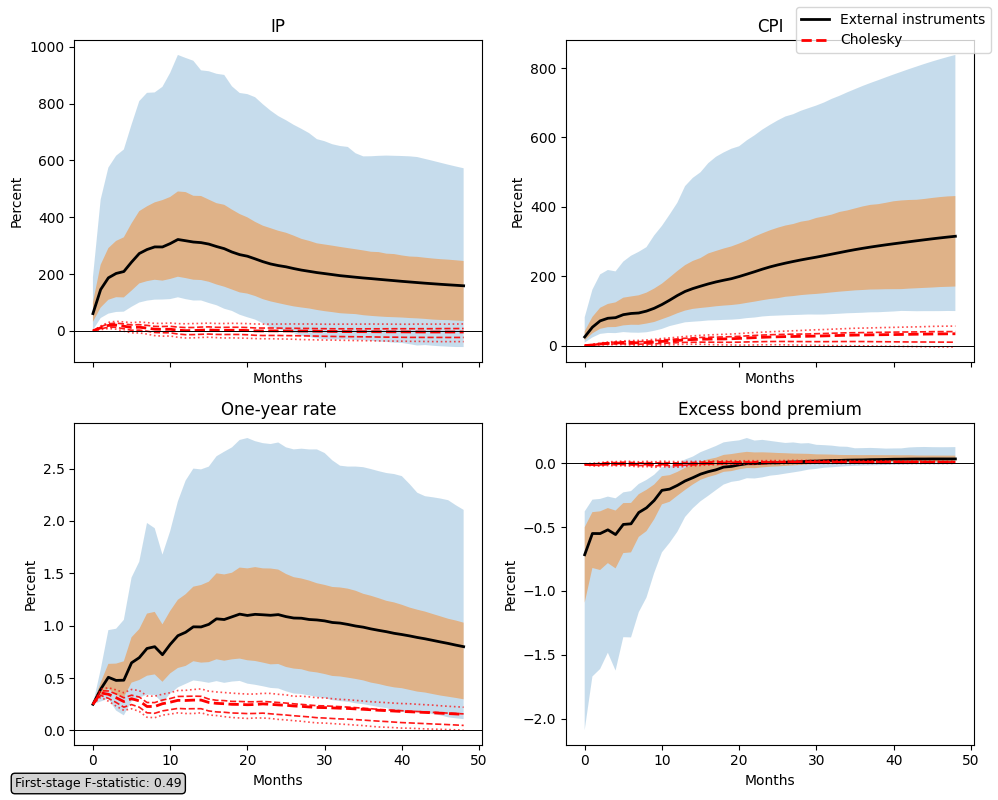

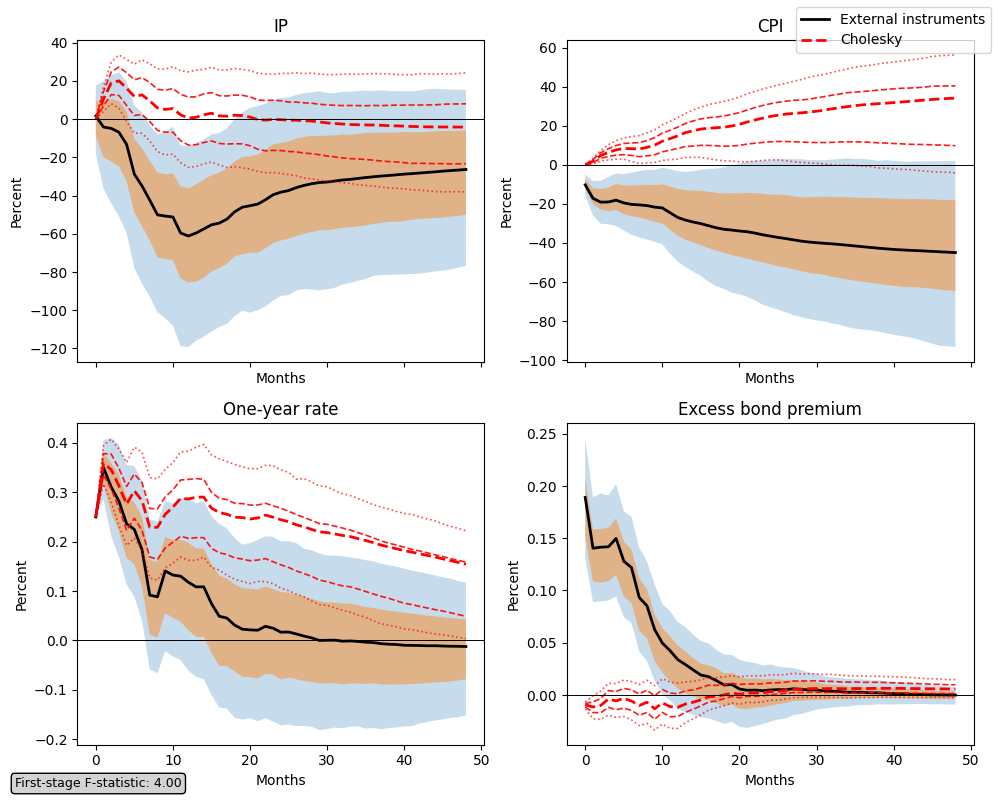

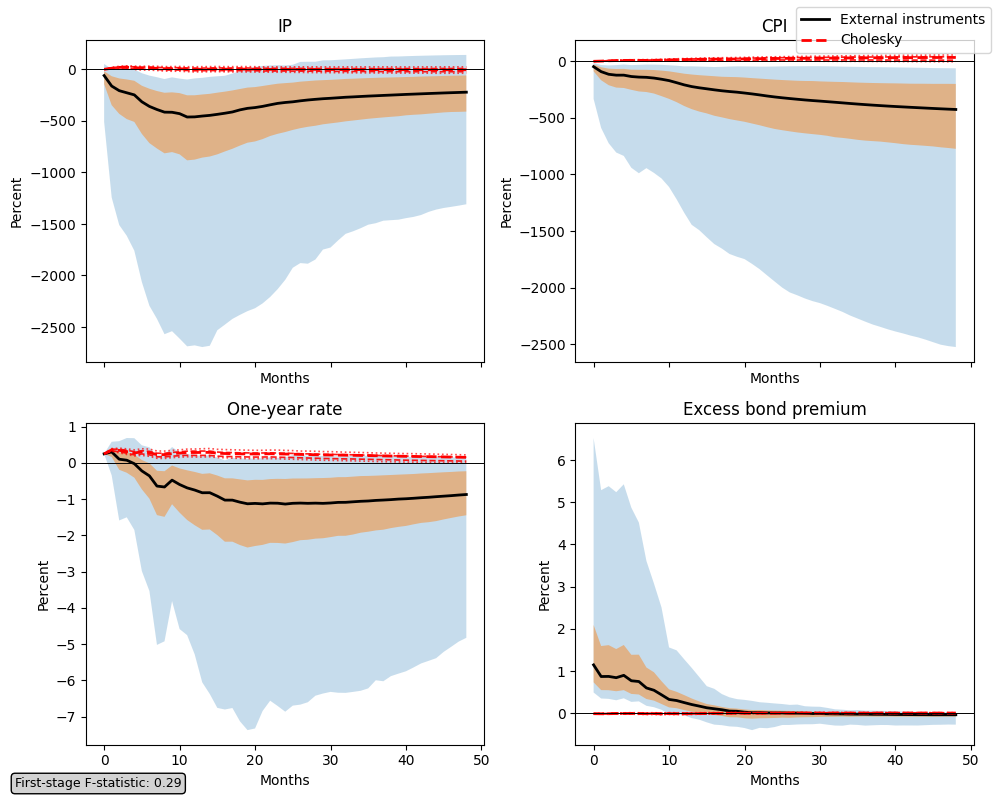

In [ ]:
shock_map = [
    ("shock_scheduled",   "IRFs – Scheduled FOMC"),
    ("shock_unscheduled", "IRFs – Unscheduled FOMC"),
    ("shock_all",         "IRFs – All FOMC"),
]

results_ext2 = {}

for col, title in shock_map:
    print(f"\n\n================ {title} =================")
    shock_series = df[col].loc[y_ext.index]

    proxy_results = rep.proxy_svar_identification(var_res_ext, shock_series)
    proxy_irfs    = rep.calculate_structural_irfs(var_res_ext, proxy_results["impact_vector"])
    proxy_irfs_b  = rep.recursive_bootstrap_proxy_svar(y_ext, shock_series, var_res_ext, n_boot=1000)

    chol_irfs     = rep.calculate_cholesky_irfs(var_res_ext)          # new helper method, or var_res_ext.irf(...).orth_irfs combined with normalisation
    chol_irfs_b   = rep.recursive_bootstrap_cholesky(y_ext, var_res_ext, n_boot=1000)

    fig = rep.plot_figure1_final(proxy_irfs, chol_irfs, proxy_irfs_b, chol_irfs_b, proxy_results)

    results_ext2[col] = {"proxy_results": proxy_results, "figure": fig}


**Comment:** by building IRFs with extended sample we can notice some important things:

* 1) For all instruments first-stage F-statistic is quite small (0.49 for scheduled FOMC, 4 for unscheduled meetings, 0.29 for all FOMC) – unscheduled meetings are still the most powerful instrument, but now it is not relevant (F-stat < 12);
* 2) We can notice that CI now are much wider;
* 3) Only for unscheduled meetings results look close to the GK findings

Extension of our sample leads to mixed results – we were not able to prove empirical robustness of GK results. This may happen because 1) full data for all variables were not available for this period (especially FOMC data for 1950-1979); 2) monetary surprises may be constructed differently; 3) we include periods with regime shifts.

### 2.3: Speeches data

In [ ]:


fed = pd.read_csv(
    "fed_speeches_1996_2020.csv",
    engine="python",
    on_bad_lines="skip"
)

def classify_role(s):
    if pd.isna(s):
        return "Other"
    s_low = str(s).lower()

    if re.search(r"vice\s+chair(man)?", s_low) or "vice chair for supervision" in s_low:
        return "Vice Chair"

    if ("chairman" in s_low or "chair" in s_low) and "vice" not in s_low:
        return "Chair"

    return "Other"

fed["role"] = fed["speaker"].apply(classify_role)

mask = fed["date"].notna()
fed.loc[mask, "date_str"] = (
    fed.loc[mask, "date"]
      .astype(int)
      .astype(str)
      .str.zfill(8)
)

fed["date_dt"] = pd.to_datetime(fed["date_str"], format="%Y%m%d", errors="coerce")

fed["year"] = fed["date_dt"].dt.year.astype("Int64")
fed["month"] = fed["date_dt"].dt.month.astype("Int64")
fed["day"] = fed["date_dt"].dt.day.astype("Int64")

#Chair / Vice Chair
fed_cv = fed[fed["role"].isin(["Chair", "Vice Chair"])].copy()
fed_cv["date"] = fed_cv["date_dt"]

print(fed_cv[["date", "year", "speaker", "role"]].head())
print(fed_cv["date"].dtype)






        date  year                     speaker        role
0 1996-12-19  1996  Vice Chair Alice M. Rivlin  Vice Chair
1 1996-12-06  1996     Chairman Alan Greenspan       Chair
2 1996-12-05  1996     Chairman Alan Greenspan       Chair
6 1996-11-18  1996     Chairman Alan Greenspan       Chair
9 1996-10-16  1996     Chairman Alan Greenspan       Chair
datetime64[ns]


In [ ]:
fed_cv

link  \
0     https://www.federalreserve.gov/boarddocs/speec...   
1     https://www.federalreserve.gov/boarddocs/speec...   
2     https://www.federalreserve.gov/boarddocs/speec...   
6     https://www.federalreserve.gov/boarddocs/speec...   
9     https://www.federalreserve.gov/boarddocs/speec...   
...                                                 ...   
1446  https://www.federalreserve.gov/newsevents/spee...   
1448  https://www.federalreserve.gov/newsevents/spee...   
1450  https://www.federalreserve.gov/newsevents/spee...   
1452  https://www.federalreserve.gov/newsevents/spee...   
1454  https://www.federalreserve.gov/newsevents/spee...   

                                                  title  \
0                       Supervision of bank risk-taking   
1                                       Social security   
2     The challenge of central banking in a democrat...   
6                     Banking in the global marketplace   
9               Technological advances and productivity   
...                                                 ...   
1446  Financial Markets and Monetary Policy: Is Ther...   
1448  Spontaneity and Order:  Transparency, Accounta...   
1450  The Economic Outlook, Monetary Policy, and the...   
1452  Spontaneity and Order: Transparency, Accountab...   
1454          U.S. Economic Outlook and Monetary Policy   

                                           speaker  \
0                       Vice Chair Alice M. Rivlin   
1                          Chairman Alan Greenspan   
2                          Chairman Alan Greenspan   
6                          Chairman Alan Greenspan   
9                          Chairman Alan Greenspan   
...                                            ...   
1446              Vice Chairman Richard H. Clarida   
1448  Vice Chair for Supervision Randal K. Quarles   
1450  Vice Chair for Supervision Randal K. Quarles   
1452  Vice Chair for Supervision Randal K. Quarles   
1454              Vice Chairman Richard H. Clarida   

                                                  event  year  \
0     At the The Brookings Institution National Issu...  1996   
1     At the Abraham Lincoln Award Ceremony of the U...  1996   
2     At the Annual Dinner and Francis Boyer Lecture...  1996   
6     At the Federation of Bankers Associations of J...  1996   
9     At the 80th Anniversary Awards Dinner of The C...  1996   
...                                                 ...   ...   
1446  At the 2020 U.S. Monetary Policy Forum, sponso...  2020   
1448     At the Yale Law School, New Haven, Connecticut  2020   
1450  At the Money Marketeers of New York University...  2020   
1452  At the American Bar Association Banking Law Co...  2020   
1454  At the C. Peter McColough Series on Internatio...  2020   

                                                   text       date  text_len  \
0     I discovered when I joined the Board of Govern... 1996-12-19      3671   
1      I am privileged to accept the Union League of... 1996-12-06      2596   
2     The Challenge of Central Banking in a Democrat... 1996-12-05      4344   
6     Banking in the Global Marketplace  It is again... 1996-11-18      5963   
9     Remarks by Chairman Alan Greenspan Technologic... 1996-10-16      1690   
...                                                 ...        ...       ...   
1446   Thank you to the conference organizers for in... 2020-02-21      2042   
1448   It's a great pleasure to be with you today at... 2020-02-11      2576   
1450   I would like to thank the organizers for the ... 2020-02-06      4182   
1452   It's a great pleasure to be with you today at... 2020-01-17      4286   
1454   Thank you for the opportunity to join you bri... 2020-01-09      1057   

          location        role  date_str    date_dt  month  day  
0             D.C.  Vice Chair  19961219 1996-12-19     12   19  
1     Pennsylvania       Chair  19961206 1996-12-06     12    6  
2             D.C.       Chair  19961205 199

## Descriptive stats

In [ ]:
desc_by_role = (
    fed_cv
    .groupby("role")
    .agg(
        n_events=("link", "count"),
        mean_text_len=("text_len", "mean"),
        median_text_len=("text_len", "median"),
        std_text_len=("text_len", "std"),
        first_year=("date", lambda x: x.min().year),
        last_year=("date", lambda x: x.max().year),
    )
)

print(desc_by_role)


            n_events  mean_text_len  median_text_len  std_text_len  \
role                                                                 
Chair            428    2874.836449           2793.0   1590.250647   
Vice Chair       291    3199.920962           3109.0   1449.020084   

            first_year  last_year  
role                               
Chair             1996       2020  
Vice Chair        1996       2020  


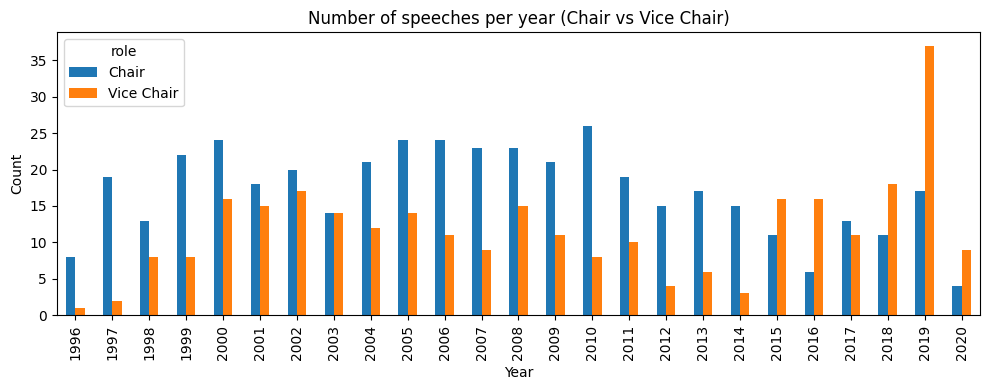

In [ ]:

events_per_year = (
    fed_cv
    .groupby(["year", "role"])
    .size()
    .unstack("role")
    .fillna(0)
)

events_per_year.plot(kind="bar", figsize=(10, 4))
plt.title("Number of speeches per year (Chair vs Vice Chair)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()




In [ ]:
fed["date"] = pd.to_datetime(fed["date_str"], format="%Y%m%d", errors="coerce")

def classify_role(s):
    if pd.isna(s):
        return "Other"
    s_low = str(s).lower()

    if re.search(r"vice\s+chair(man)?", s_low) or "vice chair for supervision" in s_low:
        return "Vice Chair"

    if ("chairman" in s_low or "chair" in s_low) and "vice" not in s_low:
        return "Chair"

    return "Other"

fed["role"] = fed["speaker"].apply(classify_role)

sp_cv = fed[fed["role"].isin(["Chair", "Vice Chair"])].copy()

print("Speeches amount (Chair/Vice):", len(sp_cv))
print("Dates:", sp_cv["date"].min(), "→", sp_cv["date"].max())
sp_cv["year"] = sp_cv["date"].dt.year
sp_cv["month"] = sp_cv["date"].dt.month

monthly_counts = (
    sp_cv
    .groupby(["year", "month", "role"])
    .size()
    .unstack("role")
    .fillna(0)
)

monthly_counts = monthly_counts.rename(
    columns={
        "Chair": "n_speeches_chair",
        "Vice Chair": "n_speeches_vice"
    }
)
monthly_counts["n_speeches_all"] = (
    monthly_counts["n_speeches_chair"] + monthly_counts["n_speeches_vice"]
)

monthly_counts = monthly_counts.reset_index()

monthly_counts["date"] = pd.to_datetime(
    dict(
        year=monthly_counts["year"],
        month=monthly_counts["month"],
        day=1
    )
)

monthly_counts = monthly_counts.set_index("date").sort_index()

print("monthly_counts shape:", monthly_counts.shape)
print("monthly_counts index sample:", monthly_counts.index[:5])
print("day of month in monthly_counts:", monthly_counts.index.day.value_counts().head())





Speeches amount (Chair/Vice): 719
Dates: 1996-06-13 00:00:00 → 2020-06-19 00:00:00
monthly_counts shape: (255, 5)
monthly_counts index sample: DatetimeIndex(['1996-06-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)
day of month in monthly_counts: date
1    255
Name: count, dtype: int64


In [ ]:
sp_cv.to_csv('speeches_frb.csv')

In [ ]:

df = df.join(
    monthly_counts[["n_speeches_chair", "n_speeches_vice", "n_speeches_all"]],
    how="left"
)

df[["n_speeches_chair", "n_speeches_vice", "n_speeches_all"]] = (
    df[["n_speeches_chair", "n_speeches_vice", "n_speeches_all"]].fillna(0)
)

def make_shock_from_count(df, src_col, tgt_col):
    if df[src_col].std() == 0 or df[src_col].sum() == 0:
        df[tgt_col] = 0.0
    else:
        df[tgt_col] = (df[src_col] - df[src_col].mean()) / df[src_col].std()

make_shock_from_count(df, "n_speeches_all",  "shock_speech_all")
make_shock_from_count(df, "n_speeches_chair","shock_speech_chair")
make_shock_from_count(df, "n_speeches_vice", "shock_speech_vice")


**Comment:** there were 719 speeches by Chair and Vice Chair from 1996 to 2020. We can notice that for almost all years Chair gave speeches more frequently, except last 6 years.

### 2.4. Replicating Figure 1 with speeches data

We know that in the baseline GK identification we rely on explicit high-frequency monetary policy surprises, i.e. market reactions around FOMC announcements. For this part of the task we do not have comparable high-frequency data for speeches. To avoid mixing identification schemes, we therefore treat the monthly number of speeches (e.g. by the Chair/Vice Chair) as a rough proxy for communication shocks and include it in the model as our instrument.

Obviously, this is a very noisy proxy and does not capture pure monetary policy surprises in the GK sense, but it allows us to explore whether variation in communication intensity is associated with systematic macroeconomic responses.

The limitations and issues we will discuss further.



================ IRFs – All speeches (Chair + Vice Chair) =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4430
  logcpi  : +0.9697
  gs1     : +1.0000
  ebp     : -1.1899

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8325
  logcpi  : +0.6474
  gs1     : +1.0000
  ebp     : -0.6459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4938
  logcpi  : +0.6462
  gs1     : +1.0000
  ebp     : -0.2290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4400
  logcpi  : +0.8018
  gs1     : +1.0000
  ebp     : -0.9902

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1612
  logcpi  : +1.2993
  gs1     : +1.0000
  ebp     : -1.1942


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4026
  logcpi  : +1.1092
  gs1     : +1.0000
  ebp     : -1.1447

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9390
  logcpi  : +0.3201
  gs1     : +1.0000
  ebp     : -0.9237

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0605
  logcpi  : +0.5767
  gs1     : +1.0000
  ebp     : -0.9781


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0529
  logcpi  : +0.7266
  gs1     : +1.0000
  ebp     : -1.0463

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1397
  logcpi  : +0.3289
  gs1     : +1.0000
  ebp     : -0.4400

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4828
  logcpi  : +0.2491
  gs1     : +1.0000
  ebp     : -1.3141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5052
  logcpi  : +0.5281
  gs1     : +1.0000
  ebp     : -0.6802

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8579
  logcpi  : +0.6713
  gs1     : +1.0000
  ebp     : -1.3826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.40
  R^2: 0.16%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3517
  logcpi  : +0.3093
  gs1     : +1.0000
  ebp     : -0.7746


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1308
  logcpi  : +5.1030
  gs1     : +1.0000
  ebp     : -4.7066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7257
  logcpi  : +0.9343
  gs1     : +1.0000
  ebp     : -1.1629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5613
  logcpi  : +1.3415
  gs1     : +1.0000
  ebp     : -2.9914


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8141
  logcpi  : +1.6323
  gs1     : +1.0000
  ebp     : -1.3528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7049
  logcpi  : +0.2576
  gs1     : +1.0000
  ebp     : -0.6316

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8057
  logcpi  : +0.9066
  gs1     : +1.0000
  ebp     : -0.7931


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2680
  logcpi  : +0.8823
  gs1     : +1.0000
  ebp     : -0.9395

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5775
  logcpi  : +0.3004
  gs1     : +1.0000
  ebp     : -0.7019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2321
  logcpi  : +1.2891
  gs1     : +1.0000
  ebp     : -2.1021


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7543
  logcpi  : +0.7018
  gs1     : +1.0000
  ebp     : -1.1519

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8885
  logcpi  : +0.9094
  gs1     : +1.0000
  ebp     : -1.3611

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6837
  logcpi  : +0.9137
  gs1     : +1.0000
  ebp     : -1.1475


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4762
  logcpi  : +0.7473
  gs1     : +1.0000
  ebp     : -1.6129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3986
  logcpi  : +1.0444
  gs1     : +1.0000
  ebp     : -1.6441


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6767
  logcpi  : +0.7923
  gs1     : +1.0000
  ebp     : -1.0611

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4419
  logcpi  : +1.1360
  gs1     : +1.0000
  ebp     : -1.2228

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5592
  logcpi  : +0.9857
  gs1     : +1.0000
  ebp     : -1.1800


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2366
  logcpi  : +1.3414
  gs1     : +1.0000
  ebp     : -2.0489

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6252
  logcpi  : +1.2624
  gs1     : +1.0000
  ebp     : -1.1245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4247
  logcpi  : +0.7868
  gs1     : +1.0000
  ebp     : -1.0646


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5899
  logcpi  : +1.2397
  gs1     : +1.0000
  ebp     : -0.9020

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9043
  logcpi  : +0.9013
  gs1     : +1.0000
  ebp     : -1.0067

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0327
  logcpi  : +0.9798
  gs1     : +1.0000
  ebp     : -1.5525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7322
  logcpi  : +0.9854
  gs1     : +1.0000
  ebp     : -0.8312

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9018
  logcpi  : +0.5135
  gs1     : +1.0000
  ebp     : -0.9584

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3332
  logcpi  : +3.9742
  gs1     : +1.0000
  ebp     : -4.5798


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8988
  logcpi  : +1.6805
  gs1     : +1.0000
  ebp     : -2.4756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4670
  logcpi  : +0.7353
  gs1     : +1.0000
  ebp     : -1.2272


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2301
  logcpi  : +1.2664
  gs1     : +1.0000
  ebp     : -1.4040

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9530
  logcpi  : +0.9333
  gs1     : +1.0000
  ebp     : -1.3889

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1106
  logcpi  : +0.7478
  gs1     : +1.0000
  ebp     : -0.7824


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7713
  logcpi  : +1.0282
  gs1     : +1.0000
  ebp     : -0.8647

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5150
  logcpi  : +0.5887
  gs1     : +1.0000
  ebp     : -1.1489

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4025
  logcpi  : +0.8556
  gs1     : +1.0000
  ebp     : -1.3660


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9254
  logcpi  : +1.2154
  gs1     : +1.0000
  ebp     : -1.1481

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1227
  logcpi  : +1.5482
  gs1     : +1.0000
  ebp     : -0.9706

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1915
  logcpi  : +1.1422
  gs1     : +1.0000
  ebp     : -1.3649


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0765
  logcpi  : +0.1911
  gs1     : +1.0000
  ebp     : -0.8629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1433
  logcpi  : +4.3611
  gs1     : +1.0000
  ebp     : -5.7199

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6949
  logcpi  : +1.2592
  gs1     : +1.0000
  ebp     : -1.0747

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0873
  logcpi  : +0.7466
  gs1     : +1.0000
  ebp     : -0.7541

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9587
  logcpi  : +2.6144
  gs1     : +1.0000
  ebp     : -3.2037

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.89
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0142

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8314
  logcpi  : +0.7580
  gs1     : +1.0000
  ebp     : -0.5940


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4842
  logcpi  : +0.6869
  gs1     : +1.0000
  ebp     : -0.9985

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7241
  logcpi  : +1.0645
  gs1     : +1.0000
  ebp     : -1.5672

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0389
  logcpi  : +1.0462
  gs1     : +1.0000
  ebp     : -0.8970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.32
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0118

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2863
  logcpi  : +0.4114
  gs1     : +1.0000
  ebp     : -0.8298

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5756
  logcpi  : +0.7850
  gs1     : +1.0000
  ebp     : -0.9091

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8053
  logcpi  : +0.5543
  gs1     : +1.0000
  ebp     : -1.0541


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3957
  logcpi  : +0.6954
  gs1     : +1.0000
  ebp     : -1.2290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0769
  logcpi  : +1.0006
  gs1     : +1.0000
  ebp     : -1.1785

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.28
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0116

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2988
  logcpi  : +0.5689
  gs1     : +1.0000
  ebp     : -0.7518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3651
  logcpi  : +0.8513
  gs1     : +1.0000
  ebp     : -0.8247


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4524
  logcpi  : +0.8495
  gs1     : +1.0000
  ebp     : -1.2283


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8109
  logcpi  : +1.6088
  gs1     : +1.0000
  ebp     : -1.3141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3024
  logcpi  : +0.9358
  gs1     : +1.0000
  ebp     : -0.9761

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5625
  logcpi  : +0.5542
  gs1     : +1.0000
  ebp     : -0.6132


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2457
  logcpi  : +1.4762
  gs1     : +1.0000
  ebp     : -1.1294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4025
  logcpi  : +0.8088
  gs1     : +1.0000
  ebp     : -1.1386

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7357
  logcpi  : +0.2113
  gs1     : +1.0000
  ebp     : -1.7671


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0607
  logcpi  : +0.4681
  gs1     : +1.0000
  ebp     : -1.1697


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3115
  logcpi  : +0.8127
  gs1     : +1.0000
  ebp     : -1.1206

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2415
  logcpi  : +0.5231
  gs1     : +1.0000
  ebp     : -0.8738


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2809
  logcpi  : +0.3263
  gs1     : +1.0000
  ebp     : -0.6189

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9610
  logcpi  : +0.3857
  gs1     : +1.0000
  ebp     : -1.1862


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2924
  logcpi  : +0.7858
  gs1     : +1.0000
  ebp     : -0.6762

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5226
  logcpi  : +0.6368
  gs1     : +1.0000
  ebp     : -0.7599


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3765
  logcpi  : +1.0281
  gs1     : +1.0000
  ebp     : -1.6035

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1875
  logcpi  : +0.5995
  gs1     : +1.0000
  ebp     : -0.8057


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7024
  logcpi  : +2.0231
  gs1     : +1.0000
  ebp     : -1.0425

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8919
  logcpi  : +0.8171
  gs1     : +1.0000
  ebp     : -1.5629


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0292
  logcpi  : +1.0353
  gs1     : +1.0000
  ebp     : -2.6862

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6821
  logcpi  : +1.4061
  gs1     : +1.0000
  ebp     : -1.5587

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.4401
  logcpi  : +27.1578
  gs1     : +1.0000
  ebp     : -29.6147

=== Proxy-SVAR Identification ===
Commo

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0113

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0013
  logcpi  : +0.4578
  gs1     : +1.0000
  ebp     : -0.5728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8555
  logcpi  : +2.9481
  gs1     : +1.0000
  ebp     : -2.6196

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9800
  logcpi  : +0.9525
  gs1     : +1.0000
  ebp     : -1.2538


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.28
  R^2: 0.25%, adj. R^2: 0.14%
  Instrument coefficient (beta_1): -0.0153

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3627
  logcpi  : +0.3347
  gs1     : +1.0000
  ebp     : -0.6178

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7297
  logcpi  : +0.6772
  gs1     : +1.0000
  ebp     : -0.6062

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3006
  logcpi  : +0.6664
  gs1     : +1.0000
  ebp     : -0.4336


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5534
  logcpi  : +1.4648
  gs1     : +1.0000
  ebp     : -2.6118

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3214
  logcpi  : +0.7271
  gs1     : +1.0000
  ebp     : -0.4753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1373
  logcpi  : +1.7244
  gs1     : +1.0000
  ebp     : -1.3612

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -67.1838
  logcpi  : +22.6592
  gs1     : +1.0000
  ebp     : -64.2477

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6828
  logcpi  : +1.1184
  gs1     : +1.0000
  ebp     : -0.8889


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1880
  logcpi  : +0.5048
  gs1     : +1.0000
  ebp     : -0.7220

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4795
  logcpi  : +2.3823
  gs1     : +1.0000
  ebp     : -3.9486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6298
  logcpi  : +1.1494
  gs1     : +1.0000
  ebp     : -1.3316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6127
  logcpi  : +2.4630
  gs1     : +1.0000
  ebp     : -1.7155

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7164
  logcpi  : +0.3009
  gs1     : +1.0000
  ebp     : -1.0018

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2062
  logcpi  : +1.0800
  gs1     : +1.0000
  ebp     : -0.7552


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0474
  logcpi  : +1.0704
  gs1     : +1.0000
  ebp     : -0.9084

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2522
  logcpi  : +0.5267
  gs1     : +1.0000
  ebp     : -1.0598

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3544
  logcpi  : +0.9724
  gs1     : +1.0000
  ebp     : -0.9708


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5485
  logcpi  : +1.7461
  gs1     : +1.0000
  ebp     : -3.2647

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5538
  logcpi  : +0.4788
  gs1     : +1.0000
  ebp     : -1.1175

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8763
  logcpi  : +1.3627
  gs1     : +1.0000
  ebp     : -2.1226


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0301
  logcpi  : +0.5906
  gs1     : +1.0000
  ebp     : -0.9694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -57.3233
  logcpi  : -102.7588
  gs1     : +1.0000
  ebp     : +130.1845

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3135
  logcpi  : +1.1034
  gs1     : +1.0000
  ebp     : -1.7337


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3782
  logcpi  : +0.2386
  gs1     : +1.0000
  ebp     : -0.4632

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3841
  logcpi  : +0.6882
  gs1     : +1.0000
  ebp     : -0.6136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3219
  logcpi  : +1.5065
  gs1     : +1.0000
  ebp     : -1.5799


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3304
  logcpi  : +2.3566
  gs1     : +1.0000
  ebp     : -1.8791

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3827
  logcpi  : +1.7681
  gs1     : +1.0000
  ebp     : -1.2592

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7874
  logcpi  : +0.2435
  gs1     : +1.0000
  ebp     : -0.7394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0702
  logcpi  : +0.9031
  gs1     : +1.0000
  ebp     : -1.2766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2791
  logcpi  : +0.8967
  gs1     : +1.0000
  ebp     : -1.2503

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3213
  logcpi  : +0.4638
  gs1     : +1.0000
  ebp     : -1.5117


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4819
  logcpi  : +1.5832
  gs1     : +1.0000
  ebp     : -1.0293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2578
  logcpi  : +0.7432
  gs1     : +1.0000
  ebp     : -1.4854


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6501
  logcpi  : +0.9260
  gs1     : +1.0000
  ebp     : -0.9986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0075
  logcpi  : +1.1631
  gs1     : +1.0000
  ebp     : -1.1953


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.83
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0137

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6427
  logcpi  : +0.3760
  gs1     : +1.0000
  ebp     : -0.5814

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1968
  logcpi  : +0.7817
  gs1     : +1.0000
  ebp     : -1.3316

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1803
  logcpi  : +0.5687
  gs1     : +1.0000
  ebp     : -0.9834

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9871
  logcpi  : +2.3754
  gs1     : +1.0000
  ebp     : -1.6307

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1208
  logcpi  : +0.2519
  gs1     : +1.0000
  ebp     : -0.7524

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3476
  logcpi  : +0.2730
  gs1     : +1.0000
  ebp     : -2.1644


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1316
  logcpi  : +0.3682
  gs1     : +1.0000
  ebp     : -1.3507

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0237
  logcpi  : +0.7523
  gs1     : +1.0000
  ebp     : -1.5692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2336
  logcpi  : +0.4827
  gs1     : +1.0000
  ebp     : -1.3815


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3089
  logcpi  : +0.2566
  gs1     : +1.0000
  ebp     : -0.7707

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2209
  logcpi  : +1.8060
  gs1     : +1.0000
  ebp     : -3.5341

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1458
  logcpi  : +0.7925
  gs1     : +1.0000
  ebp     : -0.9220


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7808
  logcpi  : +0.9328
  gs1     : +1.0000
  ebp     : -0.8209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2542
  logcpi  : +0.6488
  gs1     : +1.0000
  ebp     : -1.3252


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7653
  logcpi  : +0.5794
  gs1     : +1.0000
  ebp     : -1.0051

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3318
  logcpi  : +0.7497
  gs1     : +1.0000
  ebp     : -0.8400

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0708
  logcpi  : +1.0325
  gs1     : +1.0000
  ebp     : -1.0487


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8577
  logcpi  : +0.8507
  gs1     : +1.0000
  ebp     : -0.7958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4963
  logcpi  : +2.1157
  gs1     : +1.0000
  ebp     : -1.9631


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1001
  logcpi  : +0.3238
  gs1     : +1.0000
  ebp     : -1.2833

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9610
  logcpi  : +1.2277
  gs1     : +1.0000
  ebp     : -2.0647

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1086
  logcpi  : +0.6667
  gs1     : +1.0000
  ebp     : -0.9115


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0213
  logcpi  : +1.1943
  gs1     : +1.0000
  ebp     : -2.1117

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8380
  logcpi  : +0.7472
  gs1     : +1.0000
  ebp     : -0.9960

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2887
  logcpi  : +1.6773
  gs1     : +1.0000
  ebp     : -3.9737


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5717
  logcpi  : +0.8709
  gs1     : +1.0000
  ebp     : -1.2072

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7046
  logcpi  : +0.8633
  gs1     : +1.0000
  ebp     : -1.2921

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -24.2470
  logcpi  : +6.7860
  gs1     : +1.0000
  ebp     : -10.5133


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2056
  logcpi  : +1.1530
  gs1     : +1.0000
  ebp     : -1.8114

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0949
  logcpi  : +0.7917
  gs1     : +1.0000
  ebp     : -0.9195

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6321
  logcpi  : +0.9247
  gs1     : +1.0000
  ebp     : -0.7755


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3975
  logcpi  : +0.5168
  gs1     : +1.0000
  ebp     : -0.9379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.53
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5634
  logcpi  : +0.3349
  gs1     : +1.0000
  ebp     : -0.5578

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6002
  logcpi  : +1.0360
  gs1     : +1.0000
  ebp     : -1.5409


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5644
  logcpi  : +0.4266
  gs1     : +1.0000
  ebp     : -0.4542

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0162
  logcpi  : +1.0184
  gs1     : +1.0000
  ebp     : -2.0558

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8109
  logcpi  : +0.9534
  gs1     : +1.0000
  ebp     : -2.4516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7083
  logcpi  : +0.4029
  gs1     : +1.0000
  ebp     : -1.3578

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0164
  logcpi  : +0.7779
  gs1     : +1.0000
  ebp     : -1.0468

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4799
  logcpi  : +1.3361
  gs1     : +1.0000
  ebp     : -1.7995


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1427
  logcpi  : +0.4376
  gs1     : +1.0000
  ebp     : -0.5622

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3985
  logcpi  : +0.9703
  gs1     : +1.0000
  ebp     : -1.4704

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4480
  logcpi  : +0.8662
  gs1     : +1.0000
  ebp     : -0.9577


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3508
  logcpi  : +1.5125
  gs1     : +1.0000
  ebp     : -1.7394

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5658
  logcpi  : +0.9323
  gs1     : +1.0000
  ebp     : -1.2755


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2066
  logcpi  : +0.5068
  gs1     : +1.0000
  ebp     : -0.5901

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2501
  logcpi  : +1.7469
  gs1     : +1.0000
  ebp     : -1.9105

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5456
  logcpi  : +0.9481
  gs1     : +1.0000
  ebp     : -1.1568


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4397
  logcpi  : +0.6394
  gs1     : +1.0000
  ebp     : -0.8763

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3776
  logcpi  : +1.5081
  gs1     : +1.0000
  ebp     : -1.8815

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5525
  logcpi  : +0.6114
  gs1     : +1.0000
  ebp     : -0.8624


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1911
  logcpi  : +0.5163
  gs1     : +1.0000
  ebp     : -0.8648

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3596
  logcpi  : +0.8820
  gs1     : +1.0000
  ebp     : -0.9913

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.36
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6311
  logcpi  : +0.5852
  gs1     : +1.0000
  ebp     : -0.8339


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2637
  logcpi  : +0.6553
  gs1     : +1.0000
  ebp     : -0.9805

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9921
  logcpi  : +0.8942
  gs1     : +1.0000
  ebp     : -0.9815

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6824
  logcpi  : +2.0586
  gs1     : +1.0000
  ebp     : -4.1915

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2270
  logcpi  : +0.6410
  gs1     : +1.0000
  ebp     : -0.9986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.32
  R^2: 0.26%, adj. R^2: 0.15%
  Instrument coefficient (beta_1): -0.0154

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1690
  logcpi  : +0.2741
  gs1     : +1.0000
  ebp     : -0.4192

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5808
  logcpi  : +0.6930
  gs1     : +1.0000
  ebp     : -1.2222


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9509
  logcpi  : +1.4738
  gs1     : +1.0000
  ebp     : -1.4563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7934
  logcpi  : +6.9673
  gs1     : +1.0000
  ebp     : -11.2121

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5003
  logcpi  : +0.8187
  gs1     : +1.0000
  ebp     : -0.8721


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0502
  logcpi  : +0.7119
  gs1     : +1.0000
  ebp     : -1.9914

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.80
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4500
  logcpi  : +0.4417
  gs1     : +1.0000
  ebp     : -0.7018


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0376
  logcpi  : +2.6353
  gs1     : +1.0000
  ebp     : -2.3349

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6168
  logcpi  : +0.7614
  gs1     : +1.0000
  ebp     : -0.7250


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5254
  logcpi  : +0.7205
  gs1     : +1.0000
  ebp     : -0.9172

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1399
  logcpi  : +0.7202
  gs1     : +1.0000
  ebp     : -0.8643


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5766
  logcpi  : +0.7054
  gs1     : +1.0000
  ebp     : -1.4213

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8668
  logcpi  : +1.7159
  gs1     : +1.0000
  ebp     : -1.1606


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0349
  logcpi  : +0.4293
  gs1     : +1.0000
  ebp     : -0.6131


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0119
  logcpi  : +0.7994
  gs1     : +1.0000
  ebp     : -1.9668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0095
  logcpi  : +1.0498
  gs1     : +1.0000
  ebp     : -0.7381


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3713
  logcpi  : +1.1156
  gs1     : +1.0000
  ebp     : -0.8796


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1326
  logcpi  : +0.8679
  gs1     : +1.0000
  ebp     : -1.4934


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1961
  logcpi  : +0.7437
  gs1     : +1.0000
  ebp     : -0.8194


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0096
  logcpi  : +1.0375
  gs1     : +1.0000
  ebp     : -1.4806


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4661
  logcpi  : +0.2740
  gs1     : +1.0000
  ebp     : -0.6608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4917
  logcpi  : +2.1371
  gs1     : +1.0000
  ebp     : -1.3600

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2440
  logcpi  : +0.7624
  gs1     : +1.0000
  ebp     : -0.8127


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7164
  logcpi  : +0.6499
  gs1     : +1.0000
  ebp     : -1.7486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1511
  logcpi  : +0.5749
  gs1     : +1.0000
  ebp     : -0.9012

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3047
  logcpi  : +0.9683
  gs1     : +1.0000
  ebp     : -0.8185


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1698
  logcpi  : +0.3754
  gs1     : +1.0000
  ebp     : -1.0873

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1424
  logcpi  : +1.0617
  gs1     : +1.0000
  ebp     : -1.2360

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9867
  logcpi  : +2.3901
  gs1     : +1.0000
  ebp     : -2.9553


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3439
  logcpi  : +0.7017
  gs1     : +1.0000
  ebp     : -0.9707

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1178
  logcpi  : +0.6247
  gs1     : +1.0000
  ebp     : -1.2501

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4007
  logcpi  : +0.8659
  gs1     : +1.0000
  ebp     : -1.5113


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6633
  logcpi  : +0.8380
  gs1     : +1.0000
  ebp     : -1.2676

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3085
  logcpi  : +0.2597
  gs1     : +1.0000
  ebp     : -0.8847


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3788
  logcpi  : +0.9575
  gs1     : +1.0000
  ebp     : -0.8406

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5739
  logcpi  : +0.5303
  gs1     : +1.0000
  ebp     : -1.0727

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4612
  logcpi  : +0.8616
  gs1     : +1.0000
  ebp     : -0.9741


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2091
  logcpi  : +0.4924
  gs1     : +1.0000
  ebp     : -0.6669

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9987
  logcpi  : +0.8483
  gs1     : +1.0000
  ebp     : -1.9101

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8946
  logcpi  : +0.4413
  gs1     : +1.0000
  ebp     : -1.1850


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6999
  logcpi  : +1.2562
  gs1     : +1.0000
  ebp     : -0.9753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4210
  logcpi  : +0.9642
  gs1     : +1.0000
  ebp     : -1.0498

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7387
  logcpi  : +0.7833
  gs1     : +1.0000
  ebp     : -0.6513


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4097
  logcpi  : +1.5304
  gs1     : +1.0000
  ebp     : -1.8085

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3090
  logcpi  : +0.1805
  gs1     : +1.0000
  ebp     : -1.4319

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0403
  logcpi  : +2.0713
  gs1     : +1.0000
  ebp     : -1.8307


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0038
  logcpi  : +0.7496
  gs1     : +1.0000
  ebp     : -0.9165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0191
  logcpi  : +0.9799
  gs1     : +1.0000
  ebp     : -1.2539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9070
  logcpi  : +0.8116
  gs1     : +1.0000
  ebp     : -0.7826


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9843
  logcpi  : +1.3666
  gs1     : +1.0000
  ebp     : -0.8043

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0985
  logcpi  : +0.9435
  gs1     : +1.0000
  ebp     : -0.6097

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8302
  logcpi  : +2.3658
  gs1     : +1.0000
  ebp     : -1.9745


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1388
  logcpi  : +0.5074
  gs1     : +1.0000
  ebp     : -0.8041

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0452
  logcpi  : +0.3273
  gs1     : +1.0000
  ebp     : -0.5824

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8089
  logcpi  : +1.2214
  gs1     : +1.0000
  ebp     : -1.7741


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0149
  logcpi  : +1.5240
  gs1     : +1.0000
  ebp     : -1.5220

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9561
  logcpi  : +0.9189
  gs1     : +1.0000
  ebp     : -1.6192

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8850
  logcpi  : +0.5252
  gs1     : +1.0000
  ebp     : -0.5651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0663
  logcpi  : +0.8797
  gs1     : +1.0000
  ebp     : -0.9349

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0113

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0380
  logcpi  : +0.6292
  gs1     : +1.0000
  ebp     : -0.5443


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3483
  logcpi  : +0.5994
  gs1     : +1.0000
  ebp     : -0.9639

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1884
  logcpi  : +1.3771
  gs1     : +1.0000
  ebp     : -0.6624


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2129
  logcpi  : +1.5314
  gs1     : +1.0000
  ebp     : -1.8878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5723
  logcpi  : +1.7713
  gs1     : +1.0000
  ebp     : -1.3616

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4266
  logcpi  : +1.0772
  gs1     : +1.0000
  ebp     : -1.0233


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5367
  logcpi  : +0.8275
  gs1     : +1.0000
  ebp     : -1.4885

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7851
  logcpi  : +1.4503
  gs1     : +1.0000
  ebp     : -1.3587

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3834
  logcpi  : +0.6267
  gs1     : +1.0000
  ebp     : -0.6885


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3048
  logcpi  : +0.7372
  gs1     : +1.0000
  ebp     : -1.4183

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5820
  logcpi  : +1.3636
  gs1     : +1.0000
  ebp     : -2.0379

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3920
  logcpi  : +2.0678
  gs1     : +1.0000
  ebp     : -2.2716

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2161
  logcpi  : +0.3100
  gs1     : +1.0000
  ebp     : -1.1608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5293
  logcpi  : +1.1648
  gs1     : +1.0000
  ebp     : -1.2345


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1133
  logcpi  : +0.7831
  gs1     : +1.0000
  ebp     : -1.1071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7647
  logcpi  : +0.4406
  gs1     : +1.0000
  ebp     : -1.3343

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4702
  logcpi  : +0.7637
  gs1     : +1.0000
  ebp     : -0.6900


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9439
  logcpi  : +1.0952
  gs1     : +1.0000
  ebp     : -2.6214

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2428
  logcpi  : +0.0968
  gs1     : +1.0000
  ebp     : -0.6417

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1700
  logcpi  : +1.4336
  gs1     : +1.0000
  ebp     : -0.9954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6640
  logcpi  : +1.1500
  gs1     : +1.0000
  ebp     : -1.0731

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9794
  logcpi  : +2.8586
  gs1     : +1.0000
  ebp     : -5.2539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9278
  logcpi  : +0.7376
  gs1     : +1.0000
  ebp     : -0.9088


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9099
  logcpi  : +1.0462
  gs1     : +1.0000
  ebp     : -1.5128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6523
  logcpi  : +1.0142
  gs1     : +1.0000
  ebp     : -1.4743

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4699
  logcpi  : +0.5685
  gs1     : +1.0000
  ebp     : -1.1740


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2353
  logcpi  : +0.8107
  gs1     : +1.0000
  ebp     : -0.9864

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1719
  logcpi  : +1.3739
  gs1     : +1.0000
  ebp     : -1.3797

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5624
  logcpi  : +5.1997
  gs1     : +1.0000
  ebp     : -3.9868


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9469
  logcpi  : +1.0585
  gs1     : +1.0000
  ebp     : -2.5490

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0030
  logcpi  : +1.7418
  gs1     : +1.0000
  ebp     : -1.6088

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.52
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2473
  logcpi  : +0.5284
  gs1     : +1.0000
  ebp     : -0.4986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1095
  logcpi  : +3.8855
  gs1     : +1.0000
  ebp     : -17.0314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2295
  logcpi  : +1.2041
  gs1     : +1.0000
  ebp     : -1.2784

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6352
  logcpi  : +0.6101
  gs1     : +1.0000
  ebp     : -0.6471

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1741
  logcpi  : +0.9337
  gs1     : +1.0000
  ebp     : -3.3405

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8520
  logcpi  : +0.3605
  gs1     : +1.0000
  ebp     : -0.5129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0237
  logcpi  : +0.8886
  gs1     : +1.0000
  ebp     : -1.1641


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4205
  logcpi  : +0.7544
  gs1     : +1.0000
  ebp     : -0.9117

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3310
  logcpi  : +1.1774
  gs1     : +1.0000
  ebp     : -1.0336

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6881
  logcpi  : +2.8340
  gs1     : +1.0000
  ebp     : -2.5291


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6967
  logcpi  : +1.2088
  gs1     : +1.0000
  ebp     : -1.3185

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7145
  logcpi  : +3.2931
  gs1     : +1.0000
  ebp     : -3.1173

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8471
  logcpi  : +0.7634
  gs1     : +1.0000
  ebp     : -1.2561


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3079
  logcpi  : +0.6752
  gs1     : +1.0000
  ebp     : -0.5965

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1582
  logcpi  : +0.9908
  gs1     : +1.0000
  ebp     : -0.6580

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6739
  logcpi  : +0.3148
  gs1     : +1.0000
  ebp     : -0.6390


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8840
  logcpi  : +0.4783
  gs1     : +1.0000
  ebp     : -0.7435

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1184
  logcpi  : +0.8404
  gs1     : +1.0000
  ebp     : -0.8371

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2114
  logcpi  : +0.6363
  gs1     : +1.0000
  ebp     : -0.8949


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4158
  logcpi  : +0.7043
  gs1     : +1.0000
  ebp     : -0.7695

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4904
  logcpi  : +1.1685
  gs1     : +1.0000
  ebp     : -1.1747

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2229
  logcpi  : +1.1997
  gs1     : +1.0000
  ebp     : -1.8312


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.60
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0821
  logcpi  : +0.5413
  gs1     : +1.0000
  ebp     : -0.8243

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4866
  logcpi  : +0.3939
  gs1     : +1.0000
  ebp     : -0.9010

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0498
  logcpi  : +0.6593
  gs1     : +1.0000
  ebp     : -1.5046


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1079
  logcpi  : +1.5229
  gs1     : +1.0000
  ebp     : -1.8518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4497
  logcpi  : +1.5357
  gs1     : +1.0000
  ebp     : -1.2517

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2826
  logcpi  : +1.2130
  gs1     : +1.0000
  ebp     : -1.5566


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7262
  logcpi  : +0.1803
  gs1     : +1.0000
  ebp     : -0.7409

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3427
  logcpi  : +0.6284
  gs1     : +1.0000
  ebp     : -1.5315

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0528
  logcpi  : +1.6390
  gs1     : +1.0000
  ebp     : -1.1222


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7583
  logcpi  : +0.5584
  gs1     : +1.0000
  ebp     : -0.8163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0484
  logcpi  : +0.7834
  gs1     : +1.0000
  ebp     : -0.7538

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3971
  logcpi  : +1.1112
  gs1     : +1.0000
  ebp     : -1.1214


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8606
  logcpi  : +0.9432
  gs1     : +1.0000
  ebp     : -1.1011

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8257
  logcpi  : +0.5317
  gs1     : +1.0000
  ebp     : -1.6418

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9791
  logcpi  : +0.7778
  gs1     : +1.0000
  ebp     : -1.3574


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1416
  logcpi  : +1.2417
  gs1     : +1.0000
  ebp     : -1.3288

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3418
  logcpi  : +0.5451
  gs1     : +1.0000
  ebp     : -0.8851

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7982
  logcpi  : +1.1132
  gs1     : +1.0000
  ebp     : -1.0227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1535
  logcpi  : +0.8209
  gs1     : +1.0000
  ebp     : -0.9995

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2304
  logcpi  : +1.1330
  gs1     : +1.0000
  ebp     : -1.6975


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8347
  logcpi  : +2.1583
  gs1     : +1.0000
  ebp     : -1.7327

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3878
  logcpi  : +0.9502
  gs1     : +1.0000
  ebp     : -1.0788


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7476
  logcpi  : +0.7281
  gs1     : +1.0000
  ebp     : -1.6274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.52
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5869
  logcpi  : +0.6225
  gs1     : +1.0000
  ebp     : -0.5757


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4968
  logcpi  : +1.3674
  gs1     : +1.0000
  ebp     : -1.3497


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1614
  logcpi  : +0.8878
  gs1     : +1.0000
  ebp     : -0.8505


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9716
  logcpi  : +1.7935
  gs1     : +1.0000
  ebp     : -2.0964


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3624
  logcpi  : +0.6805
  gs1     : +1.0000
  ebp     : -1.0086


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0656
  logcpi  : +0.6974
  gs1     : +1.0000
  ebp     : -1.0847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9868
  logcpi  : +0.8539
  gs1     : +1.0000
  ebp     : -1.3824


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8963
  logcpi  : +0.6837
  gs1     : +1.0000
  ebp     : -1.3947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3302
  logcpi  : +1.0562
  gs1     : +1.0000
  ebp     : -1.0416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3605
  logcpi  : +3.8658
  gs1     : +1.0000
  ebp     : -2.1349

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5043
  logcpi  : +4.2910
  gs1     : +1.0000
  ebp     : -4.5602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4188
  logcpi  : +0.4742
  gs1     : +1.0000
  ebp     : -1.0264


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4833
  logcpi  : +0.5031
  gs1     : +1.0000
  ebp     : -0.6128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.42
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0120

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0572
  logcpi  : +0.7036
  gs1     : +1.0000
  ebp     : -0.6855


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.02
  R^2: 0.23%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.0146

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8896
  logcpi  : +0.3218
  gs1     : +1.0000
  ebp     : -0.3986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9661
  logcpi  : +1.1480
  gs1     : +1.0000
  ebp     : -1.0332


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3073
  logcpi  : +1.4708
  gs1     : +1.0000
  ebp     : -1.5476


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.4251
  logcpi  : +7.1689
  gs1     : +1.0000
  ebp     : -13.0993


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4237
  logcpi  : +0.6394
  gs1     : +1.0000
  ebp     : -1.0459


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9839
  logcpi  : +0.3762
  gs1     : +1.0000
  ebp     : -1.8730


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6036
  logcpi  : +1.5762
  gs1     : +1.0000
  ebp     : -0.9209


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7859
  logcpi  : +1.5819
  gs1     : +1.0000
  ebp     : -1.8785

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5742
  logcpi  : +0.8559
  gs1     : +1.0000
  ebp     : -0.8415


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3910
  logcpi  : +0.1584
  gs1     : +1.0000
  ebp     : -0.7187

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8516
  logcpi  : +0.9661
  gs1     : +1.0000
  ebp     : -1.0614

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7393
  logcpi  : +0.9943
  gs1     : +1.0000
  ebp     : -1.4187


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5095
  logcpi  : +2.0297
  gs1     : +1.0000
  ebp     : -3.0830

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5733
  logcpi  : +0.5025
  gs1     : +1.0000
  ebp     : -0.7919

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7243
  logcpi  : +0.2124
  gs1     : +1.0000
  ebp     : -0.8538


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9893
  logcpi  : +1.2368
  gs1     : +1.0000
  ebp     : -1.5028

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4719
  logcpi  : +0.5359
  gs1     : +1.0000
  ebp     : -2.1410

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2891
  logcpi  : +0.5356
  gs1     : +1.0000
  ebp     : -0.8931


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3313
  logcpi  : +1.9488
  gs1     : +1.0000
  ebp     : -3.9966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4321
  logcpi  : +1.3130
  gs1     : +1.0000
  ebp     : -1.3497

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.8637
  logcpi  : +1.3536
  gs1     : +1.0000
  ebp     : -2.4226


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.8765
  logcpi  : +2.4789
  gs1     : +1.0000
  ebp     : -6.5928

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1403
  logcpi  : +0.8627
  gs1     : +1.0000
  ebp     : -0.5921

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2420
  logcpi  : +2.8857
  gs1     : +1.0000
  ebp     : -2.6159


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6331
  logcpi  : +0.9011
  gs1     : +1.0000
  ebp     : -1.2460

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2534
  logcpi  : +0.7147
  gs1     : +1.0000
  ebp     : -0.7434

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9601
  logcpi  : +1.8870
  gs1     : +1.0000
  ebp     : -1.8964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5352
  logcpi  : +1.6014
  gs1     : +1.0000
  ebp     : -2.1295

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7422
  logcpi  : +4.1901
  gs1     : +1.0000
  ebp     : -11.5342


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7135
  logcpi  : +1.2166
  gs1     : +1.0000
  ebp     : -3.1531

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3434
  logcpi  : +3.6409
  gs1     : +1.0000
  ebp     : -4.4653

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3511
  logcpi  : +0.9902
  gs1     : +1.0000
  ebp     : -0.7986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2393
  logcpi  : +1.2072
  gs1     : +1.0000
  ebp     : -1.4490

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3463
  logcpi  : +0.3168
  gs1     : +1.0000
  ebp     : -0.5996

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3508
  logcpi  : +1.9646
  gs1     : +1.0000
  ebp     : -2.4263


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6836
  logcpi  : +0.6205
  gs1     : +1.0000
  ebp     : -0.9265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8516
  logcpi  : +0.6145
  gs1     : +1.0000
  ebp     : -0.7373

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6320
  logcpi  : +0.7978
  gs1     : +1.0000
  ebp     : -1.1954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3085
  logcpi  : +0.2890
  gs1     : +1.0000
  ebp     : -1.4358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3714
  logcpi  : +3.7579
  gs1     : +1.0000
  ebp     : -3.6029

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3207
  logcpi  : +1.1910
  gs1     : +1.0000
  ebp     : -1.1162


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6830
  logcpi  : +0.6741
  gs1     : +1.0000
  ebp     : -1.2956

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1271
  logcpi  : +0.6548
  gs1     : +1.0000
  ebp     : -1.1409

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1606
  logcpi  : +0.8158
  gs1     : +1.0000
  ebp     : -0.6098

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7545
  logcpi  : +2.0593
  gs1     : +1.0000
  ebp     : -5.5673

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4167
  logcpi  : +2.9473
  gs1     : +1.0000
  ebp     : -4.0575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4864
  logcpi  : +0.6448
  gs1     : +1.0000
  ebp     : -0.7422


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1120
  logcpi  : +0.8621
  gs1     : +1.0000
  ebp     : -1.0257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6486
  logcpi  : +0.5553
  gs1     : +1.0000
  ebp     : -0.9330

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6241
  logcpi  : +0.6482
  gs1     : +1.0000
  ebp     : -0.6138


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0820
  logcpi  : +1.2374
  gs1     : +1.0000
  ebp     : -1.4870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0662
  logcpi  : +0.5825
  gs1     : +1.0000
  ebp     : -0.9000

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5080
  logcpi  : +0.7197
  gs1     : +1.0000
  ebp     : -1.0227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.19
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): -0.0150

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7833
  logcpi  : +0.4273
  gs1     : +1.0000
  ebp     : -0.5951

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1346
  logcpi  : +0.8908
  gs1     : +1.0000
  ebp     : -1.1872

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6695
  logcpi  : +1.0740
  gs1     : +1.0000
  ebp     : -1.3878


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4732
  logcpi  : +0.8355
  gs1     : +1.0000
  ebp     : -1.0623

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1154
  logcpi  : +1.3636
  gs1     : +1.0000
  ebp     : -1.6376

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8760
  logcpi  : +0.7302
  gs1     : +1.0000
  ebp     : -1.3230


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3126
  logcpi  : +1.3760
  gs1     : +1.0000
  ebp     : -1.4112

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5134
  logcpi  : +0.1892
  gs1     : +1.0000
  ebp     : -0.9249

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5700
  logcpi  : +0.3755
  gs1     : +1.0000
  ebp     : -1.1065


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4542
  logcpi  : +1.5008
  gs1     : +1.0000
  ebp     : -1.5659

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5344
  logcpi  : +0.7517
  gs1     : +1.0000
  ebp     : -1.1396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8153
  logcpi  : +1.2103
  gs1     : +1.0000
  ebp     : -2.3582


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4656
  logcpi  : +0.9146
  gs1     : +1.0000
  ebp     : -1.0021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.67
  R^2: 0.19%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0134

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4567
  logcpi  : +0.6895
  gs1     : +1.0000
  ebp     : -0.6043

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1492
  logcpi  : +1.0863
  gs1     : +1.0000
  ebp     : -1.0926


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2588
  logcpi  : +0.6495
  gs1     : +1.0000
  ebp     : -0.8110

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5208
  logcpi  : +0.5863
  gs1     : +1.0000
  ebp     : -0.7837


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1635
  logcpi  : +0.5945
  gs1     : +1.0000
  ebp     : -1.0237

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9379
  logcpi  : +1.0555
  gs1     : +1.0000
  ebp     : -0.9690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0000
  logcpi  : +0.8724
  gs1     : +1.0000
  ebp     : -0.6959


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4377
  logcpi  : +0.6922
  gs1     : +1.0000
  ebp     : -1.0871

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1410
  logcpi  : +0.5560
  gs1     : +1.0000
  ebp     : -0.5453

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0171
  logcpi  : +0.3559
  gs1     : +1.0000
  ebp     : -0.7431


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4716
  logcpi  : +2.8403
  gs1     : +1.0000
  ebp     : -3.3747

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0660
  logcpi  : +0.7047
  gs1     : +1.0000
  ebp     : -1.2402

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0916
  logcpi  : +1.1176
  gs1     : +1.0000
  ebp     : -1.0805


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6038
  logcpi  : +0.3484
  gs1     : +1.0000
  ebp     : -0.5063

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5960
  logcpi  : +0.4587
  gs1     : +1.0000
  ebp     : -0.8909

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1507
  logcpi  : +0.5902
  gs1     : +1.0000
  ebp     : -0.8876

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7932
  logcpi  : +0.9309
  gs1     : +1.0000
  ebp     : -1.1527

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5705
  logcpi  : +1.8669
  gs1     : +1.0000
  ebp     : -1.6244


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6348
  logcpi  : +0.4085
  gs1     : +1.0000
  ebp     : -1.2071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5683
  logcpi  : +0.5517
  gs1     : +1.0000
  ebp     : -1.4627

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6587
  logcpi  : +0.6544
  gs1     : +1.0000
  ebp     : -0.9306

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5919
  logcpi  : +1.2576
  gs1     : +1.0000
  ebp     : -1.4358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9350
  logcpi  : +1.1739
  gs1     : +1.0000
  ebp     : -2.4260

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8915
  logcpi  : +0.9228
  gs1     : +1.0000
  ebp     : -1.0623


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8840
  logcpi  : +2.7867
  gs1     : +1.0000
  ebp     : -3.3221

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1810
  logcpi  : +1.6839
  gs1     : +1.0000
  ebp     : -2.4255

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2767
  logcpi  : +0.5016
  gs1     : +1.0000
  ebp     : -0.9673

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0569
  logcpi  : +0.8772
  gs1     : +1.0000
  ebp     : -0.7898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0805
  logcpi  : +0.5128
  gs1     : +1.0000
  ebp     : -1.1944


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1555
  logcpi  : +2.6412
  gs1     : +1.0000
  ebp     : -3.4575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6965
  logcpi  : +0.8755
  gs1     : +1.0000
  ebp     : -0.9072

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7315
  logcpi  : +2.4541
  gs1     : +1.0000
  ebp     : -3.3224


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7391
  logcpi  : +0.4555
  gs1     : +1.0000
  ebp     : -1.3521

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3238
  logcpi  : +3.0780
  gs1     : +1.0000
  ebp     : -2.9609

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0015
  logcpi  : +0.7278
  gs1     : +1.0000
  ebp     : -0.7566


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0298
  logcpi  : +0.7834
  gs1     : +1.0000
  ebp     : -1.0947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.49
  R^2: 0.17%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0123

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1445
  logcpi  : +0.2408
  gs1     : +1.0000
  ebp     : -0.8324


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7346
  logcpi  : +6.5787
  gs1     : +1.0000
  ebp     : -6.3894

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9824
  logcpi  : +0.9922
  gs1     : +1.0000
  ebp     : -1.1905

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0127

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6205
  logcpi  : +0.8100
  gs1     : +1.0000
  ebp     : -0.7074


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2389
  logcpi  : +1.6291
  gs1     : +1.0000
  ebp     : -1.0673

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4160
  logcpi  : +0.9861
  gs1     : +1.0000
  ebp     : -1.1121


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7288
  logcpi  : +1.5800
  gs1     : +1.0000
  ebp     : -3.2297

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1267
  logcpi  : +0.8958
  gs1     : +1.0000
  ebp     : -0.7847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1470
  logcpi  : +1.9920
  gs1     : +1.0000
  ebp     : -1.2069


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1251
  logcpi  : +0.9114
  gs1     : +1.0000
  ebp     : -1.0116

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6669
  logcpi  : +0.6727
  gs1     : +1.0000
  ebp     : -1.0240


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4347
  logcpi  : +1.0952
  gs1     : +1.0000
  ebp     : -1.6939

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6032
  logcpi  : +1.0300
  gs1     : +1.0000
  ebp     : -1.1315


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8635
  logcpi  : +0.8496
  gs1     : +1.0000
  ebp     : -0.8505

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4534
  logcpi  : +0.7158
  gs1     : +1.0000
  ebp     : -0.8457

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0755
  logcpi  : +0.6398
  gs1     : +1.0000
  ebp     : -0.7609


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5704
  logcpi  : +0.3341
  gs1     : +1.0000
  ebp     : -0.7610


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6438
  logcpi  : +0.2597
  gs1     : +1.0000
  ebp     : -1.0205

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4725
  logcpi  : +1.7489
  gs1     : +1.0000
  ebp     : -1.5368


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2934
  logcpi  : +1.1356
  gs1     : +1.0000
  ebp     : -3.0118

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8860
  logcpi  : +1.5720
  gs1     : +1.0000
  ebp     : -1.3460

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1091
  logcpi  : +0.8494
  gs1     : +1.0000
  ebp     : -1.1539


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.38
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1659
  logcpi  : +0.1869
  gs1     : +1.0000
  ebp     : -0.6697

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3004
  logcpi  : +1.0375
  gs1     : +1.0000
  ebp     : -1.3111


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5031
  logcpi  : +1.6438
  gs1     : +1.0000
  ebp     : -1.5953

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.3594
  logcpi  : +9.2394
  gs1     : +1.0000
  ebp     : -8.4219


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0193
  logcpi  : +1.1393
  gs1     : +1.0000
  ebp     : -0.7798

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7672
  logcpi  : +0.9028
  gs1     : +1.0000
  ebp     : -0.9039

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3163
  logcpi  : +0.4207
  gs1     : +1.0000
  ebp     : -1.0187


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7499
  logcpi  : +0.8826
  gs1     : +1.0000
  ebp     : -0.8761

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9470
  logcpi  : +1.3035
  gs1     : +1.0000
  ebp     : -1.1215


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9889
  logcpi  : +0.5502
  gs1     : +1.0000
  ebp     : -0.9963

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5396
  logcpi  : +1.2057
  gs1     : +1.0000
  ebp     : -0.7233

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1934
  logcpi  : +1.1035
  gs1     : +1.0000
  ebp     : -1.5825


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7354
  logcpi  : +1.0231
  gs1     : +1.0000
  ebp     : -1.0194

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8121
  logcpi  : +1.2458
  gs1     : +1.0000
  ebp     : -1.7646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7173
  logcpi  : +0.8618
  gs1     : +1.0000
  ebp     : -1.0454


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3492
  logcpi  : +0.9177
  gs1     : +1.0000
  ebp     : -0.8462

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6298
  logcpi  : +0.6675
  gs1     : +1.0000
  ebp     : -1.2231

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6674
  logcpi  : +0.6512
  gs1     : +1.0000
  ebp     : -0.9152


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0937
  logcpi  : +0.6223
  gs1     : +1.0000
  ebp     : -0.7557

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3956
  logcpi  : +0.9338
  gs1     : +1.0000
  ebp     : -1.0353

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0740
  logcpi  : +0.8324
  gs1     : +1.0000
  ebp     : -1.0724


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0514
  logcpi  : +0.7175
  gs1     : +1.0000
  ebp     : -0.9148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5547
  logcpi  : +0.9920
  gs1     : +1.0000
  ebp     : -1.6212

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1776
  logcpi  : +1.0750
  gs1     : +1.0000
  ebp     : -2.0682


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4130
  logcpi  : +1.6291
  gs1     : +1.0000
  ebp     : -1.1446

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2758
  logcpi  : +1.1607
  gs1     : +1.0000
  ebp     : -1.2652

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2018
  logcpi  : +0.6131
  gs1     : +1.0000
  ebp     : -1.2148


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.91
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0142

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4712
  logcpi  : +0.5852
  gs1     : +1.0000
  ebp     : -0.6180

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2733
  logcpi  : +1.1306
  gs1     : +1.0000
  ebp     : -0.7576

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4214
  logcpi  : +3.1157
  gs1     : +1.0000
  ebp     : -4.5676

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3403
  logcpi  : +0.4835
  gs1     : +1.0000
  ebp     : -1.0090

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4820
  logcpi  : +0.6017
  gs1     : +1.0000
  ebp     : -1.0252

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2138
  logcpi  : +2.6407
  gs1     : +1.0000
  ebp     : -2.8697


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1570
  logcpi  : +0.2904
  gs1     : +1.0000
  ebp     : -0.5011

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6193
  logcpi  : +0.7854
  gs1     : +1.0000
  ebp     : -0.6895

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5359
  logcpi  : +1.7370
  gs1     : +1.0000
  ebp     : -2.6954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7398
  logcpi  : +0.4617
  gs1     : +1.0000
  ebp     : -1.1506

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4745
  logcpi  : +0.5081
  gs1     : +1.0000
  ebp     : -1.0287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1502
  logcpi  : +1.2733
  gs1     : +1.0000
  ebp     : -0.9385


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2262
  logcpi  : +0.9574
  gs1     : +1.0000
  ebp     : -1.0045

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.52
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0126

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2131
  logcpi  : +0.5558
  gs1     : +1.0000
  ebp     : -0.6029

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2266
  logcpi  : +0.5051
  gs1     : +1.0000
  ebp     : -1.5464


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3772
  logcpi  : +0.2503
  gs1     : +1.0000
  ebp     : -0.5403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6666
  logcpi  : +0.5531
  gs1     : +1.0000
  ebp     : -1.2554

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8946
  logcpi  : +0.8061
  gs1     : +1.0000
  ebp     : -1.2935


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6753
  logcpi  : +0.7460
  gs1     : +1.0000
  ebp     : -2.0896

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0684
  logcpi  : +0.7268
  gs1     : +1.0000
  ebp     : -0.7724

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3757
  logcpi  : +0.9434
  gs1     : +1.0000
  ebp     : -2.2857


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4576
  logcpi  : +0.8548
  gs1     : +1.0000
  ebp     : -0.9346

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9333
  logcpi  : +1.0874
  gs1     : +1.0000
  ebp     : -2.0063

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3869
  logcpi  : +0.4201
  gs1     : +1.0000
  ebp     : -0.6554


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5359
  logcpi  : +1.7298
  gs1     : +1.0000
  ebp     : -1.5975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1138
  logcpi  : +0.7202
  gs1     : +1.0000
  ebp     : -0.8981

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7743
  logcpi  : +0.5472
  gs1     : +1.0000
  ebp     : -0.6694


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9203
  logcpi  : +0.6277
  gs1     : +1.0000
  ebp     : -0.8728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0636
  logcpi  : +1.5582
  gs1     : +1.0000
  ebp     : -1.4754

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4047
  logcpi  : +0.8557
  gs1     : +1.0000
  ebp     : -0.6259


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0596
  logcpi  : +3.9922
  gs1     : +1.0000
  ebp     : -13.4804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0280
  logcpi  : +0.2764
  gs1     : +1.0000
  ebp     : -0.8639

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4369
  logcpi  : +0.6170
  gs1     : +1.0000
  ebp     : -1.1040


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4605
  logcpi  : +0.9769
  gs1     : +1.0000
  ebp     : -1.6983

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9359
  logcpi  : +2.2523
  gs1     : +1.0000
  ebp     : -1.1950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6451
  logcpi  : +0.5725
  gs1     : +1.0000
  ebp     : -1.7407


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6052
  logcpi  : +1.3814
  gs1     : +1.0000
  ebp     : -1.5868

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5304
  logcpi  : +0.6098
  gs1     : +1.0000
  ebp     : -1.1648

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9249
  logcpi  : +0.9769
  gs1     : +1.0000
  ebp     : -1.9682


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1145
  logcpi  : +0.9431
  gs1     : +1.0000
  ebp     : -0.6900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4504
  logcpi  : +1.2663
  gs1     : +1.0000
  ebp     : -1.1401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2763
  logcpi  : +1.2567
  gs1     : +1.0000
  ebp     : -1.2070


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5372
  logcpi  : +0.6586
  gs1     : +1.0000
  ebp     : -1.0396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4402
  logcpi  : +2.2288
  gs1     : +1.0000
  ebp     : -2.8994

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9025
  logcpi  : +0.8494
  gs1     : +1.0000
  ebp     : -1.4260


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3642
  logcpi  : +0.8349
  gs1     : +1.0000
  ebp     : -1.2646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4659
  logcpi  : +0.8622
  gs1     : +1.0000
  ebp     : -1.0172

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3116
  logcpi  : +1.2390
  gs1     : +1.0000
  ebp     : -1.7261


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9273
  logcpi  : +0.7543
  gs1     : +1.0000
  ebp     : -1.0656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5745
  logcpi  : +1.0815
  gs1     : +1.0000
  ebp     : -1.7643

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9969
  logcpi  : +1.2774
  gs1     : +1.0000
  ebp     : -1.1477


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5853
  logcpi  : +0.5624
  gs1     : +1.0000
  ebp     : -0.9515

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6959
  logcpi  : +0.5061
  gs1     : +1.0000
  ebp     : -0.7366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2392
  logcpi  : +0.8068
  gs1     : +1.0000
  ebp     : -0.9635


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2485
  logcpi  : +0.2715
  gs1     : +1.0000
  ebp     : -0.8330

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3469
  logcpi  : +0.3845
  gs1     : +1.0000
  ebp     : -1.2134

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2908
  logcpi  : +0.5297
  gs1     : +1.0000
  ebp     : -1.0290


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1130
  logcpi  : +0.7690
  gs1     : +1.0000
  ebp     : -1.0271

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1368
  logcpi  : +1.0808
  gs1     : +1.0000
  ebp     : -1.9794

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2244
  logcpi  : +3.8600
  gs1     : +1.0000
  ebp     : -4.6532


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7568
  logcpi  : +0.5993
  gs1     : +1.0000
  ebp     : -0.8851

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3628
  logcpi  : +0.9964
  gs1     : +1.0000
  ebp     : -0.7537

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7113
  logcpi  : +0.6430
  gs1     : +1.0000
  ebp     : -1.2714


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8144
  logcpi  : +0.6846
  gs1     : +1.0000
  ebp     : -0.6891

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4181
  logcpi  : +1.6487
  gs1     : +1.0000
  ebp     : -2.7324

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5377
  logcpi  : +2.1486
  gs1     : +1.0000
  ebp     : -2.0876


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2899
  logcpi  : +0.7372
  gs1     : +1.0000
  ebp     : -0.4846

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2935
  logcpi  : +1.5728
  gs1     : +1.0000
  ebp     : -1.7415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5158
  logcpi  : +0.7273
  gs1     : +1.0000
  ebp     : -1.5214


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5280
  logcpi  : +1.1136
  gs1     : +1.0000
  ebp     : -1.8778

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4611
  logcpi  : +1.9424
  gs1     : +1.0000
  ebp     : -1.5560

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8145
  logcpi  : +0.8108
  gs1     : +1.0000
  ebp     : -2.0578


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1089
  logcpi  : +0.8010
  gs1     : +1.0000
  ebp     : -0.8853

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4054
  logcpi  : +1.1210
  gs1     : +1.0000
  ebp     : -1.2332

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2494
  logcpi  : +0.6927
  gs1     : +1.0000
  ebp     : -1.8876


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1401
  logcpi  : +1.2547
  gs1     : +1.0000
  ebp     : -1.6038

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3773
  logcpi  : +1.1660
  gs1     : +1.0000
  ebp     : -2.6690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1142
  logcpi  : -2.3932
  gs1     : +1.0000
  ebp     : +2.4895


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0736
  logcpi  : +1.4402
  gs1     : +1.0000
  ebp     : -1.3225

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7172
  logcpi  : +0.9966
  gs1     : +1.0000
  ebp     : -3.1339

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7059
  logcpi  : +1.5887
  gs1     : +1.0000
  ebp     : -1.6395


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3709
  logcpi  : +0.6446
  gs1     : +1.0000
  ebp     : -0.6274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3455
  logcpi  : +0.7460
  gs1     : +1.0000
  ebp     : -0.8462

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9097
  logcpi  : +1.1757
  gs1     : +1.0000
  ebp     : -1.3863


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7439
  logcpi  : +0.6315
  gs1     : +1.0000
  ebp     : -0.7875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7833
  logcpi  : +0.4031
  gs1     : +1.0000
  ebp     : -1.0586


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7343
  logcpi  : +0.7766
  gs1     : +1.0000
  ebp     : -1.6758

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9060
  logcpi  : +0.0404
  gs1     : +1.0000
  ebp     : -1.1202


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.38
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5017
  logcpi  : +0.5787
  gs1     : +1.0000
  ebp     : -0.5289


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5872
  logcpi  : +1.4683
  gs1     : +1.0000
  ebp     : -2.4016

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9309
  logcpi  : +0.6540
  gs1     : +1.0000
  ebp     : -0.7680


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8492
  logcpi  : +0.6010
  gs1     : +1.0000
  ebp     : -0.9117


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1151
  logcpi  : +0.5346
  gs1     : +1.0000
  ebp     : -0.6752


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3900
  logcpi  : +0.7379
  gs1     : +1.0000
  ebp     : -1.3791


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4755
  logcpi  : +1.7350
  gs1     : +1.0000
  ebp     : -1.4641

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1365
  logcpi  : +1.2347
  gs1     : +1.0000
  ebp     : -1.7412


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5929
  logcpi  : +1.1454
  gs1     : +1.0000
  ebp     : -1.1967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0292
  logcpi  : +0.8314
  gs1     : +1.0000
  ebp     : -1.1346


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0411
  logcpi  : +1.5115
  gs1     : +1.0000
  ebp     : -1.4441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9763
  logcpi  : +3.5185
  gs1     : +1.0000
  ebp     : -6.2530


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4490
  logcpi  : +1.1762
  gs1     : +1.0000
  ebp     : -1.7741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7883
  logcpi  : +1.0521
  gs1     : +1.0000
  ebp     : -1.0060


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7773
  logcpi  : +0.8183
  gs1     : +1.0000
  ebp     : -0.9538

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8231
  logcpi  : +0.7945
  gs1     : +1.0000
  ebp     : -0.6665


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.76
  R^2: 0.20%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8936
  logcpi  : +0.2935
  gs1     : +1.0000
  ebp     : -0.4302

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1384
  logcpi  : +0.7003
  gs1     : +1.0000
  ebp     : -0.9881

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.01
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.0147

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5292
  logcpi  : +0.4731
  gs1     : +1.0000
  ebp     : -0.6120


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8698
  logcpi  : +1.6900
  gs1     : +1.0000
  ebp     : -1.4299

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0453
  logcpi  : +0.4273
  gs1     : +1.0000
  ebp     : -0.7759

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5423
  logcpi  : +0.5894
  gs1     : +1.0000
  ebp     : -0.8431


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1568
  logcpi  : +0.9753
  gs1     : +1.0000
  ebp     : -0.9096

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6771
  logcpi  : +0.1935
  gs1     : +1.0000
  ebp     : -0.7305

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1173
  logcpi  : +0.6717
  gs1     : +1.0000
  ebp     : -0.9638

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7934
  logcpi  : +0.9036
  gs1     : +1.0000
  ebp     : -1.2010

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2357
  logcpi  : +0.7764
  gs1     : +1.0000
  ebp     : -0.7242

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7956
  logcpi  : +3.1631
  gs1     : +1.0000
  ebp     : -2.7521


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5403
  logcpi  : +0.7517
  gs1     : +1.0000
  ebp     : -1.1729

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6279
  logcpi  : +0.8470
  gs1     : +1.0000
  ebp     : -1.1984

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9359
  logcpi  : +1.0723
  gs1     : +1.0000
  ebp     : -0.9942


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3564
  logcpi  : +2.2120
  gs1     : +1.0000
  ebp     : -1.5831

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1824
  logcpi  : +1.8805
  gs1     : +1.0000
  ebp     : -1.1070

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9839
  logcpi  : +0.6172
  gs1     : +1.0000
  ebp     : -0.8431


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5921
  logcpi  : +1.0383
  gs1     : +1.0000
  ebp     : -1.3764

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4770
  logcpi  : +1.0498
  gs1     : +1.0000
  ebp     : -1.1106

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9633
  logcpi  : +1.0649
  gs1     : +1.0000
  ebp     : -1.3273


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6743
  logcpi  : +0.4691
  gs1     : +1.0000
  ebp     : -0.8495

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7538
  logcpi  : +1.0368
  gs1     : +1.0000
  ebp     : -1.9094

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2470
  logcpi  : +1.3344
  gs1     : +1.0000
  ebp     : -2.5538


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3039
  logcpi  : +0.7140
  gs1     : +1.0000
  ebp     : -1.3245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4810
  logcpi  : +0.9772
  gs1     : +1.0000
  ebp     : -0.9473

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2092
  logcpi  : +0.2838
  gs1     : +1.0000
  ebp     : -0.6720


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0872
  logcpi  : +1.2166
  gs1     : +1.0000
  ebp     : -1.2016

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7832
  logcpi  : +1.1466
  gs1     : +1.0000
  ebp     : -0.7057


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7975
  logcpi  : +1.0505
  gs1     : +1.0000
  ebp     : -0.9717

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1857
  logcpi  : +0.8718
  gs1     : +1.0000
  ebp     : -0.8619

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8013
  logcpi  : +0.7029
  gs1     : +1.0000
  ebp     : -0.8796


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4221
  logcpi  : +1.8675
  gs1     : +1.0000
  ebp     : -2.1467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6255
  logcpi  : +1.0908
  gs1     : +1.0000
  ebp     : -1.4666

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1181
  logcpi  : +0.7714
  gs1     : +1.0000
  ebp     : -0.9091


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3022
  logcpi  : +0.4149
  gs1     : +1.0000
  ebp     : -0.8499

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4575
  logcpi  : +1.0536
  gs1     : +1.0000
  ebp     : -1.1483

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2433
  logcpi  : +0.8247
  gs1     : +1.0000
  ebp     : -0.6562


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8077
  logcpi  : +0.1678
  gs1     : +1.0000
  ebp     : -1.2898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7253
  logcpi  : +0.6682
  gs1     : +1.0000
  ebp     : -1.8424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0067
  logcpi  : +1.0055
  gs1     : +1.0000
  ebp     : -1.2890


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2157
  logcpi  : +1.0750
  gs1     : +1.0000
  ebp     : -2.1505

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6090
  logcpi  : +0.3856
  gs1     : +1.0000
  ebp     : -1.0293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9631
  logcpi  : +1.4235
  gs1     : +1.0000
  ebp     : -1.6520


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0076
  logcpi  : +1.8521
  gs1     : +1.0000
  ebp     : -1.6631

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1804
  logcpi  : +0.8745
  gs1     : +1.0000
  ebp     : -0.8163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3030
  logcpi  : +0.7584
  gs1     : +1.0000
  ebp     : -0.7921


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3849
  logcpi  : +0.9717
  gs1     : +1.0000
  ebp     : -1.2575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0175
  logcpi  : +0.6769
  gs1     : +1.0000
  ebp     : -1.3189

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7783
  logcpi  : +0.9914
  gs1     : +1.0000
  ebp     : -0.9398


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2459
  logcpi  : +0.9391
  gs1     : +1.0000
  ebp     : -1.0159

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1312
  logcpi  : +1.3672
  gs1     : +1.0000
  ebp     : -1.0337

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6272
  logcpi  : +0.4618
  gs1     : +1.0000
  ebp     : -1.1479


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.48
  R^2: 0.17%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1048
  logcpi  : +0.1949
  gs1     : +1.0000
  ebp     : -0.5308

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0583
  logcpi  : +2.3071
  gs1     : +1.0000
  ebp     : -2.3414

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3593
  logcpi  : +1.5887
  gs1     : +1.0000
  ebp     : -2.3218


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2874
  logcpi  : +0.9091
  gs1     : +1.0000
  ebp     : -1.0477

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1758
  logcpi  : +1.1322
  gs1     : +1.0000
  ebp     : -0.9708

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7059
  logcpi  : +1.0859
  gs1     : +1.0000
  ebp     : -0.9033


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0012
  logcpi  : +0.9483
  gs1     : +1.0000
  ebp     : -1.5366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2783
  logcpi  : +1.0957
  gs1     : +1.0000
  ebp     : -1.1383


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2660
  logcpi  : +1.0976
  gs1     : +1.0000
  ebp     : -1.1263

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.1210
  logcpi  : +2.3177
  gs1     : +1.0000
  ebp     : -4.8221

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1251
  logcpi  : +1.2139
  gs1     : +1.0000
  ebp     : -1.0512


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5068
  logcpi  : +0.8636
  gs1     : +1.0000
  ebp     : -1.6437

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6964
  logcpi  : +1.3431
  gs1     : +1.0000
  ebp     : -1.5403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0134
  logcpi  : +0.9405
  gs1     : +1.0000
  ebp     : -1.5259


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3228
  logcpi  : +0.9434
  gs1     : +1.0000
  ebp     : -0.8174

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6114
  logcpi  : +2.2979
  gs1     : +1.0000
  ebp     : -4.4577

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7211
  logcpi  : +1.0925
  gs1     : +1.0000
  ebp     : -1.2518


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2421
  logcpi  : +1.1954
  gs1     : +1.0000
  ebp     : -1.1508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1058
  logcpi  : +0.6032
  gs1     : +1.0000
  ebp     : -0.9632

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2675
  logcpi  : +2.1000
  gs1     : +1.0000
  ebp     : -1.7667


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9650
  logcpi  : +0.4787
  gs1     : +1.0000
  ebp     : -0.9740

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1201
  logcpi  : +1.9078
  gs1     : +1.0000
  ebp     : -3.6246

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0937
  logcpi  : +0.4281
  gs1     : +1.0000
  ebp     : -0.6030


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1818
  logcpi  : +1.7540
  gs1     : +1.0000
  ebp     : -1.2760

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7824
  logcpi  : +0.0843
  gs1     : +1.0000
  ebp     : -1.1497

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2829
  logcpi  : +0.4619
  gs1     : +1.0000
  ebp     : -1.0101


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3977
  logcpi  : +1.1853
  gs1     : +1.0000
  ebp     : -2.2060

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3020
  logcpi  : +0.7037
  gs1     : +1.0000
  ebp     : -0.8738

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4140
  logcpi  : +0.9776
  gs1     : +1.0000
  ebp     : -1.9093


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3732
  logcpi  : +0.5257
  gs1     : +1.0000
  ebp     : -0.9090

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2768
  logcpi  : +2.1309
  gs1     : +1.0000
  ebp     : -1.6883

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4704
  logcpi  : +1.1519
  gs1     : +1.0000
  ebp     : -0.8252


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3963
  logcpi  : +0.7231
  gs1     : +1.0000
  ebp     : -0.9382

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7587
  logcpi  : +0.5115
  gs1     : +1.0000
  ebp     : -1.4979

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1653
  logcpi  : +0.4923
  gs1     : +1.0000
  ebp     : -1.1669


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0590
  logcpi  : +0.5813
  gs1     : +1.0000
  ebp     : -0.9308

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.9544
  logcpi  : +5.1559
  gs1     : +1.0000
  ebp     : -11.4590

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8053
  logcpi  : +1.9002
  gs1     : +1.0000
  ebp     : -2.5827


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2325
  logcpi  : +0.5919
  gs1     : +1.0000
  ebp     : -1.0556

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9106
  logcpi  : +0.7315
  gs1     : +1.0000
  ebp     : -1.7790

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1428
  logcpi  : +0.3768
  gs1     : +1.0000
  ebp     : -0.6676


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5606
  logcpi  : +2.2470
  gs1     : +1.0000
  ebp     : -3.1193

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8100
  logcpi  : +0.9521
  gs1     : +1.0000
  ebp     : -1.2207

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2628
  logcpi  : +1.1508
  gs1     : +1.0000
  ebp     : -1.3545


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5887
  logcpi  : +1.3653
  gs1     : +1.0000
  ebp     : -1.3322

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3173
  logcpi  : +0.4584
  gs1     : +1.0000
  ebp     : -1.3163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0882
  logcpi  : +0.1543
  gs1     : +1.0000
  ebp     : -1.2486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8742
  logcpi  : +0.3667
  gs1     : +1.0000
  ebp     : -1.0520


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1989
  logcpi  : +1.6477
  gs1     : +1.0000
  ebp     : -2.8198

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5791
  logcpi  : +0.8255
  gs1     : +1.0000
  ebp     : -1.2548


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2177
  logcpi  : +1.2671
  gs1     : +1.0000
  ebp     : -1.1786

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5184
  logcpi  : +0.8818
  gs1     : +1.0000
  ebp     : -1.1548

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2510
  logcpi  : +0.4718
  gs1     : +1.0000
  ebp     : -0.8734


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.47
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8861
  logcpi  : +0.5106
  gs1     : +1.0000
  ebp     : -0.4543

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0542
  logcpi  : +0.7450
  gs1     : +1.0000
  ebp     : -1.2323


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2992
  logcpi  : +0.2690
  gs1     : +1.0000
  ebp     : -0.8071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7221
  logcpi  : +1.2011
  gs1     : +1.0000
  ebp     : -1.5155


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4808
  logcpi  : +1.3532
  gs1     : +1.0000
  ebp     : -1.7778


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.41
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0120

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1247
  logcpi  : +0.2808
  gs1     : +1.0000
  ebp     : -0.9163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7004
  logcpi  : +0.7703
  gs1     : +1.0000
  ebp     : -1.0482


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6234
  logcpi  : +0.6376
  gs1     : +1.0000
  ebp     : -0.7539


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2524
  logcpi  : +1.4084
  gs1     : +1.0000
  ebp     : -1.1521


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4513
  logcpi  : +1.6071
  gs1     : +1.0000
  ebp     : -1.7124

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0969
  logcpi  : +0.5140
  gs1     : +1.0000
  ebp     : -0.6021


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1099
  logcpi  : +0.9718
  gs1     : +1.0000
  ebp     : -1.2604

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4160
  logcpi  : +0.3193
  gs1     : +1.0000
  ebp     : -0.9002


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8108
  logcpi  : +1.9944
  gs1     : +1.0000
  ebp     : -1.6969


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2973
  logcpi  : +0.6802
  gs1     : +1.0000
  ebp     : -0.6875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6892
  logcpi  : +0.4903
  gs1     : +1.0000
  ebp     : -1.2602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1132
  logcpi  : +3.3292
  gs1     : +1.0000
  ebp     : -2.8815


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5113
  logcpi  : +0.9730
  gs1     : +1.0000
  ebp     : -1.2878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1528
  logcpi  : +1.2204
  gs1     : +1.0000
  ebp     : -0.9533


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7446
  logcpi  : +4.1253
  gs1     : +1.0000
  ebp     : -2.9671

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2540
  logcpi  : +0.6654
  gs1     : +1.0000
  ebp     : -0.8686

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1991
  logcpi  : +0.9508
  gs1     : +1.0000
  ebp     : -0.8604


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5331
  logcpi  : +1.2144
  gs1     : +1.0000
  ebp     : -2.1561

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8108
  logcpi  : +0.6815
  gs1     : +1.0000
  ebp     : -1.0595

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5522
  logcpi  : +1.4450
  gs1     : +1.0000
  ebp     : -1.6020


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2081
  logcpi  : +1.0686
  gs1     : +1.0000
  ebp     : -0.6715

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0038
  logcpi  : +1.2887
  gs1     : +1.0000
  ebp     : -1.0152

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8714
  logcpi  : +0.1970
  gs1     : +1.0000
  ebp     : -1.5895


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7336
  logcpi  : +1.0302
  gs1     : +1.0000
  ebp     : -1.6883

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.47
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9207
  logcpi  : +0.4960
  gs1     : +1.0000
  ebp     : -0.8137

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2389
  logcpi  : +1.1190
  gs1     : +1.0000
  ebp     : -1.4974


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8142
  logcpi  : +0.7358
  gs1     : +1.0000
  ebp     : -0.9350

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5822
  logcpi  : +1.8651
  gs1     : +1.0000
  ebp     : -2.7240


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.35
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0119

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4611
  logcpi  : +0.6902
  gs1     : +1.0000
  ebp     : -0.4858

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8991
  logcpi  : +0.9717
  gs1     : +1.0000
  ebp     : -1.0231

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0875
  logcpi  : +0.7972
  gs1     : +1.0000
  ebp     : -1.3469


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6032
  logcpi  : +0.7592
  gs1     : +1.0000
  ebp     : -0.9281

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6043
  logcpi  : +0.5859
  gs1     : +1.0000
  ebp     : -0.6284

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1329
  logcpi  : +0.8271
  gs1     : +1.0000
  ebp     : -1.5613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +30.1674
  logcpi  : -8.6546
  gs1     : +1.0000
  ebp     : +12.4001

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9664
  logcpi  : +0.6682
  gs1     : +1.0000
  ebp     : -0.7939

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3474
  logcpi  : +0.9690
  gs1     : +1.0000
  ebp     : -0.8384

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3665
  logcpi  : +0.6116
  gs1     : +1.0000
  ebp     : -1.1769

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2365
  logcpi  : +1.3614
  gs1     : +1.0000
  ebp     : -1.5622


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8671
  logcpi  : +1.1937
  gs1     : +1.0000
  ebp     : -1.8389

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0226
  logcpi  : +0.6943
  gs1     : +1.0000
  ebp     : -1.0275

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4370
  logcpi  : +0.4872
  gs1     : +1.0000
  ebp     : -1.1581


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2737
  logcpi  : +1.1214
  gs1     : +1.0000
  ebp     : -1.3905

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7336
  logcpi  : +0.6956
  gs1     : +1.0000
  ebp     : -1.1952

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.84
  R^2: 0.21%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0139

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0633
  logcpi  : +0.2893
  gs1     : +1.0000
  ebp     : -0.6070


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3120
  logcpi  : +0.6885
  gs1     : +1.0000
  ebp     : -0.9319

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7391
  logcpi  : +0.5418
  gs1     : +1.0000
  ebp     : -1.1655

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1981
  logcpi  : +0.4450
  gs1     : +1.0000
  ebp     : -0.9391


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1876
  logcpi  : +0.6738
  gs1     : +1.0000
  ebp     : -1.0179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7280
  logcpi  : +1.2317
  gs1     : +1.0000
  ebp     : -1.2884

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9236
  logcpi  : +1.7726
  gs1     : +1.0000
  ebp     : -1.3552


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8725
  logcpi  : +0.0733
  gs1     : +1.0000
  ebp     : -0.8167

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6927
  logcpi  : +1.6396
  gs1     : +1.0000
  ebp     : -0.8783

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7836
  logcpi  : +0.5417
  gs1     : +1.0000
  ebp     : -0.5581


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2355
  logcpi  : +0.4913
  gs1     : +1.0000
  ebp     : -1.1692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8111
  logcpi  : +1.7699
  gs1     : +1.0000
  ebp     : -1.3563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8052
  logcpi  : +0.5501
  gs1     : +1.0000
  ebp     : -0.8816


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7192
  logcpi  : +0.8587
  gs1     : +1.0000
  ebp     : -0.9047

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6103
  logcpi  : +1.1609
  gs1     : +1.0000
  ebp     : -1.3287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4324
  logcpi  : +0.8695
  gs1     : +1.0000
  ebp     : -1.1983


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.24
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7757
  logcpi  : +0.8581
  gs1     : +1.0000
  ebp     : -1.0492

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5505
  logcpi  : +0.5909
  gs1     : +1.0000
  ebp     : -1.1802

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3170
  logcpi  : +0.5226
  gs1     : +1.0000
  ebp     : -1.8627


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.39
  R^2: 0.16%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0118

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7550
  logcpi  : +0.5277
  gs1     : +1.0000
  ebp     : -0.7148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.26
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0116

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0130
  logcpi  : +0.5914
  gs1     : +1.0000
  ebp     : -0.6933

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1426
  logcpi  : +0.6230
  gs1     : +1.0000
  ebp     : -1.1276

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7377
  logcpi  : +0.9735
  gs1     : +1.0000
  ebp     : -0.8240

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0627
  logcpi  : +0.5983
  gs1     : +1.0000
  ebp     : -1.2301


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8132
  logcpi  : +0.5084
  gs1     : +1.0000
  ebp     : -1.0719

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2585
  logcpi  : +0.8130
  gs1     : +1.0000
  ebp     : -0.9384

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5736
  logcpi  : +0.6206
  gs1     : +1.0000
  ebp     : -1.5283


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8853
  logcpi  : +0.6185
  gs1     : +1.0000
  ebp     : -1.7299

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1234
  logcpi  : +0.7358
  gs1     : +1.0000
  ebp     : -1.0530

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2370
  logcpi  : +0.4366
  gs1     : +1.0000
  ebp     : -0.5602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5105
  logcpi  : +0.4086
  gs1     : +1.0000
  ebp     : -0.6661

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8172
  logcpi  : +0.8299
  gs1     : +1.0000
  ebp     : -1.1197

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5578
  logcpi  : +0.0897
  gs1     : +1.0000
  ebp     : -0.9157

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2361
  logcpi  : +1.0085
  gs1     : +1.0000
  ebp     : -1.7429

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5985
  logcpi  : +3.6130
  gs1     : +1.0000
  ebp     : -4.9177


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8451
  logcpi  : +0.9096
  gs1     : +1.0000
  ebp     : -1.2893

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5420
  logcpi  : +1.0038
  gs1     : +1.0000
  ebp     : -0.8576

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2605
  logcpi  : +0.7901
  gs1     : +1.0000
  ebp     : -1.1446


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0115
  logcpi  : +0.5490
  gs1     : +1.0000
  ebp     : -0.9633

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4757
  logcpi  : +0.3672
  gs1     : +1.0000
  ebp     : -0.7932

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5431
  logcpi  : +1.7460
  gs1     : +1.0000
  ebp     : -2.0719


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4296
  logcpi  : +1.2991
  gs1     : +1.0000
  ebp     : -1.8440

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0003
  logcpi  : +1.1910
  gs1     : +1.0000
  ebp     : -1.2845

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8776
  logcpi  : +0.5494
  gs1     : +1.0000
  ebp     : -1.3054

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5907
  logcpi  : +0.9707
  gs1     : +1.0000
  ebp     : -1.0244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2854
  logcpi  : +0.7944
  gs1     : +1.0000
  ebp     : -1.4135

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7372
  logcpi  : +1.1779
  gs1     : +1.0000
  ebp     : -1.4328


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3967
  logcpi  : +1.7154
  gs1     : +1.0000
  ebp     : -1.6854

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3003
  logcpi  : +0.2212
  gs1     : +1.0000
  ebp     : -1.2909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7096
  logcpi  : +1.1120
  gs1     : +1.0000
  ebp     : -1.5024


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1092
  logcpi  : +1.6504
  gs1     : +1.0000
  ebp     : -2.1999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5419
  logcpi  : +0.7190
  gs1     : +1.0000
  ebp     : -1.0721

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6361
  logcpi  : +0.8027
  gs1     : +1.0000
  ebp     : -0.9570


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2881
  logcpi  : +0.5989
  gs1     : +1.0000
  ebp     : -0.8976

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2306
  logcpi  : +0.7455
  gs1     : +1.0000
  ebp     : -0.8077

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4237
  logcpi  : +0.6030
  gs1     : +1.0000
  ebp     : -0.7722


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3519
  logcpi  : +0.5914
  gs1     : +1.0000
  ebp     : -0.6520

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.6020
  logcpi  : +2.3801
  gs1     : +1.0000
  ebp     : -1.6872

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2822
  logcpi  : +0.5081
  gs1     : +1.0000
  ebp     : -1.1246


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9638
  logcpi  : +1.0447
  gs1     : +1.0000
  ebp     : -0.9826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6973
  logcpi  : +0.6992
  gs1     : +1.0000
  ebp     : -1.2317

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7387
  logcpi  : +0.3731
  gs1     : +1.0000
  ebp     : -0.6806


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1045
  logcpi  : +0.2378
  gs1     : +1.0000
  ebp     : -0.7259

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1880
  logcpi  : +0.9793
  gs1     : +1.0000
  ebp     : -1.7628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2689
  logcpi  : +0.5370
  gs1     : +1.0000
  ebp     : -0.3689


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2752
  logcpi  : +0.6949
  gs1     : +1.0000
  ebp     : -0.6435

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5815
  logcpi  : +0.7185
  gs1     : +1.0000
  ebp     : -0.9788

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4341
  logcpi  : +0.3485
  gs1     : +1.0000
  ebp     : -0.9060


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1386
  logcpi  : +0.7539
  gs1     : +1.0000
  ebp     : -0.9288

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0785
  logcpi  : +0.8305
  gs1     : +1.0000
  ebp     : -1.2826


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9125
  logcpi  : +0.1967
  gs1     : +1.0000
  ebp     : -0.5287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1289
  logcpi  : +1.3122
  gs1     : +1.0000
  ebp     : -0.8971

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1791
  logcpi  : +3.1258
  gs1     : +1.0000
  ebp     : -3.5716

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1304
  logcpi  : +1.3117
  gs1     : +1.0000
  ebp     : -2.4173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0611
  logcpi  : +0.8747
  gs1     : +1.0000
  ebp     : -1.0425

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5820
  logcpi  : +0.9080
  gs1     : +1.0000
  ebp     : -1.7169


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2436
  logcpi  : +0.6541
  gs1     : +1.0000
  ebp     : -1.0244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1701
  logcpi  : +2.4450
  gs1     : +1.0000
  ebp     : -2.9464

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6346
  logcpi  : +1.4746
  gs1     : +1.0000
  ebp     : -1.3015


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7683
  logcpi  : +1.1661
  gs1     : +1.0000
  ebp     : -0.9366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5626
  logcpi  : +1.4219
  gs1     : +1.0000
  ebp     : -1.2227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0299
  logcpi  : +1.1364
  gs1     : +1.0000
  ebp     : -1.8241

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8621
  logcpi  : +0.9593
  gs1     : +1.0000
  ebp     : -0.7703

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8430
  logcpi  : +0.6535
  gs1     : +1.0000
  ebp     : -0.9625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6043
  logcpi  : +0.5692
  gs1     : +1.0000
  ebp     : -0.7912


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6927
  logcpi  : +0.7621
  gs1     : +1.0000
  ebp     : -1.0579

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4032
  logcpi  : +0.2316
  gs1     : +1.0000
  ebp     : -0.8642


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7096
  logcpi  : +1.3444
  gs1     : +1.0000
  ebp     : -1.2873

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8562
  logcpi  : +0.5513
  gs1     : +1.0000
  ebp     : -0.7662


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3632
  logcpi  : +0.7029
  gs1     : +1.0000
  ebp     : -0.9196


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.35
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4083
  logcpi  : +0.6047
  gs1     : +1.0000
  ebp     : -0.5924


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3855
  logcpi  : +2.1680
  gs1     : +1.0000
  ebp     : -3.7878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2180
  logcpi  : +1.0380
  gs1     : +1.0000
  ebp     : -1.2495

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6222
  logcpi  : +1.6961
  gs1     : +1.0000
  ebp     : -1.0144


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0601
  logcpi  : +0.5935
  gs1     : +1.0000
  ebp     : -0.6608

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3935
  logcpi  : +1.8789
  gs1     : +1.0000
  ebp     : -1.5567

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9958
  logcpi  : +1.1162
  gs1     : +1.0000
  ebp     : -1.3728


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7216
  logcpi  : +2.2205
  gs1     : +1.0000
  ebp     : -1.5295

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4991
  logcpi  : +1.2160
  gs1     : +1.0000
  ebp     : -1.6896

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.36
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0120

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6734
  logcpi  : +0.4846
  gs1     : +1.0000
  ebp     : -0.5851


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7465
  logcpi  : +3.4445
  gs1     : +1.0000
  ebp     : -4.1900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0134
  logcpi  : +0.9847
  gs1     : +1.0000
  ebp     : -0.4448

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4488
  logcpi  : +0.4941
  gs1     : +1.0000
  ebp     : -0.2839


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2381
  logcpi  : +0.6443
  gs1     : +1.0000
  ebp     : -1.0627

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5562
  logcpi  : +0.4766
  gs1     : +1.0000
  ebp     : -0.5824

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8729
  logcpi  : +0.8622
  gs1     : +1.0000
  ebp     : -0.9040


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2391
  logcpi  : +1.1976
  gs1     : +1.0000
  ebp     : -2.0962

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6505
  logcpi  : +0.4332
  gs1     : +1.0000
  ebp     : -0.9908

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3349
  logcpi  : +0.9694
  gs1     : +1.0000
  ebp     : -1.6110


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4556
  logcpi  : +0.9399
  gs1     : +1.0000
  ebp     : -0.9743

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9149
  logcpi  : +1.7068
  gs1     : +1.0000
  ebp     : -1.9980

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5446
  logcpi  : +1.2061
  gs1     : +1.0000
  ebp     : -0.9409


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8077
  logcpi  : +1.0843
  gs1     : +1.0000
  ebp     : -0.6294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0468
  logcpi  : +0.5277
  gs1     : +1.0000
  ebp     : -1.4567

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7251
  logcpi  : +0.5516
  gs1     : +1.0000
  ebp     : -1.9743


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3319
  logcpi  : +0.9087
  gs1     : +1.0000
  ebp     : -1.2286

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0594
  logcpi  : +1.5004
  gs1     : +1.0000
  ebp     : -1.4115

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0256
  logcpi  : +0.7213
  gs1     : +1.0000
  ebp     : -1.0156


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9134
  logcpi  : +0.6686
  gs1     : +1.0000
  ebp     : -1.2068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1124
  logcpi  : +0.5087
  gs1     : +1.0000
  ebp     : -1.3599

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0748
  logcpi  : +0.0850
  gs1     : +1.0000
  ebp     : -0.6495


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3477
  logcpi  : +0.6737
  gs1     : +1.0000
  ebp     : -1.1407

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1359
  logcpi  : +0.5148
  gs1     : +1.0000
  ebp     : -1.1567

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5313
  logcpi  : +0.5811
  gs1     : +1.0000
  ebp     : -1.5717


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3949
  logcpi  : +0.9943
  gs1     : +1.0000
  ebp     : -0.9707

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.80
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0606
  logcpi  : +0.6866
  gs1     : +1.0000
  ebp     : -0.7731

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3883
  logcpi  : +0.7733
  gs1     : +1.0000
  ebp     : -1.2978


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8913
  logcpi  : +3.2371
  gs1     : +1.0000
  ebp     : -4.9075

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4136
  logcpi  : +1.1079
  gs1     : +1.0000
  ebp     : -1.8280

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0631
  logcpi  : +0.5603
  gs1     : +1.0000
  ebp     : -0.8419


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3014
  logcpi  : +2.3567
  gs1     : +1.0000
  ebp     : -2.9883

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3343
  logcpi  : +1.2255
  gs1     : +1.0000
  ebp     : -1.0765

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2351
  logcpi  : +1.2073
  gs1     : +1.0000
  ebp     : -1.3208


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5928
  logcpi  : +0.9569
  gs1     : +1.0000
  ebp     : -0.9772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0895
  logcpi  : +0.7622
  gs1     : +1.0000
  ebp     : -1.2381

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6328
  logcpi  : +0.7015
  gs1     : +1.0000
  ebp     : -1.0235


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4315
  logcpi  : +1.0041
  gs1     : +1.0000
  ebp     : -1.2771

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9099
  logcpi  : +0.7790
  gs1     : +1.0000
  ebp     : -0.9786

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2170
  logcpi  : +0.4496
  gs1     : +1.0000
  ebp     : -1.0350


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2002
  logcpi  : +0.6242
  gs1     : +1.0000
  ebp     : -1.1206

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6642
  logcpi  : +0.1944
  gs1     : +1.0000
  ebp     : -0.9344

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1655
  logcpi  : +2.1146
  gs1     : +1.0000
  ebp     : -0.7735


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0764
  logcpi  : +1.0934
  gs1     : +1.0000
  ebp     : -1.5146

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.39
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0119

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6286
  logcpi  : +0.7876
  gs1     : +1.0000
  ebp     : -0.5962


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7291
  logcpi  : +1.0129
  gs1     : +1.0000
  ebp     : -0.9801

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0519
  logcpi  : +0.4669
  gs1     : +1.0000
  ebp     : -1.2476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6803
  logcpi  : +0.9672
  gs1     : +1.0000
  ebp     : -1.0032


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4558
  logcpi  : +1.4244
  gs1     : +1.0000
  ebp     : -2.6158

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9446
  logcpi  : +0.7731
  gs1     : +1.0000
  ebp     : -0.7618

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.31
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0118

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2541
  logcpi  : +0.2289
  gs1     : +1.0000
  ebp     : -0.7372


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7891
  logcpi  : +0.7300
  gs1     : +1.0000
  ebp     : -1.2008

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2513
  logcpi  : +0.8996
  gs1     : +1.0000
  ebp     : -1.3961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0761
  logcpi  : +2.6336
  gs1     : +1.0000
  ebp     : -2.0950


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2908
  logcpi  : +9.0272
  gs1     : +1.0000
  ebp     : -9.4969

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7034
  logcpi  : +0.7576
  gs1     : +1.0000
  ebp     : -0.6446


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0018
  logcpi  : +0.6992
  gs1     : +1.0000
  ebp     : -0.6099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0620
  logcpi  : +0.8065
  gs1     : +1.0000
  ebp     : -1.4236

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2860
  logcpi  : +0.8381
  gs1     : +1.0000
  ebp     : -0.8538

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1517
  logcpi  : +0.4335
  gs1     : +1.0000
  ebp     : -0.8547

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3804
  logcpi  : +0.8301
  gs1     : +1.0000
  ebp     : -1.1062

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1634
  logcpi  : +0.4254
  gs1     : +1.0000
  ebp     : -0.5518


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7030
  logcpi  : +3.2445
  gs1     : +1.0000
  ebp     : -2.6622

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3872
  logcpi  : +1.4200
  gs1     : +1.0000
  ebp     : -2.7506

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7839
  logcpi  : +0.9957
  gs1     : +1.0000
  ebp     : -1.8302


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8827
  logcpi  : +1.4216
  gs1     : +1.0000
  ebp     : -2.0348

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5370
  logcpi  : +0.6732
  gs1     : +1.0000
  ebp     : -1.4120

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1365
  logcpi  : +0.0807
  gs1     : +1.0000
  ebp     : -1.1205


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2470
  logcpi  : +1.1804
  gs1     : +1.0000
  ebp     : -2.0129

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9772
  logcpi  : +1.3890
  gs1     : +1.0000
  ebp     : -1.3163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9029
  logcpi  : +0.2099
  gs1     : +1.0000
  ebp     : -0.9869


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5691
  logcpi  : +0.7854
  gs1     : +1.0000
  ebp     : -0.8065

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2273
  logcpi  : +1.0128
  gs1     : +1.0000
  ebp     : -0.7857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0120

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2800
  logcpi  : +0.2991
  gs1     : +1.0000
  ebp     : -0.5817


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5838
  logcpi  : +0.6968
  gs1     : +1.0000
  ebp     : -0.8329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4533
  logcpi  : +0.5728
  gs1     : +1.0000
  ebp     : -0.9947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5909
  logcpi  : +0.5516
  gs1     : +1.0000
  ebp     : -1.1470


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9627
  logcpi  : +1.4607
  gs1     : +1.0000
  ebp     : -0.9062

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5050
  logcpi  : +0.4941
  gs1     : +1.0000
  ebp     : -0.7163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5484
  logcpi  : +0.7290
  gs1     : +1.0000
  ebp     : -1.1845


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8947
  logcpi  : +0.6108
  gs1     : +1.0000
  ebp     : -0.7573

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1409
  logcpi  : +0.6647
  gs1     : +1.0000
  ebp     : -1.6036

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.83
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0138

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4356
  logcpi  : +0.2179
  gs1     : +1.0000
  ebp     : -0.5340


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1007
  logcpi  : +1.4303
  gs1     : +1.0000
  ebp     : -0.9479

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.8540
  logcpi  : +16.6211
  gs1     : +1.0000
  ebp     : -23.3006

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5758
  logcpi  : +0.6393
  gs1     : +1.0000
  ebp     : -0.8719

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5295
  logcpi  : +1.2473
  gs1     : +1.0000
  ebp     : -1.0773

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6789
  logcpi  : +1.4918
  gs1     : +1.0000
  ebp     : -1.1181

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1612
  logcpi  : +2.2557
  gs1     : +1.0000
  ebp     : -3.4990

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6550
  logcpi  : +0.7012
  gs1     : +1.0000
  ebp     : -0.5744

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2569
  logcpi  : +0.7535
  gs1     : +1.0000
  ebp     : -0.8523

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9582
  logcpi  : +0.8640
  gs1     : +1.0000
  ebp     : -2.0311

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6183
  logcpi  : +0.5451
  gs1     : +1.0000
  ebp     : -1.2698


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0509
  logcpi  : +0.1890
  gs1     : +1.0000
  ebp     : -0.6728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1001
  logcpi  : +0.5426
  gs1     : +1.0000
  ebp     : -1.3383


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4041
  logcpi  : +1.4259
  gs1     : +1.0000
  ebp     : -1.1202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0286
  logcpi  : +1.3567
  gs1     : +1.0000
  ebp     : -1.7190


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2165
  logcpi  : +0.7296
  gs1     : +1.0000
  ebp     : -1.0603

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5903
  logcpi  : +2.0813
  gs1     : +1.0000
  ebp     : -2.1232


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0808
  logcpi  : +0.6478
  gs1     : +1.0000
  ebp     : -0.6528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3201
  logcpi  : +1.1649
  gs1     : +1.0000
  ebp     : -0.9518


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4866
  logcpi  : +0.8472
  gs1     : +1.0000
  ebp     : -0.9618

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8351
  logcpi  : +0.4684
  gs1     : +1.0000
  ebp     : -0.4680

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0108
  logcpi  : +0.6839
  gs1     : +1.0000
  ebp     : -1.2492


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6622
  logcpi  : +1.9026
  gs1     : +1.0000
  ebp     : -1.9133


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3238
  logcpi  : +0.8900
  gs1     : +1.0000
  ebp     : -1.4134

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2210
  logcpi  : +1.7427
  gs1     : +1.0000
  ebp     : -2.2782


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4460
  logcpi  : +0.5170
  gs1     : +1.0000
  ebp     : -0.8057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0578
  logcpi  : +1.3587
  gs1     : +1.0000
  ebp     : -3.5361

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6120
  logcpi  : +0.9343
  gs1     : +1.0000
  ebp     : -1.0741


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4605
  logcpi  : +0.5774
  gs1     : +1.0000
  ebp     : -0.9533

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1817
  logcpi  : +0.6387
  gs1     : +1.0000
  ebp     : -1.0060


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7117
  logcpi  : +1.1128
  gs1     : +1.0000
  ebp     : -1.5248

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0976
  logcpi  : +1.4183
  gs1     : +1.0000
  ebp     : -1.6999


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1271
  logcpi  : +0.1052
  gs1     : +1.0000
  ebp     : -1.4247

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9909
  logcpi  : +0.8359
  gs1     : +1.0000
  ebp     : -1.0372


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5425
  logcpi  : +0.9195
  gs1     : +1.0000
  ebp     : -0.9847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.41
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0122

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0283
  logcpi  : +0.4622
  gs1     : +1.0000
  ebp     : -0.5943


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.58
  R^2: 0.18%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0126

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6229
  logcpi  : +0.3923
  gs1     : +1.0000
  ebp     : -0.7170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7835
  logcpi  : +0.4529
  gs1     : +1.0000
  ebp     : -0.8003

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2509
  logcpi  : +0.7037
  gs1     : +1.0000
  ebp     : -0.8356

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2572
  logcpi  : +0.5906
  gs1     : +1.0000
  ebp     : -1.0145


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9932
  logcpi  : +0.6801
  gs1     : +1.0000
  ebp     : -0.6821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.38
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1773
  logcpi  : +0.3890
  gs1     : +1.0000
  ebp     : -0.9965

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.70
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0133

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1184
  logcpi  : +0.5588
  gs1     : +1.0000
  ebp     : -0.6156


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.26
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8249
  logcpi  : +0.5058
  gs1     : +1.0000
  ebp     : -0.5809

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3830
  logcpi  : +0.9223
  gs1     : +1.0000
  ebp     : -1.3289

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7415
  logcpi  : +1.1976
  gs1     : +1.0000
  ebp     : -1.2065


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2024
  logcpi  : -0.0597
  gs1     : +1.0000
  ebp     : -0.7379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1646
  logcpi  : +0.5159
  gs1     : +1.0000
  ebp     : -1.4340

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.04
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9686
  logcpi  : +0.1595
  gs1     : +1.0000
  ebp     : -0.5036
  Successful proxy-SVAR replications: 1000/1

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


================ IRFs – Chair speeches only =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1660
  logcpi  : +0.8052
  gs1     : +1.0000
  ebp     : -1.1691

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.47
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0123

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2447
  logcpi  : +0.5454
  gs1     : +1.0000
  ebp     : -0.5815

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6094
  logcpi  : +0.6529
  gs1     : +1.0000
  ebp     : -0.4272

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2165
  logcpi  : +0.9666
  gs1     : +1.0000
  ebp     : -1.3854


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2449
  logcpi  : +1.2202
  gs1     : +1.0000
  ebp     : -1.0867

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3990
  logcpi  : +0.8687
  gs1     : +1.0000
  ebp     : -1.1072

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5557
  logcpi  : +0.2245
  gs1     : +1.0000
  ebp     : -0.9620


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6803
  logcpi  : +0.8611
  gs1     : +1.0000
  ebp     : -1.0909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3335
  logcpi  : +0.6409
  gs1     : +1.0000
  ebp     : -0.9300

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.36
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2646
  logcpi  : +0.3346
  gs1     : +1.0000
  ebp     : -0.5113


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0850
  logcpi  : +0.4288
  gs1     : +1.0000
  ebp     : -1.3298

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1445
  logcpi  : +0.4807
  gs1     : +1.0000
  ebp     : -0.7705

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6557
  logcpi  : +0.4288
  gs1     : +1.0000
  ebp     : -1.2225


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0661
  logcpi  : +0.4416
  gs1     : +1.0000
  ebp     : -0.8725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0556
  logcpi  : +2.2087
  gs1     : +1.0000
  ebp     : -2.1393

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8521
  logcpi  : +0.7706
  gs1     : +1.0000
  ebp     : -1.2312


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5134
  logcpi  : +0.7721
  gs1     : +1.0000
  ebp     : -1.5893

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6679
  logcpi  : +1.3007
  gs1     : +1.0000
  ebp     : -1.6056

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1332
  logcpi  : +0.1359
  gs1     : +1.0000
  ebp     : -0.8138


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2763
  logcpi  : +0.9773
  gs1     : +1.0000
  ebp     : -0.7961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1602
  logcpi  : +0.5775
  gs1     : +1.0000
  ebp     : -0.9657

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0982
  logcpi  : +0.4205
  gs1     : +1.0000
  ebp     : -0.6239

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4857
  logcpi  : +0.0358
  gs1     : +1.0000
  ebp     : -1.6760

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4710
  logcpi  : +0.6953
  gs1     : +1.0000
  ebp     : -1.3356


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1924
  logcpi  : +0.7293
  gs1     : +1.0000
  ebp     : -1.4769

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5258
  logcpi  : +0.6106
  gs1     : +1.0000
  ebp     : -0.9416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1057
  logcpi  : +1.2197
  gs1     : +1.0000
  ebp     : -1.9293


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4378
  logcpi  : +1.6508
  gs1     : +1.0000
  ebp     : -2.4512

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5734
  logcpi  : +0.8881
  gs1     : +1.0000
  ebp     : -1.3192

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1351
  logcpi  : +0.8376
  gs1     : +1.0000
  ebp     : -1.0103


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0264
  logcpi  : +0.7755
  gs1     : +1.0000
  ebp     : -0.9917

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9436
  logcpi  : +1.2809
  gs1     : +1.0000
  ebp     : -1.8364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9607
  logcpi  : +1.2656
  gs1     : +1.0000
  ebp     : -1.2192


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7423
  logcpi  : +0.7631
  gs1     : +1.0000
  ebp     : -1.1986

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5970
  logcpi  : +1.0529
  gs1     : +1.0000
  ebp     : -0.7527


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6403
  logcpi  : +0.7629
  gs1     : +1.0000
  ebp     : -1.0940


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2386
  logcpi  : +0.9358
  gs1     : +1.0000
  ebp     : -1.5885


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5907
  logcpi  : +1.0456
  gs1     : +1.0000
  ebp     : -1.0416

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0911
  logcpi  : +0.5434
  gs1     : +1.0000
  ebp     : -1.0747


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2764
  logcpi  : +1.8293
  gs1     : +1.0000
  ebp     : -1.9057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2577
  logcpi  : +0.8948
  gs1     : +1.0000
  ebp     : -1.5148


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1684
  logcpi  : +0.5945
  gs1     : +1.0000
  ebp     : -1.0664


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7644
  logcpi  : +1.1160
  gs1     : +1.0000
  ebp     : -1.3215


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6497
  logcpi  : +0.6037
  gs1     : +1.0000
  ebp     : -1.0673

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7777
  logcpi  : +0.7105
  gs1     : +1.0000
  ebp     : -0.6816


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3862
  logcpi  : +1.2010
  gs1     : +1.0000
  ebp     : -1.2951

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8451
  logcpi  : +0.4625
  gs1     : +1.0000
  ebp     : -1.1572


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1233
  logcpi  : +0.9707
  gs1     : +1.0000
  ebp     : -1.3954

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4396
  logcpi  : +1.4623
  gs1     : +1.0000
  ebp     : -1.3784


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5057
  logcpi  : +1.2451
  gs1     : +1.0000
  ebp     : -1.0011


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4573
  logcpi  : +0.9956
  gs1     : +1.0000
  ebp     : -1.1539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5761
  logcpi  : +0.1377
  gs1     : +1.0000
  ebp     : -0.6514

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2675
  logcpi  : +1.7596
  gs1     : +1.0000
  ebp     : -2.6541

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5797
  logcpi  : +1.2066
  gs1     : +1.0000
  ebp     : -1.7496

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.90
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0141

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0225
  logcpi  : +0.1954
  gs1     : +1.0000
  ebp     : -0.8397


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8265
  logcpi  : +3.0138
  gs1     : +1.0000
  ebp     : -2.8508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.66
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0132

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4278
  logcpi  : +0.6471
  gs1     : +1.0000
  ebp     : -0.7204

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7847
  logcpi  : +2.7378
  gs1     : +1.0000
  ebp     : -3.0938


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.84
  R^2: 0.21%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0140

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8018
  logcpi  : +0.6103
  gs1     : +1.0000
  ebp     : -0.7547

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5213
  logcpi  : +0.5578
  gs1     : +1.0000
  ebp     : -0.9662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4106
  logcpi  : +0.8751
  gs1     : +1.0000
  ebp     : -1.5734


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7351
  logcpi  : +0.7785
  gs1     : +1.0000
  ebp     : -0.7442

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.42
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0122

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5904
  logcpi  : +0.2748
  gs1     : +1.0000
  ebp     : -0.9629

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4403
  logcpi  : +0.6232
  gs1     : +1.0000
  ebp     : -0.9025

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0303
  logcpi  : +0.5355
  gs1     : +1.0000
  ebp     : -0.8664

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3290
  logcpi  : +0.7434
  gs1     : +1.0000
  ebp     : -1.3735


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0853
  logcpi  : +1.0200
  gs1     : +1.0000
  ebp     : -1.1541

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.57
  R^2: 0.18%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0128

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2394
  logcpi  : +0.4837
  gs1     : +1.0000
  ebp     : -0.7314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7854
  logcpi  : +0.4439
  gs1     : +1.0000
  ebp     : -0.6919


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2360
  logcpi  : +0.5369
  gs1     : +1.0000
  ebp     : -0.8896

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5045
  logcpi  : +1.4006
  gs1     : +1.0000
  ebp     : -1.4362

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4285
  logcpi  : +0.6540
  gs1     : +1.0000
  ebp     : -0.8579


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3818
  logcpi  : +0.6858
  gs1     : +1.0000
  ebp     : -0.8583

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7623
  logcpi  : +0.8557
  gs1     : +1.0000
  ebp     : -1.0812

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7971
  logcpi  : +0.6824
  gs1     : +1.0000
  ebp     : -0.9954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5913
  logcpi  : +0.2495
  gs1     : +1.0000
  ebp     : -1.7535

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1981
  logcpi  : +0.4234
  gs1     : +1.0000
  ebp     : -1.1854

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0051
  logcpi  : +0.9187
  gs1     : +1.0000
  ebp     : -1.3629


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1928
  logcpi  : +0.6951
  gs1     : +1.0000
  ebp     : -1.0512

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0817
  logcpi  : +0.5064
  gs1     : +1.0000
  ebp     : -0.9526

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7862
  logcpi  : +0.5465
  gs1     : +1.0000
  ebp     : -1.0911


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9855
  logcpi  : +0.6098
  gs1     : +1.0000
  ebp     : -0.5676

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2728
  logcpi  : +0.5008
  gs1     : +1.0000
  ebp     : -0.9136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8963
  logcpi  : +0.7373
  gs1     : +1.0000
  ebp     : -1.2357


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2525
  logcpi  : +0.6722
  gs1     : +1.0000
  ebp     : -1.1436

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4713
  logcpi  : +1.5614
  gs1     : +1.0000
  ebp     : -1.0664

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5134
  logcpi  : +0.6652
  gs1     : +1.0000
  ebp     : -1.2279


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2685
  logcpi  : +0.4679
  gs1     : +1.0000
  ebp     : -1.7028

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4611
  logcpi  : +1.0531
  gs1     : +1.0000
  ebp     : -1.4855

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9332
  logcpi  : +2.4567
  gs1     : +1.0000
  ebp     : -3.4242


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6312
  logcpi  : +1.0167
  gs1     : +1.0000
  ebp     : -0.9934

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2733
  logcpi  : +0.9238
  gs1     : +1.0000
  ebp     : -1.0050

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6629
  logcpi  : +0.4352
  gs1     : +1.0000
  ebp     : -0.7113


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9494
  logcpi  : +2.7775
  gs1     : +1.0000
  ebp     : -2.4013

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7720
  logcpi  : +0.7434
  gs1     : +1.0000
  ebp     : -0.9969

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.66
  R^2: 0.30%, adj. R^2: 0.19%
  Instrument coefficient (beta_1): -0.0166

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2698
  logcpi  : +0.2526
  gs1     : +1.0000
  ebp     : -0.5973


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5145
  logcpi  : +0.5582
  gs1     : +1.0000
  ebp     : -0.4526

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3746
  logcpi  : +0.5819
  gs1     : +1.0000
  ebp     : -0.5051

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2115
  logcpi  : +0.6615
  gs1     : +1.0000
  ebp     : -1.8585

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7956
  logcpi  : +1.3984
  gs1     : +1.0000
  ebp     : -4.1804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9503
  logcpi  : +1.0120
  gs1     : +1.0000
  ebp     : -0.8458

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0294
  logcpi  : +0.6221
  gs1     : +1.0000
  ebp     : -0.8679


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3704
  logcpi  : +0.7751
  gs1     : +1.0000
  ebp     : -1.5462

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3064
  logcpi  : +1.7121
  gs1     : +1.0000
  ebp     : -1.7192


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7108
  logcpi  : +2.0298
  gs1     : +1.0000
  ebp     : -1.8545

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0025
  logcpi  : +0.2990
  gs1     : +1.0000
  ebp     : -1.1694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5181
  logcpi  : +0.9842
  gs1     : +1.0000
  ebp     : -0.8008


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2614
  logcpi  : +0.8222
  gs1     : +1.0000
  ebp     : -0.8073

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0612
  logcpi  : +0.3050
  gs1     : +1.0000
  ebp     : -0.8919


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.47
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0176
  logcpi  : +0.6233
  gs1     : +1.0000
  ebp     : -0.8467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8884
  logcpi  : +1.1393
  gs1     : +1.0000
  ebp     : -2.5155

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3951
  logcpi  : +0.3047
  gs1     : +1.0000
  ebp     : -1.0472


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8752
  logcpi  : +0.7530
  gs1     : +1.0000
  ebp     : -1.9646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3729
  logcpi  : +0.5213
  gs1     : +1.0000
  ebp     : -1.2421

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7818
  logcpi  : +1.3390
  gs1     : +1.0000
  ebp     : -2.2561


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5013
  logcpi  : +0.9894
  gs1     : +1.0000
  ebp     : -1.3265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0574
  logcpi  : +0.4844
  gs1     : +1.0000
  ebp     : -0.6778

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7641
  logcpi  : +0.7125
  gs1     : +1.0000
  ebp     : -0.8333


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2986
  logcpi  : +1.0601
  gs1     : +1.0000
  ebp     : -1.4017

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0826
  logcpi  : +1.5833
  gs1     : +1.0000
  ebp     : -1.5247

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0917
  logcpi  : +1.3670
  gs1     : +1.0000
  ebp     : -1.1903

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8680
  logcpi  : +0.9665
  gs1     : +1.0000
  ebp     : -1.4277

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5262
  logcpi  : +0.4223
  gs1     : +1.0000
  ebp     : -1.4337

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0791
  logcpi  : +1.7998
  gs1     : +1.0000
  ebp     : -1.3948


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4121
  logcpi  : +0.5070
  gs1     : +1.0000
  ebp     : -1.4804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3725
  logcpi  : +0.7535
  gs1     : +1.0000
  ebp     : -0.8694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5517
  logcpi  : +0.6332
  gs1     : +1.0000
  ebp     : -1.0124


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.54
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3284
  logcpi  : +0.4379
  gs1     : +1.0000
  ebp     : -0.7337

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1265
  logcpi  : +1.0301
  gs1     : +1.0000
  ebp     : -1.4329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1982
  logcpi  : +0.5033
  gs1     : +1.0000
  ebp     : -0.9570


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8925
  logcpi  : +0.6552
  gs1     : +1.0000
  ebp     : -0.9364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3442
  logcpi  : +1.0005
  gs1     : +1.0000
  ebp     : -1.2724

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1805
  logcpi  : +1.1641
  gs1     : +1.0000
  ebp     : -1.1962


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.65
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0129

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0257
  logcpi  : +0.1492
  gs1     : +1.0000
  ebp     : -0.7068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2509
  logcpi  : +0.2731
  gs1     : +1.0000
  ebp     : -1.2630

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5219
  logcpi  : +0.2554
  gs1     : +1.0000
  ebp     : -1.4026


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3229
  logcpi  : +0.7745
  gs1     : +1.0000
  ebp     : -1.6722

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4150
  logcpi  : +0.3010
  gs1     : +1.0000
  ebp     : -1.1710

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4014
  logcpi  : +0.3152
  gs1     : +1.0000
  ebp     : -1.0308


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9645
  logcpi  : +1.0611
  gs1     : +1.0000
  ebp     : -2.1430

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0744
  logcpi  : +0.8405
  gs1     : +1.0000
  ebp     : -1.2726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3414
  logcpi  : +0.8590
  gs1     : +1.0000
  ebp     : -1.1005

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5196
  logcpi  : +0.8467
  gs1     : +1.0000
  ebp     : -1.2741

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3153
  logcpi  : +0.4767
  gs1     : +1.0000
  ebp     : -0.9031

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4714
  logcpi  : +0.7581
  gs1     : +1.0000
  ebp     : -1.0202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0115
  logcpi  : +0.9085
  gs1     : +1.0000
  ebp     : -0.9833


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6319
  logcpi  : +0.9992
  gs1     : +1.0000
  ebp     : -0.9947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8682
  logcpi  : +1.1690
  gs1     : +1.0000
  ebp     : -1.4175

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1073
  logcpi  : +0.4649
  gs1     : +1.0000
  ebp     : -1.4394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4816
  logcpi  : +1.2294
  gs1     : +1.0000
  ebp     : -1.8178

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9185
  logcpi  : +0.4824
  gs1     : +1.0000
  ebp     : -1.0115

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7928
  logcpi  : +0.8409
  gs1     : +1.0000
  ebp     : -1.9628


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2123
  logcpi  : +0.5064
  gs1     : +1.0000
  ebp     : -0.9956

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8266
  logcpi  : +1.8568
  gs1     : +1.0000
  ebp     : -4.0964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3757
  logcpi  : +0.5854
  gs1     : +1.0000
  ebp     : -1.1523


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0890
  logcpi  : +0.6690
  gs1     : +1.0000
  ebp     : -1.1351

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.1909
  logcpi  : +2.4755
  gs1     : +1.0000
  ebp     : -5.7201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4366
  logcpi  : +0.8147
  gs1     : +1.0000
  ebp     : -1.1320

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3147
  logcpi  : +1.0292
  gs1     : +1.0000
  ebp     : -1.3660

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3522
  logcpi  : +0.7888
  gs1     : +1.0000
  ebp     : -0.7387


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5814
  logcpi  : +0.2614
  gs1     : +1.0000
  ebp     : -0.8707


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.33
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4555
  logcpi  : +0.4289
  gs1     : +1.0000
  ebp     : -0.8029

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1482
  logcpi  : +0.6998
  gs1     : +1.0000
  ebp     : -1.3298


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.33
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0116

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3709
  logcpi  : +0.3799
  gs1     : +1.0000
  ebp     : -0.4526


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4670
  logcpi  : +0.5868
  gs1     : +1.0000
  ebp     : -1.6505


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3527
  logcpi  : +0.2662
  gs1     : +1.0000
  ebp     : -1.4548

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0155
  logcpi  : +0.6177
  gs1     : +1.0000
  ebp     : -1.0809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4403
  logcpi  : +0.7203
  gs1     : +1.0000
  ebp     : -0.9488

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1126
  logcpi  : +2.0600
  gs1     : +1.0000
  ebp     : -2.9378


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.48
  R^2: 0.17%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1002
  logcpi  : +0.3561
  gs1     : +1.0000
  ebp     : -0.6203

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5831
  logcpi  : +1.3285
  gs1     : +1.0000
  ebp     : -1.5415


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1438
  logcpi  : +0.9044
  gs1     : +1.0000
  ebp     : -1.3019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6808
  logcpi  : +1.2822
  gs1     : +1.0000
  ebp     : -1.8457


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0744
  logcpi  : +1.1188
  gs1     : +1.0000
  ebp     : -1.5888

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6375
  logcpi  : +0.6216
  gs1     : +1.0000
  ebp     : -0.6587


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8914
  logcpi  : +1.9419
  gs1     : +1.0000
  ebp     : -2.5614

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6668
  logcpi  : +0.7891
  gs1     : +1.0000
  ebp     : -1.2776


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3877
  logcpi  : +0.7663
  gs1     : +1.0000
  ebp     : -1.0244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9628
  logcpi  : +1.7322
  gs1     : +1.0000
  ebp     : -1.7959


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4022
  logcpi  : +0.5251
  gs1     : +1.0000
  ebp     : -1.1345

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2883
  logcpi  : +0.4294
  gs1     : +1.0000
  ebp     : -0.9363

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1662
  logcpi  : +0.7531
  gs1     : +1.0000
  ebp     : -1.2482


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.98
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.0142

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7561
  logcpi  : +0.3213
  gs1     : +1.0000
  ebp     : -0.6844

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6602
  logcpi  : +0.6755
  gs1     : +1.0000
  ebp     : -0.8662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0531
  logcpi  : +0.8239
  gs1     : +1.0000
  ebp     : -0.7539


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1901
  logcpi  : +0.8816
  gs1     : +1.0000
  ebp     : -1.7295

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3788
  logcpi  : +0.7787
  gs1     : +1.0000
  ebp     : -2.4351

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7557
  logcpi  : +0.1683
  gs1     : +1.0000
  ebp     : -0.8440

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3856
  logcpi  : +0.6276
  gs1     : +1.0000
  ebp     : -0.7459


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.66
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3899
  logcpi  : +0.2210
  gs1     : +1.0000
  ebp     : -0.6943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9461
  logcpi  : +0.6197
  gs1     : +1.0000
  ebp     : -1.3241

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9661
  logcpi  : +1.2167
  gs1     : +1.0000
  ebp     : -1.1950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7148
  logcpi  : +3.2890
  gs1     : +1.0000
  ebp     : -5.8635

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2994
  logcpi  : +0.7633
  gs1     : +1.0000
  ebp     : -0.8819

=== Proxy-SVAR Identification ===
Common sample for identification: 896 obser

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3066
  logcpi  : +2.5481
  gs1     : +1.0000
  ebp     : -3.0018

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1042
  logcpi  : +0.7039
  gs1     : +1.0000
  ebp     : -0.7742

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4859
  logcpi  : +0.6101
  gs1     : +1.0000
  ebp     : -0.8842


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.10
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5706
  logcpi  : +0.7511
  gs1     : +1.0000
  ebp     : -0.9412

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1095
  logcpi  : +0.7453
  gs1     : +1.0000
  ebp     : -1.0624

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4108
  logcpi  : +1.7771
  gs1     : +1.0000
  ebp     : -1.3828

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1537
  logcpi  : +0.5031
  gs1     : +1.0000
  ebp     : -0.5945


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9485
  logcpi  : +0.5561
  gs1     : +1.0000
  ebp     : -2.6979

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.28
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4029
  logcpi  : +0.7873
  gs1     : +1.0000
  ebp     : -0.6594


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9004
  logcpi  : +1.1566
  gs1     : +1.0000
  ebp     : -0.9443

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5082
  logcpi  : +0.6390
  gs1     : +1.0000
  ebp     : -1.1699

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0054
  logcpi  : +0.5188
  gs1     : +1.0000
  ebp     : -0.5848

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5036
  logcpi  : +0.2552
  gs1     : +1.0000
  ebp     : -0.6140

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7703
  logcpi  : +1.4806
  gs1     : +1.0000
  ebp     : -1.0504


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1240
  logcpi  : +0.5891
  gs1     : +1.0000
  ebp     : -0.8938

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6866
  logcpi  : +0.4378
  gs1     : +1.0000
  ebp     : -1.5694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.26
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1813
  logcpi  : +0.5941
  gs1     : +1.0000
  ebp     : -0.8854


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7193
  logcpi  : +0.7941
  gs1     : +1.0000
  ebp     : -0.6869

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0727
  logcpi  : +0.3827
  gs1     : +1.0000
  ebp     : -1.1015

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1720
  logcpi  : +0.7462
  gs1     : +1.0000
  ebp     : -0.9335


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2413
  logcpi  : +1.4342
  gs1     : +1.0000
  ebp     : -2.2953

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7199
  logcpi  : +0.5518
  gs1     : +1.0000
  ebp     : -1.0681

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4925
  logcpi  : +0.8942
  gs1     : +1.0000
  ebp     : -1.5260


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6569
  logcpi  : +0.5221
  gs1     : +1.0000
  ebp     : -1.1181

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5886
  logcpi  : +0.6438
  gs1     : +1.0000
  ebp     : -1.2554

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8464
  logcpi  : +0.3686
  gs1     : +1.0000
  ebp     : -1.5519

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1354
  logcpi  : +0.6763
  gs1     : +1.0000
  ebp     : -0.8890

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.59
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0131

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7124
  logcpi  : +0.4705
  gs1     : +1.0000
  ebp     : -0.6276

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7363
  logcpi  : +0.8736
  gs1     : +1.0000
  ebp     : -1.9494


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3011
  logcpi  : +0.4376
  gs1     : +1.0000
  ebp     : -1.0420

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5301
  logcpi  : +1.3489
  gs1     : +1.0000
  ebp     : -1.0839

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9155
  logcpi  : +0.9573
  gs1     : +1.0000
  ebp     : -1.0762


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0007
  logcpi  : +0.7172
  gs1     : +1.0000
  ebp     : -0.7029

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3646
  logcpi  : +1.3589
  gs1     : +1.0000
  ebp     : -1.4078


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9217
  logcpi  : +0.3540
  gs1     : +1.0000
  ebp     : -1.4150

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9265
  logcpi  : +1.0739
  gs1     : +1.0000
  ebp     : -1.8244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4183
  logcpi  : +0.7286
  gs1     : +1.0000
  ebp     : -0.9987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2166
  logcpi  : +1.0772
  gs1     : +1.0000
  ebp     : -1.2300

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8482
  logcpi  : +0.6877
  gs1     : +1.0000
  ebp     : -0.7498

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9294
  logcpi  : +1.1927
  gs1     : +1.0000
  ebp     : -0.8724


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3118
  logcpi  : +0.7166
  gs1     : +1.0000
  ebp     : -0.4095

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2367
  logcpi  : +1.5981
  gs1     : +1.0000
  ebp     : -1.6104

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0555
  logcpi  : +0.3749
  gs1     : +1.0000
  ebp     : -0.7151


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1289
  logcpi  : +0.2871
  gs1     : +1.0000
  ebp     : -0.5140

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4192
  logcpi  : +1.3342
  gs1     : +1.0000
  ebp     : -1.7353

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3249
  logcpi  : +1.1335
  gs1     : +1.0000
  ebp     : -1.3519


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6623
  logcpi  : +0.9570
  gs1     : +1.0000
  ebp     : -1.5792

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2484
  logcpi  : +0.1794
  gs1     : +1.0000
  ebp     : -0.4787

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0822
  logcpi  : +0.6243
  gs1     : +1.0000
  ebp     : -0.9621


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.59
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0128

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1786
  logcpi  : +0.6339
  gs1     : +1.0000
  ebp     : -0.6378

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5729
  logcpi  : +0.7244
  gs1     : +1.0000
  ebp     : -0.9253


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6426
  logcpi  : +1.0910
  gs1     : +1.0000
  ebp     : -0.5925

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2082
  logcpi  : +1.5428
  gs1     : +1.0000
  ebp     : -2.3405

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0754
  logcpi  : +1.1676
  gs1     : +1.0000
  ebp     : -1.5187


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8278
  logcpi  : +0.9247
  gs1     : +1.0000
  ebp     : -1.1683

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4047
  logcpi  : +0.6836
  gs1     : +1.0000
  ebp     : -1.1506

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9711
  logcpi  : +0.7504
  gs1     : +1.0000
  ebp     : -0.9163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3571
  logcpi  : +0.7764
  gs1     : +1.0000
  ebp     : -0.8562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4817
  logcpi  : +0.4053
  gs1     : +1.0000
  ebp     : -1.2276

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7745
  logcpi  : +1.4023
  gs1     : +1.0000
  ebp     : -1.6830


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2964
  logcpi  : +1.2901
  gs1     : +1.0000
  ebp     : -1.6333

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5406
  logcpi  : +0.5515
  gs1     : +1.0000
  ebp     : -1.0848

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0812
  logcpi  : +0.7117
  gs1     : +1.0000
  ebp     : -1.0942


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1498
  logcpi  : +1.0381
  gs1     : +1.0000
  ebp     : -1.2396

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9660
  logcpi  : +0.4852
  gs1     : +1.0000
  ebp     : -1.4836

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4777
  logcpi  : +0.7270
  gs1     : +1.0000
  ebp     : -0.7526


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7146
  logcpi  : +0.4853
  gs1     : +1.0000
  ebp     : -1.5350

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2888
  logcpi  : -0.1077
  gs1     : +1.0000
  ebp     : -0.7594


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1814
  logcpi  : +1.6415
  gs1     : +1.0000
  ebp     : -1.0718

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0239
  logcpi  : +1.0106
  gs1     : +1.0000
  ebp     : -1.0077


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3845
  logcpi  : +0.8072
  gs1     : +1.0000
  ebp     : -1.7028

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3700
  logcpi  : +0.7624
  gs1     : +1.0000
  ebp     : -0.8198

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0323
  logcpi  : +1.1059
  gs1     : +1.0000
  ebp     : -1.5297


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0360
  logcpi  : +0.9897
  gs1     : +1.0000
  ebp     : -1.3247

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4630
  logcpi  : +0.5100
  gs1     : +1.0000
  ebp     : -1.3300

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7936
  logcpi  : +0.7450
  gs1     : +1.0000
  ebp     : -0.9986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5674
  logcpi  : +1.2189
  gs1     : +1.0000
  ebp     : -1.2929

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7916
  logcpi  : +1.9063
  gs1     : +1.0000
  ebp     : -1.7737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6943
  logcpi  : +0.6257
  gs1     : +1.0000
  ebp     : -1.5357


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2401
  logcpi  : +1.5864
  gs1     : +1.0000
  ebp     : -1.9293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.32
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0619
  logcpi  : +0.5740
  gs1     : +1.0000
  ebp     : -0.5832


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8211
  logcpi  : +5.0272
  gs1     : +1.0000
  ebp     : -15.6570


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4635
  logcpi  : +1.0991
  gs1     : +1.0000
  ebp     : -1.1391


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1541
  logcpi  : +0.6032
  gs1     : +1.0000
  ebp     : -0.7995


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.60
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1033
  logcpi  : +0.4990
  gs1     : +1.0000
  ebp     : -0.8068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0760
  logcpi  : +0.5311
  gs1     : +1.0000
  ebp     : -0.2874


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5960
  logcpi  : +1.1543
  gs1     : +1.0000
  ebp     : -3.0458


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1357
  logcpi  : +0.4112
  gs1     : +1.0000
  ebp     : -0.7684

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5115
  logcpi  : +0.7056
  gs1     : +1.0000
  ebp     : -0.9419


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9579
  logcpi  : +0.7655
  gs1     : +1.0000
  ebp     : -0.8465


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7467
  logcpi  : +1.4970
  gs1     : +1.0000
  ebp     : -1.2875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5055
  logcpi  : +2.1230
  gs1     : +1.0000
  ebp     : -2.2552


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9974
  logcpi  : +1.1464
  gs1     : +1.0000
  ebp     : -1.2661

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4240
  logcpi  : +2.5845
  gs1     : +1.0000
  ebp     : -2.8209


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1568
  logcpi  : +0.7040
  gs1     : +1.0000
  ebp     : -1.0766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0253
  logcpi  : +0.7029
  gs1     : +1.0000
  ebp     : -0.6989


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2794
  logcpi  : +0.7395
  gs1     : +1.0000
  ebp     : -0.7733


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2231
  logcpi  : +0.4135
  gs1     : +1.0000
  ebp     : -0.7469

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4085
  logcpi  : +0.5416
  gs1     : +1.0000
  ebp     : -0.8931


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6363
  logcpi  : +1.0055
  gs1     : +1.0000
  ebp     : -0.8899

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0214
  logcpi  : +0.6536
  gs1     : +1.0000
  ebp     : -0.9255


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2520
  logcpi  : +0.6853
  gs1     : +1.0000
  ebp     : -0.7266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9143
  logcpi  : +0.5909
  gs1     : +1.0000
  ebp     : -1.1089

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6250
  logcpi  : +0.8991
  gs1     : +1.0000
  ebp     : -1.5254


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.70
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9664
  logcpi  : +0.5268
  gs1     : +1.0000
  ebp     : -0.8994

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0064
  logcpi  : +0.3643
  gs1     : +1.0000
  ebp     : -1.0027

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1398
  logcpi  : +0.4589
  gs1     : +1.0000
  ebp     : -1.2758


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5419
  logcpi  : +1.0435
  gs1     : +1.0000
  ebp     : -1.5215

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5589
  logcpi  : +0.9429
  gs1     : +1.0000
  ebp     : -1.1377

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4354
  logcpi  : +1.0743
  gs1     : +1.0000
  ebp     : -1.3657


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6744
  logcpi  : +0.1942
  gs1     : +1.0000
  ebp     : -0.7236

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1123
  logcpi  : +0.5370
  gs1     : +1.0000
  ebp     : -0.9749


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1232
  logcpi  : +0.9896
  gs1     : +1.0000
  ebp     : -1.0186

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3957
  logcpi  : +0.5899
  gs1     : +1.0000
  ebp     : -0.6914

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.62
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0129

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2071
  logcpi  : +0.7090
  gs1     : +1.0000
  ebp     : -0.6028


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5027
  logcpi  : +0.8983
  gs1     : +1.0000
  ebp     : -1.1595

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3839
  logcpi  : +0.6342
  gs1     : +1.0000
  ebp     : -0.8498

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1442
  logcpi  : +0.4303
  gs1     : +1.0000
  ebp     : -1.3494


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5936
  logcpi  : +0.4199
  gs1     : +1.0000
  ebp     : -1.4209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0786
  logcpi  : +1.1237
  gs1     : +1.0000
  ebp     : -1.1826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4429
  logcpi  : +0.4772
  gs1     : +1.0000
  ebp     : -0.8668


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4397
  logcpi  : +1.0327
  gs1     : +1.0000
  ebp     : -1.0816

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3191
  logcpi  : +0.6896
  gs1     : +1.0000
  ebp     : -0.7902


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2786
  logcpi  : +1.0449
  gs1     : +1.0000
  ebp     : -1.6910

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5512
  logcpi  : +1.8734
  gs1     : +1.0000
  ebp     : -1.6602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3072
  logcpi  : +1.5047
  gs1     : +1.0000
  ebp     : -1.4870


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9870
  logcpi  : +0.6754
  gs1     : +1.0000
  ebp     : -1.3149

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.67
  R^2: 0.19%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7132
  logcpi  : +0.6219
  gs1     : +1.0000
  ebp     : -0.6211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4372
  logcpi  : +0.9842
  gs1     : +1.0000
  ebp     : -1.1754


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5772
  logcpi  : +0.8960
  gs1     : +1.0000
  ebp     : -0.9310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0670
  logcpi  : +1.6925
  gs1     : +1.0000
  ebp     : -1.6684


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1118
  logcpi  : +0.6307
  gs1     : +1.0000
  ebp     : -0.9760

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9177
  logcpi  : +0.7856
  gs1     : +1.0000
  ebp     : -1.0814


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0125
  logcpi  : +0.9207
  gs1     : +1.0000
  ebp     : -1.3861

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1016
  logcpi  : +0.6649
  gs1     : +1.0000
  ebp     : -1.1086

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4355
  logcpi  : +1.2862
  gs1     : +1.0000
  ebp     : -1.0234


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8504
  logcpi  : +1.6888
  gs1     : +1.0000
  ebp     : -1.1265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1514
  logcpi  : +4.0887
  gs1     : +1.0000
  ebp     : -4.1853

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3039
  logcpi  : +0.5969
  gs1     : +1.0000
  ebp     : -0.8945


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4573
  logcpi  : +0.5821
  gs1     : +1.0000
  ebp     : -0.7818

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.73
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0133

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2299
  logcpi  : +0.6047
  gs1     : +1.0000
  ebp     : -0.6971

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.06
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): -0.0147

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9649
  logcpi  : +0.2740
  gs1     : +1.0000
  ebp     : -0.4351


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0036
  logcpi  : +0.8908
  gs1     : +1.0000
  ebp     : -1.1471

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2884
  logcpi  : +1.1850
  gs1     : +1.0000
  ebp     : -1.3629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7581
  logcpi  : +0.9814
  gs1     : +1.0000
  ebp     : -2.3233


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2181
  logcpi  : +0.6234
  gs1     : +1.0000
  ebp     : -1.1296

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1985
  logcpi  : -0.0642
  gs1     : +1.0000
  ebp     : -1.8162

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3671
  logcpi  : +1.6626
  gs1     : +1.0000
  ebp     : -1.4170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1387
  logcpi  : +1.0178
  gs1     : +1.0000
  ebp     : -1.4004

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3474
  logcpi  : +0.7980
  gs1     : +1.0000
  ebp     : -0.7942

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1619
  logcpi  : +0.1297
  gs1     : +1.0000
  ebp     : -0.8373


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6190
  logcpi  : +1.3208
  gs1     : +1.0000
  ebp     : -1.5509

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4307
  logcpi  : +0.7755
  gs1     : +1.0000
  ebp     : -1.2240

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0462
  logcpi  : +2.4045
  gs1     : +1.0000
  ebp     : -4.2401


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5144
  logcpi  : +0.3035
  gs1     : +1.0000
  ebp     : -0.6647

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9382
  logcpi  : +0.2356
  gs1     : +1.0000
  ebp     : -0.7863

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0986
  logcpi  : +1.0116
  gs1     : +1.0000
  ebp     : -1.4010


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7489
  logcpi  : +0.2123
  gs1     : +1.0000
  ebp     : -1.2941

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9140
  logcpi  : +0.4259
  gs1     : +1.0000
  ebp     : -0.8910

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8253
  logcpi  : +0.6095
  gs1     : +1.0000
  ebp     : -1.4094


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5996
  logcpi  : +0.9608
  gs1     : +1.0000
  ebp     : -1.2060

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9124
  logcpi  : +0.9273
  gs1     : +1.0000
  ebp     : -2.0949

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2464
  logcpi  : +0.3155
  gs1     : +1.0000
  ebp     : -2.2069

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5458
  logcpi  : +0.7548
  gs1     : +1.0000
  ebp     : -1.3350

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5291
  logcpi  : +0.6114
  gs1     : +1.0000
  ebp     : -0.7800

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5202
  logcpi  : +1.0459
  gs1     : +1.0000
  ebp     : -1.2783


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5358
  logcpi  : +1.6117
  gs1     : +1.0000
  ebp     : -2.7154

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9990
  logcpi  : +1.2285
  gs1     : +1.0000
  ebp     : -4.0523

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3841
  logcpi  : +0.6533
  gs1     : +1.0000
  ebp     : -1.7132


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7862
  logcpi  : +1.3290
  gs1     : +1.0000
  ebp     : -1.5318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1156
  logcpi  : +0.9134
  gs1     : +1.0000
  ebp     : -0.7907

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1420
  logcpi  : +0.9312
  gs1     : +1.0000
  ebp     : -1.1666


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5461
  logcpi  : +0.2431
  gs1     : +1.0000
  ebp     : -0.5417

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5389
  logcpi  : +1.0983
  gs1     : +1.0000
  ebp     : -2.0642


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3872
  logcpi  : +0.6380
  gs1     : +1.0000
  ebp     : -0.9494

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7568
  logcpi  : +0.6773
  gs1     : +1.0000
  ebp     : -0.8224


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0074
  logcpi  : +0.6602
  gs1     : +1.0000
  ebp     : -1.2872

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5497
  logcpi  : +0.3704
  gs1     : +1.0000
  ebp     : -1.3251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5612
  logcpi  : +1.8294
  gs1     : +1.0000
  ebp     : -2.2117


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4082
  logcpi  : +1.3682
  gs1     : +1.0000
  ebp     : -1.4057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1057
  logcpi  : +0.4022
  gs1     : +1.0000
  ebp     : -1.4330

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2427
  logcpi  : +0.4882
  gs1     : +1.0000
  ebp     : -1.5520


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.38
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7167
  logcpi  : +0.6179
  gs1     : +1.0000
  ebp     : -0.6099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4906
  logcpi  : +0.4837
  gs1     : +1.0000
  ebp     : -0.9886


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.26
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6146
  logcpi  : +0.2705
  gs1     : +1.0000
  ebp     : -0.7553

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5985
  logcpi  : +0.8320
  gs1     : +1.0000
  ebp     : -1.6849

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2726
  logcpi  : +1.4418
  gs1     : +1.0000
  ebp     : -2.3097

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6588
  logcpi  : +0.5440
  gs1     : +1.0000
  ebp     : -0.9979

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.14
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7796
  logcpi  : +0.5638
  gs1     : +1.0000
  ebp     : -0.6041

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6355
  logcpi  : +1.2580
  gs1     : +1.0000
  ebp     : -1.5617


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5319
  logcpi  : +0.6858
  gs1     : +1.0000
  ebp     : -1.1517

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6921
  logcpi  : +0.4850
  gs1     : +1.0000
  ebp     : -0.8978

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.91
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0140

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5315
  logcpi  : +0.5429
  gs1     : +1.0000
  ebp     : -0.7213

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9256
  logcpi  : +0.8636
  gs1     : +1.0000
  ebp     : -1.1789


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5210
  logcpi  : +0.8079
  gs1     : +1.0000
  ebp     : -1.2172

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6101
  logcpi  : +0.6965
  gs1     : +1.0000
  ebp     : -0.9253


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3039
  logcpi  : +1.1736
  gs1     : +1.0000
  ebp     : -1.6037

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1252
  logcpi  : +0.9286
  gs1     : +1.0000
  ebp     : -1.4955


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0089
  logcpi  : +1.1718
  gs1     : +1.0000
  ebp     : -1.3024


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7502
  logcpi  : +0.2520
  gs1     : +1.0000
  ebp     : -0.9418


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5295
  logcpi  : +0.3016
  gs1     : +1.0000
  ebp     : -0.7887


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2625
  logcpi  : +1.4878
  gs1     : +1.0000
  ebp     : -1.7776


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6220
  logcpi  : +0.6193
  gs1     : +1.0000
  ebp     : -1.0855


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3860
  logcpi  : +1.0077
  gs1     : +1.0000
  ebp     : -1.9951


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7914
  logcpi  : +0.9443
  gs1     : +1.0000
  ebp     : -1.0362


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.57
  R^2: 0.18%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5003
  logcpi  : +0.7287
  gs1     : +1.0000
  ebp     : -0.6961


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8352
  logcpi  : +0.8428
  gs1     : +1.0000
  ebp     : -1.1215

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6673
  logcpi  : +0.6296
  gs1     : +1.0000
  ebp     : -0.7586


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3675
  logcpi  : +0.4055
  gs1     : +1.0000
  ebp     : -0.7606


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5483
  logcpi  : +0.5831
  gs1     : +1.0000
  ebp     : -0.9650

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3413
  logcpi  : +0.7818
  gs1     : +1.0000
  ebp     : -0.8199


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.77
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2766
  logcpi  : +0.5840
  gs1     : +1.0000
  ebp     : -0.6040

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3452
  logcpi  : +0.5354
  gs1     : +1.0000
  ebp     : -0.9635

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1575
  logcpi  : +0.6293
  gs1     : +1.0000
  ebp     : -0.7138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3900
  logcpi  : +0.1601
  gs1     : +1.0000
  ebp     : -0.7045

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3931
  logcpi  : +2.4573
  gs1     : +1.0000
  ebp     : -3.5596

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observ

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3729
  logcpi  : +0.9969
  gs1     : +1.0000
  ebp     : -0.9751

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4933
  logcpi  : +0.4559
  gs1     : +1.0000
  ebp     : -0.6086

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0113

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1532
  logcpi  : +0.4883
  gs1     : +1.0000
  ebp     : -0.9254


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1903
  logcpi  : +0.5494
  gs1     : +1.0000
  ebp     : -0.9081

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9487
  logcpi  : +1.1466
  gs1     : +1.0000
  ebp     : -1.2118


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0200
  logcpi  : +1.0931
  gs1     : +1.0000
  ebp     : -1.1913

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7762
  logcpi  : +0.3476
  gs1     : +1.0000
  ebp     : -0.9966


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6092
  logcpi  : +0.5804
  gs1     : +1.0000
  ebp     : -1.3004

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4116
  logcpi  : +0.5286
  gs1     : +1.0000
  ebp     : -0.9687

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4048
  logcpi  : +0.2811
  gs1     : +1.0000
  ebp     : -0.9323


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4970
  logcpi  : +0.5280
  gs1     : +1.0000
  ebp     : -0.8403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1488
  logcpi  : +0.8993
  gs1     : +1.0000
  ebp     : -0.9759

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4735
  logcpi  : +0.9287
  gs1     : +1.0000
  ebp     : -2.6041


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2171
  logcpi  : +1.0591
  gs1     : +1.0000
  ebp     : -1.5558

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6272
  logcpi  : +2.0449
  gs1     : +1.0000
  ebp     : -2.4972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1879
  logcpi  : +1.6358
  gs1     : +1.0000
  ebp     : -2.1143


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9201
  logcpi  : +0.5398
  gs1     : +1.0000
  ebp     : -1.1890

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2847
  logcpi  : +0.7046
  gs1     : +1.0000
  ebp     : -0.7461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1241
  logcpi  : +0.3413
  gs1     : +1.0000
  ebp     : -1.1396

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7338
  logcpi  : +2.1045
  gs1     : +1.0000
  ebp     : -2.8920

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3545
  logcpi  : +0.3633
  gs1     : +1.0000
  ebp     : -1.0966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2326
  logcpi  : +2.7332
  gs1     : +1.0000
  ebp     : -2.8119


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8070
  logcpi  : +0.7039
  gs1     : +1.0000
  ebp     : -0.8248

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8008
  logcpi  : +0.7307
  gs1     : +1.0000
  ebp     : -1.2846

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0127

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2088
  logcpi  : +0.2964
  gs1     : +1.0000
  ebp     : -0.8489


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7337
  logcpi  : +3.8895
  gs1     : +1.0000
  ebp     : -4.4116

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8330
  logcpi  : +0.9105
  gs1     : +1.0000
  ebp     : -1.1628

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.72
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0133

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4447
  logcpi  : +0.7498
  gs1     : +1.0000
  ebp     : -0.7548

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5099
  logcpi  : +1.2527
  gs1     : +1.0000
  ebp     : -0.9984


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1090
  logcpi  : +0.7728
  gs1     : +1.0000
  ebp     : -0.8524

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4375
  logcpi  : +0.8193
  gs1     : +1.0000
  ebp     : -1.5087

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7300
  logcpi  : +0.8331
  gs1     : +1.0000
  ebp     : -0.7410


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7960
  logcpi  : +0.9953
  gs1     : +1.0000
  ebp     : -0.8102

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0906
  logcpi  : +0.8898
  gs1     : +1.0000
  ebp     : -1.3568

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8797
  logcpi  : +0.4579
  gs1     : +1.0000
  ebp     : -0.9857


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4971
  logcpi  : +0.8384
  gs1     : +1.0000
  ebp     : -1.6180

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4377
  logcpi  : +0.8260
  gs1     : +1.0000
  ebp     : -1.0362

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.82
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1201
  logcpi  : +0.6459
  gs1     : +1.0000
  ebp     : -0.8591

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6833
  logcpi  : +0.5622
  gs1     : +1.0000
  ebp     : -0.8024

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9194
  logcpi  : +0.2891
  gs1     : +1.0000
  ebp     : -0.7779

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9683
  logcpi  : +0.4122
  gs1     : +1.0000
  ebp     : -1.0766


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4562
  logcpi  : +1.3162
  gs1     : +1.0000
  ebp     : -1.3779

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1853
  logcpi  : +0.5165
  gs1     : +1.0000
  ebp     : -1.6468

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3855
  logcpi  : +1.5906
  gs1     : +1.0000
  ebp     : -1.6856


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2217
  logcpi  : +0.7073
  gs1     : +1.0000
  ebp     : -1.0990

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0129

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3810
  logcpi  : +0.2581
  gs1     : +1.0000
  ebp     : -0.7744

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7316
  logcpi  : +1.0044
  gs1     : +1.0000
  ebp     : -1.4795


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8277
  logcpi  : +1.1457
  gs1     : +1.0000
  ebp     : -1.4738

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3916
  logcpi  : +4.0105
  gs1     : +1.0000
  ebp     : -3.4075


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0924
  logcpi  : +0.9479
  gs1     : +1.0000
  ebp     : -0.7677

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6653
  logcpi  : +0.7330
  gs1     : +1.0000
  ebp     : -0.7263

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0411
  logcpi  : +0.4534
  gs1     : +1.0000
  ebp     : -1.2352


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7123
  logcpi  : +0.6299
  gs1     : +1.0000
  ebp     : -0.7285

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8306
  logcpi  : +1.3424
  gs1     : +1.0000
  ebp     : -1.5602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2866
  logcpi  : +0.4185
  gs1     : +1.0000
  ebp     : -1.3050


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0738
  logcpi  : +1.1983
  gs1     : +1.0000
  ebp     : -0.6877

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1649
  logcpi  : +1.4769
  gs1     : +1.0000
  ebp     : -1.9153

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2008
  logcpi  : +0.4861
  gs1     : +1.0000
  ebp     : -0.8680


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8000
  logcpi  : +1.0314
  gs1     : +1.0000
  ebp     : -2.1369

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2243
  logcpi  : +0.9086
  gs1     : +1.0000
  ebp     : -1.2593

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2030
  logcpi  : +0.6146
  gs1     : +1.0000
  ebp     : -0.6452

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.48
  R^2: 0.17%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1115
  logcpi  : +0.6123
  gs1     : +1.0000
  ebp     : -0.8516

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3537
  logcpi  : +0.9378
  gs1     : +1.0000
  ebp     : -0.9808

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6233
  logcpi  : +0.7688
  gs1     : +1.0000
  ebp     : -1.0416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2523
  logcpi  : +0.8042
  gs1     : +1.0000
  ebp     : -0.9408

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4806
  logcpi  : +0.8554
  gs1     : +1.0000
  ebp     : -1.5290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2665
  logcpi  : +1.3321
  gs1     : +1.0000
  ebp     : -2.1597


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1758
  logcpi  : +0.8931
  gs1     : +1.0000
  ebp     : -0.8080

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4216
  logcpi  : +0.9678
  gs1     : +1.0000
  ebp     : -1.1246

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3570
  logcpi  : +0.3655
  gs1     : +1.0000
  ebp     : -0.9525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.34
  R^2: 0.26%, adj. R^2: 0.15%
  Instrument coefficient (beta_1): -0.0157

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4982
  logcpi  : +0.5283
  gs1     : +1.0000
  ebp     : -0.6464

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3476
  logcpi  : +0.8002
  gs1     : +1.0000
  ebp     : -0.6422

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.5051
  logcpi  : -10.5624
  gs1     : +1.0000
  ebp     : +15.8490


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3321
  logcpi  : +0.5026
  gs1     : +1.0000
  ebp     : -0.7838

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3585
  logcpi  : +1.4643
  gs1     : +1.0000
  ebp     : -2.1061

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1550
  logcpi  : +0.4496
  gs1     : +1.0000
  ebp     : -0.8516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3220
  logcpi  : +0.6471
  gs1     : +1.0000
  ebp     : -0.9627

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5074
  logcpi  : +1.3866
  gs1     : +1.0000
  ebp     : -1.5536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1900
  logcpi  : +0.1520
  gs1     : +1.0000
  ebp     : -0.7695


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2304
  logcpi  : +0.9136
  gs1     : +1.0000
  ebp     : -0.9116

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5222
  logcpi  : +1.1330
  gs1     : +1.0000
  ebp     : -2.1099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7024
  logcpi  : +0.5058
  gs1     : +1.0000
  ebp     : -0.9882


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5041
  logcpi  : +0.7277
  gs1     : +1.0000
  ebp     : -1.2083

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1550
  logcpi  : +0.9865
  gs1     : +1.0000
  ebp     : -0.8903

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7720
  logcpi  : +0.9029
  gs1     : +1.0000
  ebp     : -1.1107


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.67
  R^2: 0.19%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0132

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1184
  logcpi  : +0.4622
  gs1     : +1.0000
  ebp     : -0.5939

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6851
  logcpi  : +0.5404
  gs1     : +1.0000
  ebp     : -2.8474

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.93
  R^2: 0.22%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0142

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2926
  logcpi  : +0.2783
  gs1     : +1.0000
  ebp     : -0.5623


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4417
  logcpi  : +0.4361
  gs1     : +1.0000
  ebp     : -1.2209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7435
  logcpi  : +0.5905
  gs1     : +1.0000
  ebp     : -1.1151


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8342
  logcpi  : +0.7687
  gs1     : +1.0000
  ebp     : -3.1754

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.25
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2888
  logcpi  : +0.7364
  gs1     : +1.0000
  ebp     : -0.8656


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6727
  logcpi  : +0.7535
  gs1     : +1.0000
  ebp     : -1.9521


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.98
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5505
  logcpi  : +0.6457
  gs1     : +1.0000
  ebp     : -0.8739

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4580
  logcpi  : +0.6870
  gs1     : +1.0000
  ebp     : -1.5866


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0660
  logcpi  : +0.3441
  gs1     : +1.0000
  ebp     : -0.7661

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6744
  logcpi  : +1.3578
  gs1     : +1.0000
  ebp     : -1.7288


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2193
  logcpi  : +0.5351
  gs1     : +1.0000
  ebp     : -1.0343

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7029
  logcpi  : +0.5668
  gs1     : +1.0000
  ebp     : -0.8045


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1823
  logcpi  : +0.7996
  gs1     : +1.0000
  ebp     : -1.0314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2051
  logcpi  : +1.2320
  gs1     : +1.0000
  ebp     : -1.0613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9403
  logcpi  : +0.7733
  gs1     : +1.0000
  ebp     : -0.8855


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5257
  logcpi  : +0.3702
  gs1     : +1.0000
  ebp     : -9.6228

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2704
  logcpi  : +0.3755
  gs1     : +1.0000
  ebp     : -0.8274


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0813
  logcpi  : +0.5528
  gs1     : +1.0000
  ebp     : -0.9357


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6859
  logcpi  : +0.7134
  gs1     : +1.0000
  ebp     : -1.8793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6652
  logcpi  : +1.2022
  gs1     : +1.0000
  ebp     : -0.7552

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1284
  logcpi  : +0.5772
  gs1     : +1.0000
  ebp     : -1.3949


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0114
  logcpi  : +1.2331
  gs1     : +1.0000
  ebp     : -1.7526

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7810
  logcpi  : +0.6565
  gs1     : +1.0000
  ebp     : -1.1941

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5038
  logcpi  : +0.6276
  gs1     : +1.0000
  ebp     : -3.1405


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0073
  logcpi  : +0.7438
  gs1     : +1.0000
  ebp     : -0.7550

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8070
  logcpi  : +0.9899
  gs1     : +1.0000
  ebp     : -1.1563

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1681
  logcpi  : +1.2288
  gs1     : +1.0000
  ebp     : -1.5145


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4798
  logcpi  : +0.4369
  gs1     : +1.0000
  ebp     : -0.9865

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0031
  logcpi  : +2.1899
  gs1     : +1.0000
  ebp     : -3.1736


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0725
  logcpi  : +0.7770
  gs1     : +1.0000
  ebp     : -1.1192

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0670
  logcpi  : +0.6755
  gs1     : +1.0000
  ebp     : -1.2056


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5972
  logcpi  : +0.8528
  gs1     : +1.0000
  ebp     : -1.0018

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2011
  logcpi  : +0.8587
  gs1     : +1.0000
  ebp     : -1.1389

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1646
  logcpi  : +0.8931
  gs1     : +1.0000
  ebp     : -1.1693

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4583
  logcpi  : +0.6485
  gs1     : +1.0000
  ebp     : -1.0988

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7510
  logcpi  : +0.5750
  gs1     : +1.0000
  ebp     : -0.6634

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1674
  logcpi  : +0.9860
  gs1     : +1.0000
  ebp     : -1.1394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2430
  logcpi  : +0.2693
  gs1     : +1.0000
  ebp     : -0.8211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0033
  logcpi  : +0.3136
  gs1     : +1.0000
  ebp     : -0.8511

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5496
  logcpi  : +0.5133
  gs1     : +1.0000
  ebp     : -1.0651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3792
  logcpi  : +0.4926
  gs1     : +1.0000
  ebp     : -0.9630


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8799
  logcpi  : +1.1562
  gs1     : +1.0000
  ebp     : -2.1833

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3243
  logcpi  : +2.6267
  gs1     : +1.0000
  ebp     : -3.1604

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5485
  logcpi  : +0.5072
  gs1     : +1.0000
  ebp     : -0.9346

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8290
  logcpi  : +0.6486
  gs1     : +1.0000
  ebp     : -0.8562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.8580
  logcpi  : +2.2833
  gs1     : +1.0000
  ebp     : -3.2611

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7285
  logcpi  : +2.0698
  gs1     : +1.0000
  ebp     : -2.2668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.11
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0536
  logcpi  : +0.6106
  gs1     : +1.0000
  ebp     : -0.5296

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5662
  logcpi  : +0.8507
  gs1     : +1.0000
  ebp     : -1.0675

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7344
  logcpi  : +0.6318
  gs1     : +1.0000
  ebp     : -1.1878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.3484
  logcpi  : +1.0423
  gs1     : +1.0000
  ebp     : -2.4507


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3127
  logcpi  : +1.1526
  gs1     : +1.0000
  ebp     : -0.9723

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0033
  logcpi  : +0.5436
  gs1     : +1.0000
  ebp     : -1.6142

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6660
  logcpi  : +0.4203
  gs1     : +1.0000
  ebp     : -0.7460


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8384
  logcpi  : +1.0105
  gs1     : +1.0000
  ebp     : -1.2766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1577
  logcpi  : +0.0857
  gs1     : +1.0000
  ebp     : -1.6871

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1433
  logcpi  : +1.2309
  gs1     : +1.0000
  ebp     : -1.6338


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4535
  logcpi  : +0.7166
  gs1     : +1.0000
  ebp     : -1.3799

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2511
  logcpi  : -2.2059
  gs1     : +1.0000
  ebp     : +2.5973

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9232
  logcpi  : +1.2257
  gs1     : +1.0000
  ebp     : -1.2799


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7089
  logcpi  : +0.7316
  gs1     : +1.0000
  ebp     : -1.9569

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3559
  logcpi  : +0.7245
  gs1     : +1.0000
  ebp     : -0.9825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2202
  logcpi  : +0.7525
  gs1     : +1.0000
  ebp     : -0.6825


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2843
  logcpi  : +0.5429
  gs1     : +1.0000
  ebp     : -0.6257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2903
  logcpi  : +0.8019
  gs1     : +1.0000
  ebp     : -1.1073


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.42
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0122

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1221
  logcpi  : +0.5671
  gs1     : +1.0000
  ebp     : -0.6912

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7762
  logcpi  : +0.5146
  gs1     : +1.0000
  ebp     : -1.3508


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7369
  logcpi  : +1.1101
  gs1     : +1.0000
  ebp     : -1.9529

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7063
  logcpi  : +0.2648
  gs1     : +1.0000
  ebp     : -1.1588


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0275
  logcpi  : +0.6609
  gs1     : +1.0000
  ebp     : -0.6671

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5662
  logcpi  : +1.3078
  gs1     : +1.0000
  ebp     : -1.8749


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0265
  logcpi  : +0.6441
  gs1     : +1.0000
  ebp     : -0.7316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7347
  logcpi  : +0.6864
  gs1     : +1.0000
  ebp     : -1.0942


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6887
  logcpi  : +0.4510
  gs1     : +1.0000
  ebp     : -0.5315

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1289
  logcpi  : +0.9532
  gs1     : +1.0000
  ebp     : -1.3169


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6300
  logcpi  : +1.0824
  gs1     : +1.0000
  ebp     : -1.3662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2009
  logcpi  : +0.8524
  gs1     : +1.0000
  ebp     : -1.3704


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5294
  logcpi  : +1.1026
  gs1     : +1.0000
  ebp     : -1.0889

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7587
  logcpi  : +1.1323
  gs1     : +1.0000
  ebp     : -1.2870


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4026
  logcpi  : +1.0967
  gs1     : +1.0000
  ebp     : -1.2364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3248
  logcpi  : +2.1598
  gs1     : +1.0000
  ebp     : -3.2860


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5745
  logcpi  : +0.7152
  gs1     : +1.0000
  ebp     : -1.5362

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6559
  logcpi  : +0.9754
  gs1     : +1.0000
  ebp     : -1.2536


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7661
  logcpi  : +0.5343
  gs1     : +1.0000
  ebp     : -0.7747

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9014
  logcpi  : +0.8537
  gs1     : +1.0000
  ebp     : -0.7575

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.80
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0137

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8986
  logcpi  : +0.3230
  gs1     : +1.0000
  ebp     : -0.3809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1418
  logcpi  : +0.7926
  gs1     : +1.0000
  ebp     : -1.4772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.07
  R^2: 0.23%, adj. R^2: 0.12%
  Instrument coefficient (beta_1): -0.0149

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2022
  logcpi  : +0.4251
  gs1     : +1.0000
  ebp     : -0.5742

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7104
  logcpi  : +1.4547
  gs1     : +1.0000
  ebp     : -1.2810


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.64
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0133

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1459
  logcpi  : +0.2565
  gs1     : +1.0000
  ebp     : -0.6518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.34
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5422
  logcpi  : +0.3557
  gs1     : +1.0000
  ebp     : -0.7914


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0246
  logcpi  : +0.9567
  gs1     : +1.0000
  ebp     : -0.9507

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8215
  logcpi  : +0.0967
  gs1     : +1.0000
  ebp     : -0.6320

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6304
  logcpi  : +0.5917
  gs1     : +1.0000
  ebp     : -0.9118


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8979
  logcpi  : +0.4423
  gs1     : +1.0000
  ebp     : -1.1337

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.38
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0119

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0637
  logcpi  : +0.5624
  gs1     : +1.0000
  ebp     : -0.8309

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7501
  logcpi  : +0.9392
  gs1     : +1.0000
  ebp     : -1.2100

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0111
  logcpi  : +1.1328
  gs1     : +1.0000
  ebp     : -1.5957

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0933
  logcpi  : +0.7770
  gs1     : +1.0000
  ebp     : -1.0812

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3140
  logcpi  : +0.8081
  gs1     : +1.0000
  ebp     : -0.7080


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0694
  logcpi  : +1.6746
  gs1     : +1.0000
  ebp     : -1.3476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6189
  logcpi  : +1.0935
  gs1     : +1.0000
  ebp     : -0.7744


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6338
  logcpi  : +0.5299
  gs1     : +1.0000
  ebp     : -0.8797

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2335
  logcpi  : +0.9788
  gs1     : +1.0000
  ebp     : -1.4830


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0570
  logcpi  : +0.7561
  gs1     : +1.0000
  ebp     : -0.8096


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1285
  logcpi  : +1.3737
  gs1     : +1.0000
  ebp     : -1.6010


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.70
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0133

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1840
  logcpi  : +0.3404
  gs1     : +1.0000
  ebp     : -0.7946


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3490
  logcpi  : +1.0580
  gs1     : +1.0000
  ebp     : -1.5827

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4244
  logcpi  : +1.2210
  gs1     : +1.0000
  ebp     : -2.1202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7075
  logcpi  : +0.5550
  gs1     : +1.0000
  ebp     : -1.2706


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.92
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0143

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3992
  logcpi  : +0.7476
  gs1     : +1.0000
  ebp     : -0.8058


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9064
  logcpi  : +0.3497
  gs1     : +1.0000
  ebp     : -0.7165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8621
  logcpi  : +0.9160
  gs1     : +1.0000
  ebp     : -1.0365


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8678
  logcpi  : +0.9106
  gs1     : +1.0000
  ebp     : -0.6935

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5527
  logcpi  : +0.8658
  gs1     : +1.0000
  ebp     : -1.2414


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.12%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2306
  logcpi  : +0.6795
  gs1     : +1.0000
  ebp     : -0.7769

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4117
  logcpi  : +0.5950
  gs1     : +1.0000
  ebp     : -0.9963


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9854
  logcpi  : +1.1329
  gs1     : +1.0000
  ebp     : -1.4082

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0776
  logcpi  : +0.9261
  gs1     : +1.0000
  ebp     : -1.3253


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2304
  logcpi  : +0.4032
  gs1     : +1.0000
  ebp     : -0.9449

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7822
  logcpi  : +0.3804
  gs1     : +1.0000
  ebp     : -0.7464

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4373
  logcpi  : +0.9074
  gs1     : +1.0000
  ebp     : -1.1804


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0113

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3353
  logcpi  : +0.6409
  gs1     : +1.0000
  ebp     : -0.6320

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2156
  logcpi  : +0.4138
  gs1     : +1.0000
  ebp     : -1.5031

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8181
  logcpi  : +1.1549
  gs1     : +1.0000
  ebp     : -2.2954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3571
  logcpi  : +1.0033
  gs1     : +1.0000
  ebp     : -1.2350

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0030
  logcpi  : +1.0306
  gs1     : +1.0000
  ebp     : -1.9568


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5596
  logcpi  : +0.3457
  gs1     : +1.0000
  ebp     : -1.0943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2285
  logcpi  : +1.9995
  gs1     : +1.0000
  ebp     : -2.2640


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7269
  logcpi  : +1.3357
  gs1     : +1.0000
  ebp     : -1.8604

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.99
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2318
  logcpi  : +0.6607
  gs1     : +1.0000
  ebp     : -0.8162

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5918
  logcpi  : +0.6781
  gs1     : +1.0000
  ebp     : -0.8099

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9011
  logcpi  : +0.9061
  gs1     : +1.0000
  ebp     : -0.9834

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3636
  logcpi  : +0.6810
  gs1     : +1.0000
  ebp     : -1.2894


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4539
  logcpi  : +1.6457
  gs1     : +1.0000
  ebp     : -1.2059

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6528
  logcpi  : +0.5936
  gs1     : +1.0000
  ebp     : -1.1347


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.19
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2057
  logcpi  : +0.2334
  gs1     : +1.0000
  ebp     : -0.6836

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4970
  logcpi  : +2.0509
  gs1     : +1.0000
  ebp     : -2.2400

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0200
  logcpi  : +1.3536
  gs1     : +1.0000
  ebp     : -2.2675


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.46
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0122

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7215
  logcpi  : +0.7844
  gs1     : +1.0000
  ebp     : -0.9824

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2071
  logcpi  : +0.8150
  gs1     : +1.0000
  ebp     : -0.9091

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5508
  logcpi  : +1.0753
  gs1     : +1.0000
  ebp     : -1.1150


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3163
  logcpi  : +0.7869
  gs1     : +1.0000
  ebp     : -1.5413

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2531
  logcpi  : +1.0947
  gs1     : +1.0000
  ebp     : -1.3264

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2473
  logcpi  : +0.6954
  gs1     : +1.0000
  ebp     : -0.8864


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9370
  logcpi  : +0.9660
  gs1     : +1.0000
  ebp     : -1.8382

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7959
  logcpi  : +1.3999
  gs1     : +1.0000
  ebp     : -1.2325

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0039
  logcpi  : +0.8886
  gs1     : +1.0000
  ebp     : -1.1378


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7051
  logcpi  : +0.9638
  gs1     : +1.0000
  ebp     : -1.2247

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6452
  logcpi  : +0.8299
  gs1     : +1.0000
  ebp     : -1.3804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0914
  logcpi  : +0.8055
  gs1     : +1.0000
  ebp     : -0.9629


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6216
  logcpi  : +1.4029
  gs1     : +1.0000
  ebp     : -2.9681

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5955
  logcpi  : +1.7210
  gs1     : +1.0000
  ebp     : -1.7441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0362
  logcpi  : +0.8201
  gs1     : +1.0000
  ebp     : -0.9447

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6268
  logcpi  : +0.5377
  gs1     : +1.0000
  ebp     : -0.9687

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9307
  logcpi  : +1.4353
  gs1     : +1.0000
  ebp     : -1.7756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0113

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1120
  logcpi  : +0.4117
  gs1     : +1.0000
  ebp     : -0.6277


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5379
  logcpi  : +1.8745
  gs1     : +1.0000
  ebp     : -1.3222

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8422
  logcpi  : +0.0285
  gs1     : +1.0000
  ebp     : -1.1298

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4243
  logcpi  : +0.5244
  gs1     : +1.0000
  ebp     : -1.1370


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5451
  logcpi  : +1.3896
  gs1     : +1.0000
  ebp     : -1.8112

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.15
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5117
  logcpi  : +0.5358
  gs1     : +1.0000
  ebp     : -0.6835

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2861
  logcpi  : +0.9636
  gs1     : +1.0000
  ebp     : -1.8496


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.08
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0108

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2006
  logcpi  : +0.3746
  gs1     : +1.0000
  ebp     : -0.8839

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4799
  logcpi  : +1.7253
  gs1     : +1.0000
  ebp     : -1.8944


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2468
  logcpi  : +1.1753
  gs1     : +1.0000
  ebp     : -0.8235

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0547
  logcpi  : +0.8447
  gs1     : +1.0000
  ebp     : -1.1832

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5835
  logcpi  : +0.4007
  gs1     : +1.0000
  ebp     : -1.6491


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9563
  logcpi  : +0.6603
  gs1     : +1.0000
  ebp     : -1.2898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.29
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0117

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2630
  logcpi  : +0.4367
  gs1     : +1.0000
  ebp     : -0.9039

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0760
  logcpi  : +1.2331
  gs1     : +1.0000
  ebp     : -2.8345


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7179
  logcpi  : +2.5538
  gs1     : +1.0000
  ebp     : -2.8010

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.76
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0136

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3331
  logcpi  : +0.4970
  gs1     : +1.0000
  ebp     : -0.9123

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1624
  logcpi  : +1.5540
  gs1     : +1.0000
  ebp     : -2.1575


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.61
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1759
  logcpi  : +0.4262
  gs1     : +1.0000
  ebp     : -0.6412

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6489
  logcpi  : +2.2081
  gs1     : +1.0000
  ebp     : -2.9256

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.81
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7849
  logcpi  : +0.9185
  gs1     : +1.0000
  ebp     : -1.0809

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2617
  logcpi  : +0.8834
  gs1     : +1.0000
  ebp     : -3.1761

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0959
  logcpi  : +0.2231
  gs1     : +1.0000
  ebp     : -1.4183

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.30
  R^2: 0.15%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0118

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5639
  logcpi  : +0.3482
  gs1     : +1.0000
  ebp     : -0.9391


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4283
  logcpi  : +0.9673
  gs1     : +1.0000
  ebp     : -1.4288

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0940
  logcpi  : +0.8049
  gs1     : +1.0000
  ebp     : -1.0946

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4196
  logcpi  : +1.0307
  gs1     : +1.0000
  ebp     : -0.9974


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5599
  logcpi  : +0.7452
  gs1     : +1.0000
  ebp     : -0.9718

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5221
  logcpi  : +0.4469
  gs1     : +1.0000
  ebp     : -1.0996

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.95
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.0144

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6958
  logcpi  : +0.4116
  gs1     : +1.0000
  ebp     : -0.5228


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0737
  logcpi  : +0.9464
  gs1     : +1.0000
  ebp     : -1.7091

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4053
  logcpi  : +0.2901
  gs1     : +1.0000
  ebp     : -0.8243

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8888
  logcpi  : +1.0163
  gs1     : +1.0000
  ebp     : -1.3916


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6670
  logcpi  : +0.6411
  gs1     : +1.0000
  ebp     : -1.4124

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.41
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0119

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2120
  logcpi  : +0.3206
  gs1     : +1.0000
  ebp     : -0.9323

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8308
  logcpi  : +0.6813
  gs1     : +1.0000
  ebp     : -1.0861


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.07
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3667
  logcpi  : +0.5889
  gs1     : +1.0000
  ebp     : -0.7068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5635
  logcpi  : +1.4809
  gs1     : +1.0000
  ebp     : -1.3728

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1001
  logcpi  : +1.0965
  gs1     : +1.0000
  ebp     : -1.5659


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2093
  logcpi  : +0.4325
  gs1     : +1.0000
  ebp     : -0.6232

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2157
  logcpi  : +1.3712
  gs1     : +1.0000
  ebp     : -1.5156

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4190
  logcpi  : +0.3237
  gs1     : +1.0000
  ebp     : -0.7291


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0117
  logcpi  : +0.8520
  gs1     : +1.0000
  ebp     : -1.0262

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3444
  logcpi  : +0.6017
  gs1     : +1.0000
  ebp     : -0.6680

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0668
  logcpi  : +0.4520
  gs1     : +1.0000
  ebp     : -1.1595


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0868
  logcpi  : +2.2517
  gs1     : +1.0000
  ebp     : -1.9037

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1590
  logcpi  : +0.5695
  gs1     : +1.0000
  ebp     : -1.4411

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.44
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2326
  logcpi  : +0.9010
  gs1     : +1.0000
  ebp     : -0.8339


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2740
  logcpi  : +1.6265
  gs1     : +1.0000
  ebp     : -1.5193

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7855
  logcpi  : +0.5153
  gs1     : +1.0000
  ebp     : -1.0318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0247
  logcpi  : +1.1984
  gs1     : +1.0000
  ebp     : -1.1138


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5609
  logcpi  : +0.6259
  gs1     : +1.0000
  ebp     : -1.2998

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4121
  logcpi  : +0.4704
  gs1     : +1.0000
  ebp     : -0.8956

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3427
  logcpi  : +1.0354
  gs1     : +1.0000
  ebp     : -1.1667


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2408
  logcpi  : +0.7369
  gs1     : +1.0000
  ebp     : -0.5308

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5849
  logcpi  : +1.5186
  gs1     : +1.0000
  ebp     : -1.3504

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0613
  logcpi  : +0.1510
  gs1     : +1.0000
  ebp     : -2.1261


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3266
  logcpi  : +1.3966
  gs1     : +1.0000
  ebp     : -2.0019

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.20
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7582
  logcpi  : +0.5335
  gs1     : +1.0000
  ebp     : -0.8678

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0175
  logcpi  : +0.7862
  gs1     : +1.0000
  ebp     : -1.2831


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2402
  logcpi  : +0.8549
  gs1     : +1.0000
  ebp     : -0.9646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6084
  logcpi  : +1.8587
  gs1     : +1.0000
  ebp     : -2.9357


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.83
  R^2: 0.20%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0138

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1756
  logcpi  : +0.7317
  gs1     : +1.0000
  ebp     : -0.6034


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5685
  logcpi  : +0.9610
  gs1     : +1.0000
  ebp     : -1.1525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9527
  logcpi  : +0.6249
  gs1     : +1.0000
  ebp     : -1.0117


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9193
  logcpi  : +0.5408
  gs1     : +1.0000
  ebp     : -0.7482

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1002
  logcpi  : +0.5426
  gs1     : +1.0000
  ebp     : -0.7188


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9488
  logcpi  : +0.7600
  gs1     : +1.0000
  ebp     : -1.2865


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +86.1146
  logcpi  : -36.1551
  gs1     : +1.0000
  ebp     : +44.9384

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3269
  logcpi  : +0.9901
  gs1     : +1.0000
  ebp     : -0.9549


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.68
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0129

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0961
  logcpi  : +0.7158
  gs1     : +1.0000
  ebp     : -0.7741


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1469
  logcpi  : +0.7683
  gs1     : +1.0000
  ebp     : -1.1016


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3229
  logcpi  : +1.4761
  gs1     : +1.0000
  ebp     : -2.1460


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6264
  logcpi  : +1.5927
  gs1     : +1.0000
  ebp     : -2.0390

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2543
  logcpi  : +0.7187
  gs1     : +1.0000
  ebp     : -0.9672


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4570
  logcpi  : +0.5819
  gs1     : +1.0000
  ebp     : -1.1966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2011
  logcpi  : +0.8198
  gs1     : +1.0000
  ebp     : -1.1078


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2152
  logcpi  : +0.6722
  gs1     : +1.0000
  ebp     : -1.0038

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.68
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0132

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2923
  logcpi  : +0.2323
  gs1     : +1.0000
  ebp     : -0.6266

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3601
  logcpi  : +0.5247
  gs1     : +1.0000
  ebp     : -0.6417

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6718
  logcpi  : +0.6444
  gs1     : +1.0000
  ebp     : -1.3724

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7903
  logcpi  : +0.6599
  gs1     : +1.0000
  ebp     : -1.3867

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2466
  logcpi  : +0.6332
  gs1     : +1.0000
  ebp     : -1.0738

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1910
  logcpi  : +1.3234
  gs1     : +1.0000
  ebp     : -1.2558


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7999
  logcpi  : +2.2992
  gs1     : +1.0000
  ebp     : -2.4343

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0122
  logcpi  : +0.3299
  gs1     : +1.0000
  ebp     : -1.1610

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0218
  logcpi  : +1.1703
  gs1     : +1.0000
  ebp     : -0.8017


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2470
  logcpi  : +0.4615
  gs1     : +1.0000
  ebp     : -0.8301

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4097
  logcpi  : +0.3687
  gs1     : +1.0000
  ebp     : -0.9357

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2653
  logcpi  : +1.0143
  gs1     : +1.0000
  ebp     : -1.0435


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.51
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0169
  logcpi  : +0.4839
  gs1     : +1.0000
  ebp     : -0.7602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4698
  logcpi  : +0.7064
  gs1     : +1.0000
  ebp     : -0.9374

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2230
  logcpi  : +1.2472
  gs1     : +1.0000
  ebp     : -1.3884


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4189
  logcpi  : +0.7488
  gs1     : +1.0000
  ebp     : -1.5065

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0101

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0718
  logcpi  : +0.8505
  gs1     : +1.0000
  ebp     : -1.2528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.79
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4853
  logcpi  : +0.5975
  gs1     : +1.0000
  ebp     : -1.3966


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8618
  logcpi  : +0.5613
  gs1     : +1.0000
  ebp     : -1.6370

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.94
  R^2: 0.22%, adj. R^2: 0.11%
  Instrument coefficient (beta_1): -0.0140

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7702
  logcpi  : +0.3343
  gs1     : +1.0000
  ebp     : -0.6564

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.71
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0134

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3696
  logcpi  : +0.4469
  gs1     : +1.0000
  ebp     : -0.6724


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8146
  logcpi  : +0.4266
  gs1     : +1.0000
  ebp     : -1.3504

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7378
  logcpi  : +0.5153
  gs1     : +1.0000
  ebp     : -0.9413


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7142
  logcpi  : +0.5803
  gs1     : +1.0000
  ebp     : -0.9662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.17
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6903
  logcpi  : +0.6263
  gs1     : +1.0000
  ebp     : -0.6361

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0183
  logcpi  : +0.6503
  gs1     : +1.0000
  ebp     : -1.1735


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6513
  logcpi  : +0.6129
  gs1     : +1.0000
  ebp     : -1.2200

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6822
  logcpi  : +0.9110
  gs1     : +1.0000
  ebp     : -0.9695

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5183
  logcpi  : +0.8197
  gs1     : +1.0000
  ebp     : -1.7668


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9291
  logcpi  : +0.4838
  gs1     : +1.0000
  ebp     : -1.4556

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0852
  logcpi  : +0.5632
  gs1     : +1.0000
  ebp     : -0.8990

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.55
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0127

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6115
  logcpi  : +0.3134
  gs1     : +1.0000
  ebp     : -0.5566


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.69
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0133

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5946
  logcpi  : +0.4149
  gs1     : +1.0000
  ebp     : -0.6652

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1541
  logcpi  : +0.6796
  gs1     : +1.0000
  ebp     : -1.0930

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5160
  logcpi  : +0.5159
  gs1     : +1.0000
  ebp     : -1.5691


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4083
  logcpi  : +0.8782
  gs1     : +1.0000
  ebp     : -1.4890

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9655
  logcpi  : +1.5232
  gs1     : +1.0000
  ebp     : -1.8951

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9736
  logcpi  : +0.5331
  gs1     : +1.0000
  ebp     : -1.2101

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0788
  logcpi  : +0.3967
  gs1     : +1.0000
  ebp     : -1.0692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1541
  logcpi  : +0.4158
  gs1     : +1.0000
  ebp     : -0.7878


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5280
  logcpi  : +0.3373
  gs1     : +1.0000
  ebp     : -0.7164

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2535
  logcpi  : +0.8453
  gs1     : +1.0000
  ebp     : -1.3661

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8043
  logcpi  : +1.6206
  gs1     : +1.0000
  ebp     : -2.7415


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3802
  logcpi  : +1.7212
  gs1     : +1.0000
  ebp     : -1.5904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4130
  logcpi  : +0.2701
  gs1     : +1.0000
  ebp     : -1.3600

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.21
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2829
  logcpi  : +0.6026
  gs1     : +1.0000
  ebp     : -0.8099

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7472
  logcpi  : +0.7217
  gs1     : +1.0000
  ebp     : -0.7576

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3997
  logcpi  : +0.4793
  gs1     : +1.0000
  ebp     : -1.1654


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9397
  logcpi  : +0.8453
  gs1     : +1.0000
  ebp     : -1.5069

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4079
  logcpi  : +1.5998
  gs1     : +1.0000
  ebp     : -1.8226

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2496
  logcpi  : +0.2790
  gs1     : +1.0000
  ebp     : -1.0280


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4115
  logcpi  : +0.5986
  gs1     : +1.0000
  ebp     : -1.0802

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7523
  logcpi  : +2.2420
  gs1     : +1.0000
  ebp     : -2.6664

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0894
  logcpi  : +0.7383
  gs1     : +1.0000
  ebp     : -1.3134


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1584
  logcpi  : +0.6154
  gs1     : +1.0000
  ebp     : -0.9687

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.71
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3797
  logcpi  : +0.7978
  gs1     : +1.0000
  ebp     : -0.8934

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6349
  logcpi  : +0.6587
  gs1     : +1.0000
  ebp     : -0.8452


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.03
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8319
  logcpi  : +0.5341
  gs1     : +1.0000
  ebp     : -0.5948

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.35
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0118

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8796
  logcpi  : +0.3752
  gs1     : +1.0000
  ebp     : -0.5000

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2504
  logcpi  : +1.4886
  gs1     : +1.0000
  ebp     : -1.9117


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0853
  logcpi  : +0.4778
  gs1     : +1.0000
  ebp     : -1.0743

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3692
  logcpi  : +0.8961
  gs1     : +1.0000
  ebp     : -0.7287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5269
  logcpi  : +0.7945
  gs1     : +1.0000
  ebp     : -1.2842


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9474
  logcpi  : +0.5907
  gs1     : +1.0000
  ebp     : -0.8989

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5564
  logcpi  : +0.3243
  gs1     : +1.0000
  ebp     : -0.7781


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5603
  logcpi  : +1.2120
  gs1     : +1.0000
  ebp     : -2.3424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8571
  logcpi  : +0.5601
  gs1     : +1.0000
  ebp     : -0.2449

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6672
  logcpi  : +0.7658
  gs1     : +1.0000
  ebp     : -0.6947


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.18
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0112

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7775
  logcpi  : +0.3988
  gs1     : +1.0000
  ebp     : -0.7439

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6450
  logcpi  : +0.3340
  gs1     : +1.0000
  ebp     : -1.0544

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.64
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1635
  logcpi  : +0.9673
  gs1     : +1.0000
  ebp     : -1.1409


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1217
  logcpi  : +0.7873
  gs1     : +1.0000
  ebp     : -1.0958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0109

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4993
  logcpi  : +0.2092
  gs1     : +1.0000
  ebp     : -0.6695

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0868
  logcpi  : +1.2311
  gs1     : +1.0000
  ebp     : -1.0750


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9188
  logcpi  : +1.5736
  gs1     : +1.0000
  ebp     : -1.9999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6628
  logcpi  : +1.0747
  gs1     : +1.0000
  ebp     : -2.2383

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0091

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4705
  logcpi  : +0.6372
  gs1     : +1.0000
  ebp     : -0.9029


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5983
  logcpi  : +0.9379
  gs1     : +1.0000
  ebp     : -1.9712

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0282
  logcpi  : +0.6084
  gs1     : +1.0000
  ebp     : -1.1228

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2706
  logcpi  : +3.6393
  gs1     : +1.0000
  ebp     : -5.0329


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9521
  logcpi  : +1.2985
  gs1     : +1.0000
  ebp     : -1.2683

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9980
  logcpi  : +1.1046
  gs1     : +1.0000
  ebp     : -0.9749

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2504
  logcpi  : +1.1884
  gs1     : +1.0000
  ebp     : -1.0712


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0146
  logcpi  : +1.1985
  gs1     : +1.0000
  ebp     : -1.8037

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.95
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1168
  logcpi  : +0.7024
  gs1     : +1.0000
  ebp     : -0.7782

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2252
  logcpi  : +0.5621
  gs1     : +1.0000
  ebp     : -1.2092

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7770
  logcpi  : +0.7080
  gs1     : +1.0000
  ebp     : -1.0102

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1514
  logcpi  : +0.3518
  gs1     : +1.0000
  ebp     : -0.9456

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9577
  logcpi  : +1.3444
  gs1     : +1.0000
  ebp     : -1.5926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.84
  R^2: 0.21%, adj. R^2: 0.09%
  Instrument coefficient (beta_1): -0.0138

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0400
  logcpi  : +0.3936
  gs1     : +1.0000
  ebp     : -0.7766


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2061
  logcpi  : +0.6983
  gs1     : +1.0000
  ebp     : -1.3297

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.43
  R^2: 0.16%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0124

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5181
  logcpi  : +0.5712
  gs1     : +1.0000
  ebp     : -0.6965


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4536
  logcpi  : +1.6320
  gs1     : +1.0000
  ebp     : -2.8498

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8953
  logcpi  : +0.9778
  gs1     : +1.0000
  ebp     : -1.0186

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3310
  logcpi  : +1.2150
  gs1     : +1.0000
  ebp     : -0.7727

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5669
  logcpi  : +1.7589
  gs1     : +1.0000
  ebp     : -1.8420

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5504
  logcpi  : +0.6011
  gs1     : +1.0000
  ebp     : -0.8257


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9609
  logcpi  : +1.5410
  gs1     : +1.0000
  ebp     : -1.4275


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5147
  logcpi  : +0.8754
  gs1     : +1.0000
  ebp     : -1.3322

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.14
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3992
  logcpi  : +0.4286
  gs1     : +1.0000
  ebp     : -0.7208


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0560
  logcpi  : +1.9134
  gs1     : +1.0000
  ebp     : -2.4894

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.16
  R^2: 0.13%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0111

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1751
  logcpi  : +0.7615
  gs1     : +1.0000
  ebp     : -0.3939


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1855
  logcpi  : +0.6134
  gs1     : +1.0000
  ebp     : -0.4077


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6336
  logcpi  : +0.5557
  gs1     : +1.0000
  ebp     : -1.1763

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4319
  logcpi  : +0.4239
  gs1     : +1.0000
  ebp     : -0.5294


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0923
  logcpi  : +0.9820
  gs1     : +1.0000
  ebp     : -0.9851


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3263
  logcpi  : +0.7472
  gs1     : +1.0000
  ebp     : -1.4096

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4192
  logcpi  : +0.2941
  gs1     : +1.0000
  ebp     : -1.1026


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0721
  logcpi  : +0.8715
  gs1     : +1.0000
  ebp     : -1.2380

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6431
  logcpi  : +0.9032
  gs1     : +1.0000
  ebp     : -0.8515


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6240
  logcpi  : +0.8831
  gs1     : +1.0000
  ebp     : -1.3092

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1292
  logcpi  : +1.2812
  gs1     : +1.0000
  ebp     : -1.0216


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6736
  logcpi  : +0.5845
  gs1     : +1.0000
  ebp     : -0.5536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1941
  logcpi  : +0.4788
  gs1     : +1.0000
  ebp     : -1.2723


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3374
  logcpi  : +0.6495
  gs1     : +1.0000
  ebp     : -1.8312

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3081
  logcpi  : +0.8353
  gs1     : +1.0000
  ebp     : -1.5700

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3624
  logcpi  : +0.6864
  gs1     : +1.0000
  ebp     : -1.0680


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3702
  logcpi  : +0.8018
  gs1     : +1.0000
  ebp     : -1.0847

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1152
  logcpi  : +1.2525
  gs1     : +1.0000
  ebp     : -1.3625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2683
  logcpi  : +0.4541
  gs1     : +1.0000
  ebp     : -1.1551

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.05
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4026
  logcpi  : +0.1041
  gs1     : +1.0000
  ebp     : -0.7246


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.90
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1991
  logcpi  : +0.6729
  gs1     : +1.0000
  ebp     : -0.9325

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8579
  logcpi  : +0.6745
  gs1     : +1.0000
  ebp     : -1.3429

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7170
  logcpi  : +0.3677
  gs1     : +1.0000
  ebp     : -1.5557


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1809
  logcpi  : +0.8574
  gs1     : +1.0000
  ebp     : -0.9132

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.49
  R^2: 0.17%, adj. R^2: 0.05%
  Instrument coefficient (beta_1): -0.0123

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2444
  logcpi  : +0.7600
  gs1     : +1.0000
  ebp     : -0.9441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7541
  logcpi  : +0.7381
  gs1     : +1.0000
  ebp     : -1.1170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3870
  logcpi  : +3.4912
  gs1     : +1.0000
  ebp     : -7.1438

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1027
  logcpi  : +0.6734
  gs1     : +1.0000
  ebp     : -1.5264

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2267
  logcpi  : +0.4262
  gs1     : +1.0000
  ebp     : -0.9772


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3251
  logcpi  : +1.1293
  gs1     : +1.0000
  ebp     : -1.4750

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7223
  logcpi  : +0.9597
  gs1     : +1.0000
  ebp     : -1.1060

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6577
  logcpi  : +1.1914
  gs1     : +1.0000
  ebp     : -1.1316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6618
  logcpi  : +0.9657
  gs1     : +1.0000
  ebp     : -1.5397

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1012
  logcpi  : +0.7024
  gs1     : +1.0000
  ebp     : -1.0214

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0682
  logcpi  : +0.6028
  gs1     : +1.0000
  ebp     : -1.0144


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9011
  logcpi  : +0.7524
  gs1     : +1.0000
  ebp     : -0.9677

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9642
  logcpi  : +0.6317
  gs1     : +1.0000
  ebp     : -1.1255

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0110

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5543
  logcpi  : +0.2801
  gs1     : +1.0000
  ebp     : -0.8605

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2898
  logcpi  : +1.1308
  gs1     : +1.0000
  ebp     : -0.6615

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7062
  logcpi  : +0.6743
  gs1     : +1.0000
  ebp     : -1.4244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 2.16
  R^2: 0.24%, adj. R^2: 0.13%
  Instrument coefficient (beta_1): -0.0149

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2020
  logcpi  : +0.6274
  gs1     : +1.0000
  ebp     : -0.5673


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5126
  logcpi  : +0.7896
  gs1     : +1.0000
  ebp     : -1.0171

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0391
  logcpi  : +0.3036
  gs1     : +1.0000
  ebp     : -0.9196

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8650
  logcpi  : +1.0182
  gs1     : +1.0000
  ebp     : -1.1088


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0245
  logcpi  : +0.9762
  gs1     : +1.0000
  ebp     : -1.8457

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0106

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7662
  logcpi  : +0.4798
  gs1     : +1.0000
  ebp     : -0.7303


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0116

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9180
  logcpi  : +0.2972
  gs1     : +1.0000
  ebp     : -0.8032

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8417
  logcpi  : +0.8798
  gs1     : +1.0000
  ebp     : -1.4247


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2426
  logcpi  : +0.8721
  gs1     : +1.0000
  ebp     : -1.4621

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8898
  logcpi  : +1.3671
  gs1     : +1.0000
  ebp     : -1.6637


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8177
  logcpi  : +2.8696
  gs1     : +1.0000
  ebp     : -4.0601

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7286
  logcpi  : +0.7829
  gs1     : +1.0000
  ebp     : -0.7293


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8377
  logcpi  : +0.7121
  gs1     : +1.0000
  ebp     : -0.7947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1259
  logcpi  : +0.5466
  gs1     : +1.0000
  ebp     : -1.1154


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3131
  logcpi  : +0.6570
  gs1     : +1.0000
  ebp     : -0.9972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4400
  logcpi  : +1.1700
  gs1     : +1.0000
  ebp     : -1.4467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6444
  logcpi  : +0.6432
  gs1     : +1.0000
  ebp     : -1.0780


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2062
  logcpi  : +0.4744
  gs1     : +1.0000
  ebp     : -0.7676

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1617
  logcpi  : +0.6547
  gs1     : +1.0000
  ebp     : -1.0239

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8772
  logcpi  : +0.4072
  gs1     : +1.0000
  ebp     : -0.6010


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5075
  logcpi  : +1.5583
  gs1     : +1.0000
  ebp     : -1.3746

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7548
  logcpi  : +1.0877
  gs1     : +1.0000
  ebp     : -3.1201

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2654
  logcpi  : +0.6635
  gs1     : +1.0000
  ebp     : -1.6459


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7448
  logcpi  : +1.5458
  gs1     : +1.0000
  ebp     : -2.4024

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1208
  logcpi  : +0.8349
  gs1     : +1.0000
  ebp     : -1.3188

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0103

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1531
  logcpi  : -0.0697
  gs1     : +1.0000
  ebp     : -0.8361


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4191
  logcpi  : +0.8502
  gs1     : +1.0000
  ebp     : -1.9086

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1224
  logcpi  : +0.6563
  gs1     : +1.0000
  ebp     : -0.8373

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.22
  R^2: 0.14%, adj. R^2: 0.02%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5079
  logcpi  : +0.2316
  gs1     : +1.0000
  ebp     : -0.6954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4943
  logcpi  : +0.7393
  gs1     : +1.0000
  ebp     : -1.4637

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0858
  logcpi  : +1.0280
  gs1     : +1.0000
  ebp     : -0.9114

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.92
  R^2: 0.21%, adj. R^2: 0.10%
  Instrument coefficient (beta_1): -0.0142

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0771
  logcpi  : +0.3943
  gs1     : +1.0000
  ebp     : -0.6008


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8120
  logcpi  : +0.8604
  gs1     : +1.0000
  ebp     : -0.9691

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5716
  logcpi  : +0.4279
  gs1     : +1.0000
  ebp     : -1.0293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5868
  logcpi  : +0.7892
  gs1     : +1.0000
  ebp     : -1.4099


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.73
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1803
  logcpi  : +1.0546
  gs1     : +1.0000
  ebp     : -0.8238

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.39
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0122

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7736
  logcpi  : +0.4817
  gs1     : +1.0000
  ebp     : -0.7271

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1338
  logcpi  : +0.6091
  gs1     : +1.0000
  ebp     : -1.4569

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.65
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0131

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1735
  logcpi  : +0.1298
  gs1     : +1.0000
  ebp     : -0.6148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0075

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4370
  logcpi  : +1.3337
  gs1     : +1.0000
  ebp     : -1.0263

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0271
  logcpi  : +3.1252
  gs1     : +1.0000
  ebp     : -4.8245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1629
  logcpi  : +0.9740
  gs1     : +1.0000
  ebp     : -1.0147

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8547
  logcpi  : +1.4202
  gs1     : +1.0000
  ebp     : -1.2413


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0437
  logcpi  : +1.2864
  gs1     : +1.0000
  ebp     : -1.3394

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1068
  logcpi  : +1.7808
  gs1     : +1.0000
  ebp     : -2.4113

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.71
  R^2: 0.19%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0135

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8274
  logcpi  : +0.6050
  gs1     : +1.0000
  ebp     : -0.6354


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.37
  R^2: 0.15%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0120

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4974
  logcpi  : +0.7881
  gs1     : +1.0000
  ebp     : -0.7599

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2410
  logcpi  : +0.7143
  gs1     : +1.0000
  ebp     : -0.7794


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1905
  logcpi  : +0.4608
  gs1     : +1.0000
  ebp     : -0.7209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6976
  logcpi  : +1.1181
  gs1     : +1.0000
  ebp     : -1.8244


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1572
  logcpi  : +0.1028
  gs1     : +1.0000
  ebp     : -1.3766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7103
  logcpi  : +0.2095
  gs1     : +1.0000
  ebp     : -0.7051


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7007
  logcpi  : +0.5667
  gs1     : +1.0000
  ebp     : -1.5642

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1781
  logcpi  : +1.0878
  gs1     : +1.0000
  ebp     : -0.8348


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6183
  logcpi  : +1.3394
  gs1     : +1.0000
  ebp     : -1.7153

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3343
  logcpi  : +0.8232
  gs1     : +1.0000
  ebp     : -1.3400


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7077
  logcpi  : +1.6029
  gs1     : +1.0000
  ebp     : -1.9504

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.39
  R^2: 0.16%, adj. R^2: 0.04%
  Instrument coefficient (beta_1): -0.0121

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4488
  logcpi  : +0.6342
  gs1     : +1.0000
  ebp     : -0.5860

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3104
  logcpi  : +1.4474
  gs1     : +1.0000
  ebp     : -1.3775

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.80
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6443
  logcpi  : +0.5616
  gs1     : +1.0000
  ebp     : -1.1265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3786
  logcpi  : +1.5549
  gs1     : +1.0000
  ebp     : -1.4902

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0619
  logcpi  : +0.4470
  gs1     : +1.0000
  ebp     : -1.0348

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4726
  logcpi  : +1.3572
  gs1     : +1.0000
  ebp     : -2.0955


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7157
  logcpi  : +0.3652
  gs1     : +1.0000
  ebp     : -0.8494

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8479
  logcpi  : +0.6353
  gs1     : +1.0000
  ebp     : -2.2538


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0098

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7452
  logcpi  : +0.8880
  gs1     : +1.0000
  ebp     : -0.8128


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4422
  logcpi  : +0.3487
  gs1     : +1.0000
  ebp     : -0.7999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.94
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6246
  logcpi  : +0.7622
  gs1     : +1.0000
  ebp     : -1.0387


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1078
  logcpi  : +1.0017
  gs1     : +1.0000
  ebp     : -1.2186

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0686
  logcpi  : +1.5701
  gs1     : +1.0000
  ebp     : -1.5860


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0384
  logcpi  : +0.2433
  gs1     : +1.0000
  ebp     : -1.3166

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2139
  logcpi  : +0.6547
  gs1     : +1.0000
  ebp     : -1.0802


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1449
  logcpi  : +0.8690
  gs1     : +1.0000
  ebp     : -1.0860

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.49
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0126

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1172
  logcpi  : +0.4257
  gs1     : +1.0000
  ebp     : -0.5929


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0125

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4662
  logcpi  : +0.5138
  gs1     : +1.0000
  ebp     : -0.7567

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5107
  logcpi  : +0.4416
  gs1     : +1.0000
  ebp     : -0.9572


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.50
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0126

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1453
  logcpi  : +0.6391
  gs1     : +1.0000
  ebp     : -0.6840


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0092

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9626
  logcpi  : +0.5188
  gs1     : +1.0000
  ebp     : -0.8827

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0115

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7000
  logcpi  : +0.5645
  gs1     : +1.0000
  ebp     : -0.6914


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.59
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0130

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0458
  logcpi  : +0.4578
  gs1     : +1.0000
  ebp     : -0.9724

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.61
  R^2: 0.18%, adj. R^2: 0.07%
  Instrument coefficient (beta_1): -0.0129

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5890
  logcpi  : +0.5414
  gs1     : +1.0000
  ebp     : -0.6716


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.56
  R^2: 0.17%, adj. R^2: 0.06%
  Instrument coefficient (beta_1): -0.0126

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0539
  logcpi  : +0.4570
  gs1     : +1.0000
  ebp     : -0.6663

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7471
  logcpi  : +1.0019
  gs1     : +1.0000
  ebp     : -1.5679


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3750
  logcpi  : +1.4766
  gs1     : +1.0000
  ebp     : -1.7252


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5632
  logcpi  : +0.1175
  gs1     : +1.0000
  ebp     : -0.7850

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1433
  logcpi  : +0.5478
  gs1     : +1.0000
  ebp     : -0.9461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.23
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0113

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1196
  logcpi  : +0.1218
  gs1     : +1.0000
  ebp     : -0.6045
  Successful proxy-SVAR replications: 1000/1

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


================ IRFs – Vice Chair speeches only =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1753
  logcpi  : +1.4044
  gs1     : +1.0000
  ebp     : -1.2449

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8589
  logcpi  : +0.9989
  gs1     : +1.0000
  ebp     : -0.8679

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.97
  R^2: 0.11%, adj. R^2: -0.00%
  Inst

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3454
  logcpi  : +0.6376
  gs1     : +1.0000
  ebp     : +0.0254

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6995
  logcpi  : +0.6105
  gs1     : +1.0000
  ebp     : -0.5314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9819
  logcpi  : +1.5429
  gs1     : +1.0000
  ebp     : -1.5252


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8997
  logcpi  : +1.7076
  gs1     : +1.0000
  ebp     : -1.2382

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5881
  logcpi  : +0.4821
  gs1     : +1.0000
  ebp     : -0.8589

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1695
  logcpi  : +0.1509
  gs1     : +1.0000
  ebp     : -0.8092


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2137
  logcpi  : +0.9839
  gs1     : +1.0000
  ebp     : -1.3956

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8137
  logcpi  : +0.3139
  gs1     : +1.0000
  ebp     : -0.2535


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2562
  logcpi  : -0.1002
  gs1     : +1.0000
  ebp     : -1.2834

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1132
  logcpi  : +0.6479
  gs1     : +1.0000
  ebp     : -0.4516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5955
  logcpi  : +1.5559
  gs1     : +1.0000
  ebp     : -1.9664

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7560
  logcpi  : +0.1219
  gs1     : +1.0000
  ebp     : -0.6361


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6482
  logcpi  : -2.5525
  gs1     : +1.0000
  ebp     : +2.0841

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5284
  logcpi  : +1.1899
  gs1     : +1.0000
  ebp     : -1.0560


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6066
  logcpi  : -0.9230
  gs1     : +1.0000
  ebp     : +2.5850

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6623
  logcpi  : +2.2057
  gs1     : +1.0000
  ebp     : -0.9155


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.55
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3264
  logcpi  : +0.3899
  gs1     : +1.0000
  ebp     : -0.4335

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6846
  logcpi  : +0.7894
  gs1     : +1.0000
  ebp     : -0.7882

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -27.2545
  logcpi  : +6.6410
  gs1     : +1.0000
  ebp     : -0.4430


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2314
  logcpi  : -0.1140
  gs1     : +1.0000
  ebp     : -0.9713

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7903
  logcpi  : +4.0099
  gs1     : +1.0000
  ebp     : -3.0271

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2429
  logcpi  : +0.7129
  gs1     : +1.0000
  ebp     : -0.8352


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2662
  logcpi  : +1.2782
  gs1     : +1.0000
  ebp     : -1.1239

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4492
  logcpi  : +2.3840
  gs1     : +1.0000
  ebp     : -2.1463


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7718
  logcpi  : -0.3043
  gs1     : +1.0000
  ebp     : -0.9083

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3483
  logcpi  : +0.2675
  gs1     : +1.0000
  ebp     : -0.6100

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7811
  logcpi  : +0.6955
  gs1     : +1.0000
  ebp     : -0.8005

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8989
  logcpi  : +1.5242
  gs1     : +1.0000
  ebp     : -2.6905

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9693
  logcpi  : +1.2560
  gs1     : +1.0000
  ebp     : -0.9394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1517
  logcpi  : +0.8299
  gs1     : +1.0000
  ebp     : -0.8213

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4782
  logcpi  : +1.9713
  gs1     : +1.0000
  ebp     : -1.4870


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4699
  logcpi  : +1.1979
  gs1     : +1.0000
  ebp     : -0.8198

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5911
  logcpi  : +1.0704
  gs1     : +1.0000
  ebp     : -1.4783


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9374
  logcpi  : +0.8980
  gs1     : +1.0000
  ebp     : -0.5260

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5048
  logcpi  : +0.4507
  gs1     : +1.0000
  ebp     : -0.7145


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0864
  logcpi  : -1.3394
  gs1     : +1.0000
  ebp     : +2.0450

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.7126
  logcpi  : -4.3579
  gs1     : +1.0000
  ebp     : +4.9078


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2674
  logcpi  : +1.3557
  gs1     : +1.0000
  ebp     : -1.9357


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6117
  logcpi  : +1.6267
  gs1     : +1.0000
  ebp     : -1.6016

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.0472
  logcpi  : +3.7389
  gs1     : +1.0000
  ebp     : -4.1264


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2431
  logcpi  : +0.8234
  gs1     : +1.0000
  ebp     : -0.9868


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2247
  logcpi  : +0.8249
  gs1     : +1.0000
  ebp     : -0.3579


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5290
  logcpi  : +0.9657
  gs1     : +1.0000
  ebp     : -1.1242


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0003
  logcpi  : +0.6092
  gs1     : +1.0000
  ebp     : -1.3030

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2952
  logcpi  : +0.9128
  gs1     : +1.0000
  ebp     : -0.8658


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0739
  logcpi  : +2.5067
  gs1     : +1.0000
  ebp     : -0.8741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2772
  logcpi  : +1.9526
  gs1     : +1.0000
  ebp     : -2.5310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2170
  logcpi  : +0.4196
  gs1     : +1.0000
  ebp     : -1.7676


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.7023
  logcpi  : -2.4470
  gs1     : +1.0000
  ebp     : +2.3035

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3846
  logcpi  : +1.3233
  gs1     : +1.0000
  ebp     : -0.2513

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9031
  logcpi  : +1.3212
  gs1     : +1.0000
  ebp     : -1.1896


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.1155
  logcpi  : +3.5685
  gs1     : +1.0000
  ebp     : -3.3581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1930
  logcpi  : +1.1532
  gs1     : +1.0000
  ebp     : -0.8915


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9495
  logcpi  : +2.3899
  gs1     : +1.0000
  ebp     : -3.4036

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.92
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8816
  logcpi  : +1.0092
  gs1     : +1.0000
  ebp     : -0.3207


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3535
  logcpi  : +1.1414
  gs1     : +1.0000
  ebp     : -1.1124

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1507
  logcpi  : +1.9262
  gs1     : +1.0000
  ebp     : -1.5388

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0847
  logcpi  : +1.8629
  gs1     : +1.0000
  ebp     : -1.3633

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4849
  logcpi  : +0.6625
  gs1     : +1.0000
  ebp     : -2.1305

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4170
  logcpi  : +0.6020
  gs1     : +1.0000
  ebp     : -0.9482

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0564
  logcpi  : +0.9535
  gs1     : +1.0000
  ebp     : -1.2378


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4416
  logcpi  : +0.7737
  gs1     : +1.0000
  ebp     : -0.8007

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2138
  logcpi  : +4.3199
  gs1     : +1.0000
  ebp     : -1.9559


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -31.6719
  logcpi  : +44.4881
  gs1     : +1.0000
  ebp     : -48.5267

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5218
  logcpi  : +2.0918
  gs1     : +1.0000
  ebp     : -1.0307


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8997
  logcpi  : +1.8358
  gs1     : +1.0000
  ebp     : -1.3536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8681
  logcpi  : +0.3316
  gs1     : +1.0000
  ebp     : -0.1985


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2904
  logcpi  : +4.5818
  gs1     : +1.0000
  ebp     : -1.3709

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2405
  logcpi  : +1.4014
  gs1     : +1.0000
  ebp     : -1.8097


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.0113
  logcpi  : +0.0817
  gs1     : +1.0000
  ebp     : -1.8130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2031
  logcpi  : +0.5539
  gs1     : +1.0000
  ebp     : -1.1397

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7469
  logcpi  : +0.6669
  gs1     : +1.0000
  ebp     : -0.7875


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8249
  logcpi  : +0.2922
  gs1     : +1.0000
  ebp     : -0.6355

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4685
  logcpi  : +0.1566
  gs1     : +1.0000
  ebp     : -0.3044

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8834
  logcpi  : -0.4626
  gs1     : +1.0000
  ebp     : -1.6882


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2432
  logcpi  : +1.3313
  gs1     : +1.0000
  ebp     : -1.0126

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2211
  logcpi  : +1.0394
  gs1     : +1.0000
  ebp     : -0.3051

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1716
  logcpi  : +4.6919
  gs1     : +1.0000
  ebp     : -6.2369


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.56
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8327
  logcpi  : +0.5166
  gs1     : +1.0000
  ebp     : -0.4196

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.5764
  logcpi  : +3.8512
  gs1     : +1.0000
  ebp     : -0.9476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9435
  logcpi  : +2.4432
  gs1     : +1.0000
  ebp     : -5.1486


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8074
  logcpi  : -2.4654
  gs1     : +1.0000
  ebp     : +3.3815

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4869
  logcpi  : +2.6913
  gs1     : +1.0000
  ebp     : -1.8254

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4740
  logcpi  : -2.6418
  gs1     : +1.0000
  ebp     : +1.9818


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9953
  logcpi  : +1.1277
  gs1     : +1.0000
  ebp     : -0.6317

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7287
  logcpi  : +0.4540
  gs1     : +1.0000
  ebp     : -0.6863

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5695
  logcpi  : +0.4959
  gs1     : +1.0000
  ebp     : -0.3402


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.5101
  logcpi  : +3.5438
  gs1     : +1.0000
  ebp     : -3.3821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.3593
  logcpi  : +2.0565
  gs1     : +1.0000
  ebp     : -2.6107

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5691
  logcpi  : +0.5169
  gs1     : +1.0000
  ebp     : -0.6634


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0653
  logcpi  : +1.4161
  gs1     : +1.0000
  ebp     : -1.5597

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1367
  logcpi  : +0.8535
  gs1     : +1.0000
  ebp     : -0.2752

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.9900
  logcpi  : +10.1079
  gs1     : +1.0000
  ebp     : -10.7163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3350
  logcpi  : +0.6498
  gs1     : +1.0000
  ebp     : -0.4841

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8583
  logcpi  : +1.9498
  gs1     : +1.0000
  ebp     : -1.0654

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0168
  logcpi  : -0.8511
  gs1     : +1.0000
  ebp     : +2.1749

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8827
  logcpi  : -0.9419
  gs1     : +1.0000
  ebp     : +1.0202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6398
  logcpi  : +0.5424
  gs1     : +1.0000
  ebp     : -0.9136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2197
  logcpi  : +3.5800
  gs1     : +1.0000
  ebp     : -1.3567


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9417
  logcpi  : +0.3042
  gs1     : +1.0000
  ebp     : -0.7140

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6543
  logcpi  : +1.2717
  gs1     : +1.0000
  ebp     : -0.6639

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9605
  logcpi  : +2.3306
  gs1     : +1.0000
  ebp     : -1.4218


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4093
  logcpi  : +1.3456
  gs1     : +1.0000
  ebp     : -1.6796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7652
  logcpi  : +2.4347
  gs1     : +1.0000
  ebp     : -1.4906

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.5197
  logcpi  : +17.9396
  gs1     : +1.0000
  ebp     : -23.2580

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1490
  logcpi  : +1.1319
  gs1     : +1.0000
  ebp     : -1.3810


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.0302
  logcpi  : +3.2376
  gs1     : +1.0000
  ebp     : -2.6085

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5280
  logcpi  : +0.6761
  gs1     : +1.0000
  ebp     : -0.6326


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7034
  logcpi  : -1.3218
  gs1     : +1.0000
  ebp     : +1.1291

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2212
  logcpi  : +2.0352
  gs1     : +1.0000
  ebp     : -5.0612


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0245
  logcpi  : -0.2566
  gs1     : +1.0000
  ebp     : -0.0308

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6234
  logcpi  : +0.6397
  gs1     : +1.0000
  ebp     : -0.1747

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6520
  logcpi  : +7.8494
  gs1     : +1.0000
  ebp     : -4.1111

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.4182
  logcpi  : +11.7070
  gs1     : +1.0000
  ebp     : -6.1646


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1484
  logcpi  : +4.2018
  gs1     : +1.0000
  ebp     : -1.6772

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5739
  logcpi  : +0.0287
  gs1     : +1.0000
  ebp     : -0.6750

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5922
  logcpi  : +1.5543
  gs1     : +1.0000
  ebp     : -1.5629


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6237
  logcpi  : +0.7896
  gs1     : +1.0000
  ebp     : -0.9783

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +479.8243
  logcpi  : -23.0195
  gs1     : +1.0000
  ebp     : +42.6978

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0516
  logcpi  : +1.2768
  gs1     : +1.0000
  ebp     : -0.5122


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2603
  logcpi  : +1.5362
  gs1     : +1.0000
  ebp     : -1.5025

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8095
  logcpi  : +1.6462
  gs1     : +1.0000
  ebp     : -1.5380

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4157
  logcpi  : +3.4452
  gs1     : +1.0000
  ebp     : -1.9830


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.12
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0848
  logcpi  : +0.2889
  gs1     : +1.0000
  ebp     : -0.3671

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8599
  logcpi  : +0.2817
  gs1     : +1.0000
  ebp     : -1.1277

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1369
  logcpi  : +0.7263
  gs1     : +1.0000
  ebp     : -1.0470

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5217
  logcpi  : +0.9564
  gs1     : +1.0000
  ebp     : -1.2251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.5150
  logcpi  : -4.6660
  gs1     : +1.0000
  ebp     : +0.8955

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3609
  logcpi  : +0.5113
  gs1     : +1.0000
  ebp     : -0.8675


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5652
  logcpi  : +0.2732
  gs1     : +1.0000
  ebp     : +0.7165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2598
  logcpi  : +0.5770
  gs1     : +1.0000
  ebp     : -1.2546

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0160
  logcpi  : +0.7175
  gs1     : +1.0000
  ebp     : -1.4075


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6292
  logcpi  : +2.3483
  gs1     : +1.0000
  ebp     : -3.5422

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1767
  logcpi  : +0.1726
  gs1     : +1.0000
  ebp     : -0.3985


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.5741
  logcpi  : -6.9664
  gs1     : +1.0000
  ebp     : +12.8482

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2946
  logcpi  : +0.6926
  gs1     : +1.0000
  ebp     : -0.1919


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2974
  logcpi  : +1.0196
  gs1     : +1.0000
  ebp     : -0.4922

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1058
  logcpi  : +0.1498
  gs1     : +1.0000
  ebp     : -1.4539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4918
  logcpi  : +1.2014
  gs1     : +1.0000
  ebp     : -1.6229


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1300
  logcpi  : +0.7375
  gs1     : +1.0000
  ebp     : -0.5795

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1917
  logcpi  : +1.2853
  gs1     : +1.0000
  ebp     : -1.1821


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2212
  logcpi  : +0.6117
  gs1     : +1.0000
  ebp     : -0.4756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +24.9009
  logcpi  : -14.9780
  gs1     : +1.0000
  ebp     : +7.8884


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2842
  logcpi  : +0.0135
  gs1     : +1.0000
  ebp     : -0.9399

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8473
  logcpi  : +1.2212
  gs1     : +1.0000
  ebp     : -3.0361


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1012
  logcpi  : +0.9752
  gs1     : +1.0000
  ebp     : -0.7441


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4895
  logcpi  : +2.1920
  gs1     : +1.0000
  ebp     : -2.5320

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1324
  logcpi  : +1.5025
  gs1     : +1.0000
  ebp     : -0.9970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6333
  logcpi  : +1.3696
  gs1     : +1.0000
  ebp     : -3.7634

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1699
  logcpi  : +1.7422
  gs1     : +1.0000
  ebp     : -1.3747


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8292
  logcpi  : +1.3835
  gs1     : +1.0000
  ebp     : -1.7125

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +33.3520
  logcpi  : -10.8777
  gs1     : +1.0000
  ebp     : +9.1283


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -29.6734
  logcpi  : +13.2336
  gs1     : +1.0000
  ebp     : -26.0742

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8540
  logcpi  : +0.5315
  gs1     : +1.0000
  ebp     : -0.4302


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2743
  logcpi  : +1.2365
  gs1     : +1.0000
  ebp     : -0.8598

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0801
  logcpi  : +1.1800
  gs1     : +1.0000
  ebp     : -1.1125


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7220
  logcpi  : +0.1965
  gs1     : +1.0000
  ebp     : -0.1972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8654
  logcpi  : +2.7209
  gs1     : +1.0000
  ebp     : -2.5988


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0349
  logcpi  : +0.5402
  gs1     : +1.0000
  ebp     : -0.4580


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.2493
  logcpi  : +9.8467
  gs1     : +1.0000
  ebp     : -10.3470

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0588
  logcpi  : -3.3504
  gs1     : +1.0000
  ebp     : +3.7911


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0754
  logcpi  : -0.8936
  gs1     : +1.0000
  ebp     : -3.0286

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4749
  logcpi  : +0.9804
  gs1     : +1.0000
  ebp     : -1.3917


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4653
  logcpi  : +0.7821
  gs1     : +1.0000
  ebp     : -0.9284

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7989
  logcpi  : +0.6579
  gs1     : +1.0000
  ebp     : -0.4052


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0734
  logcpi  : +0.5252
  gs1     : +1.0000
  ebp     : -1.3822

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3079
  logcpi  : +0.8108
  gs1     : +1.0000
  ebp     : -0.4575


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2843
  logcpi  : +2.1768
  gs1     : +1.0000
  ebp     : -1.4327

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4439
  logcpi  : +0.6765
  gs1     : +1.0000
  ebp     : -0.8457

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7371
  logcpi  : +0.2707
  gs1     : +1.0000
  ebp     : -0.4490

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5229
  logcpi  : +0.4361
  gs1     : +1.0000
  ebp     : -0.6392

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5260
  logcpi  : +1.1620
  gs1     : +1.0000
  ebp     : -2.0138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8760
  logcpi  : +0.7971
  gs1     : +1.0000
  ebp     : -0.2768


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3064
  logcpi  : +0.7199
  gs1     : +1.0000
  ebp     : -0.6972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1868
  logcpi  : +1.1292
  gs1     : +1.0000
  ebp     : -0.4988


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2140
  logcpi  : +1.4658
  gs1     : +1.0000
  ebp     : -1.3328

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6848
  logcpi  : +0.6069
  gs1     : +1.0000
  ebp     : -1.2538


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3520
  logcpi  : +1.1457
  gs1     : +1.0000
  ebp     : -1.7961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8276
  logcpi  : -0.5436
  gs1     : +1.0000
  ebp     : +1.2514

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4769
  logcpi  : +1.6148
  gs1     : +1.0000
  ebp     : -1.5372

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.75
  R^2: 0.20%, adj. R^2: 0.08%
  Instrument coefficient (beta_1): -0.0134

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8220
  logcpi  : +0.3361
  gs1     : +1.0000
  ebp     : -0.0978

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4167
  logcpi  : +0.9051
  gs1     : +1.0000
  ebp     : -0.9276


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8766
  logcpi  : +2.7355
  gs1     : +1.0000
  ebp     : -2.7383

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4480
  logcpi  : -9.1946
  gs1     : +1.0000
  ebp     : +12.2884


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8844
  logcpi  : +0.9247
  gs1     : +1.0000
  ebp     : -0.8535

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3361
  logcpi  : +0.9925
  gs1     : +1.0000
  ebp     : -2.7039

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9237
  logcpi  : +0.4585
  gs1     : +1.0000
  ebp     : -0.6198


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5622
  logcpi  : +2.7990
  gs1     : +1.0000
  ebp     : -1.0824

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5802
  logcpi  : +0.8694
  gs1     : +1.0000
  ebp     : -0.6326

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6251
  logcpi  : +0.9992
  gs1     : +1.0000
  ebp     : -1.0005


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1561
  logcpi  : +0.6650
  gs1     : +1.0000
  ebp     : -0.7270

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -18.0216
  logcpi  : -0.3095
  gs1     : +1.0000
  ebp     : -10.5459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8144
  logcpi  : +1.5887
  gs1     : +1.0000
  ebp     : -0.6988


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3772
  logcpi  : +0.2956
  gs1     : +1.0000
  ebp     : -0.6468

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0792
  logcpi  : +1.0573
  gs1     : +1.0000
  ebp     : -1.1920


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8545
  logcpi  : +1.8481
  gs1     : +1.0000
  ebp     : -0.9773

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4131
  logcpi  : +1.0548
  gs1     : +1.0000
  ebp     : -0.7838

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2089
  logcpi  : +2.7289
  gs1     : +1.0000
  ebp     : -4.1232

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2939
  logcpi  : +0.3605
  gs1     : +1.0000
  ebp     : -0.8757

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4749
  logcpi  : +6.7714
  gs1     : +1.0000
  ebp     : -3.5458

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0148
  logcpi  : +1.1253
  gs1     : +1.0000
  ebp     : -0.6427

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6428
  logcpi  : +1.2529
  gs1     : +1.0000
  ebp     : -2.2580


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0554
  logcpi  : +0.5142
  gs1     : +1.0000
  ebp     : -0.9512

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2329
  logcpi  : +1.6140
  gs1     : +1.0000
  ebp     : -1.3064

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9852
  logcpi  : +0.3510
  gs1     : +1.0000
  ebp     : -1.0396


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0967
  logcpi  : +3.6117
  gs1     : +1.0000
  ebp     : -3.6807

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.7399
  logcpi  : +13.6164
  gs1     : +1.0000
  ebp     : -10.7069

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0496
  logcpi  : +1.1114
  gs1     : +1.0000
  ebp     : -0.7045


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9781
  logcpi  : +0.3134
  gs1     : +1.0000
  ebp     : -0.9312

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6403
  logcpi  : +2.8254
  gs1     : +1.0000
  ebp     : -3.7526

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8891
  logcpi  : +1.4242
  gs1     : +1.0000
  ebp     : -1.3046


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8271
  logcpi  : +0.1621
  gs1     : +1.0000
  ebp     : -0.2875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2135
  logcpi  : +1.5297
  gs1     : +1.0000
  ebp     : -1.1050

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1392
  logcpi  : +0.4231
  gs1     : +1.0000
  ebp     : -0.8178

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4918
  logcpi  : +0.8009
  gs1     : +1.0000
  ebp     : -1.8362

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1593
  logcpi  : +0.4741
  gs1     : +1.0000
  ebp     : -2.4542

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9735
  logcpi  : +1.1067
  gs1     : +1.0000
  ebp     : -0.8003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7101
  logcpi  : +0.9740
  gs1     : +1.0000
  ebp     : -1.0118

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8989
  logcpi  : +0.8871
  gs1     : +1.0000
  ebp     : -0.5703

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7347
  logcpi  : +2.7673
  gs1     : +1.0000
  ebp     : -4.7003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.6834
  logcpi  : -0.4920
  gs1     : +1.0000
  ebp     : -1.4975

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.8627
  logcpi  : +5.4943
  gs1     : +1.0000
  ebp     : -1.8524


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2221
  logcpi  : +0.7935
  gs1     : +1.0000
  ebp     : -0.7455

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3916
  logcpi  : +0.8260
  gs1     : +1.0000
  ebp     : -1.2916

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2407
  logcpi  : +1.5139
  gs1     : +1.0000
  ebp     : -0.9681

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -19.8008
  logcpi  : +21.7328
  gs1     : +1.0000
  ebp     : -11.1586

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6265
  logcpi  : +0.8399
  gs1     : +1.0000
  ebp     : -1.0274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2332
  logcpi  : +0.4609
  gs1     : +1.0000
  ebp     : -0.8098


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1787
  logcpi  : +1.0388
  gs1     : +1.0000
  ebp     : -1.8370

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8086
  logcpi  : +2.5390
  gs1     : +1.0000
  ebp     : -1.9642

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6128
  logcpi  : +0.8336
  gs1     : +1.0000
  ebp     : -1.7085


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1174
  logcpi  : +1.4789
  gs1     : +1.0000
  ebp     : -0.8035

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8792
  logcpi  : +1.8691
  gs1     : +1.0000
  ebp     : -0.8294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3237
  logcpi  : +0.6170
  gs1     : +1.0000
  ebp     : -0.3038


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1929
  logcpi  : +0.2983
  gs1     : +1.0000
  ebp     : -1.0568

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8877
  logcpi  : +2.6846
  gs1     : +1.0000
  ebp     : -0.9818

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1085
  logcpi  : +1.5163
  gs1     : +1.0000
  ebp     : -1.2840


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7587
  logcpi  : +3.2128
  gs1     : +1.0000
  ebp     : -0.9866

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0888
  logcpi  : +1.5861
  gs1     : +1.0000
  ebp     : -0.5399


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1057
  logcpi  : +1.4473
  gs1     : +1.0000
  ebp     : -2.9446

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3346
  logcpi  : -8.1440
  gs1     : +1.0000
  ebp     : +4.7051


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4195
  logcpi  : +0.4207
  gs1     : +1.0000
  ebp     : -0.4577

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2858
  logcpi  : +1.9948
  gs1     : +1.0000
  ebp     : -2.1409


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9621
  logcpi  : +1.1539
  gs1     : +1.0000
  ebp     : -3.9633

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +55.3053
  logcpi  : -60.8581
  gs1     : +1.0000
  ebp     : +49.3749


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3491
  logcpi  : -0.4524
  gs1     : +1.0000
  ebp     : -1.4011

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7688
  logcpi  : +3.5687
  gs1     : +1.0000
  ebp     : -1.9786


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5621
  logcpi  : +0.3480
  gs1     : +1.0000
  ebp     : -0.8810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4838
  logcpi  : +0.2889
  gs1     : +1.0000
  ebp     : -0.8260


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3971
  logcpi  : +0.8384
  gs1     : +1.0000
  ebp     : -0.5628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.3380
  logcpi  : -2.2647
  gs1     : +1.0000
  ebp     : +3.3638


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8664
  logcpi  : +0.3367
  gs1     : +1.0000
  ebp     : -0.5038


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0796
  logcpi  : +1.1769
  gs1     : +1.0000
  ebp     : -0.9011

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5649
  logcpi  : +1.5638
  gs1     : +1.0000
  ebp     : -1.2672


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8696
  logcpi  : -1.6204
  gs1     : +1.0000
  ebp     : +2.4995

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5428
  logcpi  : +0.6656
  gs1     : +1.0000
  ebp     : -1.1668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3811
  logcpi  : +0.8783
  gs1     : +1.0000
  ebp     : -1.4652


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5164
  logcpi  : +1.0887
  gs1     : +1.0000
  ebp     : -1.9298

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4801
  logcpi  : +0.6555
  gs1     : +1.0000
  ebp     : -0.9418


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0408
  logcpi  : +0.9512
  gs1     : +1.0000
  ebp     : -0.9602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2964
  logcpi  : +1.7171
  gs1     : +1.0000
  ebp     : -1.5718


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8954
  logcpi  : -1.9234
  gs1     : +1.0000
  ebp     : +0.7996

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1325
  logcpi  : -7.6449
  gs1     : +1.0000
  ebp     : +17.8288


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6385
  logcpi  : +2.0749
  gs1     : +1.0000
  ebp     : -0.9216

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.89
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5188
  logcpi  : +0.4616
  gs1     : +1.0000
  ebp     : -0.3748

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9523
  logcpi  : +0.5775
  gs1     : +1.0000
  ebp     : -21.0136


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4822
  logcpi  : +1.5234
  gs1     : +1.0000
  ebp     : -1.7023


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.09
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1056
  logcpi  : +0.6172
  gs1     : +1.0000
  ebp     : -0.4916

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.69
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0085

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3899
  logcpi  : +0.6793
  gs1     : +1.0000
  ebp     : -0.6271


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5704
  logcpi  : +0.9370
  gs1     : +1.0000
  ebp     : -0.1202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +37.6442
  logcpi  : -1.0681
  gs1     : +1.0000
  ebp     : -6.0155


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.74
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4450
  logcpi  : +0.2878
  gs1     : +1.0000
  ebp     : -0.1465

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5615
  logcpi  : +1.7954
  gs1     : +1.0000
  ebp     : -2.2655


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5761
  logcpi  : +0.7338
  gs1     : +1.0000
  ebp     : -1.0325

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3836
  logcpi  : +0.7902
  gs1     : +1.0000
  ebp     : -0.7261


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6396
  logcpi  : +6.0917
  gs1     : +1.0000
  ebp     : -3.7839

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2410
  logcpi  : +1.3033
  gs1     : +1.0000
  ebp     : -1.3978

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6318
  logcpi  : +5.3730
  gs1     : +1.0000
  ebp     : -3.9871


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2071
  logcpi  : +0.9667
  gs1     : +1.0000
  ebp     : -1.8698

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9094
  logcpi  : +0.6162
  gs1     : +1.0000
  ebp     : -0.3786

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2325
  logcpi  : +2.1558
  gs1     : +1.0000
  ebp     : -0.1234


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4880
  logcpi  : +0.1366
  gs1     : +1.0000
  ebp     : -0.4441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2450
  logcpi  : +0.3420
  gs1     : +1.0000
  ebp     : -0.4214

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5913
  logcpi  : +0.6142
  gs1     : +1.0000
  ebp     : -0.7647


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4951
  logcpi  : +0.6104
  gs1     : +1.0000
  ebp     : -0.8491

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8221
  logcpi  : +0.7517
  gs1     : +1.0000
  ebp     : -0.8759

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1624
  logcpi  : +2.8450
  gs1     : +1.0000
  ebp     : -1.3659


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2057
  logcpi  : +2.6995
  gs1     : +1.0000
  ebp     : -3.3564

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0084

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3054
  logcpi  : +0.5693
  gs1     : +1.0000
  ebp     : -0.6792

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1832
  logcpi  : +0.4358
  gs1     : +1.0000
  ebp     : -0.7572

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2545
  logcpi  : +5.3596
  gs1     : +1.0000
  ebp     : -1.9864

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1649
  logcpi  : +1.6196
  gs1     : +1.0000
  ebp     : -2.1158

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8426
  logcpi  : +0.1491
  gs1     : +1.0000
  ebp     : -0.7798

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.0093
  logcpi  : -0.0848
  gs1     : +1.0000
  ebp     : +2.8112


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -18.2848
  logcpi  : +6.7654
  gs1     : +1.0000
  ebp     : -1.9405

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8502
  logcpi  : +0.4637
  gs1     : +1.0000
  ebp     : -1.1926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3620
  logcpi  : +1.1662
  gs1     : +1.0000
  ebp     : -1.5302


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9338
  logcpi  : +1.7114
  gs1     : +1.0000
  ebp     : -1.0141

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2471
  logcpi  : +1.8420
  gs1     : +1.0000
  ebp     : -1.8320


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8390
  logcpi  : +1.3803
  gs1     : +1.0000
  ebp     : -4.0874

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6576
  logcpi  : +1.4076
  gs1     : +1.0000
  ebp     : -1.2456


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.7777
  logcpi  : +1.5641
  gs1     : +1.0000
  ebp     : -1.7281

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1214
  logcpi  : +0.6932
  gs1     : +1.0000
  ebp     : -0.9251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4963
  logcpi  : +1.2701
  gs1     : +1.0000
  ebp     : -0.9079

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2800
  logcpi  : +1.4880
  gs1     : +1.0000
  ebp     : -1.7236

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -21.9476
  logcpi  : +4.5424
  gs1     : +1.0000
  ebp     : -2.3395


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.91
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9257
  logcpi  : +0.5211
  gs1     : +1.0000
  ebp     : -0.7628

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9637
  logcpi  : +0.8818
  gs1     : +1.0000
  ebp     : -2.5379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3324
  logcpi  : +0.6238
  gs1     : +1.0000
  ebp     : -0.4843

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6013
  logcpi  : +2.1855
  gs1     : +1.0000
  ebp     : -3.7576

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8133
  logcpi  : +0.8328
  gs1     : +1.0000
  ebp     : -1.1085


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5572
  logcpi  : +0.5294
  gs1     : +1.0000
  ebp     : -1.0910

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3570
  logcpi  : +0.6915
  gs1     : +1.0000
  ebp     : -1.3735

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1060
  logcpi  : +0.7822
  gs1     : +1.0000
  ebp     : -2.8887

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9473
  logcpi  : +0.2699
  gs1     : +1.0000
  ebp     : -1.1039


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9518
  logcpi  : -3.7930
  gs1     : +1.0000
  ebp     : +1.4126

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4970
  logcpi  : +4.8602
  gs1     : +1.0000
  ebp     : -5.6148


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.0514
  logcpi  : +0.0743
  gs1     : +1.0000
  ebp     : -1.4559

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5202
  logcpi  : +0.3909
  gs1     : +1.0000
  ebp     : -0.3726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7385
  logcpi  : +0.9382
  gs1     : +1.0000
  ebp     : -0.6580

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4121
  logcpi  : +3.0549
  gs1     : +1.0000
  ebp     : -2.5713

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6173
  logcpi  : -0.7144
  gs1     : +1.0000
  ebp     : +0.6301


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1874
  logcpi  : +0.6985
  gs1     : +1.0000
  ebp     : -0.7351

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5053
  logcpi  : +1.3583
  gs1     : +1.0000
  ebp     : -1.9998


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9072
  logcpi  : +1.4653
  gs1     : +1.0000
  ebp     : -0.2837

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4734
  logcpi  : +5.6672
  gs1     : +1.0000
  ebp     : -5.3415


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9501
  logcpi  : +0.9701
  gs1     : +1.0000
  ebp     : -0.9346

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8609
  logcpi  : +0.2172
  gs1     : +1.0000
  ebp     : -0.4753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1889
  logcpi  : +0.4518
  gs1     : +1.0000
  ebp     : -0.3517


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5804
  logcpi  : +1.5907
  gs1     : +1.0000
  ebp     : -1.9494

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9453
  logcpi  : +1.6357
  gs1     : +1.0000
  ebp     : -1.8666

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6385
  logcpi  : +1.2463
  gs1     : +1.0000
  ebp     : -1.2674


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1956
  logcpi  : +0.1550
  gs1     : +1.0000
  ebp     : -1.0206

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9607
  logcpi  : +1.9878
  gs1     : +1.0000
  ebp     : -1.8424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5342
  logcpi  : -4.2104
  gs1     : +1.0000
  ebp     : +10.2804


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8166
  logcpi  : +0.7299
  gs1     : +1.0000
  ebp     : -0.8969

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9674
  logcpi  : -0.8830
  gs1     : +1.0000
  ebp     : +1.4738

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3940
  logcpi  : +2.3244
  gs1     : +1.0000
  ebp     : -1.7625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +299.2617
  logcpi  : -17.7272
  gs1     : +1.0000
  ebp     : +12.2424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3942
  logcpi  : -1.8529
  gs1     : +1.0000
  ebp     : +2.1890

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2687
  logcpi  : +1.4905
  gs1     : +1.0000
  ebp     : -0.2279

=== Proxy-SVAR Identification ===
Common

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7713
  logcpi  : +1.1330
  gs1     : +1.0000
  ebp     : -1.1050

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4087
  logcpi  : +0.9627
  gs1     : +1.0000
  ebp     : -0.6555


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1180
  logcpi  : -3.5478
  gs1     : +1.0000
  ebp     : +2.0977

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0001
  logcpi  : +1.5864
  gs1     : +1.0000
  ebp     : -1.2707


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2856
  logcpi  : -2.0773
  gs1     : +1.0000
  ebp     : +4.2993

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.1170
  logcpi  : -2.9490
  gs1     : +1.0000
  ebp     : +7.4942


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4432
  logcpi  : -1.9807
  gs1     : +1.0000
  ebp     : +2.6677

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9236
  logcpi  : +1.2123
  gs1     : +1.0000
  ebp     : -0.8215


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.2610
  logcpi  : +2.0108
  gs1     : +1.0000
  ebp     : -2.2711

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8204
  logcpi  : +0.5450
  gs1     : +1.0000
  ebp     : -0.7784


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2829
  logcpi  : +6.8847
  gs1     : +1.0000
  ebp     : -4.4831

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2391
  logcpi  : +0.5879
  gs1     : +1.0000
  ebp     : -0.8837


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0664
  logcpi  : +0.4722
  gs1     : +1.0000
  ebp     : -0.5442


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8538
  logcpi  : +1.0830
  gs1     : +1.0000
  ebp     : -1.0051


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4571
  logcpi  : +0.0852
  gs1     : +1.0000
  ebp     : -1.7128


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -96.6260
  logcpi  : -65.5537
  gs1     : +1.0000
  ebp     : +46.3941


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2214
  logcpi  : +0.9901
  gs1     : +1.0000
  ebp     : -0.7882


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6164
  logcpi  : +1.1138
  gs1     : +1.0000
  ebp     : -1.0736

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6538
  logcpi  : +0.8921
  gs1     : +1.0000
  ebp     : -0.5554


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7234
  logcpi  : +1.5129
  gs1     : +1.0000
  ebp     : -0.6095

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6317
  logcpi  : +0.9955
  gs1     : +1.0000
  ebp     : -0.9771


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2183
  logcpi  : +0.2527
  gs1     : +1.0000
  ebp     : -0.5626

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1190
  logcpi  : +0.0703
  gs1     : +1.0000
  ebp     : +0.7247


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1085
  logcpi  : -2.5678
  gs1     : +1.0000
  ebp     : +2.3453

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.48
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0075
  logcpi  : +0.6430
  gs1     : +1.0000
  ebp     : -0.6112


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2665
  logcpi  : +1.2863
  gs1     : +1.0000
  ebp     : -1.1159

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6257
  logcpi  : +0.5805
  gs1     : +1.0000
  ebp     : -0.7881


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2439
  logcpi  : +0.8544
  gs1     : +1.0000
  ebp     : -0.6376

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4522
  logcpi  : +1.1980
  gs1     : +1.0000
  ebp     : -1.3442

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8759
  logcpi  : +0.4425
  gs1     : +1.0000
  ebp     : -0.5594


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4293
  logcpi  : +1.9151
  gs1     : +1.0000
  ebp     : -1.6588

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.27
  R^2: 0.14%, adj. R^2: 0.03%
  Instrument coefficient (beta_1): -0.0114

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1537
  logcpi  : +0.2574
  gs1     : +1.0000
  ebp     : -0.4096


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2417
  logcpi  : +0.9381
  gs1     : +1.0000
  ebp     : -1.2016

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1558
  logcpi  : +1.9455
  gs1     : +1.0000
  ebp     : -1.9467


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0463
  logcpi  : +1.3633
  gs1     : +1.0000
  ebp     : -1.5821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6845
  logcpi  : +1.7979
  gs1     : +1.0000
  ebp     : -1.7151

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5406
  logcpi  : +0.4630
  gs1     : +1.0000
  ebp     : -1.0908

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0483
  logcpi  : +0.0660
  gs1     : +1.0000
  ebp     : -0.8917

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9670
  logcpi  : +1.1000
  gs1     : +1.0000
  ebp     : -4.2227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8084
  logcpi  : +1.5246
  gs1     : +1.0000
  ebp     : -1.1746

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3238
  logcpi  : +1.0700
  gs1     : +1.0000
  ebp     : -1.2695

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.7600
  logcpi  : +2.5495
  gs1     : +1.0000
  ebp     : -4.7592

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3854
  logcpi  : +0.6256
  gs1     : +1.0000
  ebp     : -0.4545

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7209
  logcpi  : +1.9696
  gs1     : +1.0000
  ebp     : -0.9875


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5422
  logcpi  : +0.7266
  gs1     : +1.0000
  ebp     : -1.0131

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8460
  logcpi  : +0.9698
  gs1     : +1.0000
  ebp     : -0.8328


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1546
  logcpi  : +0.6335
  gs1     : +1.0000
  ebp     : -1.2249

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6889
  logcpi  : +1.8588
  gs1     : +1.0000
  ebp     : -1.4065


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.7323
  logcpi  : +3.1572
  gs1     : +1.0000
  ebp     : -1.4242

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.0492
  logcpi  : +1.3540
  gs1     : +1.0000
  ebp     : -1.6090

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1093
  logcpi  : +0.4148
  gs1     : +1.0000
  ebp     : -0.2211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7972
  logcpi  : +1.2239
  gs1     : +1.0000
  ebp     : -0.9144

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4097
  logcpi  : +3.6223
  gs1     : +1.0000
  ebp     : -2.9970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8466
  logcpi  : +2.5929
  gs1     : +1.0000
  ebp     : -5.4693

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0609
  logcpi  : +1.3696
  gs1     : +1.0000
  ebp     : -1.3003

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9181
  logcpi  : +0.0426
  gs1     : +1.0000
  ebp     : -0.2151


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5954
  logcpi  : +0.3919
  gs1     : +1.0000
  ebp     : -0.8130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0276
  logcpi  : +0.7170
  gs1     : +1.0000
  ebp     : -0.8237

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5754
  logcpi  : +0.6289
  gs1     : +1.0000
  ebp     : -1.0699


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.4284
  logcpi  : +22.5219
  gs1     : +1.0000
  ebp     : -13.1866

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5947
  logcpi  : +0.6184
  gs1     : +1.0000
  ebp     : -1.9330


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0667
  logcpi  : +0.4471
  gs1     : +1.0000
  ebp     : -2.0548

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2659
  logcpi  : +0.9635
  gs1     : +1.0000
  ebp     : -0.8369

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2447
  logcpi  : -0.8075
  gs1     : +1.0000
  ebp     : -0.5385

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +62.1331
  logcpi  : +16.0376
  gs1     : +1.0000
  ebp     : -20.4103

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9060
  logcpi  : +1.6898
  gs1     : +1.0000
  ebp     : -2.0512


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3507
  logcpi  : +0.6965
  gs1     : +1.0000
  ebp     : -0.2426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8840
  logcpi  : +8.5640
  gs1     : +1.0000
  ebp     : -9.7465

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1371
  logcpi  : +1.9910
  gs1     : +1.0000
  ebp     : -4.4141

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6961
  logcpi  : +0.4243
  gs1     : +1.0000
  ebp     : -0.5193

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9153
  logcpi  : +1.6137
  gs1     : +1.0000
  ebp     : -0.9762

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9323
  logcpi  : +1.5618
  gs1     : +1.0000
  ebp     : -2.1117

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4003
  logcpi  : +1.5565
  gs1     : +1.0000
  ebp     : -1.0777


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1589
  logcpi  : +3.3046
  gs1     : +1.0000
  ebp     : -4.3694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7428
  logcpi  : +0.7931
  gs1     : +1.0000
  ebp     : -2.2874


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5304
  logcpi  : +4.0915
  gs1     : +1.0000
  ebp     : -3.3989

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3255
  logcpi  : +0.7675
  gs1     : +1.0000
  ebp     : -0.6430

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4855
  logcpi  : +0.8883
  gs1     : +1.0000
  ebp     : -0.7168


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0236
  logcpi  : +0.1364
  gs1     : +1.0000
  ebp     : -0.8013

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -57.4824
  logcpi  : -77.0425
  gs1     : +1.0000
  ebp     : +55.1124

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2583
  logcpi  : +1.1432
  gs1     : +1.0000
  ebp     : -1.2417


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9768
  logcpi  : +0.9321
  gs1     : +1.0000
  ebp     : -0.6113

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0488
  logcpi  : +3.4176
  gs1     : +1.0000
  ebp     : -1.3947


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5320
  logcpi  : +1.7613
  gs1     : +1.0000
  ebp     : -2.0562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3200
  logcpi  : -0.5939
  gs1     : +1.0000
  ebp     : +1.6885


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8027
  logcpi  : +1.0964
  gs1     : +1.0000
  ebp     : -0.9244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2655
  logcpi  : -4.8584
  gs1     : +1.0000
  ebp     : +1.5197


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1723
  logcpi  : +0.9411
  gs1     : +1.0000
  ebp     : -0.5375

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2616
  logcpi  : +1.0816
  gs1     : +1.0000
  ebp     : -1.0970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2738
  logcpi  : +1.7584
  gs1     : +1.0000
  ebp     : -1.8900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1203
  logcpi  : +1.6676
  gs1     : +1.0000
  ebp     : -1.4294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3007
  logcpi  : +1.7740
  gs1     : +1.0000
  ebp     : -0.8115

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5328
  logcpi  : +0.4697
  gs1     : +1.0000
  ebp     : -0.7103

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7843
  logcpi  : +0.0022
  gs1     : +1.0000
  ebp     : -0.9258

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6385
  logcpi  : +6.1606
  gs1     : +1.0000
  ebp     : -3.1574


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1066
  logcpi  : -2.9992
  gs1     : +1.0000
  ebp     : +6.1042

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4544
  logcpi  : +1.5508
  gs1     : +1.0000
  ebp     : -0.9604

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9063
  logcpi  : +1.1053
  gs1     : +1.0000
  ebp     : -1.2529


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2903
  logcpi  : +0.0361
  gs1     : +1.0000
  ebp     : -0.4477

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3671
  logcpi  : +1.0887
  gs1     : +1.0000
  ebp     : -1.0505

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4347
  logcpi  : +3.2834
  gs1     : +1.0000
  ebp     : -1.9951


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.9915
  logcpi  : -4.1160
  gs1     : +1.0000
  ebp     : +4.3857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2811
  logcpi  : +1.5878
  gs1     : +1.0000
  ebp     : -0.8084


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8379
  logcpi  : +2.6870
  gs1     : +1.0000
  ebp     : -2.7693

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3864
  logcpi  : +0.3465
  gs1     : +1.0000
  ebp     : -0.5292

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9242
  logcpi  : +2.0533
  gs1     : +1.0000
  ebp     : -1.5598


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1995
  logcpi  : +1.2190
  gs1     : +1.0000
  ebp     : -0.1698

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4288
  logcpi  : +0.7979
  gs1     : +1.0000
  ebp     : -0.4155


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.4776
  logcpi  : +1.2308
  gs1     : +1.0000
  ebp     : -0.8432

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2295
  logcpi  : +0.6309
  gs1     : +1.0000
  ebp     : -1.1613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5866
  logcpi  : +3.8867
  gs1     : +1.0000
  ebp     : -1.8270

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8281
  logcpi  : +1.5316
  gs1     : +1.0000
  ebp     : -1.2684


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1043
  logcpi  : +0.8052
  gs1     : +1.0000
  ebp     : -0.7868

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8070
  logcpi  : -5.6269
  gs1     : +1.0000
  ebp     : +3.4951


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6478
  logcpi  : +0.6916
  gs1     : +1.0000
  ebp     : -1.0447

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6787
  logcpi  : +0.8564
  gs1     : +1.0000
  ebp     : -0.7693


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.72
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4482
  logcpi  : +0.6397
  gs1     : +1.0000
  ebp     : -0.5902

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4811
  logcpi  : +0.9257
  gs1     : +1.0000
  ebp     : -1.1466


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8970
  logcpi  : +0.9448
  gs1     : +1.0000
  ebp     : -1.1268

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4856
  logcpi  : +0.5935
  gs1     : +1.0000
  ebp     : -0.8776


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7764
  logcpi  : +1.4006
  gs1     : +1.0000
  ebp     : -1.8969


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1706
  logcpi  : +0.7859
  gs1     : +1.0000
  ebp     : -1.9652


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -28.2382
  logcpi  : -25.2204
  gs1     : +1.0000
  ebp     : +11.1346

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3639
  logcpi  : +2.0068
  gs1     : +1.0000
  ebp     : -1.8819


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.4392
  logcpi  : +4.1996
  gs1     : +1.0000
  ebp     : -5.0135

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4063
  logcpi  : +0.7221
  gs1     : +1.0000
  ebp     : -0.5497


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3502
  logcpi  : +2.2450
  gs1     : +1.0000
  ebp     : -1.1468

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2437
  logcpi  : +0.9031
  gs1     : +1.0000
  ebp     : -1.2650


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3616
  logcpi  : +0.4274
  gs1     : +1.0000
  ebp     : -0.7348

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7851
  logcpi  : +1.2125
  gs1     : +1.0000
  ebp     : -2.3116


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4647
  logcpi  : +0.5603
  gs1     : +1.0000
  ebp     : -1.3663


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8280
  logcpi  : +0.5037
  gs1     : +1.0000
  ebp     : -1.1605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1528
  logcpi  : -4.2430
  gs1     : +1.0000
  ebp     : +4.3545


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1037
  logcpi  : +0.5144
  gs1     : +1.0000
  ebp     : -0.0667

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0077

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0044
  logcpi  : +0.6563
  gs1     : +1.0000
  ebp     : -0.4661


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6245
  logcpi  : +5.6190
  gs1     : +1.0000
  ebp     : -6.4588

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8658
  logcpi  : +0.3133
  gs1     : +1.0000
  ebp     : -1.6975


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4237
  logcpi  : +0.1309
  gs1     : +1.0000
  ebp     : -0.7204

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1352
  logcpi  : +2.1535
  gs1     : +1.0000
  ebp     : -1.0864


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5451
  logcpi  : +1.1160
  gs1     : +1.0000
  ebp     : -0.6960

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8808
  logcpi  : +0.7442
  gs1     : +1.0000
  ebp     : -0.6211


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1162
  logcpi  : +0.4847
  gs1     : +1.0000
  ebp     : -0.7957

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7608
  logcpi  : +0.1233
  gs1     : +1.0000
  ebp     : -0.4407

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1458
  logcpi  : +0.8025
  gs1     : +1.0000
  ebp     : -1.3288

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5161
  logcpi  : +1.6927
  gs1     : +1.0000
  ebp     : -2.0273


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.47
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5738
  logcpi  : +0.7315
  gs1     : +1.0000
  ebp     : -1.3962

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0070

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7763
  logcpi  : +0.7078
  gs1     : +1.0000
  ebp     : -0.5878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6955
  logcpi  : +1.8403
  gs1     : +1.0000
  ebp     : -3.8611


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.7106
  logcpi  : +2.7580
  gs1     : +1.0000
  ebp     : -1.4868

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.5548
  logcpi  : +4.1377
  gs1     : +1.0000
  ebp     : -5.2046

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1336
  logcpi  : +0.5452
  gs1     : +1.0000
  ebp     : -0.4728

=== Proxy-SVAR Identification ===
Common 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1122
  logcpi  : +1.1167
  gs1     : +1.0000
  ebp     : -0.6063

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9386
  logcpi  : +0.5112
  gs1     : +1.0000
  ebp     : -0.4201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3937
  logcpi  : +0.2819
  gs1     : +1.0000
  ebp     : -0.5539

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6121
  logcpi  : +3.1155
  gs1     : +1.0000
  ebp     : -3.4530


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1349
  logcpi  : +0.9853
  gs1     : +1.0000
  ebp     : -0.2178

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +40.3289
  logcpi  : +43.6647
  gs1     : +1.0000
  ebp     : -55.7319


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6252
  logcpi  : +0.0781
  gs1     : +1.0000
  ebp     : -0.9368

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5271
  logcpi  : +0.7521
  gs1     : +1.0000
  ebp     : -1.4581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7871
  logcpi  : +1.4282
  gs1     : +1.0000
  ebp     : -1.3884


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2882
  logcpi  : -18.0110
  gs1     : +1.0000
  ebp     : +7.2927

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -73.5826
  logcpi  : +0.3524
  gs1     : +1.0000
  ebp     : -18.1418


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1231
  logcpi  : +1.7466
  gs1     : +1.0000
  ebp     : -1.1788

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0551
  logcpi  : +0.5211
  gs1     : +1.0000
  ebp     : -1.1091

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2272
  logcpi  : +1.2318
  gs1     : +1.0000
  ebp     : -1.1129


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.67
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2644
  logcpi  : +1.2220
  gs1     : +1.0000
  ebp     : -0.5992

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8929
  logcpi  : +2.3074
  gs1     : +1.0000
  ebp     : -1.0790

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9474
  logcpi  : +1.2986
  gs1     : +1.0000
  ebp     : -0.7428


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8223
  logcpi  : +1.7596
  gs1     : +1.0000
  ebp     : -1.3035

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1723
  logcpi  : +2.2941
  gs1     : +1.0000
  ebp     : -2.4403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3645
  logcpi  : +1.3257
  gs1     : +1.0000
  ebp     : -3.4449


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9504
  logcpi  : +1.6858
  gs1     : +1.0000
  ebp     : -1.5793

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1716
  logcpi  : +0.8832
  gs1     : +1.0000
  ebp     : -1.0515

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5105
  logcpi  : -8.4783
  gs1     : +1.0000
  ebp     : +13.2762

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6098
  logcpi  : +0.4796
  gs1     : +1.0000
  ebp     : -1.7953

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6358
  logcpi  : +2.3207
  gs1     : +1.0000
  ebp     : -1.5358


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7790
  logcpi  : +0.4311
  gs1     : +1.0000
  ebp     : -0.7269

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5698
  logcpi  : +0.3484
  gs1     : +1.0000
  ebp     : -0.9041


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3384
  logcpi  : +0.5593
  gs1     : +1.0000
  ebp     : -0.7207

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5452
  logcpi  : +0.2775
  gs1     : +1.0000
  ebp     : -0.8644

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6587
  logcpi  : +1.6871
  gs1     : +1.0000
  ebp     : -7.8700


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5320
  logcpi  : +0.5776
  gs1     : +1.0000
  ebp     : -0.9229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4843
  logcpi  : +1.5390
  gs1     : +1.0000
  ebp     : -1.2057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6669
  logcpi  : +0.9628
  gs1     : +1.0000
  ebp     : -1.6604

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4485
  logcpi  : +0.9052
  gs1     : +1.0000
  ebp     : -0.7209

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5147
  logcpi  : +0.7519
  gs1     : +1.0000
  ebp     : -0.3141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1134
  logcpi  : +0.6410
  gs1     : +1.0000
  ebp     : -0.9766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7832
  logcpi  : +0.7609
  gs1     : +1.0000
  ebp     : -0.3343

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7248
  logcpi  : +0.9025
  gs1     : +1.0000
  ebp     : -2.1105


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1999
  logcpi  : +2.2881
  gs1     : +1.0000
  ebp     : -1.7704

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8246
  logcpi  : +1.0237
  gs1     : +1.0000
  ebp     : -0.3826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -23.5649
  logcpi  : -18.4639
  gs1     : +1.0000
  ebp     : +16.9622

=== Proxy-SVAR Identification ===
Common

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3355
  logcpi  : +1.1995
  gs1     : +1.0000
  ebp     : -1.1878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.6642
  logcpi  : -11.4548
  gs1     : +1.0000
  ebp     : +8.3453


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.3406
  logcpi  : +2.6304
  gs1     : +1.0000
  ebp     : -5.0800

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6499
  logcpi  : +2.0031
  gs1     : +1.0000
  ebp     : -1.3249

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4446
  logcpi  : +1.3379
  gs1     : +1.0000
  ebp     : -1.1479


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4017
  logcpi  : +2.4111
  gs1     : +1.0000
  ebp     : -2.4552

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1327
  logcpi  : +1.3091
  gs1     : +1.0000
  ebp     : -1.5353

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.5262
  logcpi  : -3.0158
  gs1     : +1.0000
  ebp     : +9.3278


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2773
  logcpi  : -2.6905
  gs1     : +1.0000
  ebp     : +2.3184

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1265
  logcpi  : +2.0095
  gs1     : +1.0000
  ebp     : -1.4355

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6128
  logcpi  : -0.2345
  gs1     : +1.0000
  ebp     : +2.3340


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9615
  logcpi  : -4.9980
  gs1     : +1.0000
  ebp     : +3.3680

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6745
  logcpi  : +0.4271
  gs1     : +1.0000
  ebp     : -0.5164


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5261
  logcpi  : +1.3454
  gs1     : +1.0000
  ebp     : -1.4968

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.2742
  logcpi  : +6.2237
  gs1     : +1.0000
  ebp     : -5.1551

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0998
  logcpi  : +0.7719
  gs1     : +1.0000
  ebp     : -0.9977


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4586
  logcpi  : +0.2636
  gs1     : +1.0000
  ebp     : -0.6933

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0606
  logcpi  : -0.0011
  gs1     : +1.0000
  ebp     : -1.0293


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.7531
  logcpi  : -0.8661
  gs1     : +1.0000
  ebp     : -0.9645

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.01
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0104

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1289
  logcpi  : +0.4803
  gs1     : +1.0000
  ebp     : -0.3632


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8038
  logcpi  : +3.1276
  gs1     : +1.0000
  ebp     : -7.8473

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7772
  logcpi  : +0.6698
  gs1     : +1.0000
  ebp     : -0.8264

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.51
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0112
  logcpi  : +0.4801
  gs1     : +1.0000
  ebp     : -0.6533

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7948
  logcpi  : +4.2970
  gs1     : +1.0000
  ebp     : -1.8486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.3380
  logcpi  : +6.6287
  gs1     : +1.0000
  ebp     : -6.9736

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7194
  logcpi  : +1.2305
  gs1     : +1.0000
  ebp     : -1.4112


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8844
  logcpi  : +0.0419
  gs1     : +1.0000
  ebp     : -0.7349

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4961
  logcpi  : +3.2757
  gs1     : +1.0000
  ebp     : -2.3274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.3486
  logcpi  : -4.4163
  gs1     : +1.0000
  ebp     : +11.0745


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1504
  logcpi  : +2.2737
  gs1     : +1.0000
  ebp     : -2.3405

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0353
  logcpi  : +1.1952
  gs1     : +1.0000
  ebp     : -0.5436

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8111
  logcpi  : +1.6730
  gs1     : +1.0000
  ebp     : -1.4930


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7327
  logcpi  : +0.6720
  gs1     : +1.0000
  ebp     : -0.4780

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.78
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8846
  logcpi  : +0.2395
  gs1     : +1.0000
  ebp     : -0.5201


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2323
  logcpi  : +0.5493
  gs1     : +1.0000
  ebp     : -0.1880

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0097

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1339
  logcpi  : +0.5620
  gs1     : +1.0000
  ebp     : -0.6820


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7245
  logcpi  : +2.9513
  gs1     : +1.0000
  ebp     : -2.2286


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6479
  logcpi  : +0.9656
  gs1     : +1.0000
  ebp     : -1.1670


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5433
  logcpi  : +2.6757
  gs1     : +1.0000
  ebp     : -1.3050

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4396
  logcpi  : +1.0151
  gs1     : +1.0000
  ebp     : -0.8219


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3469
  logcpi  : +0.4147
  gs1     : +1.0000
  ebp     : -0.9556

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9301
  logcpi  : +0.9909
  gs1     : +1.0000
  ebp     : -1.1715


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5275
  logcpi  : +0.1771
  gs1     : +1.0000
  ebp     : -0.9347

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.87
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5178
  logcpi  : +0.5233
  gs1     : +1.0000
  ebp     : -0.4859


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8834
  logcpi  : +0.8295
  gs1     : +1.0000
  ebp     : -1.1824

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0148
  logcpi  : +0.6710
  gs1     : +1.0000
  ebp     : -0.4542


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2505
  logcpi  : -1.6109
  gs1     : +1.0000
  ebp     : +0.7952


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1757
  logcpi  : +0.3125
  gs1     : +1.0000
  ebp     : -0.6857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6748
  logcpi  : +1.1152
  gs1     : +1.0000
  ebp     : -1.6473


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0456
  logcpi  : +4.5536
  gs1     : +1.0000
  ebp     : -4.7648

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7288
  logcpi  : +4.7817
  gs1     : +1.0000
  ebp     : -2.7089


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3073
  logcpi  : -9.1622
  gs1     : +1.0000
  ebp     : +3.5606


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9535
  logcpi  : +0.8592
  gs1     : +1.0000
  ebp     : -0.7418


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4713
  logcpi  : +1.1737
  gs1     : +1.0000
  ebp     : -1.1339

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5621
  logcpi  : +2.5078
  gs1     : +1.0000
  ebp     : -2.6049


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3555
  logcpi  : +0.6389
  gs1     : +1.0000
  ebp     : -0.9496

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4578
  logcpi  : +0.9372
  gs1     : +1.0000
  ebp     : -1.0493


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0889
  logcpi  : +0.9147
  gs1     : +1.0000
  ebp     : -3.7947

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.1685
  logcpi  : +1.7650
  gs1     : +1.0000
  ebp     : -4.2007

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6917
  logcpi  : +1.0841
  gs1     : +1.0000
  ebp     : -1.4500


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7987
  logcpi  : +1.8682
  gs1     : +1.0000
  ebp     : -1.4962

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.60
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8868
  logcpi  : +0.1803
  gs1     : +1.0000
  ebp     : -0.6020

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.8721
  logcpi  : +2.6363
  gs1     : +1.0000
  ebp     : -1.9813


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4951
  logcpi  : +1.9505
  gs1     : +1.0000
  ebp     : -0.7472

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1972
  logcpi  : +1.3521
  gs1     : +1.0000
  ebp     : -0.5312

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9352
  logcpi  : +1.6799
  gs1     : +1.0000
  ebp     : -1.2191


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4344
  logcpi  : +0.8782
  gs1     : +1.0000
  ebp     : -0.6900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : -2841.2108
  logcpi  : +3706.7008
  gs1     : +1.0000
  ebp     : -3727.1032

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4063
  logcpi  : +1.6260
  gs1     : +1.0000
  ebp     : -1.9258


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8706
  logcpi  : +1.5823
  gs1     : +1.0000
  ebp     : -0.8304

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1261
  logcpi  : +0.5360
  gs1     : +1.0000
  ebp     : -1.2131

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4942
  logcpi  : +1.3190
  gs1     : +1.0000
  ebp     : -1.0899


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0131
  logcpi  : +1.3370
  gs1     : +1.0000
  ebp     : -0.7237

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2449
  logcpi  : -0.1717
  gs1     : +1.0000
  ebp     : -0.9956


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4810
  logcpi  : +0.1310
  gs1     : +1.0000
  ebp     : -1.3424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3002
  logcpi  : +1.0100
  gs1     : +1.0000
  ebp     : -1.3979


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2134
  logcpi  : +1.2119
  gs1     : +1.0000
  ebp     : -2.7483

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7033
  logcpi  : +0.4619
  gs1     : +1.0000
  ebp     : -0.9052


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6430
  logcpi  : +0.7286
  gs1     : +1.0000
  ebp     : -0.9138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5284
  logcpi  : +2.8102
  gs1     : +1.0000
  ebp     : -1.2970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9114
  logcpi  : +1.7724
  gs1     : +1.0000
  ebp     : -0.8167

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1422
  logcpi  : +0.9661
  gs1     : +1.0000
  ebp     : -0.7462


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4877
  logcpi  : +0.7575
  gs1     : +1.0000
  ebp     : -0.6102

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6410
  logcpi  : +0.1121
  gs1     : +1.0000
  ebp     : -0.4231


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4595
  logcpi  : +1.2131
  gs1     : +1.0000
  ebp     : -0.8266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6585
  logcpi  : +1.3524
  gs1     : +1.0000
  ebp     : -0.5779


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6654
  logcpi  : +0.9651
  gs1     : +1.0000
  ebp     : -0.7852

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2836
  logcpi  : +0.0853
  gs1     : +1.0000
  ebp     : -1.1856


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.96
  R^2: 0.11%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0100

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5219
  logcpi  : +0.1433
  gs1     : +1.0000
  ebp     : -0.3257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1102
  logcpi  : +2.9896
  gs1     : +1.0000
  ebp     : -2.6114

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2183
  logcpi  : +2.1841
  gs1     : +1.0000
  ebp     : -2.4594


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7069
  logcpi  : +1.1948
  gs1     : +1.0000
  ebp     : -1.1973

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0130
  logcpi  : +2.7808
  gs1     : +1.0000
  ebp     : -1.2917

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9648
  logcpi  : +1.1035
  gs1     : +1.0000
  ebp     : -0.5500

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9032
  logcpi  : +1.3964
  gs1     : +1.0000
  ebp     : -1.5238


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3191
  logcpi  : +1.0974
  gs1     : +1.0000
  ebp     : -0.8331

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3388
  logcpi  : +2.6690
  gs1     : +1.0000
  ebp     : -2.0634

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.1888
  logcpi  : -0.6716
  gs1     : +1.0000
  ebp     : +1.7765


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7185
  logcpi  : +0.8786
  gs1     : +1.0000
  ebp     : -0.7246


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1922
  logcpi  : +0.7277
  gs1     : +1.0000
  ebp     : -4.3901


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6330
  logcpi  : +4.0992
  gs1     : +1.0000
  ebp     : -3.8335

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2130
  logcpi  : +1.3096
  gs1     : +1.0000
  ebp     : -2.0119


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8015
  logcpi  : +1.2286
  gs1     : +1.0000
  ebp     : -0.5165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +23.5553
  logcpi  : -10.3706
  gs1     : +1.0000
  ebp     : +16.6282


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8579
  logcpi  : +0.4082
  gs1     : +1.0000
  ebp     : -0.7157

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7861
  logcpi  : +3.0992
  gs1     : +1.0000
  ebp     : -2.1965


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2005
  logcpi  : +0.7274
  gs1     : +1.0000
  ebp     : -0.9229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +34.6684
  logcpi  : +18.7179
  gs1     : +1.0000
  ebp     : -10.5192


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6703
  logcpi  : +0.3554
  gs1     : +1.0000
  ebp     : -0.9851

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5724
  logcpi  : +0.0318
  gs1     : +1.0000
  ebp     : +3.7166


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0524
  logcpi  : +0.4651
  gs1     : +1.0000
  ebp     : -0.5473

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6320
  logcpi  : +1.4786
  gs1     : +1.0000
  ebp     : -1.1704


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6007
  logcpi  : +0.2539
  gs1     : +1.0000
  ebp     : -1.2104

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0064

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0419
  logcpi  : +0.3555
  gs1     : +1.0000
  ebp     : -0.7939


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.4259
  logcpi  : -0.0306
  gs1     : +1.0000
  ebp     : -4.5562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6163
  logcpi  : +1.4390
  gs1     : +1.0000
  ebp     : -1.7075


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8015
  logcpi  : +1.0137
  gs1     : +1.0000
  ebp     : -2.0636

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8458
  logcpi  : +0.9391
  gs1     : +1.0000
  ebp     : -0.9777

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7767
  logcpi  : +2.8943
  gs1     : +1.0000
  ebp     : -1.3005


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8707
  logcpi  : +1.1115
  gs1     : +1.0000
  ebp     : -0.8281

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0088

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3275
  logcpi  : +0.5893
  gs1     : +1.0000
  ebp     : -0.6690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.8294
  logcpi  : +0.7699
  gs1     : +1.0000
  ebp     : -1.1455


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2763
  logcpi  : +0.1861
  gs1     : +1.0000
  ebp     : -0.9430

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6407
  logcpi  : +1.0770
  gs1     : +1.0000
  ebp     : -1.0230


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9851
  logcpi  : -1.4450
  gs1     : +1.0000
  ebp     : +3.0532

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.7022
  logcpi  : +0.7599
  gs1     : +1.0000
  ebp     : -2.2018


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1174
  logcpi  : +0.9221
  gs1     : +1.0000
  ebp     : -1.5541


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6500
  logcpi  : -0.1203
  gs1     : +1.0000
  ebp     : -1.3870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0549
  logcpi  : +0.2454
  gs1     : +1.0000
  ebp     : -0.7379


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9241
  logcpi  : +2.3228
  gs1     : +1.0000
  ebp     : -3.4979

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.9052
  logcpi  : +1.2176
  gs1     : +1.0000
  ebp     : -2.3245


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +196.4601
  logcpi  : +251.5457
  gs1     : +1.0000
  ebp     : -173.3804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4498
  logcpi  : +4.1268
  gs1     : +1.0000
  ebp     : -1.7043


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3417
  logcpi  : +0.2720
  gs1     : +1.0000
  ebp     : -0.5005


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0734
  logcpi  : +0.0221
  gs1     : +1.0000
  ebp     : -0.9224


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5272
  logcpi  : +0.4055
  gs1     : +1.0000
  ebp     : -1.2896


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3840
  logcpi  : -3.2821
  gs1     : +1.0000
  ebp     : +7.2581


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.5444
  logcpi  : +1.0079
  gs1     : +1.0000
  ebp     : -2.6747

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2932
  logcpi  : +2.3495
  gs1     : +1.0000
  ebp     : -2.0079


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7718
  logcpi  : +1.2031
  gs1     : +1.0000
  ebp     : -1.5851

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8204
  logcpi  : +0.5114
  gs1     : +1.0000
  ebp     : -0.5141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4110
  logcpi  : +0.7836
  gs1     : +1.0000
  ebp     : -0.2653

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.41
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1853
  logcpi  : +0.5385
  gs1     : +1.0000
  ebp     : -0.7437


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5250
  logcpi  : +0.2323
  gs1     : +1.0000
  ebp     : -0.7772


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3969
  logcpi  : +1.7942
  gs1     : +1.0000
  ebp     : -1.9133

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -24.2868
  logcpi  : +19.5606
  gs1     : +1.0000
  ebp     : -11.1194


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0082

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0285
  logcpi  : +0.2110
  gs1     : +1.0000
  ebp     : -0.8883

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3861
  logcpi  : +0.9850
  gs1     : +1.0000
  ebp     : -0.9570


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2166
  logcpi  : +0.7503
  gs1     : +1.0000
  ebp     : -0.8629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1423
  logcpi  : +1.3148
  gs1     : +1.0000
  ebp     : -0.8670


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -38.4901
  logcpi  : +13.7978
  gs1     : +1.0000
  ebp     : -5.2087

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8581
  logcpi  : +0.7165
  gs1     : +1.0000
  ebp     : -0.5496


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9635
  logcpi  : +0.4186
  gs1     : +1.0000
  ebp     : -0.9071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5697
  logcpi  : +0.2976
  gs1     : +1.0000
  ebp     : -1.7516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7377
  logcpi  : -5.7117
  gs1     : +1.0000
  ebp     : +2.8274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1319
  logcpi  : +0.9556
  gs1     : +1.0000
  ebp     : -0.7562


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3169
  logcpi  : +0.6297
  gs1     : +1.0000
  ebp     : -1.6261

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.2123
  logcpi  : +15.8642
  gs1     : +1.0000
  ebp     : -14.2561


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1981
  logcpi  : +1.7599
  gs1     : +1.0000
  ebp     : -0.9889

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6813
  logcpi  : +3.3161
  gs1     : +1.0000
  ebp     : -1.7368


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0373
  logcpi  : -2.6989
  gs1     : +1.0000
  ebp     : +0.9869

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0073

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6336
  logcpi  : +0.9160
  gs1     : +1.0000
  ebp     : -0.5959


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6153
  logcpi  : +0.4906
  gs1     : +1.0000
  ebp     : -0.3894

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1832
  logcpi  : -2.2458
  gs1     : +1.0000
  ebp     : +2.8782


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5132
  logcpi  : +1.0533
  gs1     : +1.0000
  ebp     : -1.3482

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -41.4517
  logcpi  : +20.1668
  gs1     : +1.0000
  ebp     : -21.4982


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0982
  logcpi  : +2.1853
  gs1     : +1.0000
  ebp     : -1.1453

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9901
  logcpi  : +1.0013
  gs1     : +1.0000
  ebp     : -0.5961


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5898
  logcpi  : +0.2651
  gs1     : +1.0000
  ebp     : -0.7939

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0997
  logcpi  : +0.7006
  gs1     : +1.0000
  ebp     : -1.4062

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.93
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0099

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1428
  logcpi  : +0.4448
  gs1     : +1.0000
  ebp     : -0.7396

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3356
  logcpi  : +0.4145
  gs1     : +1.0000
  ebp     : -0.8552

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4964
  logcpi  : +1.8861
  gs1     : +1.0000
  ebp     : -2.0297


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3001
  logcpi  : +0.5704
  gs1     : +1.0000
  ebp     : -0.1462

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6490
  logcpi  : +0.9959
  gs1     : +1.0000
  ebp     : -0.7297

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6114
  logcpi  : +2.7438
  gs1     : +1.0000
  ebp     : -5.1347


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3346
  logcpi  : +1.4075
  gs1     : +1.0000
  ebp     : -1.4617

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8658
  logcpi  : +0.6943
  gs1     : +1.0000
  ebp     : -0.4022

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.4970
  logcpi  : +1.2446
  gs1     : +1.0000
  ebp     : -3.2706

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.0418
  logcpi  : -2.6943
  gs1     : +1.0000
  ebp     : +5.3480


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4520
  logcpi  : +0.2090
  gs1     : +1.0000
  ebp     : -0.5641

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2665
  logcpi  : +1.8954
  gs1     : +1.0000
  ebp     : -1.0737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9577
  logcpi  : +0.1898
  gs1     : +1.0000
  ebp     : -1.3797

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9367
  logcpi  : +0.5933
  gs1     : +1.0000
  ebp     : -1.2773

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3829
  logcpi  : +0.2305
  gs1     : +1.0000
  ebp     : -1.0537

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.6651
  logcpi  : +4.6045
  gs1     : +1.0000
  ebp     : -4.6561


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9330
  logcpi  : +0.7497
  gs1     : +1.0000
  ebp     : -1.6380

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2933
  logcpi  : +0.3780
  gs1     : +1.0000
  ebp     : -0.5764


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0094
  logcpi  : +1.7198
  gs1     : +1.0000
  ebp     : -2.7596

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8585
  logcpi  : +0.3597
  gs1     : +1.0000
  ebp     : -0.7983


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5941
  logcpi  : +0.2364
  gs1     : +1.0000
  ebp     : -0.5046

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0228
  logcpi  : +0.8186
  gs1     : +1.0000
  ebp     : -0.8185


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7534
  logcpi  : +1.0565
  gs1     : +1.0000
  ebp     : -1.3508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3298
  logcpi  : +1.4207
  gs1     : +1.0000
  ebp     : -0.6343


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1554
  logcpi  : -0.2988
  gs1     : +1.0000
  ebp     : -0.3173

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4012
  logcpi  : +3.5343
  gs1     : +1.0000
  ebp     : -1.1872


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4985
  logcpi  : +0.6485
  gs1     : +1.0000
  ebp     : -0.1957

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4303
  logcpi  : +0.9595
  gs1     : +1.0000
  ebp     : -2.0613


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -33.9975
  logcpi  : -16.2242
  gs1     : +1.0000
  ebp     : +6.0937

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5077
  logcpi  : +0.7679
  gs1     : +1.0000
  ebp     : -1.2809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2578
  logcpi  : +1.1878
  gs1     : +1.0000
  ebp     : -0.8341

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4758
  logcpi  : +1.0079
  gs1     : +1.0000
  ebp     : -1.2227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4553
  logcpi  : +1.0747
  gs1     : +1.0000
  ebp     : -0.6741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0096

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4035
  logcpi  : +0.8676
  gs1     : +1.0000
  ebp     : -0.7932


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6652
  logcpi  : +0.5792
  gs1     : +1.0000
  ebp     : -0.7999

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4918
  logcpi  : +0.3374
  gs1     : +1.0000
  ebp     : -2.9410

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7084
  logcpi  : +1.1215
  gs1     : +1.0000
  ebp     : -0.8938


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0127
  logcpi  : +1.0068
  gs1     : +1.0000
  ebp     : -0.7533

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0053

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7734
  logcpi  : +0.8907
  gs1     : +1.0000
  ebp     : -0.8240

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2760
  logcpi  : +0.6146
  gs1     : +1.0000
  ebp     : -0.7709


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2460
  logcpi  : +1.1877
  gs1     : +1.0000
  ebp     : -3.3066

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8270
  logcpi  : +8.9519
  gs1     : +1.0000
  ebp     : -5.1417


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6761
  logcpi  : +0.5037
  gs1     : +1.0000
  ebp     : -1.3329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.61
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0069
  logcpi  : +0.3834
  gs1     : +1.0000
  ebp     : -0.8948


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0065

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6461
  logcpi  : +0.6712
  gs1     : +1.0000
  ebp     : -0.8935

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4825
  logcpi  : +0.2603
  gs1     : +1.0000
  ebp     : -1.0966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4866
  logcpi  : +1.8445
  gs1     : +1.0000
  ebp     : -4.2250


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2799
  logcpi  : +1.4443
  gs1     : +1.0000
  ebp     : -1.6849

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6823
  logcpi  : +0.7390
  gs1     : +1.0000
  ebp     : -0.5690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2875
  logcpi  : +0.3919
  gs1     : +1.0000
  ebp     : -0.6684


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8644
  logcpi  : +1.2940
  gs1     : +1.0000
  ebp     : -1.2022

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5878
  logcpi  : -0.2160
  gs1     : +1.0000
  ebp     : -0.4469

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7783
  logcpi  : +1.4087
  gs1     : +1.0000
  ebp     : -2.5229


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9240
  logcpi  : -2.3576
  gs1     : +1.0000
  ebp     : +3.7180

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1148
  logcpi  : +3.0491
  gs1     : +1.0000
  ebp     : -1.7393

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3368
  logcpi  : +1.2497
  gs1     : +1.0000
  ebp     : -0.9435


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3118
  logcpi  : +3.0658
  gs1     : +1.0000
  ebp     : -1.5808

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5173
  logcpi  : +1.0424
  gs1     : +1.0000
  ebp     : -1.6137


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3373
  logcpi  : +0.4460
  gs1     : +1.0000
  ebp     : -0.9961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.5912
  logcpi  : -11.6172
  gs1     : +1.0000
  ebp     : +8.4006


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0074
  logcpi  : +0.9367
  gs1     : +1.0000
  ebp     : -0.8326

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4560
  logcpi  : +0.4315
  gs1     : +1.0000
  ebp     : -0.8464


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0830
  logcpi  : +0.9640
  gs1     : +1.0000
  ebp     : -1.2243

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4621
  logcpi  : +3.3833
  gs1     : +1.0000
  ebp     : -4.1482


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0231
  logcpi  : +1.4283
  gs1     : +1.0000
  ebp     : -1.3511

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0437
  logcpi  : +1.9801
  gs1     : +1.0000
  ebp     : -2.1054


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7433
  logcpi  : +2.3850
  gs1     : +1.0000
  ebp     : -2.6657

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3486
  logcpi  : +2.2667
  gs1     : +1.0000
  ebp     : -1.1901


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0941
  logcpi  : +1.8881
  gs1     : +1.0000
  ebp     : -1.4804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7817
  logcpi  : -0.3291
  gs1     : +1.0000
  ebp     : -3.7912


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.1445
  logcpi  : -10.6918
  gs1     : +1.0000
  ebp     : +8.2051

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5459
  logcpi  : +0.8760
  gs1     : +1.0000
  ebp     : -1.5893


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8382
  logcpi  : +0.6943
  gs1     : +1.0000
  ebp     : -0.7619


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0531
  logcpi  : +1.6083
  gs1     : +1.0000
  ebp     : -0.9070

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1038
  logcpi  : +0.1987
  gs1     : +1.0000
  ebp     : -0.9061


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6679
  logcpi  : +0.9383
  gs1     : +1.0000
  ebp     : -0.7245

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6291
  logcpi  : +1.0926
  gs1     : +1.0000
  ebp     : -2.0334


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6759
  logcpi  : +1.1977
  gs1     : +1.0000
  ebp     : -1.0780

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +343.3731
  logcpi  : -91.2415
  gs1     : +1.0000
  ebp     : -25.2611


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7702
  logcpi  : +0.5832
  gs1     : +1.0000
  ebp     : -1.2495

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7866
  logcpi  : +1.7502
  gs1     : +1.0000
  ebp     : -2.1884


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0789
  logcpi  : +0.4858
  gs1     : +1.0000
  ebp     : -1.1142

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0074

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4751
  logcpi  : +0.0983
  gs1     : +1.0000
  ebp     : -0.4048


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0280
  logcpi  : +0.0210
  gs1     : +1.0000
  ebp     : -0.5952

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0049

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7146
  logcpi  : +0.6833
  gs1     : +1.0000
  ebp     : -1.0255

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0288
  logcpi  : +0.4859
  gs1     : +1.0000
  ebp     : -0.6425


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.54
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0076

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4184
  logcpi  : +0.5695
  gs1     : +1.0000
  ebp     : -0.5527

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -40.3083
  logcpi  : -15.9361
  gs1     : +1.0000
  ebp     : +11.2540

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0278
  logcpi  : +0.3764
  gs1     : +1.0000
  ebp     : -0.6201

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.77
  R^2: 0.09%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0089

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1114
  logcpi  : +0.5203
  gs1     : +1.0000
  ebp     : -0.6967


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8624
  logcpi  : +0.9998
  gs1     : +1.0000
  ebp     : -2.0143

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.70
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0086

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5367
  logcpi  : +0.1780
  gs1     : +1.0000
  ebp     : -0.3159

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2022
  logcpi  : +1.4536
  gs1     : +1.0000
  ebp     : -0.5871


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0502
  logcpi  : -4.5459
  gs1     : +1.0000
  ebp     : +4.1967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2348
  logcpi  : +1.9193
  gs1     : +1.0000
  ebp     : -2.8766

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8616
  logcpi  : +2.0008
  gs1     : +1.0000
  ebp     : -1.7045


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5521
  logcpi  : +0.8533
  gs1     : +1.0000
  ebp     : -1.2508

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7426
  logcpi  : +0.7379
  gs1     : +1.0000
  ebp     : -0.8438

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6612
  logcpi  : +1.2089
  gs1     : +1.0000
  ebp     : -0.7867


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1519
  logcpi  : +1.7423
  gs1     : +1.0000
  ebp     : -1.3520

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5540
  logcpi  : +1.3887
  gs1     : +1.0000
  ebp     : -0.7983

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1514
  logcpi  : +2.6103
  gs1     : +1.0000
  ebp     : -1.9938


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8973
  logcpi  : +0.9064
  gs1     : +1.0000
  ebp     : -1.8998

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0025
  logcpi  : +2.0416
  gs1     : +1.0000
  ebp     : -0.7374

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8614
  logcpi  : +0.8043
  gs1     : +1.0000
  ebp     : -0.5559


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5492
  logcpi  : +0.6041
  gs1     : +1.0000
  ebp     : -0.8003

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3999
  logcpi  : +0.9499
  gs1     : +1.0000
  ebp     : -1.2235


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2958
  logcpi  : +0.0380
  gs1     : +1.0000
  ebp     : -0.7332

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4043
  logcpi  : +1.3444
  gs1     : +1.0000
  ebp     : -0.9117

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0068

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4133
  logcpi  : +0.9314
  gs1     : +1.0000
  ebp     : -0.7414


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.76
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0090

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4665
  logcpi  : +0.7075
  gs1     : +1.0000
  ebp     : -0.5160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1990
  logcpi  : +0.6684
  gs1     : +1.0000
  ebp     : -0.3941

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.8178
  logcpi  : +6.6273
  gs1     : +1.0000
  ebp     : -11.5910


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.9319
  logcpi  : +1.2526
  gs1     : +1.0000
  ebp     : -2.0721

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.2415
  logcpi  : +6.3981
  gs1     : +1.0000
  ebp     : -3.3768

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3056
  logcpi  : +0.2437
  gs1     : +1.0000
  ebp     : -0.0200


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4043
  logcpi  : +2.1652
  gs1     : +1.0000
  ebp     : -0.8763

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7611
  logcpi  : -2.0722
  gs1     : +1.0000
  ebp     : +2.0141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.5117
  logcpi  : +7.1565
  gs1     : +1.0000
  ebp     : -2.2706

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4235
  logcpi  : +2.8625
  gs1     : +1.0000
  ebp     : -3.4176

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.84
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0576
  logcpi  : +0.5630
  gs1     : +1.0000
  ebp     : -0.3951


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.5970
  logcpi  : -8.6411
  gs1     : +1.0000
  ebp     : +9.2329

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5324
  logcpi  : +2.7826
  gs1     : +1.0000
  ebp     : -0.8552

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0080

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7760
  logcpi  : +0.3459
  gs1     : +1.0000
  ebp     : -0.1300


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6787
  logcpi  : +0.7908
  gs1     : +1.0000
  ebp     : -0.8749

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.46
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6634
  logcpi  : +0.5753
  gs1     : +1.0000
  ebp     : -0.6818

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6330
  logcpi  : +0.5193
  gs1     : +1.0000
  ebp     : -0.6721


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5048
  logcpi  : -1.6367
  gs1     : +1.0000
  ebp     : +2.2244

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3835
  logcpi  : +0.8736
  gs1     : +1.0000
  ebp     : -0.6367

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3015
  logcpi  : +1.7020
  gs1     : +1.0000
  ebp     : -4.4035


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5852
  logcpi  : +1.0362
  gs1     : +1.0000
  ebp     : -1.2961

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.5499
  logcpi  : -4.3322
  gs1     : +1.0000
  ebp     : +3.0516

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4666
  logcpi  : +1.0394
  gs1     : +1.0000
  ebp     : -0.7617


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -77.9660
  logcpi  : +27.1189
  gs1     : +1.0000
  ebp     : -4.5737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4050
  logcpi  : +0.6776
  gs1     : +1.0000
  ebp     : -2.0225


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4447
  logcpi  : +0.2046
  gs1     : +1.0000
  ebp     : -2.4812

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3798
  logcpi  : +1.0565
  gs1     : +1.0000
  ebp     : -0.5415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4463
  logcpi  : -7.5985
  gs1     : +1.0000
  ebp     : +2.4277

=== Proxy-SVAR Identification ===
Common sa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2505
  logcpi  : +0.6717
  gs1     : +1.0000
  ebp     : -1.9722

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.62
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0081

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4399
  logcpi  : +0.0550
  gs1     : +1.0000
  ebp     : -0.5316


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8583
  logcpi  : +0.6763
  gs1     : +1.0000
  ebp     : -1.8562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0548
  logcpi  : +0.2515
  gs1     : +1.0000
  ebp     : -0.8498


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2537
  logcpi  : +0.9003
  gs1     : +1.0000
  ebp     : -1.5956

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1620
  logcpi  : +1.4145
  gs1     : +1.0000
  ebp     : -1.1470

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 1.13
  R^2: 0.13%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0107

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8065
  logcpi  : +0.5850
  gs1     : +1.0000
  ebp     : -0.5366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6247
  logcpi  : +0.8709
  gs1     : +1.0000
  ebp     : -1.7985


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8946
  logcpi  : +2.9338
  gs1     : +1.0000
  ebp     : -2.2372

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8893
  logcpi  : +3.1703
  gs1     : +1.0000
  ebp     : -3.2594

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7546
  logcpi  : +0.8130
  gs1     : +1.0000
  ebp     : -0.5867


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.6644
  logcpi  : -1.9542
  gs1     : +1.0000
  ebp     : +2.3265

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3754
  logcpi  : +1.7119
  gs1     : +1.0000
  ebp     : -1.0226


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0911
  logcpi  : +1.2571
  gs1     : +1.0000
  ebp     : -1.9147

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5193
  logcpi  : +0.9474
  gs1     : +1.0000
  ebp     : -0.3777


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3264
  logcpi  : +1.1502
  gs1     : +1.0000
  ebp     : -2.6435

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8328
  logcpi  : +0.9115
  gs1     : +1.0000
  ebp     : -1.0431


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7760
  logcpi  : +3.2597
  gs1     : +1.0000
  ebp     : -4.0491

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7223
  logcpi  : +1.2885
  gs1     : +1.0000
  ebp     : -0.4704

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9048
  logcpi  : +1.0136
  gs1     : +1.0000
  ebp     : -1.6153

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5980
  logcpi  : -0.0880
  gs1     : +1.0000
  ebp     : -0.4131

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.8515
  logcpi  : -50.8285
  gs1     : +1.0000
  ebp     : +5.2543


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9880
  logcpi  : +2.1253
  gs1     : +1.0000
  ebp     : -1.7366

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2862
  logcpi  : +1.4101
  gs1     : +1.0000
  ebp     : -0.7088


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2671
  logcpi  : +1.5680
  gs1     : +1.0000
  ebp     : -0.8880

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1194
  logcpi  : +1.3290
  gs1     : +1.0000
  ebp     : -2.9794

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3678
  logcpi  : +0.8615
  gs1     : +1.0000
  ebp     : -0.7848


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +32.8214
  logcpi  : -29.6337
  gs1     : +1.0000
  ebp     : +50.7469

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6456
  logcpi  : +1.9259
  gs1     : +1.0000
  ebp     : -0.8857

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.65
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0083

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8587
  logcpi  : +0.1144
  gs1     : +1.0000
  ebp     : -0.6267


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7012
  logcpi  : +0.4797
  gs1     : +1.0000
  ebp     : -0.8266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9511
  logcpi  : +0.9385
  gs1     : +1.0000
  ebp     : -1.3025

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +205.0920
  logcpi  : -220.6644
  gs1     : +1.0000
  ebp     : +73.9441


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3516
  logcpi  : -3.1955
  gs1     : +1.0000
  ebp     : +1.2950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.83
  R^2: 0.09%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0093

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6729
  logcpi  : +0.7267
  gs1     : +1.0000
  ebp     : -0.5416


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2872
  logcpi  : +0.6769
  gs1     : +1.0000
  ebp     : -0.2884

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1837
  logcpi  : +1.6731
  gs1     : +1.0000
  ebp     : -2.4513


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2347
  logcpi  : +1.1824
  gs1     : +1.0000
  ebp     : -0.5810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7000
  logcpi  : +2.0405
  gs1     : +1.0000
  ebp     : -1.4347


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5851
  logcpi  : +0.3968
  gs1     : +1.0000
  ebp     : -0.3538

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1376
  logcpi  : +0.3210
  gs1     : +1.0000
  ebp     : -1.0947


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1078
  logcpi  : +1.4136
  gs1     : +1.0000
  ebp     : -1.3798

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6956
  logcpi  : +0.4594
  gs1     : +1.0000
  ebp     : -0.4603


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2530
  logcpi  : -6.5665
  gs1     : +1.0000
  ebp     : +4.8294

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0356
  logcpi  : +1.8995
  gs1     : +1.0000
  ebp     : -2.2173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8059
  logcpi  : +2.2910
  gs1     : +1.0000
  ebp     : -2.5486

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1162
  logcpi  : +1.2114
  gs1     : +1.0000
  ebp     : -1.4124


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5670
  logcpi  : +0.2730
  gs1     : +1.0000
  ebp     : -1.6427

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2230
  logcpi  : +0.6451
  gs1     : +1.0000
  ebp     : -2.1875


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2007
  logcpi  : +2.0395
  gs1     : +1.0000
  ebp     : -2.2843


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3890
  logcpi  : -2.3539
  gs1     : +1.0000
  ebp     : +1.1306


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5499
  logcpi  : +0.1193
  gs1     : +1.0000
  ebp     : -2.2025

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4530
  logcpi  : +0.8236
  gs1     : +1.0000
  ebp     : -0.2603


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4660
  logcpi  : +0.9872
  gs1     : +1.0000
  ebp     : -0.5737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3718
  logcpi  : +0.0079
  gs1     : +1.0000
  ebp     : -0.5234


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2829
  logcpi  : +0.4811
  gs1     : +1.0000
  ebp     : -0.6533


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7935
  logcpi  : +0.9576
  gs1     : +1.0000
  ebp     : -0.9026

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0078

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5954
  logcpi  : +0.2990
  gs1     : +1.0000
  ebp     : -0.8674


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7978
  logcpi  : +4.7455
  gs1     : +1.0000
  ebp     : -1.5731

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8626
  logcpi  : +0.5237
  gs1     : +1.0000
  ebp     : -0.6904


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0059

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1642
  logcpi  : +0.9072
  gs1     : +1.0000
  ebp     : -0.7800

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2217
  logcpi  : +1.2564
  gs1     : +1.0000
  ebp     : -1.0667


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3910
  logcpi  : +0.7507
  gs1     : +1.0000
  ebp     : -0.7669

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.02
  R^2: 0.11%, adj. R^2: 0.00%
  Instrument coefficient (beta_1): -0.0102

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8358
  logcpi  : +0.3525
  gs1     : +1.0000
  ebp     : -0.4105


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3475
  logcpi  : +1.6465
  gs1     : +1.0000
  ebp     : -0.7725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5139
  logcpi  : -2.2889
  gs1     : +1.0000
  ebp     : +2.5875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.06
  R^2: 0.12%, adj. R^2: 0.01%
  Instrument coefficient (beta_1): -0.0105

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9586
  logcpi  : +0.3290
  gs1     : +1.0000
  ebp     : -0.7396

=== Proxy-SVAR Identification ===
Common sam

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6100
  logcpi  : +1.7564
  gs1     : +1.0000
  ebp     : -0.8330

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -39.0971
  logcpi  : +10.5629
  gs1     : +1.0000
  ebp     : -22.5242


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1299
  logcpi  : +0.9941
  gs1     : +1.0000
  ebp     : -0.3885

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4765
  logcpi  : +0.8158
  gs1     : +1.0000
  ebp     : -1.4602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6752
  logcpi  : +3.9075
  gs1     : +1.0000
  ebp     : -2.2501

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.8598
  logcpi  : +43.0978
  gs1     : +1.0000
  ebp     : -19.8604


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7593
  logcpi  : +0.0831
  gs1     : +1.0000
  ebp     : -2.6663

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5976
  logcpi  : +1.4846
  gs1     : +1.0000
  ebp     : -1.0431


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2305
  logcpi  : +0.1492
  gs1     : +1.0000
  ebp     : -0.6099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7346
  logcpi  : +0.5092
  gs1     : +1.0000
  ebp     : -1.0244

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.3633
  logcpi  : +3.9459
  gs1     : +1.0000
  ebp     : -3.2464

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5931
  logcpi  : +1.4253
  gs1     : +1.0000
  ebp     : -1.7334

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0066

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0923
  logcpi  : +0.6309
  gs1     : +1.0000
  ebp     : -0.7656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 obser

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8038
  logcpi  : +0.6804
  gs1     : +1.0000
  ebp     : -0.8136

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3298
  logcpi  : +0.8799
  gs1     : +1.0000
  ebp     : -0.5220


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3531
  logcpi  : +1.3254
  gs1     : +1.0000
  ebp     : -0.8779

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0095

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3323
  logcpi  : +0.2094
  gs1     : +1.0000
  ebp     : -0.1499


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3464
  logcpi  : +1.1297
  gs1     : +1.0000
  ebp     : -1.6966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2935
  logcpi  : +3.9027
  gs1     : +1.0000
  ebp     : -4.3469


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2553
  logcpi  : -5.5177
  gs1     : +1.0000
  ebp     : +4.0621

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1597
  logcpi  : +2.7415
  gs1     : +1.0000
  ebp     : -2.7514

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0428
  logcpi  : +1.2643
  gs1     : +1.0000
  ebp     : -0.5905


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2050
  logcpi  : -2.9941
  gs1     : +1.0000
  ebp     : +4.1790

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4656
  logcpi  : +1.3089
  gs1     : +1.0000
  ebp     : -3.1879


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5556
  logcpi  : +1.7626
  gs1     : +1.0000
  ebp     : -1.7483

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0063

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2313
  logcpi  : +0.4060
  gs1     : +1.0000
  ebp     : -0.9444


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5794
  logcpi  : +1.8245
  gs1     : +1.0000
  ebp     : -3.4865

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3241
  logcpi  : +1.0899
  gs1     : +1.0000
  ebp     : -1.9464


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.3793
  logcpi  : -0.2878
  gs1     : +1.0000
  ebp     : -1.7325

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0524
  logcpi  : +1.3165
  gs1     : +1.0000
  ebp     : -0.9232

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0069

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4611
  logcpi  : +0.9871
  gs1     : +1.0000
  ebp     : -0.8493


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0079

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3076
  logcpi  : +0.5321
  gs1     : +1.0000
  ebp     : -0.5970

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.75
  R^2: 0.08%, adj. R^2: -0.03%
  Instrument coefficient (beta_1): -0.0087

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8943
  logcpi  : +0.1818
  gs1     : +1.0000
  ebp     : -0.6482


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4071
  logcpi  : +0.4789
  gs1     : +1.0000
  ebp     : -0.4417

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6331
  logcpi  : +0.9377
  gs1     : +1.0000
  ebp     : -1.3851


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3457
  logcpi  : +0.9571
  gs1     : +1.0000
  ebp     : -1.6878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9027
  logcpi  : +1.0388
  gs1     : +1.0000
  ebp     : -0.6530


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0072

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6617
  logcpi  : +0.2396
  gs1     : +1.0000
  ebp     : -1.0487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.86
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0094

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2819
  logcpi  : +0.5876
  gs1     : +1.0000
  ebp     : -0.5236


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0062

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2710
  logcpi  : +0.6238
  gs1     : +1.0000
  ebp     : -0.3745

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1562
  logcpi  : +0.8046
  gs1     : +1.0000
  ebp     : -0.9752


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0056

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0833
  logcpi  : +0.8860
  gs1     : +1.0000
  ebp     : -0.6271

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2000
  logcpi  : -0.5220
  gs1     : +1.0000
  ebp     : -0.6149


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.6647
  logcpi  : +0.8519
  gs1     : +1.0000
  ebp     : +3.7059

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0061

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6298
  logcpi  : +0.2440
  gs1     : +1.0000
  ebp     : -0.2775
  Successful proxy-SVAR replications: 1000/1000

Recursive bootstrap for Cholesky (1000 replications)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


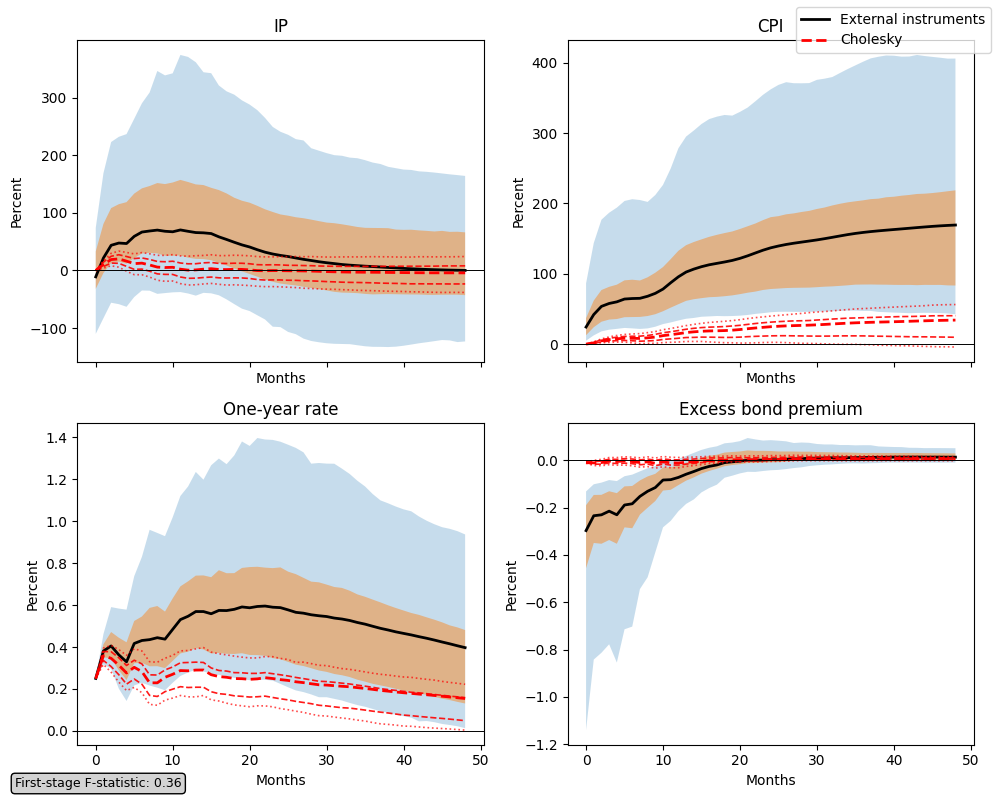

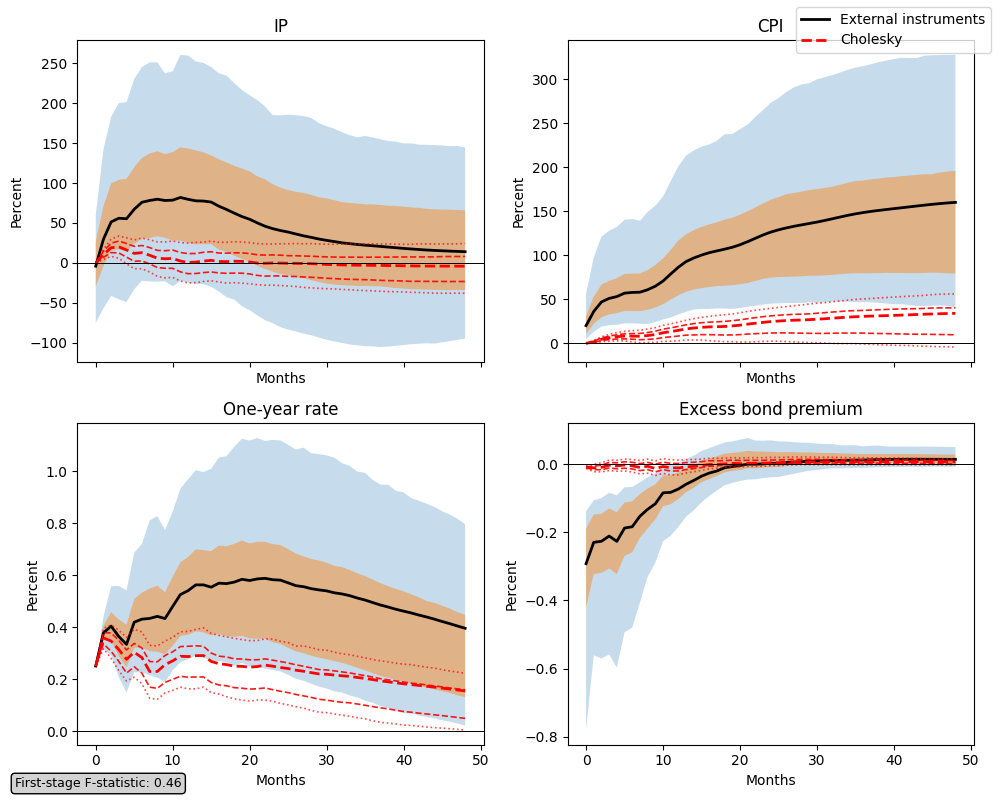

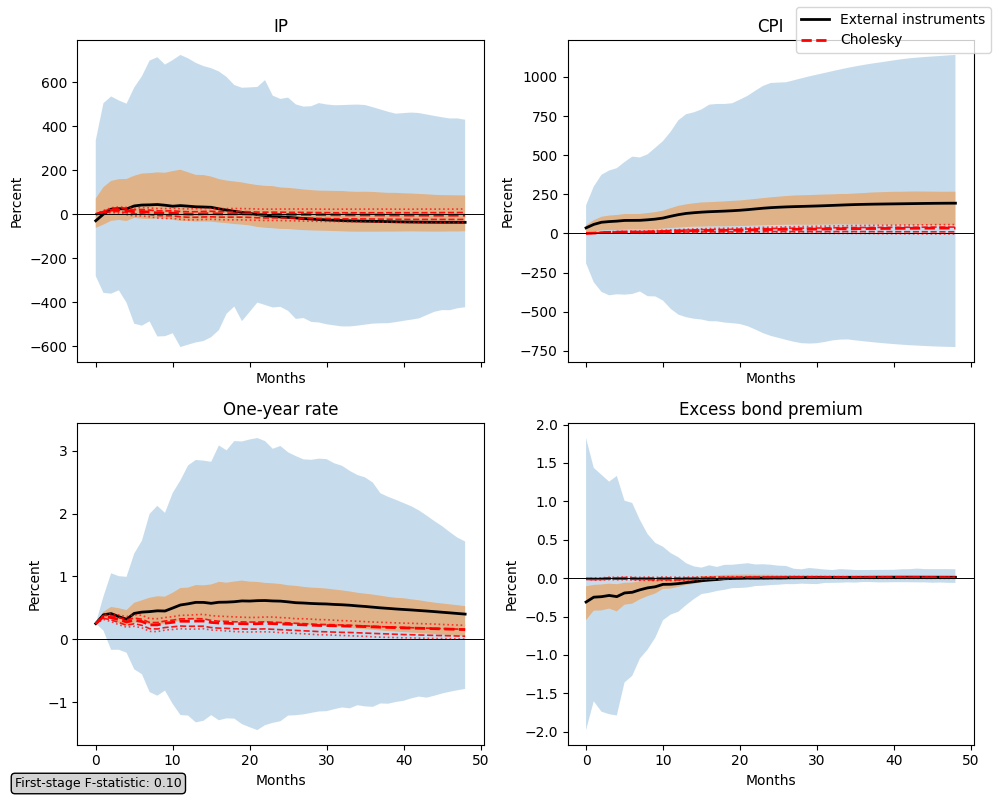

In [ ]:
speech_shock_map = [
    ("shock_speech_all",   "IRFs – All speeches (Chair + Vice Chair)"),
    ("shock_speech_chair", "IRFs – Chair speeches only"),
    ("shock_speech_vice",    "IRFs – Vice Chair speeches only"),
]

results_speeches = {}

for col, title in speech_shock_map:
    print(f"\n\n================ {title} =================")

    shock_series = df[col].loc[y_ext.index]
    proxy_results = rep.proxy_svar_identification(var_res_ext, shock_series)
    proxy_irfs    = rep.calculate_structural_irfs(var_res_ext, proxy_results["impact_vector"])
    proxy_irfs_b  = rep.recursive_bootstrap_proxy_svar(y_ext, shock_series, var_res_ext, n_boot=1000)

    chol_irfs     = rep.calculate_cholesky_irfs(var_res_ext)
    chol_irfs_b   = rep.recursive_bootstrap_cholesky(y_ext, var_res_ext, n_boot=1000)

    fig = rep.plot_figure1_final(proxy_irfs, chol_irfs, proxy_irfs_b, chol_irfs_b, proxy_results)
    results_speeches[col] = {"proxy_results": proxy_results, "figure": fig}

**Comment:** we can notice that including speeches as an instrument does not make our graphs better – all instruments have very low F-stat -> they are not strong.

### 2.5: Combining all events

We require a single, combined shock measure for all events. To construct it, we simply aggregate the meeting-based and speech-based shocks into one series. In other words, our pooled instrument adds the speech shock to the FOMC meeting shock, so that both types of events are jointly taken into account in the identification.


In [ ]:

fomc = df["shock_all"].copy()
speech = df["shock_speech_all"].copy()
fomc_z = (fomc - fomc.mean()) / fomc.std()
speech_z = (speech - speech.mean()) / speech.std()

df["shock_all_events"] = fomc_z + speech_z




================ IRFs – All events (meetings + speeches) =================

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.9182
  logcpi  : +29.0104
  gs1     : +1.0000
  ebp     : -57.5779

Recursive bootstrap for Proxy-SVAR (1000 replications)...

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3128
  logcpi  : +5.3304
  gs1     : +1.0000
  ebp     : -8.8198

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so g

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.7984
  logcpi  : +6.8248
  gs1     : +1.0000
  ebp     : -10.9907

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.8096
  logcpi  : +5.4678
  gs1     : +1.0000
  ebp     : -8.3981

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.6781
  logcpi  : +121.3370
  gs1     : +1.0000
  ebp     : -215.6839


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8792
  logcpi  : +4.0136
  gs1     : +1.0000
  ebp     : -7.0333

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0475
  logcpi  : +2.6347
  gs1     : +1.0000
  ebp     : -5.9571

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9889
  logcpi  : -4.4397
  gs1     : +1.0000
  ebp     : +9.5281


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +188.6979
  logcpi  : +259.7522
  gs1     : +1.0000
  ebp     : -554.4828

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0496
  logcpi  : +2.8365
  gs1     : +1.0000
  ebp     : -5.2426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9075
  logcpi  : +2.2021
  gs1     : +1.0000
  ebp     : -6.4653


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8336
  logcpi  : -11.3493
  gs1     : +1.0000
  ebp     : +22.7125

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.1649
  logcpi  : +7.6080
  gs1     : +1.0000
  ebp     : -16.6214

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5160
  logcpi  : +2.0286
  gs1     : +1.0000
  ebp     : -4.6261


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5282
  logcpi  : -2.7391
  gs1     : +1.0000
  ebp     : +5.0070

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +66.4505
  logcpi  : +50.4012
  gs1     : +1.0000
  ebp     : -85.9147

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -163.5603
  logcpi  : -80.2743
  gs1     : +1.0000
  ebp     : +167.6442


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.5726
  logcpi  : +8.6050
  gs1     : +1.0000
  ebp     : -12.6412

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.9897
  logcpi  : +4.7477
  gs1     : +1.0000
  ebp     : -10.6292

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -21.2886
  logcpi  : -54.4977
  gs1     : +1.0000
  ebp     : +89.2375


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1465
  logcpi  : -4.9108
  gs1     : +1.0000
  ebp     : +10.3128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4482
  logcpi  : +3.9946
  gs1     : +1.0000
  ebp     : -10.4163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8340
  logcpi  : -6.6758
  gs1     : +1.0000
  ebp     : +15.1207


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -39.1451
  logcpi  : -67.0699
  gs1     : +1.0000
  ebp     : +147.8351

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -38.5109
  logcpi  : -21.3670
  gs1     : +1.0000
  ebp     : +47.6413

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.7813
  logcpi  : -6.9806
  gs1     : +1.0000
  ebp     : +13.8656


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7416
  logcpi  : -1.9390
  gs1     : +1.0000
  ebp     : +7.1175

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.1225
  logcpi  : +6.2256
  gs1     : +1.0000
  ebp     : -15.8718

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7978
  logcpi  : +3.1574
  gs1     : +1.0000
  ebp     : -7.0876


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.6487
  logcpi  : -8.0456
  gs1     : +1.0000
  ebp     : +14.4388

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.7340
  logcpi  : +13.4953
  gs1     : +1.0000
  ebp     : -27.9190

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -20.0663
  logcpi  : -10.8955
  gs1     : +1.0000
  ebp     : +22.1818


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5418
  logcpi  : -6.0051
  gs1     : +1.0000
  ebp     : +10.3364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1600
  logcpi  : +3.0141
  gs1     : +1.0000
  ebp     : -5.7259


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.3796
  logcpi  : +5.5170
  gs1     : +1.0000
  ebp     : -10.0916

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0461
  logcpi  : +23.5370
  gs1     : +1.0000
  ebp     : -41.5205

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1438
  logcpi  : +6.0723
  gs1     : +1.0000
  ebp     : -11.6819


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3106
  logcpi  : +5.2315
  gs1     : +1.0000
  ebp     : -7.9095

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2149
  logcpi  : +9.3745
  gs1     : +1.0000
  ebp     : -25.0397

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2388
  logcpi  : -3.9994
  gs1     : +1.0000
  ebp     : +6.8705


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3020
  logcpi  : -4.1649
  gs1     : +1.0000
  ebp     : +8.4964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1807
  logcpi  : +8.1790
  gs1     : +1.0000
  ebp     : -13.8251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.8301
  logcpi  : +6.7015
  gs1     : +1.0000
  ebp     : -12.8525


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -27.2838
  logcpi  : -24.1257
  gs1     : +1.0000
  ebp     : +41.8138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5192
  logcpi  : +1.8593
  gs1     : +1.0000
  ebp     : -4.1058

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +42.6248
  logcpi  : +19.6181
  gs1     : +1.0000
  ebp     : -37.6795


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2366
  logcpi  : +6.7741
  gs1     : +1.0000
  ebp     : -12.5739

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1267
  logcpi  : -5.6124
  gs1     : +1.0000
  ebp     : +11.9720

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.7788
  logcpi  : +8.6360
  gs1     : +1.0000
  ebp     : -15.8302


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7153
  logcpi  : -6.4154
  gs1     : +1.0000
  ebp     : +10.1933

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.0727
  logcpi  : +10.3326
  gs1     : +1.0000
  ebp     : -19.8395

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0483
  logcpi  : +4.1043
  gs1     : +1.0000
  ebp     : -10.7566


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8599
  logcpi  : -1.9870
  gs1     : +1.0000
  ebp     : +4.8255

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.4707
  logcpi  : -34.6362
  gs1     : +1.0000
  ebp     : +59.8841

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.3269
  logcpi  : +5.6092
  gs1     : +1.0000
  ebp     : -13.6394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2397
  logcpi  : -2.9791
  gs1     : +1.0000
  ebp     : +5.3237

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3095
  logcpi  : +2.8828
  gs1     : +1.0000
  ebp     : -4.8557

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.9336
  logcpi  : -2.8740
  gs1     : +1.0000
  ebp     : +5.2773


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1612
  logcpi  : +3.7318
  gs1     : +1.0000
  ebp     : -6.0487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.43
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9113
  logcpi  : +1.6033
  gs1     : +1.0000
  ebp     : -3.4138

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8927
  logcpi  : -11.8119
  gs1     : +1.0000
  ebp     : +22.7135


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0352
  logcpi  : +12.8816
  gs1     : +1.0000
  ebp     : -21.3897

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6711
  logcpi  : +7.4424
  gs1     : +1.0000
  ebp     : -13.6668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1756
  logcpi  : +2.4166
  gs1     : +1.0000
  ebp     : -4.5603


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5456
  logcpi  : +3.0116
  gs1     : +1.0000
  ebp     : -6.3661

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.8273
  logcpi  : -16.2070
  gs1     : +1.0000
  ebp     : +31.5401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +206.6959
  logcpi  : +101.5529
  gs1     : +1.0000
  ebp     : -213.9811


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.4314
  logcpi  : +3.6179
  gs1     : +1.0000
  ebp     : -7.5807

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7031
  logcpi  : +4.3498
  gs1     : +1.0000
  ebp     : -8.0010

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5812
  logcpi  : +4.7166
  gs1     : +1.0000
  ebp     : -10.2576


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.1514
  logcpi  : +8.5546
  gs1     : +1.0000
  ebp     : -16.3875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3148
  logcpi  : +2.7859
  gs1     : +1.0000
  ebp     : -5.4655


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2990
  logcpi  : +5.1189
  gs1     : +1.0000
  ebp     : -11.6636


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -20.9696
  logcpi  : -22.9213
  gs1     : +1.0000
  ebp     : +42.4593

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +428.6247
  logcpi  : +160.0110
  gs1     : +1.0000
  ebp     : -354.3996


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1204
  logcpi  : -2.0136
  gs1     : +1.0000
  ebp     : +6.1371


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.3855
  logcpi  : +9.8291
  gs1     : +1.0000
  ebp     : -23.2687

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.2298
  logcpi  : +3.5050
  gs1     : +1.0000
  ebp     : -7.4274

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -20.8933
  logcpi  : -44.9821
  gs1     : +1.0000
  ebp     : +105.2231

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.4621
  logcpi  : +4.6611
  gs1     : +1.0000
  ebp     : -10.4258


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9933
  logcpi  : -4.6398
  gs1     : +1.0000
  ebp     : +11.5198

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5491
  logcpi  : +2.4158
  gs1     : +1.0000
  ebp     : -3.7894


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5040
  logcpi  : +7.2874
  gs1     : +1.0000
  ebp     : -15.3532


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.7321
  logcpi  : +13.7688
  gs1     : +1.0000
  ebp     : -27.2052

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2542
  logcpi  : +23.6009
  gs1     : +1.0000
  ebp     : -37.4742


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8190
  logcpi  : +3.9503
  gs1     : +1.0000
  ebp     : -5.1685

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.2109
  logcpi  : +6.9971
  gs1     : +1.0000
  ebp     : -15.0786

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.4221
  logcpi  : -4.1698
  gs1     : +1.0000
  ebp     : +9.9246


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -51.4180
  logcpi  : -31.0651
  gs1     : +1.0000
  ebp     : +61.6919

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4446
  logcpi  : -1.8512
  gs1     : +1.0000
  ebp     : +4.0122

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -76.0861
  logcpi  : -35.1376
  gs1     : +1.0000
  ebp     : +77.9826


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0184
  logcpi  : +10.7201
  gs1     : +1.0000
  ebp     : -18.8525

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1002
  logcpi  : -19.3909
  gs1     : +1.0000
  ebp     : +35.6926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.8948
  logcpi  : -9.3738
  gs1     : +1.0000
  ebp     : +16.3439


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -25.5297
  logcpi  : +86.6180
  gs1     : +1.0000
  ebp     : -204.8528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.53
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8651
  logcpi  : +1.3929
  gs1     : +1.0000
  ebp     : -3.3061

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.1177
  logcpi  : +4.7341
  gs1     : +1.0000
  ebp     : -7.8324

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9242
  logcpi  : +4.3895
  gs1     : +1.0000
  ebp     : -6.2459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +76.5071
  logcpi  : +54.3743
  gs1     : +1.0000
  ebp     : -136.8495


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6253
  logcpi  : +3.1164
  gs1     : +1.0000
  ebp     : -5.9034

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.0080
  logcpi  : -24.7074
  gs1     : +1.0000
  ebp     : +42.2293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5450
  logcpi  : -4.1376
  gs1     : +1.0000
  ebp     : +10.2255


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9182
  logcpi  : +35.0700
  gs1     : +1.0000
  ebp     : -53.7852

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9735
  logcpi  : +3.3516
  gs1     : +1.0000
  ebp     : -6.9690

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.1810
  logcpi  : +10.8621
  gs1     : +1.0000
  ebp     : -21.5165


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +31.8773
  logcpi  : +25.8891
  gs1     : +1.0000
  ebp     : -47.0328

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4994
  logcpi  : -3.7827
  gs1     : +1.0000
  ebp     : +7.5196

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2422
  logcpi  : +2.5993
  gs1     : +1.0000
  ebp     : -6.9776


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9920
  logcpi  : +3.1733
  gs1     : +1.0000
  ebp     : -4.3540

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.6021
  logcpi  : +5.9580
  gs1     : +1.0000
  ebp     : -11.2202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.2185
  logcpi  : -7.8467
  gs1     : +1.0000
  ebp     : +20.1663


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2573
  logcpi  : +9.5783
  gs1     : +1.0000
  ebp     : -13.6159

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.0896
  logcpi  : -23.4586
  gs1     : +1.0000
  ebp     : +46.0534

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +19.8458
  logcpi  : +15.1778
  gs1     : +1.0000
  ebp     : -30.1793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -69.6743
  logcpi  : -38.2599
  gs1     : +1.0000
  ebp     : +73.0963

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.6048
  logcpi  : +7.5926
  gs1     : +1.0000
  ebp     : -14.8694

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7366
  logcpi  : -2.1132
  gs1     : +1.0000
  ebp     : +3.5571


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1124
  logcpi  : +2.0848
  gs1     : +1.0000
  ebp     : -5.0745

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2191
  logcpi  : +9.9694
  gs1     : +1.0000
  ebp     : -32.5836

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.1399
  logcpi  : +3.0489
  gs1     : +1.0000
  ebp     : -5.5469


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.2919
  logcpi  : -12.9770
  gs1     : +1.0000
  ebp     : +20.7995

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.3552
  logcpi  : -5.8254
  gs1     : +1.0000
  ebp     : +9.3215

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3904
  logcpi  : +14.2099
  gs1     : +1.0000
  ebp     : -20.3047


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3786
  logcpi  : +4.0698
  gs1     : +1.0000
  ebp     : -9.1210

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9873
  logcpi  : +3.1252
  gs1     : +1.0000
  ebp     : -9.6130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.1433
  logcpi  : -12.8781
  gs1     : +1.0000
  ebp     : +29.8553


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6105
  logcpi  : -1.8543
  gs1     : +1.0000
  ebp     : +5.0193

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.1766
  logcpi  : -21.2385
  gs1     : +1.0000
  ebp     : +33.7307

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.1439
  logcpi  : +16.0364
  gs1     : +1.0000
  ebp     : -29.9006


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8021
  logcpi  : +8.0215
  gs1     : +1.0000
  ebp     : -13.0738

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +207.6149
  logcpi  : +138.5823
  gs1     : +1.0000
  ebp     : -322.0355

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8053
  logcpi  : +2.7637
  gs1     : +1.0000
  ebp     : -5.4136


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.7362
  logcpi  : -15.6671
  gs1     : +1.0000
  ebp     : +32.5917

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8300
  logcpi  : -4.6860
  gs1     : +1.0000
  ebp     : +8.9286

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1839
  logcpi  : +1.9394
  gs1     : +1.0000
  ebp     : -4.1084

=== Proxy-SVAR Identification ===
Common 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5392
  logcpi  : +6.6279
  gs1     : +1.0000
  ebp     : -14.5170

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8406
  logcpi  : -2.3924
  gs1     : +1.0000
  ebp     : +8.2010

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.0765
  logcpi  : +5.7559
  gs1     : +1.0000
  ebp     : -13.1278


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.5106
  logcpi  : +11.4678
  gs1     : +1.0000
  ebp     : -26.3826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +53.8363
  logcpi  : +35.9671
  gs1     : +1.0000
  ebp     : -100.8579

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.4106
  logcpi  : +8.7710
  gs1     : +1.0000
  ebp     : -27.4554


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.4606
  logcpi  : +10.4428
  gs1     : +1.0000
  ebp     : -25.9958

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1904
  logcpi  : -3.0944
  gs1     : +1.0000
  ebp     : +7.0755

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6235
  logcpi  : -14.6208
  gs1     : +1.0000
  ebp     : +27.6016


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4391
  logcpi  : -6.6987
  gs1     : +1.0000
  ebp     : +16.4054

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2937
  logcpi  : -6.5967
  gs1     : +1.0000
  ebp     : +14.2651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2570
  logcpi  : +7.6990
  gs1     : +1.0000
  ebp     : -12.4642


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +61.7336
  logcpi  : +60.5472
  gs1     : +1.0000
  ebp     : -93.5401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.3428
  logcpi  : +17.1363
  gs1     : +1.0000
  ebp     : -28.4741

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0152
  logcpi  : -4.3471
  gs1     : +1.0000
  ebp     : +7.9599


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7243
  logcpi  : +2.4172
  gs1     : +1.0000
  ebp     : -7.2546

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1392
  logcpi  : -16.2933
  gs1     : +1.0000
  ebp     : +31.1756

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9858
  logcpi  : +2.3115
  gs1     : +1.0000
  ebp     : -5.1309


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -291.9316
  logcpi  : -134.8509
  gs1     : +1.0000
  ebp     : +338.8683

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9665
  logcpi  : +2.6822
  gs1     : +1.0000
  ebp     : -5.6452

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5319
  logcpi  : -5.3174
  gs1     : +1.0000
  ebp     : +11.0060


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8827
  logcpi  : +4.8847
  gs1     : +1.0000
  ebp     : -12.1012

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +25.5872
  logcpi  : +27.6500
  gs1     : +1.0000
  ebp     : -56.0832

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2560
  logcpi  : -2.3553
  gs1     : +1.0000
  ebp     : +7.0970


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4773
  logcpi  : -2.3783
  gs1     : +1.0000
  ebp     : +4.9620

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.4647
  logcpi  : -5.4966
  gs1     : +1.0000
  ebp     : +11.2146

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2506
  logcpi  : +2.4893
  gs1     : +1.0000
  ebp     : -4.6386


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5475
  logcpi  : +3.9252
  gs1     : +1.0000
  ebp     : -8.7833

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8542
  logcpi  : +1.5610
  gs1     : +1.0000
  ebp     : -3.8404

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9892
  logcpi  : -2.0399
  gs1     : +1.0000
  ebp     : +5.3102


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9274
  logcpi  : +4.2736
  gs1     : +1.0000
  ebp     : -8.5692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : -324.3492
  logcpi  : -154.5842
  gs1     : +1.0000
  ebp     : +354.1365

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7879
  logcpi  : -1.9683
  gs1     : +1.0000
  ebp     : +4.1327


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4114
  logcpi  : +8.3669
  gs1     : +1.0000
  ebp     : -19.9314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.7414
  logcpi  : +8.1817
  gs1     : +1.0000
  ebp     : -19.9368

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +146.4463
  logcpi  : -243.8936
  gs1     : +1.0000
  ebp     : +447.2490


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2074
  logcpi  : +2.3759
  gs1     : +1.0000
  ebp     : -5.4360

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.7820
  logcpi  : +61.6658
  gs1     : +1.0000
  ebp     : -128.9926

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4351
  logcpi  : -5.1859
  gs1     : +1.0000
  ebp     : +9.2840


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -18.1722
  logcpi  : -26.8436
  gs1     : +1.0000
  ebp     : +49.8347

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.6401
  logcpi  : -7.1709
  gs1     : +1.0000
  ebp     : +10.6796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9967
  logcpi  : +4.6279
  gs1     : +1.0000
  ebp     : -11.6555


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +33.7399
  logcpi  : +33.6667
  gs1     : +1.0000
  ebp     : -63.4504

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9382
  logcpi  : +3.9818
  gs1     : +1.0000
  ebp     : -8.7032

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.6587
  logcpi  : -3.5570
  gs1     : +1.0000
  ebp     : +7.5533


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8383
  logcpi  : -3.1732
  gs1     : +1.0000
  ebp     : +7.1014

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1327
  logcpi  : +3.6602
  gs1     : +1.0000
  ebp     : -8.8147

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5343
  logcpi  : +2.4925
  gs1     : +1.0000
  ebp     : -6.1166


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.2340
  logcpi  : +5.7458
  gs1     : +1.0000
  ebp     : -10.7869

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6202
  logcpi  : +1.9849
  gs1     : +1.0000
  ebp     : -3.9569

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3930
  logcpi  : +3.0435
  gs1     : +1.0000
  ebp     : -5.9227


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.7153
  logcpi  : -13.0847
  gs1     : +1.0000
  ebp     : +28.4681

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.6890
  logcpi  : -21.2696
  gs1     : +1.0000
  ebp     : +37.9364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7882
  logcpi  : -9.8619
  gs1     : +1.0000
  ebp     : +24.4001


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.7802
  logcpi  : +4.5083
  gs1     : +1.0000
  ebp     : -11.9420

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1380
  logcpi  : +2.6097
  gs1     : +1.0000
  ebp     : -5.9158

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 1.00
  R^2: 0.11%, adj. R^2: -0.00%
  Instrument coefficient (beta_1): -0.0071

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9743
  logcpi  : +1.1312
  gs1     : +1.0000
  ebp     : -2.1661


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6650
  logcpi  : +16.7695
  gs1     : +1.0000
  ebp     : -32.1241

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.0880
  logcpi  : +40.4064
  gs1     : +1.0000
  ebp     : -64.7914

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5536
  logcpi  : -3.4828
  gs1     : +1.0000
  ebp     : +6.0499


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7050
  logcpi  : +4.3900
  gs1     : +1.0000
  ebp     : -7.6087

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1961
  logcpi  : +6.2453
  gs1     : +1.0000
  ebp     : -15.6916


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.63
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0057

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3405
  logcpi  : +1.9492
  gs1     : +1.0000
  ebp     : -3.2637

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0311
  logcpi  : -1.8174
  gs1     : +1.0000
  ebp     : +3.6102


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5347
  logcpi  : +3.4796
  gs1     : +1.0000
  ebp     : -6.2650


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.0943
  logcpi  : +12.7518
  gs1     : +1.0000
  ebp     : -23.0564

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.0656
  logcpi  : +15.2897
  gs1     : +1.0000
  ebp     : -32.0138


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7114
  logcpi  : +7.4373
  gs1     : +1.0000
  ebp     : -11.7744

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.1450
  logcpi  : +10.6538
  gs1     : +1.0000
  ebp     : -13.3128


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2496
  logcpi  : -6.6376
  gs1     : +1.0000
  ebp     : +15.3440


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9903
  logcpi  : +3.8958
  gs1     : +1.0000
  ebp     : -6.7844

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.7528
  logcpi  : +2.8999
  gs1     : +1.0000
  ebp     : -5.0820


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.9119
  logcpi  : +13.8673
  gs1     : +1.0000
  ebp     : -23.6909

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.1899
  logcpi  : +4.2145
  gs1     : +1.0000
  ebp     : -8.4594


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7117
  logcpi  : -10.0536
  gs1     : +1.0000
  ebp     : +17.9750

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.6357
  logcpi  : -7.9770
  gs1     : +1.0000
  ebp     : +17.1565


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3962
  logcpi  : +3.9788
  gs1     : +1.0000
  ebp     : -6.8987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6691
  logcpi  : -2.6645
  gs1     : +1.0000
  ebp     : +4.5692

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1019
  logcpi  : +2.6425
  gs1     : +1.0000
  ebp     : -6.8482


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2419
  logcpi  : -15.3252
  gs1     : +1.0000
  ebp     : +52.3590

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4797
  logcpi  : +4.1578
  gs1     : +1.0000
  ebp     : -10.8581


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9045
  logcpi  : +10.4842
  gs1     : +1.0000
  ebp     : -18.7955

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -21.4000
  logcpi  : -13.7424
  gs1     : +1.0000
  ebp     : +31.5732


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +45.4928
  logcpi  : +79.9869
  gs1     : +1.0000
  ebp     : -155.7861

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.6758
  logcpi  : +15.0894
  gs1     : +1.0000
  ebp     : -31.3689

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3596
  logcpi  : +5.9919
  gs1     : +1.0000
  ebp     : -10.2842


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3767
  logcpi  : +11.3254
  gs1     : +1.0000
  ebp     : -22.5605

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.8278
  logcpi  : -5.1704
  gs1     : +1.0000
  ebp     : +11.3751

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.2464
  logcpi  : +15.6851
  gs1     : +1.0000
  ebp     : -29.7829


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9235
  logcpi  : +20.8439
  gs1     : +1.0000
  ebp     : -42.7580

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7460
  logcpi  : +6.1095
  gs1     : +1.0000
  ebp     : -11.5501

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9937
  logcpi  : +5.9953
  gs1     : +1.0000
  ebp     : -15.4554


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.2122
  logcpi  : +6.4249
  gs1     : +1.0000
  ebp     : -11.6280

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -256.6116
  logcpi  : -137.7770
  gs1     : +1.0000
  ebp     : +291.5633

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9989
  logcpi  : -4.9606
  gs1     : +1.0000
  ebp     : +11.4166


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4821
  logcpi  : -5.2713
  gs1     : +1.0000
  ebp     : +10.6860

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5490
  logcpi  : +13.2099
  gs1     : +1.0000
  ebp     : -23.3341

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +1500.4855
  logcpi  : +939.2258
  gs1     : +1.0000
  ebp     : -1801.3465


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9777
  logcpi  : +2.9107
  gs1     : +1.0000
  ebp     : -5.6261

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.0808
  logcpi  : +29.1398
  gs1     : +1.0000
  ebp     : -61.7826

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.7216
  logcpi  : +4.6085
  gs1     : +1.0000
  ebp     : -14.3088


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5302
  logcpi  : -2.3157
  gs1     : +1.0000
  ebp     : +4.8232

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0594
  logcpi  : +3.4692
  gs1     : +1.0000
  ebp     : -6.3099

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8646
  logcpi  : +3.4123
  gs1     : +1.0000
  ebp     : -6.9896


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1351
  logcpi  : +1.7882
  gs1     : +1.0000
  ebp     : -4.0938

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7067
  logcpi  : -7.2263
  gs1     : +1.0000
  ebp     : +13.4732

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4514
  logcpi  : +6.3284
  gs1     : +1.0000
  ebp     : -9.0793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9007
  logcpi  : -7.8442
  gs1     : +1.0000
  ebp     : +14.5030

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0690
  logcpi  : -4.3088
  gs1     : +1.0000
  ebp     : +8.9809

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2933
  logcpi  : +2.3255
  gs1     : +1.0000
  ebp     : -5.3627

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3326
  logcpi  : +2.1223
  gs1     : +1.0000
  ebp     : -4.4133

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0770
  logcpi  : +6.0323
  gs1     : +1.0000
  ebp     : -10.4053


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0164
  logcpi  : +6.0529
  gs1     : +1.0000
  ebp     : -14.9093

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4869
  logcpi  : +3.5181
  gs1     : +1.0000
  ebp     : -9.4792

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +29.9700
  logcpi  : +90.7058
  gs1     : +1.0000
  ebp     : -153.8844


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2215
  logcpi  : +4.0400
  gs1     : +1.0000
  ebp     : -7.0780

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3543
  logcpi  : +2.4526
  gs1     : +1.0000
  ebp     : -5.0403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +39.6954
  logcpi  : +33.1545
  gs1     : +1.0000
  ebp     : -54.7247


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -70.7822
  logcpi  : -42.1776
  gs1     : +1.0000
  ebp     : +74.4163

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.7972
  logcpi  : +8.4737
  gs1     : +1.0000
  ebp     : -13.8021

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8769
  logcpi  : -3.1793
  gs1     : +1.0000
  ebp     : +6.9544


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +49.6720
  logcpi  : +25.0721
  gs1     : +1.0000
  ebp     : -50.0713

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8719
  logcpi  : -7.2098
  gs1     : +1.0000
  ebp     : +14.6674

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.4836
  logcpi  : +3.8344
  gs1     : +1.0000
  ebp     : -8.8967


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1436
  logcpi  : +2.4985
  gs1     : +1.0000
  ebp     : -5.4629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3176
  logcpi  : +5.2133
  gs1     : +1.0000
  ebp     : -11.1417

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +31.2668
  logcpi  : +67.0954
  gs1     : +1.0000
  ebp     : -127.5939


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6598
  logcpi  : +1.6922
  gs1     : +1.0000
  ebp     : -6.3079

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2035
  logcpi  : +3.8649
  gs1     : +1.0000
  ebp     : -6.5002

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.7668
  logcpi  : +11.0489
  gs1     : +1.0000
  ebp     : -21.9373


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3832
  logcpi  : -2.6034
  gs1     : +1.0000
  ebp     : +5.8973

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1280
  logcpi  : +3.1611
  gs1     : +1.0000
  ebp     : -5.4630

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5809
  logcpi  : +6.6571
  gs1     : +1.0000
  ebp     : -21.1427


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6614
  logcpi  : +2.7667
  gs1     : +1.0000
  ebp     : -7.8440

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6530
  logcpi  : +2.9607
  gs1     : +1.0000
  ebp     : -5.2332

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.5501
  logcpi  : +8.9981
  gs1     : +1.0000
  ebp     : -15.7141


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.49
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.0050

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4356
  logcpi  : -1.5148
  gs1     : +1.0000
  ebp     : +3.3516

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6833
  logcpi  : +2.9874
  gs1     : +1.0000
  ebp     : -4.8624

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +48.0507
  logcpi  : +25.4276
  gs1     : +1.0000
  ebp     : -67.9811


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.6536
  logcpi  : +10.5515
  gs1     : +1.0000
  ebp     : -20.0703

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +21.5573
  logcpi  : +11.8578
  gs1     : +1.0000
  ebp     : -23.7960

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.9063
  logcpi  : -12.4868
  gs1     : +1.0000
  ebp     : +24.0908


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.8305
  logcpi  : -11.5857
  gs1     : +1.0000
  ebp     : +21.2964

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.3265
  logcpi  : -10.2610
  gs1     : +1.0000
  ebp     : +15.7841

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9831
  logcpi  : +6.8921
  gs1     : +1.0000
  ebp     : -18.8458


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +119.0186
  logcpi  : -127.4527
  gs1     : +1.0000
  ebp     : +269.7551

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4561
  logcpi  : +2.1123
  gs1     : +1.0000
  ebp     : -4.0372


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.3641
  logcpi  : -1.9108
  gs1     : +1.0000
  ebp     : +5.0770

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +19.2835
  logcpi  : +10.8236
  gs1     : +1.0000
  ebp     : -23.0456


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.2298
  logcpi  : +6.9426
  gs1     : +1.0000
  ebp     : -14.2264

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0782
  logcpi  : +2.3019
  gs1     : +1.0000
  ebp     : -4.7557

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.3117
  logcpi  : +7.3128
  gs1     : +1.0000
  ebp     : -14.0805


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9232
  logcpi  : -1.3434
  gs1     : +1.0000
  ebp     : +3.4912

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.3724
  logcpi  : +2.0579
  gs1     : +1.0000
  ebp     : -5.0411

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +64.0593
  logcpi  : +83.7281
  gs1     : +1.0000
  ebp     : -148.7795


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6686
  logcpi  : +11.0764
  gs1     : +1.0000
  ebp     : -20.2991

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.9955
  logcpi  : -5.8078
  gs1     : +1.0000
  ebp     : +9.2454

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3213
  logcpi  : -3.6970
  gs1     : +1.0000
  ebp     : +6.8371


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.5852
  logcpi  : -12.7293
  gs1     : +1.0000
  ebp     : +26.0760

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2126
  logcpi  : +10.9953
  gs1     : +1.0000
  ebp     : -18.9669

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0307
  logcpi  : +3.0549
  gs1     : +1.0000
  ebp     : -6.8138


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.0215
  logcpi  : -10.9186
  gs1     : +1.0000
  ebp     : +30.7036

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.6112
  logcpi  : +5.6095
  gs1     : +1.0000
  ebp     : -10.9081

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.4502
  logcpi  : +14.2010
  gs1     : +1.0000
  ebp     : -32.6464


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5883
  logcpi  : +1.5828
  gs1     : +1.0000
  ebp     : -3.5726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7617
  logcpi  : +2.3891
  gs1     : +1.0000
  ebp     : -5.0945

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1604
  logcpi  : +5.2992
  gs1     : +1.0000
  ebp     : -10.8254


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4687
  logcpi  : +3.3173
  gs1     : +1.0000
  ebp     : -6.8615

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.1416
  logcpi  : +13.4241
  gs1     : +1.0000
  ebp     : -22.4983

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4561
  logcpi  : -2.5857
  gs1     : +1.0000
  ebp     : +6.2116


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0896
  logcpi  : +2.2716
  gs1     : +1.0000
  ebp     : -4.0619

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7169
  logcpi  : +7.2396
  gs1     : +1.0000
  ebp     : -16.3013

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -55.0777
  logcpi  : -38.7508
  gs1     : +1.0000
  ebp     : +75.7420


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8033
  logcpi  : -15.1368
  gs1     : +1.0000
  ebp     : +26.7404

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : -360.7111
  logcpi  : -403.4720
  gs1     : +1.0000
  ebp     : +579.5587

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9238
  logcpi  : -24.9251
  gs1     : +1.0000
  ebp     : +50.8427


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0288
  logcpi  : +2.6941
  gs1     : +1.0000
  ebp     : -7.2313

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1374
  logcpi  : -7.4222
  gs1     : +1.0000
  ebp     : +25.2407

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2956
  logcpi  : -10.2342
  gs1     : +1.0000
  ebp     : +17.4276


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4204
  logcpi  : +3.0530
  gs1     : +1.0000
  ebp     : -6.5378

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4037
  logcpi  : +3.1301
  gs1     : +1.0000
  ebp     : -5.8205

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.4547
  logcpi  : +6.4443
  gs1     : +1.0000
  ebp     : -15.2042


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.1233
  logcpi  : +15.3166
  gs1     : +1.0000
  ebp     : -32.4936

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1469
  logcpi  : +24.1448
  gs1     : +1.0000
  ebp     : -57.2891

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1894
  logcpi  : -6.5544
  gs1     : +1.0000
  ebp     : +24.8240


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5858
  logcpi  : +14.9075
  gs1     : +1.0000
  ebp     : -24.5856

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.2052
  logcpi  : +2.3245
  gs1     : +1.0000
  ebp     : -5.1114

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5893
  logcpi  : +4.4926
  gs1     : +1.0000
  ebp     : -6.6889


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.4386
  logcpi  : +8.0921
  gs1     : +1.0000
  ebp     : -15.2069

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4834
  logcpi  : -6.2099
  gs1     : +1.0000
  ebp     : +12.6810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.0133
  logcpi  : -9.9669
  gs1     : +1.0000
  ebp     : +16.0346


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6244
  logcpi  : +2.7344
  gs1     : +1.0000
  ebp     : -5.0367

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.0844
  logcpi  : -3.7474
  gs1     : +1.0000
  ebp     : +8.5017

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.66
  R^2: 0.07%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0058

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6213
  logcpi  : +1.5489
  gs1     : +1.0000
  ebp     : -2.5443


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +63.0570
  logcpi  : +37.7897
  gs1     : +1.0000
  ebp     : -63.2592

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3973
  logcpi  : -3.1577
  gs1     : +1.0000
  ebp     : +5.0085

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2898
  logcpi  : -6.8671
  gs1     : +1.0000
  ebp     : +12.2321


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.2388
  logcpi  : +32.8017
  gs1     : +1.0000
  ebp     : -55.5272

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3212
  logcpi  : +3.2783
  gs1     : +1.0000
  ebp     : -6.2343


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3123
  logcpi  : +2.7468
  gs1     : +1.0000
  ebp     : -6.2023


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.8716
  logcpi  : +3.9229
  gs1     : +1.0000
  ebp     : -10.2942


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.9217
  logcpi  : +6.3703
  gs1     : +1.0000
  ebp     : -14.3187

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0819
  logcpi  : +11.0837
  gs1     : +1.0000
  ebp     : -16.3409

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8046
  logcpi  : -2.3448
  gs1     : +1.0000
  ebp     : +4.8302


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.2523
  logcpi  : +4.0771
  gs1     : +1.0000
  ebp     : -13.3358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6401
  logcpi  : +4.5314
  gs1     : +1.0000
  ebp     : -6.7950


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.1599
  logcpi  : +11.5767
  gs1     : +1.0000
  ebp     : -26.5240

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.58
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3240
  logcpi  : +1.3162
  gs1     : +1.0000
  ebp     : -2.8039


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2605
  logcpi  : +8.5842
  gs1     : +1.0000
  ebp     : -16.2332

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2032
  logcpi  : -3.2893
  gs1     : +1.0000
  ebp     : +5.6933


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1315
  logcpi  : -2.2299
  gs1     : +1.0000
  ebp     : +4.4300

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.9190
  logcpi  : -3.4583
  gs1     : +1.0000
  ebp     : +7.2016


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.7689
  logcpi  : -11.9507
  gs1     : +1.0000
  ebp     : +36.6610

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5361
  logcpi  : -4.5704
  gs1     : +1.0000
  ebp     : +5.8336

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +284.6384
  logcpi  : +517.3869
  gs1     : +1.0000
  ebp     : -997.0919

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6705
  logcpi  : +3.0652
  gs1     : +1.0000
  ebp     : -5.9907

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4825
  logcpi  : +6.4476
  gs1     : +1.0000
  ebp     : -17.4712


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.5847
  logcpi  : +12.7291
  gs1     : +1.0000
  ebp     : -21.1780

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -71.5469
  logcpi  : -78.5218
  gs1     : +1.0000
  ebp     : +160.8089

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.8078
  logcpi  : +9.0778
  gs1     : +1.0000
  ebp     : -20.5625


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9745
  logcpi  : +4.0220
  gs1     : +1.0000
  ebp     : -7.0272

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0185
  logcpi  : +3.0505
  gs1     : +1.0000
  ebp     : -13.4629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.3168
  logcpi  : +31.5539
  gs1     : +1.0000
  ebp     : -57.2918


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.8268
  logcpi  : +27.0538
  gs1     : +1.0000
  ebp     : -63.6460

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0448
  logcpi  : -3.0365
  gs1     : +1.0000
  ebp     : +7.7462


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.5979
  logcpi  : -2.6451
  gs1     : +1.0000
  ebp     : +6.4925

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +46.7882
  logcpi  : +91.4821
  gs1     : +1.0000
  ebp     : -161.6817

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +45.8687
  logcpi  : -189.7727
  gs1     : +1.0000
  ebp     : +423.5922

=== Proxy-SVAR Identification ===
C

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0287
  logcpi  : -4.5922
  gs1     : +1.0000
  ebp     : +8.2217

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +63.6325
  logcpi  : +43.2479
  gs1     : +1.0000
  ebp     : -78.4505


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3160
  logcpi  : +2.9683
  gs1     : +1.0000
  ebp     : -6.3381

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2499
  logcpi  : -3.0092
  gs1     : +1.0000
  ebp     : +6.6143

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : -129.4149
  logcpi  : -518.9377
  gs1     : +1.0000
  ebp     : +994.8399

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.0047

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.8886
  logcpi  : -1.4646
  gs1     : +1.0000
  ebp     : +3.7778

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +37.7226
  logcpi  : +30.9835
  gs1     : +1.0000
  ebp     : -71.0107


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5661
  logcpi  : -2.9344
  gs1     : +1.0000
  ebp     : +5.9726

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5446
  logcpi  : +2.4520
  gs1     : +1.0000
  ebp     : -3.4739

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.2070
  logcpi  : +18.1362
  gs1     : +1.0000
  ebp     : -34.6166


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.6974
  logcpi  : +8.7498
  gs1     : +1.0000
  ebp     : -23.0202

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.8402
  logcpi  : -10.0622
  gs1     : +1.0000
  ebp     : +19.8211

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2454
  logcpi  : +3.9903
  gs1     : +1.0000
  ebp     : -9.0449


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -185.6228
  logcpi  : -88.9793
  gs1     : +1.0000
  ebp     : +187.7056

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9392
  logcpi  : -1.5993
  gs1     : +1.0000
  ebp     : +4.5691

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9560
  logcpi  : +2.0603
  gs1     : +1.0000
  ebp     : -6.5801


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -25.8367
  logcpi  : -12.2525
  gs1     : +1.0000
  ebp     : +26.2123

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4376
  logcpi  : +9.7219
  gs1     : +1.0000
  ebp     : -20.6993

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5118
  logcpi  : -9.1086
  gs1     : +1.0000
  ebp     : +19.1825


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.5833
  logcpi  : +7.2510
  gs1     : +1.0000
  ebp     : -14.6399

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.6935
  logcpi  : +2.4525
  gs1     : +1.0000
  ebp     : -3.8347

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4483
  logcpi  : +2.7028
  gs1     : +1.0000
  ebp     : -5.8376


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6490
  logcpi  : +2.5180
  gs1     : +1.0000
  ebp     : -5.4752

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0911
  logcpi  : -2.7485
  gs1     : +1.0000
  ebp     : +6.9985

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1202
  logcpi  : -2.9041
  gs1     : +1.0000
  ebp     : +5.8374


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4822
  logcpi  : +33.4367
  gs1     : +1.0000
  ebp     : -72.0442

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +71.1206
  logcpi  : +230.4314
  gs1     : +1.0000
  ebp     : -455.0230

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3298
  logcpi  : +2.2548
  gs1     : +1.0000
  ebp     : -5.6168

=== Proxy-SVAR Identification ===
C

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6824
  logcpi  : -6.0701
  gs1     : +1.0000
  ebp     : +13.4870

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.7584
  logcpi  : +9.2740
  gs1     : +1.0000
  ebp     : -15.7251

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.45
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6865
  logcpi  : +1.5758
  gs1     : +1.0000
  ebp     : -3.5096


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1121
  logcpi  : +2.9373
  gs1     : +1.0000
  ebp     : -7.6607

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.3938
  logcpi  : +9.7886
  gs1     : +1.0000
  ebp     : -17.7042

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.9811
  logcpi  : +15.1487
  gs1     : +1.0000
  ebp     : -24.8883


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4909
  logcpi  : +2.9089
  gs1     : +1.0000
  ebp     : -5.1426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.7716
  logcpi  : +3.0489
  gs1     : +1.0000
  ebp     : -6.0540

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.4875
  logcpi  : +9.9098
  gs1     : +1.0000
  ebp     : -16.3210


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7010
  logcpi  : +4.7259
  gs1     : +1.0000
  ebp     : -10.6659

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.5928
  logcpi  : +5.8299
  gs1     : +1.0000
  ebp     : -16.3840

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +19.2513
  logcpi  : +17.4347
  gs1     : +1.0000
  ebp     : -29.3107


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8177
  logcpi  : +4.1758
  gs1     : +1.0000
  ebp     : -7.2268

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.8821
  logcpi  : +17.5440
  gs1     : +1.0000
  ebp     : -35.5314

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5376
  logcpi  : +3.7535
  gs1     : +1.0000
  ebp     : -6.2899


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4381
  logcpi  : +1.9492
  gs1     : +1.0000
  ebp     : -3.8263

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.3812
  logcpi  : +10.2708
  gs1     : +1.0000
  ebp     : -19.6303

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.3661
  logcpi  : +4.9891
  gs1     : +1.0000
  ebp     : -10.4403


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.3251
  logcpi  : +23.7005
  gs1     : +1.0000
  ebp     : -51.5691

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6913
  logcpi  : +3.2957
  gs1     : +1.0000
  ebp     : -6.5903

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0042

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8675
  logcpi  : +2.7310
  gs1     : +1.0000
  ebp     : -4.0376


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.1859
  logcpi  : +6.7104
  gs1     : +1.0000
  ebp     : -12.0238

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.6612
  logcpi  : +7.9914
  gs1     : +1.0000
  ebp     : -15.6617

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7762
  logcpi  : +2.7513
  gs1     : +1.0000
  ebp     : -5.9954


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7547
  logcpi  : +4.4550
  gs1     : +1.0000
  ebp     : -8.1727

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.1076
  logcpi  : -5.7545
  gs1     : +1.0000
  ebp     : +11.6179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.4847
  logcpi  : -5.3846
  gs1     : +1.0000
  ebp     : +13.2040


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1077
  logcpi  : +12.1637
  gs1     : +1.0000
  ebp     : -24.7230

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8144
  logcpi  : +8.2497
  gs1     : +1.0000
  ebp     : -14.5972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3963
  logcpi  : +2.1604
  gs1     : +1.0000
  ebp     : -4.2785


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.5253
  logcpi  : +35.8449
  gs1     : +1.0000
  ebp     : -77.3928

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.6123
  logcpi  : +9.7353
  gs1     : +1.0000
  ebp     : -19.9459

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +94.9635
  logcpi  : +90.3875
  gs1     : +1.0000
  ebp     : -155.4829

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +627.9162
  logcpi  : +412.4952
  gs1     : +1.0000
  ebp     : -806.0753

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.8992
  logcpi  : +4.5773
  gs1     : +1.0000
  ebp     : -10.2690


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +1377.1612
  logcpi  : +440.1553
  gs1     : +1.0000
  ebp     : -1034.1775

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.5126
  logcpi  : -5.3375
  gs1     : +1.0000
  ebp     : +10.2638

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.5464
  logcpi  : +6.4200
  gs1     : +1.0000
  ebp     : -11.2710


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.9760
  logcpi  : -2.3886
  gs1     : +1.0000
  ebp     : +4.7287

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6283
  logcpi  : -3.1301
  gs1     : +1.0000
  ebp     : +6.2838

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4692
  logcpi  : -5.4381
  gs1     : +1.0000
  ebp     : +12.2660


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -27.4804
  logcpi  : -23.0193
  gs1     : +1.0000
  ebp     : +44.0071

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8061
  logcpi  : -5.5619
  gs1     : +1.0000
  ebp     : +10.8496

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.0735
  logcpi  : -13.9545
  gs1     : +1.0000
  ebp     : +43.0497


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4452
  logcpi  : +3.8638
  gs1     : +1.0000
  ebp     : -6.9379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.7502
  logcpi  : -8.7657
  gs1     : +1.0000
  ebp     : +17.3893

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2333
  logcpi  : -2.7315
  gs1     : +1.0000
  ebp     : +5.7146


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.4655
  logcpi  : +14.7208
  gs1     : +1.0000
  ebp     : -25.6480

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8037
  logcpi  : -2.5470
  gs1     : +1.0000
  ebp     : +6.3998

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9171
  logcpi  : +8.2215
  gs1     : +1.0000
  ebp     : -14.6439


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4116
  logcpi  : -3.5705
  gs1     : +1.0000
  ebp     : +5.5723

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.0681
  logcpi  : +10.3863
  gs1     : +1.0000
  ebp     : -21.5594

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.3448
  logcpi  : +15.6549
  gs1     : +1.0000
  ebp     : -34.3823


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.6705
  logcpi  : +3.9441
  gs1     : +1.0000
  ebp     : -10.0441

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.9643
  logcpi  : -4.4283
  gs1     : +1.0000
  ebp     : +7.1810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2803
  logcpi  : +4.6238
  gs1     : +1.0000
  ebp     : -9.8212


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9420
  logcpi  : +3.1434
  gs1     : +1.0000
  ebp     : -5.3943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -33.5540
  logcpi  : -26.5373
  gs1     : +1.0000
  ebp     : +43.6226

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9880
  logcpi  : +3.4683
  gs1     : +1.0000
  ebp     : -6.5434


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.4141
  logcpi  : -9.2062
  gs1     : +1.0000
  ebp     : +19.1963

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2763
  logcpi  : +9.0192
  gs1     : +1.0000
  ebp     : -12.4921

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9614
  logcpi  : -3.2190
  gs1     : +1.0000
  ebp     : +7.2543


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.3023
  logcpi  : +8.7231
  gs1     : +1.0000
  ebp     : -17.8179

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5485
  logcpi  : +3.0360
  gs1     : +1.0000
  ebp     : -5.4987


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.3927
  logcpi  : +16.7904
  gs1     : +1.0000
  ebp     : -31.3015

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -19.6735
  logcpi  : -21.2392
  gs1     : +1.0000
  ebp     : +39.3193

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9139
  logcpi  : +4.2282
  gs1     : +1.0000
  ebp     : -7.0664


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +187.6073
  logcpi  : +167.7373
  gs1     : +1.0000
  ebp     : -242.0592


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.0644
  logcpi  : +5.1327
  gs1     : +1.0000
  ebp     : -14.6967

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.2397
  logcpi  : +4.2142
  gs1     : +1.0000
  ebp     : -14.7543


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.2497
  logcpi  : +6.5257
  gs1     : +1.0000
  ebp     : -17.8947


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.1206
  logcpi  : -2.5603
  gs1     : +1.0000
  ebp     : +5.5801


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -168.9382
  logcpi  : -151.3382
  gs1     : +1.0000
  ebp     : +282.0897

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.1376
  logcpi  : -11.8460
  gs1     : +1.0000
  ebp     : +21.0976


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -21.9236
  logcpi  : -36.4273
  gs1     : +1.0000
  ebp     : +75.3629

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7092
  logcpi  : +2.9221
  gs1     : +1.0000
  ebp     : -10.2683


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.9723
  logcpi  : -12.2652
  gs1     : +1.0000
  ebp     : +24.2562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +49.1977
  logcpi  : +22.1515
  gs1     : +1.0000
  ebp     : -49.4648


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0779
  logcpi  : -4.9117
  gs1     : +1.0000
  ebp     : +7.4318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6092
  logcpi  : +15.1587
  gs1     : +1.0000
  ebp     : -29.1854


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7912
  logcpi  : -10.5322
  gs1     : +1.0000
  ebp     : +22.4464

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.6228
  logcpi  : +3.7983
  gs1     : +1.0000
  ebp     : -11.6464


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4326
  logcpi  : +3.1613
  gs1     : +1.0000
  ebp     : -7.1885

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -135.4474
  logcpi  : -92.1612
  gs1     : +1.0000
  ebp     : +168.7356


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.1966
  logcpi  : +3.9252
  gs1     : +1.0000
  ebp     : -9.0180

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1438
  logcpi  : -11.0786
  gs1     : +1.0000
  ebp     : +16.4068

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.1568
  logcpi  : -10.8317
  gs1     : +1.0000
  ebp     : +24.9794


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4657
  logcpi  : -6.2808
  gs1     : +1.0000
  ebp     : +11.5571

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9115
  logcpi  : -7.1605
  gs1     : +1.0000
  ebp     : +11.6676

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3846
  logcpi  : +4.6024
  gs1     : +1.0000
  ebp     : -8.8741


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.4021
  logcpi  : +29.2532
  gs1     : +1.0000
  ebp     : -60.4404

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.1089
  logcpi  : +3.9359
  gs1     : +1.0000
  ebp     : -8.4642

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2553
  logcpi  : +12.8027
  gs1     : +1.0000
  ebp     : -22.7203


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.52
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0052

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4701
  logcpi  : +1.9017
  gs1     : +1.0000
  ebp     : -3.0520

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1343
  logcpi  : +7.1106
  gs1     : +1.0000
  ebp     : -13.5093

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0431
  logcpi  : +8.9056
  gs1     : +1.0000
  ebp     : -18.5585


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2870
  logcpi  : +3.0599
  gs1     : +1.0000
  ebp     : -5.2467

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.5061
  logcpi  : -14.0924
  gs1     : +1.0000
  ebp     : +36.9536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3797
  logcpi  : -3.8521
  gs1     : +1.0000
  ebp     : +10.4532


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3274
  logcpi  : -14.7627
  gs1     : +1.0000
  ebp     : +22.3241

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.6812
  logcpi  : +24.8958
  gs1     : +1.0000
  ebp     : -43.6831

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.5706
  logcpi  : +4.2671
  gs1     : +1.0000
  ebp     : -11.3230


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.39
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4592
  logcpi  : +1.8197
  gs1     : +1.0000
  ebp     : -3.5808

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +159.7030
  logcpi  : +280.4220
  gs1     : +1.0000
  ebp     : -539.3253

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +24.3922
  logcpi  : +13.0086
  gs1     : +1.0000
  ebp     : -23.3130


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9769
  logcpi  : +2.6715
  gs1     : +1.0000
  ebp     : -6.9078

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +466.1427
  logcpi  : +267.5397
  gs1     : +1.0000
  ebp     : -558.5425


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7609
  logcpi  : +5.7584
  gs1     : +1.0000
  ebp     : -14.2455

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2824
  logcpi  : +3.1521
  gs1     : +1.0000
  ebp     : -6.9695

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.6779
  logcpi  : -6.0729
  gs1     : +1.0000
  ebp     : +14.3666


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.3555
  logcpi  : +2.5834
  gs1     : +1.0000
  ebp     : -7.3559

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0522
  logcpi  : +4.8580
  gs1     : +1.0000
  ebp     : -8.5612

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3475
  logcpi  : -10.2254
  gs1     : +1.0000
  ebp     : +18.8327


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2955
  logcpi  : +2.4346
  gs1     : +1.0000
  ebp     : -5.2131

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9578
  logcpi  : -51.4528
  gs1     : +1.0000
  ebp     : +107.9157

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7562
  logcpi  : +4.3214
  gs1     : +1.0000
  ebp     : -12.4094


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +36.7798
  logcpi  : +34.3139
  gs1     : +1.0000
  ebp     : -56.3112

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.88
  R^2: 0.10%, adj. R^2: -0.01%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4277
  logcpi  : +1.2440
  gs1     : +1.0000
  ebp     : -2.5710

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.4731
  logcpi  : -7.7476
  gs1     : +1.0000
  ebp     : +17.6947

=== Proxy-SVAR Identification ===
Comm

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.3912
  logcpi  : -14.0365
  gs1     : +1.0000
  ebp     : +24.4707

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +25.6237
  logcpi  : +16.8236
  gs1     : +1.0000
  ebp     : -41.0011

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3501
  logcpi  : +2.3637
  gs1     : +1.0000
  ebp     : -4.3931


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9142
  logcpi  : -3.2041
  gs1     : +1.0000
  ebp     : +9.5387

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4108
  logcpi  : -4.9200
  gs1     : +1.0000
  ebp     : +9.6582

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4509
  logcpi  : -3.9757
  gs1     : +1.0000
  ebp     : +10.0123


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1021
  logcpi  : +3.1727
  gs1     : +1.0000
  ebp     : -6.6443

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.6619
  logcpi  : -7.4353
  gs1     : +1.0000
  ebp     : +18.7054

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.3115
  logcpi  : +37.6768
  gs1     : +1.0000
  ebp     : -65.1266


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4429
  logcpi  : +7.2428
  gs1     : +1.0000
  ebp     : -12.6364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.24
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8261
  logcpi  : +1.5445
  gs1     : +1.0000
  ebp     : -4.5390

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0801
  logcpi  : +3.9340
  gs1     : +1.0000
  ebp     : -7.5249


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.8843
  logcpi  : +2.8584
  gs1     : +1.0000
  ebp     : -4.4451

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5471
  logcpi  : -1.1957
  gs1     : +1.0000
  ebp     : +4.1509

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5996
  logcpi  : +3.4620
  gs1     : +1.0000
  ebp     : -7.5846


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7793
  logcpi  : +4.2521
  gs1     : +1.0000
  ebp     : -10.3989

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -33.1350
  logcpi  : -18.3591
  gs1     : +1.0000
  ebp     : +46.4647

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.3228
  logcpi  : -22.3345
  gs1     : +1.0000
  ebp     : +32.1224


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5599
  logcpi  : +4.4437
  gs1     : +1.0000
  ebp     : -9.8446

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.8393
  logcpi  : -42.3614
  gs1     : +1.0000
  ebp     : +74.6540

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8767
  logcpi  : +3.4386
  gs1     : +1.0000
  ebp     : -6.2821


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.7711
  logcpi  : -4.2590
  gs1     : +1.0000
  ebp     : +9.1046

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.0594
  logcpi  : +11.5718
  gs1     : +1.0000
  ebp     : -16.8610

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3086
  logcpi  : -6.7704
  gs1     : +1.0000
  ebp     : +10.9206


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8233
  logcpi  : +5.4295
  gs1     : +1.0000
  ebp     : -9.9009

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7934
  logcpi  : +3.9967
  gs1     : +1.0000
  ebp     : -7.3665

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -83.6560
  logcpi  : -56.1397
  gs1     : +1.0000
  ebp     : +121.8714


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4563
  logcpi  : +2.7144
  gs1     : +1.0000
  ebp     : -5.8484

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5322
  logcpi  : -4.7293
  gs1     : +1.0000
  ebp     : +10.4277

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.5502
  logcpi  : +26.0823
  gs1     : +1.0000
  ebp     : -56.9137


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0855
  logcpi  : -4.6799
  gs1     : +1.0000
  ebp     : +10.2015

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.1568
  logcpi  : +3.1987
  gs1     : +1.0000
  ebp     : -7.1160

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2190
  logcpi  : +3.8524
  gs1     : +1.0000
  ebp     : -7.8293


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +19.3702
  logcpi  : +22.6515
  gs1     : +1.0000
  ebp     : -44.2678

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4253
  logcpi  : +2.0682
  gs1     : +1.0000
  ebp     : -5.1518

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4559
  logcpi  : +8.5858
  gs1     : +1.0000
  ebp     : -15.3579


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.8111
  logcpi  : +20.9888
  gs1     : +1.0000
  ebp     : -42.0825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7992
  logcpi  : +5.4358
  gs1     : +1.0000
  ebp     : -15.8769

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1279
  logcpi  : +3.0131
  gs1     : +1.0000
  ebp     : -7.6305


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3309
  logcpi  : +4.0968
  gs1     : +1.0000
  ebp     : -10.3602

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.3075
  logcpi  : +16.3461
  gs1     : +1.0000
  ebp     : -32.6816

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -44.2728
  logcpi  : -25.9862
  gs1     : +1.0000
  ebp     : +51.4678


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2111
  logcpi  : -2.9698
  gs1     : +1.0000
  ebp     : +4.7074

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.1568
  logcpi  : +3.8707
  gs1     : +1.0000
  ebp     : -6.2429


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.5980
  logcpi  : -12.9553
  gs1     : +1.0000
  ebp     : +25.0583

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.8512
  logcpi  : -4.9817
  gs1     : +1.0000
  ebp     : +11.8943

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6414
  logcpi  : +2.9611
  gs1     : +1.0000
  ebp     : -5.7747


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4789
  logcpi  : -3.1741
  gs1     : +1.0000
  ebp     : +7.6590

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.1306
  logcpi  : +7.0536
  gs1     : +1.0000
  ebp     : -12.6132

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2745
  logcpi  : +1.9531
  gs1     : +1.0000
  ebp     : -3.9428


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.8087
  logcpi  : +7.9084
  gs1     : +1.0000
  ebp     : -14.4862

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.9334
  logcpi  : -10.8982
  gs1     : +1.0000
  ebp     : +21.4248

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -25.1163
  logcpi  : -9.6920
  gs1     : +1.0000
  ebp     : +23.3392


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +20.2119
  logcpi  : +22.2796
  gs1     : +1.0000
  ebp     : -36.4461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.9172
  logcpi  : -8.3657
  gs1     : +1.0000
  ebp     : +19.1252

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1003
  logcpi  : +9.6413
  gs1     : +1.0000
  ebp     : -20.7283


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.1708
  logcpi  : +8.4529
  gs1     : +1.0000
  ebp     : -23.9253

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.0930
  logcpi  : +24.8721
  gs1     : +1.0000
  ebp     : -59.9197

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4998
  logcpi  : +8.8734
  gs1     : +1.0000
  ebp     : -16.5329


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0925
  logcpi  : -22.8669
  gs1     : +1.0000
  ebp     : +60.0645

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1307
  logcpi  : -3.4615
  gs1     : +1.0000
  ebp     : +6.0269

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -52.5058
  logcpi  : -131.7366
  gs1     : +1.0000
  ebp     : +200.6806


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6312
  logcpi  : -3.8949
  gs1     : +1.0000
  ebp     : +8.2210

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.1765
  logcpi  : +3.8885
  gs1     : +1.0000
  ebp     : -9.5536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.3224
  logcpi  : +4.9252
  gs1     : +1.0000
  ebp     : -7.1908


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7343
  logcpi  : +2.1516
  gs1     : +1.0000
  ebp     : -5.6423

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.9716
  logcpi  : +7.4136
  gs1     : +1.0000
  ebp     : -14.0019


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +79.2187
  logcpi  : +78.0319
  gs1     : +1.0000
  ebp     : -139.9788

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -61.5503
  logcpi  : -48.9908
  gs1     : +1.0000
  ebp     : +110.8998

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3709
  logcpi  : +6.0999
  gs1     : +1.0000
  ebp     : -16.9793


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.6349
  logcpi  : -5.1463
  gs1     : +1.0000
  ebp     : +12.7846

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5973
  logcpi  : +7.8315
  gs1     : +1.0000
  ebp     : -14.3247

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5008
  logcpi  : -2.9087
  gs1     : +1.0000
  ebp     : +6.0356


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.4765
  logcpi  : +2.1939
  gs1     : +1.0000
  ebp     : -4.8737

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0195
  logcpi  : +3.4357
  gs1     : +1.0000
  ebp     : -5.9730


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0781
  logcpi  : +2.1711
  gs1     : +1.0000
  ebp     : -4.3424

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +28.5298
  logcpi  : +13.6410
  gs1     : +1.0000
  ebp     : -28.5338


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.9560
  logcpi  : +132.2819
  gs1     : +1.0000
  ebp     : -244.5864


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -125.9266
  logcpi  : -72.9762
  gs1     : +1.0000
  ebp     : +165.2237


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.4887
  logcpi  : +36.5751
  gs1     : +1.0000
  ebp     : -61.8657

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +59.9596
  logcpi  : +45.7834
  gs1     : +1.0000
  ebp     : -86.1842

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.5998
  logcpi  : +10.1808
  gs1     : +1.0000
  ebp     : -14.8646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -22.9583
  logcpi  : -13.6640
  gs1     : +1.0000
  ebp     : +30.9446


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.0977
  logcpi  : +5.3369
  gs1     : +1.0000
  ebp     : -10.6587

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.6477
  logcpi  : +12.6516
  gs1     : +1.0000
  ebp     : -21.3082


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1579
  logcpi  : -5.1128
  gs1     : +1.0000
  ebp     : +11.7159


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6900
  logcpi  : +3.4972
  gs1     : +1.0000
  ebp     : -5.4415

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6337
  logcpi  : +1.8139
  gs1     : +1.0000
  ebp     : -4.7080


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.9926
  logcpi  : -30.3485
  gs1     : +1.0000
  ebp     : +51.7064


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3529
  logcpi  : +2.2522
  gs1     : +1.0000
  ebp     : -4.5859

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -94.8512
  logcpi  : -66.3011
  gs1     : +1.0000
  ebp     : +101.2455

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4755
  logcpi  : +2.6198
  gs1     : +1.0000
  ebp     : -6.4019


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.5162
  logcpi  : -4.1171
  gs1     : +1.0000
  ebp     : +9.6261

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6978
  logcpi  : +9.5014
  gs1     : +1.0000
  ebp     : -14.2873

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1846
  logcpi  : +3.9151
  gs1     : +1.0000
  ebp     : -8.7971


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date


=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.0712
  logcpi  : -10.1665
  gs1     : +1.0000
  ebp     : +22.8813

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.7891
  logcpi  : -5.3444
  gs1     : +1.0000
  ebp     : +17.5963

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -29.4204
  logcpi  : -25.5940
  gs1     : +1.0000
  ebp     : +43.8121


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.7986
  logcpi  : +9.5230
  gs1     : +1.0000
  ebp     : -20.7497

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +144.5323
  logcpi  : +103.5574
  gs1     : +1.0000
  ebp     : -202.7500

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.8634
  logcpi  : -3.9892
  gs1     : +1.0000
  ebp     : +7.9163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1265
  logcpi  : +4.8111
  gs1     : +1.0000
  ebp     : -12.3801

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.31
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8171
  logcpi  : +2.3328
  gs1     : +1.0000
  ebp     : -3.8822

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3750
  logcpi  : +4.1076
  gs1     : +1.0000
  ebp     : -7.7701


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8705
  logcpi  : -7.4524
  gs1     : +1.0000
  ebp     : +15.9568

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.8052
  logcpi  : +9.6514
  gs1     : +1.0000
  ebp     : -14.7790

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.8260
  logcpi  : +4.5407
  gs1     : +1.0000
  ebp     : -8.7004

=== Proxy-SVAR Identification ===
Common

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.3689
  logcpi  : +7.4376
  gs1     : +1.0000
  ebp     : -13.3379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.32
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.7779
  logcpi  : +1.4802
  gs1     : +1.0000
  ebp     : -4.1783

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.8279
  logcpi  : -16.1795
  gs1     : +1.0000
  ebp     : +40.9537


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.6541
  logcpi  : -5.3587
  gs1     : +1.0000
  ebp     : +11.9670

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.5400
  logcpi  : +4.6931
  gs1     : +1.0000
  ebp     : -9.9810

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4313
  logcpi  : +6.4477
  gs1     : +1.0000
  ebp     : -10.0838


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0878
  logcpi  : +2.3524
  gs1     : +1.0000
  ebp     : -4.6036

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2478
  logcpi  : +36.5976
  gs1     : +1.0000
  ebp     : -84.5664


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.6691
  logcpi  : +5.2030
  gs1     : +1.0000
  ebp     : -6.9706

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3183
  logcpi  : +2.8027
  gs1     : +1.0000
  ebp     : -5.2615


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4151
  logcpi  : +3.5835
  gs1     : +1.0000
  ebp     : -5.2940

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5766
  logcpi  : +2.6468
  gs1     : +1.0000
  ebp     : -4.9487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0157
  logcpi  : -6.9459
  gs1     : +1.0000
  ebp     : +15.0582


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.6188
  logcpi  : +3.3805
  gs1     : +1.0000
  ebp     : -6.3684

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +50.3283
  logcpi  : +86.6563
  gs1     : +1.0000
  ebp     : -168.8500

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9743
  logcpi  : +3.7242
  gs1     : +1.0000
  ebp     : -10.4770


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9633
  logcpi  : +8.1081
  gs1     : +1.0000
  ebp     : -14.9769

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9736
  logcpi  : +2.3485
  gs1     : +1.0000
  ebp     : -3.6076

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.8383
  logcpi  : +5.0183
  gs1     : +1.0000
  ebp     : -14.9371


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6399
  logcpi  : -3.1794
  gs1     : +1.0000
  ebp     : +6.9528

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.2563
  logcpi  : -10.3443
  gs1     : +1.0000
  ebp     : +21.3318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.0976
  logcpi  : -4.5851
  gs1     : +1.0000
  ebp     : +10.8959


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8475
  logcpi  : +3.5006
  gs1     : +1.0000
  ebp     : -8.8164

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7593
  logcpi  : +10.7970
  gs1     : +1.0000
  ebp     : -19.8839

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.5601
  logcpi  : -9.6426
  gs1     : +1.0000
  ebp     : +17.2081


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.8266
  logcpi  : -29.0742
  gs1     : +1.0000
  ebp     : +54.4029

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.8057
  logcpi  : -36.3789
  gs1     : +1.0000
  ebp     : +74.9822

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5949
  logcpi  : +2.7104
  gs1     : +1.0000
  ebp     : -4.4713


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9161
  logcpi  : -3.7848
  gs1     : +1.0000
  ebp     : +7.9683

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.5286
  logcpi  : +5.6004
  gs1     : +1.0000
  ebp     : -8.3562

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.7151
  logcpi  : -10.4673
  gs1     : +1.0000
  ebp     : +19.3445

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0081
  logcpi  : +57.6160
  gs1     : +1.0000
  ebp     : -90.2683

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4254
  logcpi  : +2.9622
  gs1     : +1.0000
  ebp     : -7.6170


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9272
  logcpi  : +1.5398
  gs1     : +1.0000
  ebp     : -3.7278

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0831
  logcpi  : +43.0276
  gs1     : +1.0000
  ebp     : -72.2018

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.3460
  logcpi  : -14.4619
  gs1     : +1.0000
  ebp     : +29.7983


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.42
  R^2: 0.05%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.6351
  logcpi  : +2.2379
  gs1     : +1.0000
  ebp     : -4.0919

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.9576
  logcpi  : +17.4536
  gs1     : +1.0000
  ebp     : -26.7165

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.6014
  logcpi  : +10.8673
  gs1     : +1.0000
  ebp     : -13.7712


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6705
  logcpi  : -5.4920
  gs1     : +1.0000
  ebp     : +9.1369

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7538
  logcpi  : -46.0063
  gs1     : +1.0000
  ebp     : +69.3444

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -12.3761
  logcpi  : -15.0941
  gs1     : +1.0000
  ebp     : +25.7409


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1655
  logcpi  : -1.6065
  gs1     : +1.0000
  ebp     : +3.2977

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +189.7398
  logcpi  : +124.7897
  gs1     : +1.0000
  ebp     : -202.1688

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.4975
  logcpi  : +25.6076
  gs1     : +1.0000
  ebp     : -51.2868


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7227
  logcpi  : -4.3144
  gs1     : +1.0000
  ebp     : +8.1529

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +43.5286
  logcpi  : +36.1872
  gs1     : +1.0000
  ebp     : -83.6570

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.2597
  logcpi  : +63.8226
  gs1     : +1.0000
  ebp     : -107.1086


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.5856
  logcpi  : +15.6616
  gs1     : +1.0000
  ebp     : -28.8770

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0010
  logcpi  : -18.3869
  gs1     : +1.0000
  ebp     : +31.9034

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.2794
  logcpi  : +10.5366
  gs1     : +1.0000
  ebp     : -19.0172


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.6395
  logcpi  : +6.6622
  gs1     : +1.0000
  ebp     : -13.3086

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.25
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): 0.0036

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.1512
  logcpi  : -2.1803
  gs1     : +1.0000
  ebp     : +4.7524

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +71.4240
  logcpi  : +31.7689
  gs1     : +1.0000
  ebp     : -69.1932


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.8006
  logcpi  : -4.6507
  gs1     : +1.0000
  ebp     : +11.4536

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.0849
  logcpi  : +3.4312
  gs1     : +1.0000
  ebp     : -7.9614

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.1223
  logcpi  : +6.8573
  gs1     : +1.0000
  ebp     : -13.5560


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.6673
  logcpi  : -10.6987
  gs1     : +1.0000
  ebp     : +21.4980

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3187
  logcpi  : +3.7788
  gs1     : +1.0000
  ebp     : -8.7461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8873
  logcpi  : +9.2416
  gs1     : +1.0000
  ebp     : -18.9782


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5302
  logcpi  : +2.4846
  gs1     : +1.0000
  ebp     : -4.5313

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0897
  logcpi  : +10.8669
  gs1     : +1.0000
  ebp     : -22.7364

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1588
  logcpi  : +2.7674
  gs1     : +1.0000
  ebp     : -4.8083


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.8913
  logcpi  : -2.9294
  gs1     : +1.0000
  ebp     : +5.5748

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5705
  logcpi  : +5.3429
  gs1     : +1.0000
  ebp     : -8.4758

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5596
  logcpi  : +4.8383
  gs1     : +1.0000
  ebp     : -10.1939

=== Proxy-SVAR Identification ===
Common s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.2234
  logcpi  : +3.1588
  gs1     : +1.0000
  ebp     : -5.8584

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9492
  logcpi  : -2.1886
  gs1     : +1.0000
  ebp     : +5.3295

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.7522
  logcpi  : -8.4708
  gs1     : +1.0000
  ebp     : +16.1191


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.2910
  logcpi  : +8.2073
  gs1     : +1.0000
  ebp     : -16.4995

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.2348
  logcpi  : +4.6960
  gs1     : +1.0000
  ebp     : -11.0293

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5313
  logcpi  : +3.2215
  gs1     : +1.0000
  ebp     : -6.6854


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1332
  logcpi  : -5.2980
  gs1     : +1.0000
  ebp     : +10.7128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.6589
  logcpi  : +5.9683
  gs1     : +1.0000
  ebp     : -10.7497


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.0309
  logcpi  : +8.5725
  gs1     : +1.0000
  ebp     : -16.9670

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +149.5554
  logcpi  : +62.1988
  gs1     : +1.0000
  ebp     : -139.8888


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : -335.2653
  logcpi  : -147.5467
  gs1     : +1.0000
  ebp     : +333.9934

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.5707
  logcpi  : -5.2381
  gs1     : +1.0000
  ebp     : +12.2266

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9433
  logcpi  : +2.6975
  gs1     : +1.0000
  ebp     : -6.3466


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.2176
  logcpi  : -6.5885
  gs1     : +1.0000
  ebp     : +14.9161

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.1516
  logcpi  : +3.5052
  gs1     : +1.0000
  ebp     : -9.3489

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0449
  logcpi  : -5.3888
  gs1     : +1.0000
  ebp     : +8.4185


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8753
  logcpi  : -9.7986
  gs1     : +1.0000
  ebp     : +20.9646

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +26.3409
  logcpi  : +12.6067
  gs1     : +1.0000
  ebp     : -29.4832

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9184
  logcpi  : +3.3999
  gs1     : +1.0000
  ebp     : -5.5794


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +51.2873
  logcpi  : +99.3834
  gs1     : +1.0000
  ebp     : -181.5618

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.0350
  logcpi  : +2.8956
  gs1     : +1.0000
  ebp     : -7.0238


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4454
  logcpi  : -3.7503
  gs1     : +1.0000
  ebp     : +7.0057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3857
  logcpi  : -9.3079
  gs1     : +1.0000
  ebp     : +17.6737


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.19
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7550
  logcpi  : +3.2327
  gs1     : +1.0000
  ebp     : -5.0651

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1790
  logcpi  : -6.1692
  gs1     : +1.0000
  ebp     : +11.4195


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.5371
  logcpi  : +11.8358
  gs1     : +1.0000
  ebp     : -29.9503


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.7619
  logcpi  : -7.1234
  gs1     : +1.0000
  ebp     : +12.8221


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.5671
  logcpi  : -3.5864
  gs1     : +1.0000
  ebp     : +8.2966

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.1744
  logcpi  : +5.1818
  gs1     : +1.0000
  ebp     : -10.6742


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.2972
  logcpi  : -7.3170
  gs1     : +1.0000
  ebp     : +11.2893


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -16.0943
  logcpi  : -8.8352
  gs1     : +1.0000
  ebp     : +22.7762

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.4403
  logcpi  : -4.9511
  gs1     : +1.0000
  ebp     : +7.7180


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.5130
  logcpi  : +8.4492
  gs1     : +1.0000
  ebp     : -17.9470

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5923
  logcpi  : -4.9160
  gs1     : +1.0000
  ebp     : +12.4571

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6733
  logcpi  : -3.3112
  gs1     : +1.0000
  ebp     : +5.6370


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -15.7731
  logcpi  : -13.7218
  gs1     : +1.0000
  ebp     : +29.8775

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.9888
  logcpi  : +8.7591
  gs1     : +1.0000
  ebp     : -14.6280

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.6915
  logcpi  : -18.1193
  gs1     : +1.0000
  ebp     : +30.1556


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.3035
  logcpi  : +2.8267
  gs1     : +1.0000
  ebp     : -7.9894

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.4198
  logcpi  : +10.7134
  gs1     : +1.0000
  ebp     : -18.3218

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): 0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0715
  logcpi  : -1.4150
  gs1     : +1.0000
  ebp     : +3.4315


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7929
  logcpi  : +14.6798
  gs1     : +1.0000
  ebp     : -29.7963

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1623
  logcpi  : +11.5726
  gs1     : +1.0000
  ebp     : -22.2550

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +24.2767
  logcpi  : +17.6601
  gs1     : +1.0000
  ebp     : -30.8959


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.1336
  logcpi  : -7.1768
  gs1     : +1.0000
  ebp     : +11.3955

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -68.2242
  logcpi  : -22.7890
  gs1     : +1.0000
  ebp     : +73.6861

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.1581
  logcpi  : -10.5777
  gs1     : +1.0000
  ebp     : +21.0232


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.85
  R^2: 0.10%, adj. R^2: -0.02%
  Instrument coefficient (beta_1): -0.0067

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3538
  logcpi  : +1.1530
  gs1     : +1.0000
  ebp     : -2.5383

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.7698
  logcpi  : +13.0074
  gs1     : +1.0000
  ebp     : -21.7194


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +29.6798
  logcpi  : +16.9438
  gs1     : +1.0000
  ebp     : -36.9379

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3077
  logcpi  : -8.4324
  gs1     : +1.0000
  ebp     : +15.9402

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7221
  logcpi  : +3.5733
  gs1     : +1.0000
  ebp     : -5.7052


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -21.4433
  logcpi  : -13.4966
  gs1     : +1.0000
  ebp     : +22.0547

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.33
  R^2: 0.04%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.4385
  logcpi  : +1.5257
  gs1     : +1.0000
  ebp     : -3.8804

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.2805
  logcpi  : -15.6079
  gs1     : +1.0000
  ebp     : +34.0089


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.9084
  logcpi  : +11.9513
  gs1     : +1.0000
  ebp     : -24.3106

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2430
  logcpi  : +3.4582
  gs1     : +1.0000
  ebp     : -7.2112


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9375
  logcpi  : -2.4670
  gs1     : +1.0000
  ebp     : +4.9026

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +54.4736
  logcpi  : +28.8901
  gs1     : +1.0000
  ebp     : -55.1691

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8950
  logcpi  : +3.2024
  gs1     : +1.0000
  ebp     : -5.6113


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -26.9325
  logcpi  : -24.6240
  gs1     : +1.0000
  ebp     : +50.5729

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -59.5793
  logcpi  : -32.4688
  gs1     : +1.0000
  ebp     : +55.6259

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.6515
  logcpi  : -4.1418
  gs1     : +1.0000
  ebp     : +9.2789

=== Proxy-SVAR Identification ===
Commo

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.4021
  logcpi  : +8.4271
  gs1     : +1.0000
  ebp     : -16.1461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -50.9486
  logcpi  : -22.3606
  gs1     : +1.0000
  ebp     : +45.5415


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.68
  R^2: 0.08%, adj. R^2: -0.04%
  Instrument coefficient (beta_1): -0.0060

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.8350
  logcpi  : +1.2871
  gs1     : +1.0000
  ebp     : -2.7977

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +563.4666
  logcpi  : +431.7093
  gs1     : +1.0000
  ebp     : -770.0825

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -39.4058
  logcpi  : -40.9392
  gs1     : +1.0000
  ebp     : +94.3915


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5292
  logcpi  : +2.5587
  gs1     : +1.0000
  ebp     : -6.5476

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5780
  logcpi  : +4.6320
  gs1     : +1.0000
  ebp     : -13.2087

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +40.0747
  logcpi  : +18.4387
  gs1     : +1.0000
  ebp     : -38.4148

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1001
  logcpi  : -4.0212
  gs1     : +1.0000
  ebp     : +6.5936


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.7755
  logcpi  : -3.4716
  gs1     : +1.0000
  ebp     : +9.7231

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9528
  logcpi  : +14.7195
  gs1     : +1.0000
  ebp     : -24.0503


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.0060
  logcpi  : +5.3051
  gs1     : +1.0000
  ebp     : -10.1487

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +34.4519
  logcpi  : +29.8508
  gs1     : +1.0000
  ebp     : -58.2146


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +15.9893
  logcpi  : +9.2873
  gs1     : +1.0000
  ebp     : -16.5173

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7493
  logcpi  : +2.8573
  gs1     : +1.0000
  ebp     : -5.9270


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.0390
  logcpi  : -9.0516
  gs1     : +1.0000
  ebp     : +14.4671


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7846
  logcpi  : +3.5154
  gs1     : +1.0000
  ebp     : -5.3179


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.1916
  logcpi  : +3.3340
  gs1     : +1.0000
  ebp     : -6.7574

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -25.4827
  logcpi  : -33.4141
  gs1     : +1.0000
  ebp     : +69.3892


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0158
  logcpi  : +2.1822
  gs1     : +1.0000
  ebp     : -4.8262

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1783
  logcpi  : -5.1960
  gs1     : +1.0000
  ebp     : +11.3518


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0248
  logcpi  : +3.7097
  gs1     : +1.0000
  ebp     : -8.3395


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0172
  logcpi  : +2.7041
  gs1     : +1.0000
  ebp     : -5.0908

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2170
  logcpi  : -16.2727
  gs1     : +1.0000
  ebp     : +36.7811


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3364
  logcpi  : +4.2927
  gs1     : +1.0000
  ebp     : -8.5833

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3273
  logcpi  : -3.8384
  gs1     : +1.0000
  ebp     : +7.5516


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.8265
  logcpi  : +5.2572
  gs1     : +1.0000
  ebp     : -8.5813

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.3263
  logcpi  : +2.8808
  gs1     : +1.0000
  ebp     : -10.0134


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -37.9418
  logcpi  : -18.0850
  gs1     : +1.0000
  ebp     : +38.7358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1601
  logcpi  : +2.6396
  gs1     : +1.0000
  ebp     : -4.9078

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -60.7165
  logcpi  : -29.8684
  gs1     : +1.0000
  ebp     : +71.2590

=== Proxy-SVAR Identification ===
Comm

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3701
  logcpi  : +1.9408
  gs1     : +1.0000
  ebp     : -4.1290

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6621
  logcpi  : +3.1953
  gs1     : +1.0000
  ebp     : -6.9295

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -54.2567
  logcpi  : -37.4437
  gs1     : +1.0000
  ebp     : +82.7289


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6104
  logcpi  : +1.8991
  gs1     : +1.0000
  ebp     : -5.9057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.7616
  logcpi  : +8.1477
  gs1     : +1.0000
  ebp     : -15.3173


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1440
  logcpi  : -2.3937
  gs1     : +1.0000
  ebp     : +5.3638

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4704
  logcpi  : +18.1616
  gs1     : +1.0000
  ebp     : -33.3678

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +25.6102
  logcpi  : +12.7528
  gs1     : +1.0000
  ebp     : -20.8733


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +47.1343
  logcpi  : +31.8834
  gs1     : +1.0000
  ebp     : -67.1656

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.1571
  logcpi  : -3.8067
  gs1     : +1.0000
  ebp     : +9.1403

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.0934
  logcpi  : +21.3721
  gs1     : +1.0000
  ebp     : -46.2503


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.8566
  logcpi  : -20.2879
  gs1     : +1.0000
  ebp     : +37.3517

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +25.0495
  logcpi  : +12.9064
  gs1     : +1.0000
  ebp     : -27.2352

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.3265
  logcpi  : -3.6035
  gs1     : +1.0000
  ebp     : +5.7828


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5777
  logcpi  : +12.0450
  gs1     : +1.0000
  ebp     : -28.9426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3667
  logcpi  : +5.9177
  gs1     : +1.0000
  ebp     : -10.0260

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0504
  logcpi  : -4.2651
  gs1     : +1.0000
  ebp     : +6.7912


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -109.0979
  logcpi  : -109.7144
  gs1     : +1.0000
  ebp     : +219.3904

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2213
  logcpi  : +5.3409
  gs1     : +1.0000
  ebp     : -14.0559

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +11.0192
  logcpi  : +6.9867
  gs1     : +1.0000
  ebp     : -13.7070


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.3595
  logcpi  : +3.4769
  gs1     : +1.0000
  ebp     : -6.7879

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2034
  logcpi  : -2.2250
  gs1     : +1.0000
  ebp     : +7.5420

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.5259
  logcpi  : -3.1086
  gs1     : +1.0000
  ebp     : +6.2376

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0975
  logcpi  : -4.8510
  gs1     : +1.0000
  ebp     : +9.7350


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2903
  logcpi  : +3.4591
  gs1     : +1.0000
  ebp     : -7.7318

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -14.9540
  logcpi  : -17.4171
  gs1     : +1.0000
  ebp     : +39.5616


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +28.6761
  logcpi  : +20.7099
  gs1     : +1.0000
  ebp     : -38.5831


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0025

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5781
  logcpi  : +3.5585
  gs1     : +1.0000
  ebp     : -6.0304


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +29.3845
  logcpi  : +12.6677
  gs1     : +1.0000
  ebp     : -22.6448

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6924
  logcpi  : +2.9098
  gs1     : +1.0000
  ebp     : -5.2006


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.7604
  logcpi  : -9.4895
  gs1     : +1.0000
  ebp     : +14.7792

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -82.5891
  logcpi  : -46.4810
  gs1     : +1.0000
  ebp     : +104.3093


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +60.8837
  logcpi  : +128.1013
  gs1     : +1.0000
  ebp     : -211.1748

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.5212
  logcpi  : +5.2419
  gs1     : +1.0000
  ebp     : -11.2672


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +16.6789
  logcpi  : +9.9958
  gs1     : +1.0000
  ebp     : -21.9649

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.7318
  logcpi  : +2.6585
  gs1     : +1.0000
  ebp     : -8.9907


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.8051
  logcpi  : +7.2668
  gs1     : +1.0000
  ebp     : -18.1972

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.1993
  logcpi  : +12.6735
  gs1     : +1.0000
  ebp     : -21.7585


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0033

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7967
  logcpi  : +2.5323
  gs1     : +1.0000
  ebp     : -4.7309

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +13.6467
  logcpi  : +5.7769
  gs1     : +1.0000
  ebp     : -12.2978


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3497
  logcpi  : +3.3300
  gs1     : +1.0000
  ebp     : -8.9507

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5651
  logcpi  : +6.6662
  gs1     : +1.0000
  ebp     : -13.8107


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +233.5407
  logcpi  : +249.2675
  gs1     : +1.0000
  ebp     : -444.6446

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5865
  logcpi  : +2.5172
  gs1     : +1.0000
  ebp     : -6.6079


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +12.4671
  logcpi  : +13.0986
  gs1     : +1.0000
  ebp     : -19.6950

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.8607
  logcpi  : -11.2669
  gs1     : +1.0000
  ebp     : +21.3607


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7532
  logcpi  : -4.7528
  gs1     : +1.0000
  ebp     : +10.4795

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.0206
  logcpi  : -16.5394
  gs1     : +1.0000
  ebp     : +36.1875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0810
  logcpi  : +5.8629
  gs1     : +1.0000
  ebp     : -14.3162


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3042
  logcpi  : +3.0280
  gs1     : +1.0000
  ebp     : -5.4356

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.2009
  logcpi  : -3.7145
  gs1     : +1.0000
  ebp     : +8.7776

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.3369
  logcpi  : -5.5209
  gs1     : +1.0000
  ebp     : +11.4543


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -8.7627
  logcpi  : -5.6780
  gs1     : +1.0000
  ebp     : +9.6858

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.0650
  logcpi  : -6.1815
  gs1     : +1.0000
  ebp     : +10.6057

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9538
  logcpi  : -7.7950
  gs1     : +1.0000
  ebp     : +15.6809


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +36.0232
  logcpi  : +91.6590
  gs1     : +1.0000
  ebp     : -133.2090

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.4696
  logcpi  : -6.3888
  gs1     : +1.0000
  ebp     : +12.0548

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.1155
  logcpi  : +6.2144
  gs1     : +1.0000
  ebp     : -10.5707

=== Proxy-SVAR Identification ===
Com

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +19.5568
  logcpi  : +9.5146
  gs1     : +1.0000
  ebp     : -21.4031

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5627
  logcpi  : +2.1955
  gs1     : +1.0000
  ebp     : -4.5465

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9756
  logcpi  : +2.6732
  gs1     : +1.0000
  ebp     : -4.5294


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +17.5879
  logcpi  : +12.9127
  gs1     : +1.0000
  ebp     : -24.6398

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.3450
  logcpi  : -3.6079
  gs1     : +1.0000
  ebp     : +7.3785

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +20.5530
  logcpi  : -13.9275
  gs1     : +1.0000
  ebp     : +28.6932


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.5243
  logcpi  : +3.3861
  gs1     : +1.0000
  ebp     : -5.3900

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.2827
  logcpi  : +6.2574
  gs1     : +1.0000
  ebp     : -16.4257

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +30.0227
  logcpi  : +25.3871
  gs1     : +1.0000
  ebp     : -51.1848


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : -10.0674
  logcpi  : -5.7143
  gs1     : +1.0000
  ebp     : +12.6269

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -53.2476
  logcpi  : -28.2768
  gs1     : +1.0000
  ebp     : +49.7662

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -31.6307
  logcpi  : -17.6310
  gs1     : +1.0000
  ebp     : +37.0389


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +41.1562
  logcpi  : +29.8364
  gs1     : +1.0000
  ebp     : -59.4776

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3232
  logcpi  : -3.8807
  gs1     : +1.0000
  ebp     : +6.2400


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.23
  R^2: 0.03%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0035

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3148
  logcpi  : +3.0162
  gs1     : +1.0000
  ebp     : -4.0381

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.5056
  logcpi  : +2.8307
  gs1     : +1.0000
  ebp     : -6.8253

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.0656
  logcpi  : -4.2472
  gs1     : +1.0000
  ebp     : +9.9445


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.2988
  logcpi  : +4.1215
  gs1     : +1.0000
  ebp     : -7.5725

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +88.8583
  logcpi  : +258.9387
  gs1     : +1.0000
  ebp     : -438.9652

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.37
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): 0.0044

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.4758
  logcpi  : -1.6270
  gs1     : +1.0000
  ebp     : +3.2087

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8916
  logcpi  : +5.2495
  gs1     : +1.0000
  ebp     : -14.7832

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.1706
  logcpi  : +10.9969
  gs1     : +1.0000
  ebp     : -22.8547


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6451
  logcpi  : -11.3865
  gs1     : +1.0000
  ebp     : +21.0327

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4351
  logcpi  : +11.2643
  gs1     : +1.0000
  ebp     : -19.0310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.0379
  logcpi  : +4.6768
  gs1     : +1.0000
  ebp     : -9.0653


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.7136
  logcpi  : +14.4959
  gs1     : +1.0000
  ebp     : -21.3098

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7646
  logcpi  : +2.4671
  gs1     : +1.0000
  ebp     : -6.9242

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6421
  logcpi  : -1.5936
  gs1     : +1.0000
  ebp     : +6.0104


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.2478
  logcpi  : -7.2446
  gs1     : +1.0000
  ebp     : +15.9875

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0010

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8571
  logcpi  : -8.1726
  gs1     : +1.0000
  ebp     : +13.1549

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.26
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0037

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.3369
  logcpi  : +2.1603
  gs1     : +1.0000
  ebp     : -4.6319


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.10
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.6860
  logcpi  : -3.0832
  gs1     : +1.0000
  ebp     : +7.1461

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.5847
  logcpi  : +3.3465
  gs1     : +1.0000
  ebp     : -5.4898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.44
  R^2: 0.05%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0048

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6002
  logcpi  : +1.2812
  gs1     : +1.0000
  ebp     : -3.0739


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.0648
  logcpi  : +14.5238
  gs1     : +1.0000
  ebp     : -31.8273

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +23.3901
  logcpi  : +13.8145
  gs1     : +1.0000
  ebp     : -34.8867

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3490
  logcpi  : +2.7701
  gs1     : +1.0000
  ebp     : -9.6789


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -49.8945
  logcpi  : -34.1419
  gs1     : +1.0000
  ebp     : +70.9253

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.36
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6169
  logcpi  : +2.8250
  gs1     : +1.0000
  ebp     : -4.2358

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.5050
  logcpi  : +108.8418
  gs1     : +1.0000
  ebp     : -257.1377


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3216
  logcpi  : -2.4120
  gs1     : +1.0000
  ebp     : +4.8784

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4308
  logcpi  : +4.1499
  gs1     : +1.0000
  ebp     : -12.1401

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.4037
  logcpi  : -9.8299
  gs1     : +1.0000
  ebp     : +21.2717


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.4100
  logcpi  : -12.2992
  gs1     : +1.0000
  ebp     : +27.1776

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.8140
  logcpi  : +8.0591
  gs1     : +1.0000
  ebp     : -14.5250

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -9.5796
  logcpi  : -17.0264
  gs1     : +1.0000
  ebp     : +31.9887

=== Proxy-SVAR Identification ===
Commo

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.4365
  logcpi  : +4.6427
  gs1     : +1.0000
  ebp     : -11.2479

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.34
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0041

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5953
  logcpi  : +1.7668
  gs1     : +1.0000
  ebp     : -4.0653

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : -28.2492
  logcpi  : -15.5250
  gs1     : +1.0000
  ebp     : +29.1090


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0040

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.5183
  logcpi  : +2.0265
  gs1     : +1.0000
  ebp     : -4.1928

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -52.6161
  logcpi  : -16.9162
  gs1     : +1.0000
  ebp     : +44.0229

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.6944
  logcpi  : -3.3566
  gs1     : +1.0000
  ebp     : +9.2062


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.0931
  logcpi  : -5.7294
  gs1     : +1.0000
  ebp     : +6.9051

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.1465
  logcpi  : +5.0474
  gs1     : +1.0000
  ebp     : -8.1699

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5263
  logcpi  : +3.6056
  gs1     : +1.0000
  ebp     : -6.8943


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : -13.5043
  logcpi  : -7.0872
  gs1     : +1.0000
  ebp     : +12.4878

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +24.2526
  logcpi  : +11.1077
  gs1     : +1.0000
  ebp     : -31.4128

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -47.8450
  logcpi  : -21.9937
  gs1     : +1.0000
  ebp     : +50.1143


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : -35.5117
  logcpi  : -30.8226
  gs1     : +1.0000
  ebp     : +74.3591

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +127.4263
  logcpi  : +97.1171
  gs1     : +1.0000
  ebp     : -147.1746

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7235
  logcpi  : +2.6519
  gs1     : +1.0000
  ebp     : -5.1800


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.8536
  logcpi  : +7.1069
  gs1     : +1.0000
  ebp     : -15.8450

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : -5.7094
  logcpi  : -26.3349
  gs1     : +1.0000
  ebp     : +57.4212

=== Proxy-SVAR Identification ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -1.4319
  logcpi  : -5.0494
  gs1     : +1.0000
  ebp     : +9.0081

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3435
  logcpi  : -4.7212
  gs1     : +1.0000
  ebp     : +7.9616

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.8880
  logcpi  : +4.2049
  gs1     : +1.0000
  ebp     : -8.0376


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.28
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.7066
  logcpi  : +2.0904
  gs1     : +1.0000
  ebp     : -4.0012

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -42.6666
  logcpi  : -22.8576
  gs1     : +1.0000
  ebp     : +44.5882

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : -11.2630
  logcpi  : -6.5093
  gs1     : +1.0000
  ebp     : +10.8870


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.6290
  logcpi  : -3.2054
  gs1     : +1.0000
  ebp     : +6.8821

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +82.8806
  logcpi  : -159.3194
  gs1     : +1.0000
  ebp     : +350.3286

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.4947
  logcpi  : +5.0965
  gs1     : +1.0000
  ebp     : -10.7425


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : +2899.0599
  logcpi  : +2227.8594
  gs1     : +1.0000
  ebp     : -4453.1323

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0327
  logcpi  : +2.5313
  gs1     : +1.0000
  ebp     : -4.8918

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4403
  logcpi  : -4.8882
  gs1     : +1.0000
  ebp     : +8.2241


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2367
  logcpi  : -4.3463
  gs1     : +1.0000
  ebp     : +10.5284

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.2316
  logcpi  : -9.7677
  gs1     : +1.0000
  ebp     : +24.3036


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0000

Impact vector (normalised so gs1 impact = 1):
  logip   : -551.6851
  logcpi  : -702.9153
  gs1     : +1.0000
  ebp     : +1531.8221

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0002

Impact vector (normalised so gs1 impact = 1):
  logip   : +41.2239
  logcpi  : +28.1637
  gs1     : +1.0000
  ebp     : -69.7101

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.1232
  logcpi  : +3.7745
  gs1     : +1.0000
  ebp     : -11.4856


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.11
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0023

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.4924
  logcpi  : -3.6111
  gs1     : +1.0000
  ebp     : +8.1135

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -22.9525
  logcpi  : -10.9380
  gs1     : +1.0000
  ebp     : +19.8974

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.7577
  logcpi  : +4.1121
  gs1     : +1.0000
  ebp     : -11.8394


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +19.8028
  logcpi  : +19.9033
  gs1     : +1.0000
  ebp     : -38.4898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : -29.5361
  logcpi  : -21.1998
  gs1     : +1.0000
  ebp     : +41.5126

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.27
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0038

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.1610
  logcpi  : +2.0076
  gs1     : +1.0000
  ebp     : -4.1816


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.21
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.0099
  logcpi  : +2.7369
  gs1     : +1.0000
  ebp     : -5.1164

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4332
  logcpi  : -16.9013
  gs1     : +1.0000
  ebp     : +42.6919

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0005

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.1940
  logcpi  : +16.5249
  gs1     : +1.0000
  ebp     : -40.6779


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.1769
  logcpi  : +16.6042
  gs1     : +1.0000
  ebp     : -24.8017

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.5259
  logcpi  : +2.1498
  gs1     : +1.0000
  ebp     : -5.2827


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : +20.7759
  logcpi  : +13.0641
  gs1     : +1.0000
  ebp     : -26.9550

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.20
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0032

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.6808
  logcpi  : +2.3353
  gs1     : +1.0000
  ebp     : -5.0700


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.22
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0034

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9982
  logcpi  : -1.7437
  gs1     : +1.0000
  ebp     : +5.0531


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.7778
  logcpi  : +2.3800
  gs1     : +1.0000
  ebp     : -6.1483


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.3567
  logcpi  : +4.6711
  gs1     : +1.0000
  ebp     : -7.4736

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : -7.9977
  logcpi  : -4.6626
  gs1     : +1.0000
  ebp     : +9.7757


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.9327
  logcpi  : +9.2821
  gs1     : +1.0000
  ebp     : -14.8310

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.9230
  logcpi  : +7.2901
  gs1     : +1.0000
  ebp     : -11.8163


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +33.9417
  logcpi  : +23.6407
  gs1     : +1.0000
  ebp     : -40.8665

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.8100
  logcpi  : -4.0984
  gs1     : +1.0000
  ebp     : +8.0458


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.29
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.2966
  logcpi  : +2.0125
  gs1     : +1.0000
  ebp     : -4.3491

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.59
  R^2: 0.07%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0055

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.9965
  logcpi  : +1.8116
  gs1     : +1.0000
  ebp     : -2.8632


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.02
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0011

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.4287
  logcpi  : +7.4440
  gs1     : +1.0000
  ebp     : -14.4898

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : -17.6490
  logcpi  : -13.4022
  gs1     : +1.0000
  ebp     : +23.4382


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.16
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0029

Impact vector (normalised so gs1 impact = 1):
  logip   : -4.2379
  logcpi  : -2.3480
  gs1     : +1.0000
  ebp     : +6.0558

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0006

Impact vector (normalised so gs1 impact = 1):
  logip   : -22.2103
  logcpi  : -15.1799
  gs1     : +1.0000
  ebp     : +26.1457


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.0284
  logcpi  : +15.1919
  gs1     : +1.0000
  ebp     : -41.4933

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +14.2839
  logcpi  : +20.3561
  gs1     : +1.0000
  ebp     : -47.8796

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.3593
  logcpi  : +6.7381
  gs1     : +1.0000
  ebp     : -12.2115


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0016

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.9122
  logcpi  : -5.5040
  gs1     : +1.0000
  ebp     : +10.4989

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.09
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0022

Impact vector (normalised so gs1 impact = 1):
  logip   : -6.3200
  logcpi  : -4.1601
  gs1     : +1.0000
  ebp     : +7.3992


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : +92.8462
  logcpi  : +76.6486
  gs1     : +1.0000
  ebp     : -118.6840

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.38
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0045

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.2263
  logcpi  : +2.2442
  gs1     : +1.0000
  ebp     : -3.8181


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.40
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0046

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.0916
  logcpi  : +2.8140
  gs1     : +1.0000
  ebp     : -3.3907

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0009

Impact vector (normalised so gs1 impact = 1):
  logip   : +7.8211
  logcpi  : +7.8291
  gs1     : +1.0000
  ebp     : -19.0454

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.57
  R^2: 0.06%, adj. R^2: -0.05%
  Instrument coefficient (beta_1): -0.0054

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.9754
  logcpi  : +1.3647
  gs1     : +1.0000
  ebp     : -2.6869


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0012

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6065
  logcpi  : +5.4360
  gs1     : +1.0000
  ebp     : -12.4336

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.03
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0013

Impact vector (normalised so gs1 impact = 1):
  logip   : +9.4256
  logcpi  : +7.5166
  gs1     : +1.0000
  ebp     : -13.0701

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.15
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0028

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.7404
  logcpi  : +2.8479
  gs1     : +1.0000
  ebp     : -5.9495


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.07
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0019

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.0807
  logcpi  : -4.3848
  gs1     : +1.0000
  ebp     : +8.7938

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.17
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): -0.0030

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.1767
  logcpi  : +2.4495
  gs1     : +1.0000
  ebp     : -5.7130

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.18
  R^2: 0.02%, adj. R^2: -0.09%
  Instrument coefficient (beta_1): 0.0031

Impact vector (normalised so gs1 impact = 1):
  logip   : -2.7623
  logcpi  : -2.0445
  gs1     : +1.0000
  ebp     : +5.7454


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +18.4796
  logcpi  : +22.3901
  gs1     : +1.0000
  ebp     : -39.4562

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0020

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.3317
  logcpi  : +3.4132
  gs1     : +1.0000
  ebp     : -7.9573

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.05
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0015

Impact vector (normalised so gs1 impact = 1):
  logip   : +8.7250
  logcpi  : +5.8717
  gs1     : +1.0000
  ebp     : -11.3303

=== Proxy-SVAR Identification ===
Comm

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -35.6961
  logcpi  : -51.4879
  gs1     : +1.0000
  ebp     : +132.4654

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0008

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.4103
  logcpi  : +8.1995
  gs1     : +1.0000
  ebp     : -19.7231

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0004

Impact vector (normalised so gs1 impact = 1):
  logip   : +22.0612
  logcpi  : +20.5806
  gs1     : +1.0000
  ebp     : -37.2772


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.35
  R^2: 0.04%, adj. R^2: -0.07%
  Instrument coefficient (beta_1): -0.0043

Impact vector (normalised so gs1 impact = 1):
  logip   : +1.5868
  logcpi  : +2.3448
  gs1     : +1.0000
  ebp     : -3.7123

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.30
  R^2: 0.03%, adj. R^2: -0.08%
  Instrument coefficient (beta_1): -0.0039

Impact vector (normalised so gs1 impact = 1):
  logip   : +2.7274
  logcpi  : +2.2606
  gs1     : +1.0000
  ebp     : -4.8426

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): 0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -56.4596
  logcpi  : -63.5482
  gs1     : +1.0000
  ebp     : +134.4855


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0018

Impact vector (normalised so gs1 impact = 1):
  logip   : +0.3597
  logcpi  : +3.9137
  gs1     : +1.0000
  ebp     : -8.9581

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.01
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0007

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.5130
  logcpi  : +11.8130
  gs1     : +1.0000
  ebp     : -22.6502

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.13
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0026

Impact vector (normalised so gs1 impact = 1):
  logip   : +4.9503
  logcpi  : +2.7885
  gs1     : +1.0000
  ebp     : -6.2492


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.06
  R^2: 0.01%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0017

Impact vector (normalised so gs1 impact = 1):
  logip   : +6.9923
  logcpi  : +4.8805
  gs1     : +1.0000
  ebp     : -11.0317

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.50
  R^2: 0.06%, adj. R^2: -0.06%
  Instrument coefficient (beta_1): -0.0051

Impact vector (normalised so gs1 impact = 1):
  logip   : -0.3227
  logcpi  : +2.4066
  gs1     : +1.0000
  ebp     : -3.3668

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.12
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0024

Impact vector (normalised so gs1 impact = 1):
  logip   : +5.9323
  logcpi  : +2.8318
  gs1     : +1.0000
  ebp     : -6.3708


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.08
  R^2: 0.01%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): 0.0021

Impact vector (normalised so gs1 impact = 1):
  logip   : -3.2790
  logcpi  : -2.7386
  gs1     : +1.0000
  ebp     : +8.1191

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.04
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0014

Impact vector (normalised so gs1 impact = 1):
  logip   : +10.6362
  logcpi  : +6.3938
  gs1     : +1.0000
  ebp     : -11.2613

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0003

Impact vector (normalised so gs1 impact = 1):
  logip   : +20.7172
  logcpi  : +9.1510
  gs1     : +1.0000
  ebp     : -52.9190


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.00
  R^2: 0.00%, adj. R^2: -0.11%
  Instrument coefficient (beta_1): -0.0001

Impact vector (normalised so gs1 impact = 1):
  logip   : -87.1063
  logcpi  : +42.7394
  gs1     : +1.0000
  ebp     : -108.5277

=== Proxy-SVAR Identification ===
Common sample for identification: 896 observations
  First-stage F-statistic: 0.14
  R^2: 0.02%, adj. R^2: -0.10%
  Instrument coefficient (beta_1): -0.0027

Impact vector (normalised so gs1 impact = 1):
  logip   : +3.6914
  logcpi  : +2.1370
  gs1     : +1.0000
  ebp     : -5.6263
  Successful proxy-SVAR replications: 1000/1000

Recursive bootstrap for Cholesky (1000 replications)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

  Successful Cholesky replications: 1000/1000

Plotting Figure 1 style IRFs...


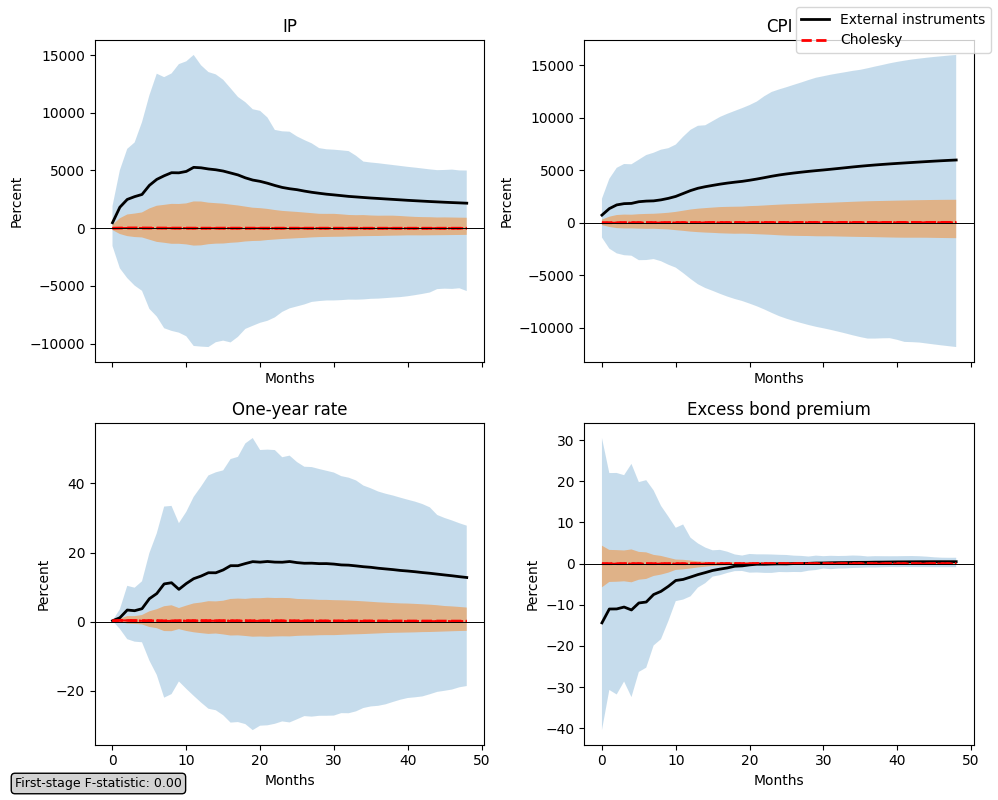

In [ ]:
print("\n\n================ IRFs – All events (meetings + speeches) =================")

shock_series = df["shock_all_events"].loc[y_ext.index]

proxy_results_all = rep.proxy_svar_identification(var_res_ext, shock_series)

proxy_irfs_all = rep.calculate_structural_irfs(
    var_res_ext,
    proxy_results_all["impact_vector"]
)

proxy_irfs_boot_all = rep.recursive_bootstrap_proxy_svar(
    y_ext,
    shock_series,
    var_res_ext,
    n_boot=1000
)

chol_irfs_all = var_res_ext.irf(rep.irhor).orth_irfs
chol_irfs_boot_all = rep.recursive_bootstrap_cholesky(
    y_ext,
    var_res_ext,
    n_boot=1000
)

fig_all_events = rep.plot_figure1_final(
    proxy_irfs_all,
    chol_irfs_all,
    proxy_irfs_boot_all,
    chol_irfs_boot_all,
    proxy_results_all
)

results_all_events = {
    "proxy_results": proxy_results_all,
    "figure": fig_all_events
}


### 2.6. Comments about the results

For **speech-based** instruments the first-stage diagnostics show that the proxy is **essentially useless** for identifying monetary policy shocks. For all three variants (all speeches, Chair-only, Vice Chair-only), the R² is close to zero (below 0.1%) and the first-stage F-statistics are 0.36, 0.46 and 0.10, respectively. This implies that monthly variation in the number of speeches is almost uncorrelated with the reduced-form innovation in the short-rate equation. Speech-based measures behave as weak instruments.


* **Scheduled FOMC:** **very weak instrument** (F ≈ 0.49). Regular
meetings are mostly anticipated, so their HF surprises explain almost none of the policy-rate innovation. IRFs based on this proxy are weakly identified.
* **Unscheduled FOMC: reasonably strong instrument** (F ≈ 4). Emergency meetings generate genuinely unexpected rate moves, so this proxy captures meaningful monetary policy shocks and produces much more reliable IRFs.
* **All FOMC (pooled):** very weak instrument (F ≈ 0.29). Pooling scheduled and unscheduled meetings dilutes the information content of unscheduled events with many almost-expected scheduled decisions, so the combined proxy is noticeably weaker than the unscheduled-only one.

When we pool all events – FOMC meetings and speeches – into a single proxy, the first-stage F-statistic drops to about 0.0 and the R-squared is below 0.1%. This clearly indicates a **weak instrument**. The scaled impact vector displays implausibly large responses in output, inflation and especially the excess bond premium, which is a classic symptom of weak identification once the policy-rate impact is normalised. In other words, **adding speech-based variation to FOMC shocks does not strengthen the proxy**; it mainly adds noise and makes the pooled “all events” instrument less reliable than the unscheduled-meeting proxy.